In [2]:
import pandas as pd
df1 = pd.read_csv("/kaggle/input/redbus/RedBusDataHackathon/train.csv")
df1

doj  srcid  destid  final_seatcount
0      2023-03-01     45      46           2838.0
1      2023-03-01     46      45           2298.0
2      2023-03-01     45      47           2720.0
3      2023-03-01     47      45           2580.0
4      2023-03-01     46       9           4185.0
...           ...    ...     ...              ...
67195  2024-12-31      2      24            800.0
67196  2024-12-31     44      45           1360.0
67197  2024-12-31     47      10            560.0
67198  2024-12-31     38      36            535.0
67199  2024-12-31     19      30           2040.0

[67200 rows x 4 columns]

In [3]:
df2 = pd.read_csv("/kaggle/input/redbus/RedBusDataHackathon/transactions.csv")
df2

doj         doi  srcid  destid         srcid_region  \
0        2023-03-01  2023-01-30     45      46            Karnataka   
1        2023-03-01  2023-01-30     46      45           Tamil Nadu   
2        2023-03-01  2023-01-30     45      47            Karnataka   
3        2023-03-01  2023-01-30     47      45       Andhra Pradesh   
4        2023-03-01  2023-01-30     46       9           Tamil Nadu   
...             ...         ...    ...     ...                  ...   
2266095  2025-02-28  2025-02-28      2      24  Maharashtra and Goa   
2266096  2025-02-28  2025-02-28     44      45           Tamil Nadu   
2266097  2025-02-28  2025-02-28     47      10       Andhra Pradesh   
2266098  2025-02-28  2025-02-28     38      36        Rest of North   
2266099  2025-02-28  2025-02-28     19      30       Madhya Pradesh   

               destid_region srcid_tier destid_tier  cumsum_seatcount  \
0                 Tamil Nadu     Tier 1      Tier 1               8.0   
1                  Karnataka     Tier 1      Tier 1               8.0   
2             Andhra Pradesh     Tier 1      Tier 1               4.0   
3                  Karnataka     Tier 1      Tier 1               0.0   
4                 Tamil Nadu     Tier 1       Tier2               9.0   
...                      ...        ...         ...               ...   
2266095  Maharashtra and Goa     Tier 1       Tier2               0.0   
2266096            Karnataka      Tier2      Tier 1               0.0   
2266097       Andhra Pradesh     Tier 1      Tier 3               0.0   
2266098                Delhi     Tier 1       Tier2               0.0   
2266099  Maharashtra and Goa     Tier 1      Tier 1               0.0   

         cumsum_searchcount  dbd  
0                      76.0   30  
1                      70.0   30  
2                     142.0   30  
3                      68.0   30  
4                     162.0   30  
...                     ...  ...  
2266095                 0.0    0  
2266096                 0.0    0  
2266097                 0.0    0  
2266098                 0.0    0  
2266099                 0.0    0  

[2266100 rows x 11 columns]

In [4]:
# Get all unique ordered (srcid, destid) pairs

ordered_pairs = df2[['srcid', 'destid']].drop_duplicates().sort_values(by=['srcid', 'destid']).reset_index(drop=True)
print(ordered_pairs)

    srcid  destid
0       1       2
1       2       1
2       2      14
3       2      16
4       2      19
..    ...     ...
95     47      43
96     47      45
97     47      46
98     48      45
99     48      46

[100 rows x 2 columns]


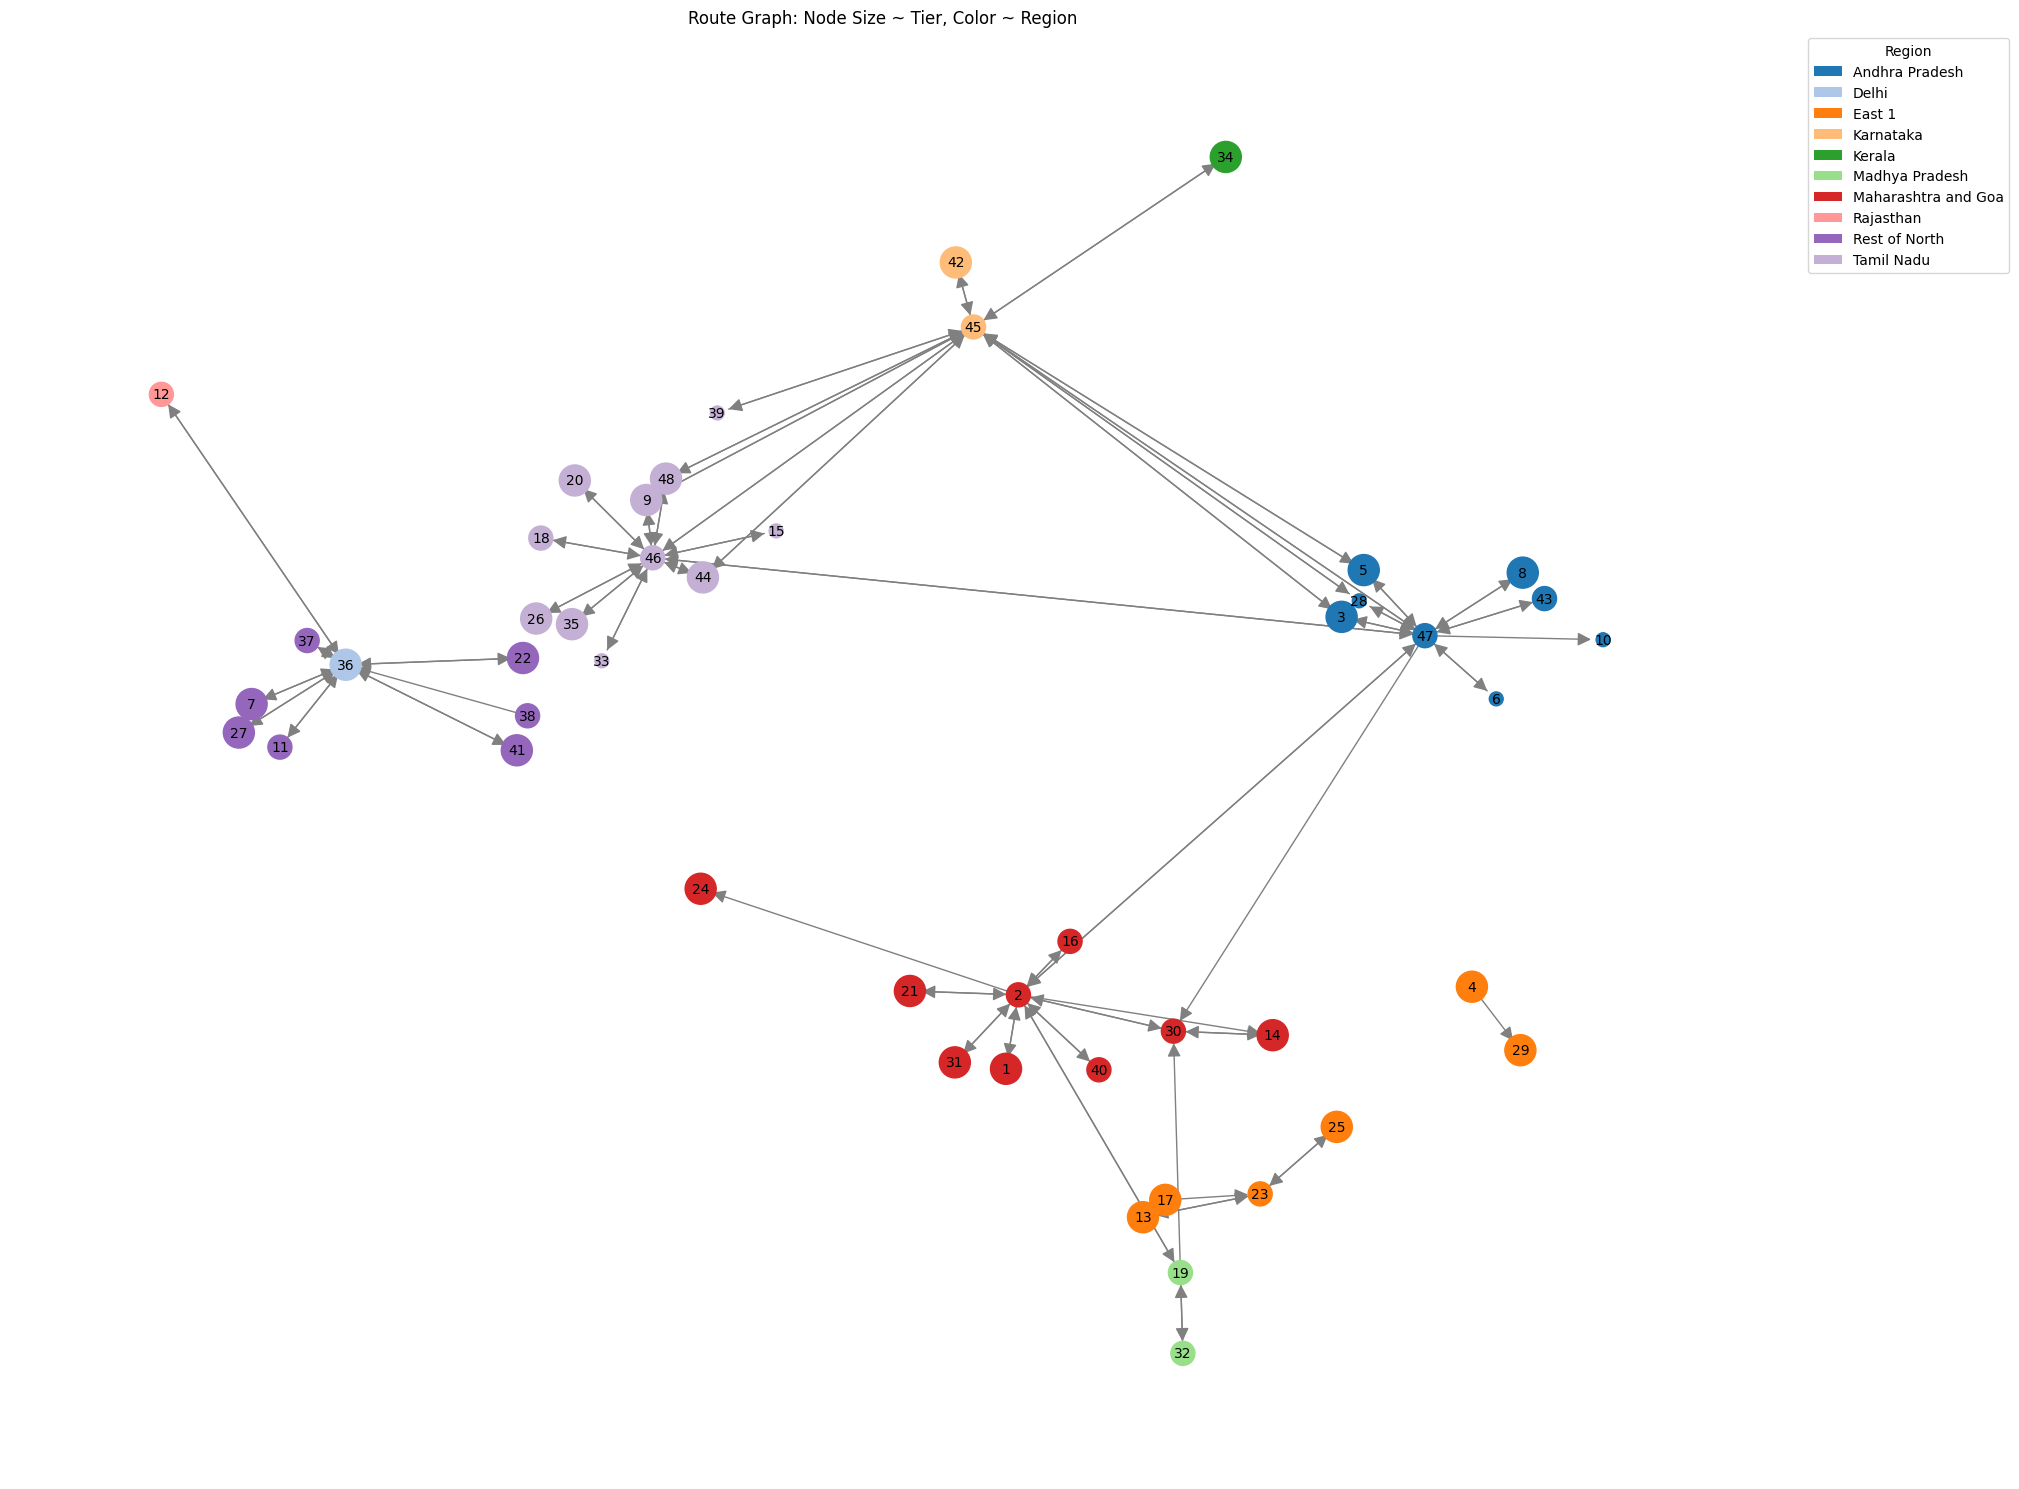

In [20]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

src_nodes = df2[['srcid', 'srcid_region', 'srcid_tier']].rename(
    columns={'srcid': 'node', 'srcid_region': 'region', 'srcid_tier': 'tier'})
dest_nodes = df2[['destid', 'destid_region', 'destid_tier']].rename(
    columns={'destid': 'node', 'destid_region': 'region', 'destid_tier': 'tier'})

nodes_df = pd.concat([src_nodes, dest_nodes]).drop_duplicates('node')

# Step 2: Edges
edges = df2[['srcid', 'destid']].drop_duplicates()

# Step 3: Create graph
G = nx.DiGraph()
G.add_edges_from(edges.itertuples(index=False, name=None))

# Step 4: Add attributes
for _, row in nodes_df.iterrows():
    G.nodes[row['node']]['region'] = row['region']
    G.nodes[row['node']]['tier'] = row['tier']

# Step 5: Layout
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G, seed=42,k=0.5)
import numpy as np
from collections import defaultdict

# Group nodes by region
region_to_nodes = defaultdict(list)
for node in G.nodes:
    region = G.nodes[node]['region']
    region_to_nodes[region].append(node)

# Pull nodes toward region centroid (stronger influence)
for region, nodes in region_to_nodes.items():
    coords = np.array([pos[n] for n in nodes])
    center = coords.mean(axis=0)
    for n in nodes:
        # Blend 70% centroid + 30% original position (strong pull to region)
        pos[n] = 0.7 * center + 0.3 * pos[n]

# Step 6: Node size from tier
tier_map = {'Tier 1': 300, 'Tier 2': 200, 'Tier 3': 100}
node_sizes = [tier_map.get(G.nodes[n].get('tier', 'Tier 2'), 500) for n in G.nodes]

# Step 7: Node color by region
regions = sorted(nodes_df['region'].unique())
region_color_map = {region: plt.cm.tab20(i % 20) for i, region in enumerate(regions)}
node_colors = [region_color_map[G.nodes[n]['region']] for n in G.nodes]

# Step 8: Draw graph
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=10)

# Step 9: Add legend
legend_elements = [Patch(facecolor=region_color_map[r], label=r) for r in regions]
plt.legend(handles=legend_elements, title="Region", loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title("Route Graph: Node Size ~ Tier, Color ~ Region")
plt.axis('off')
plt.tight_layout()
plt.show()


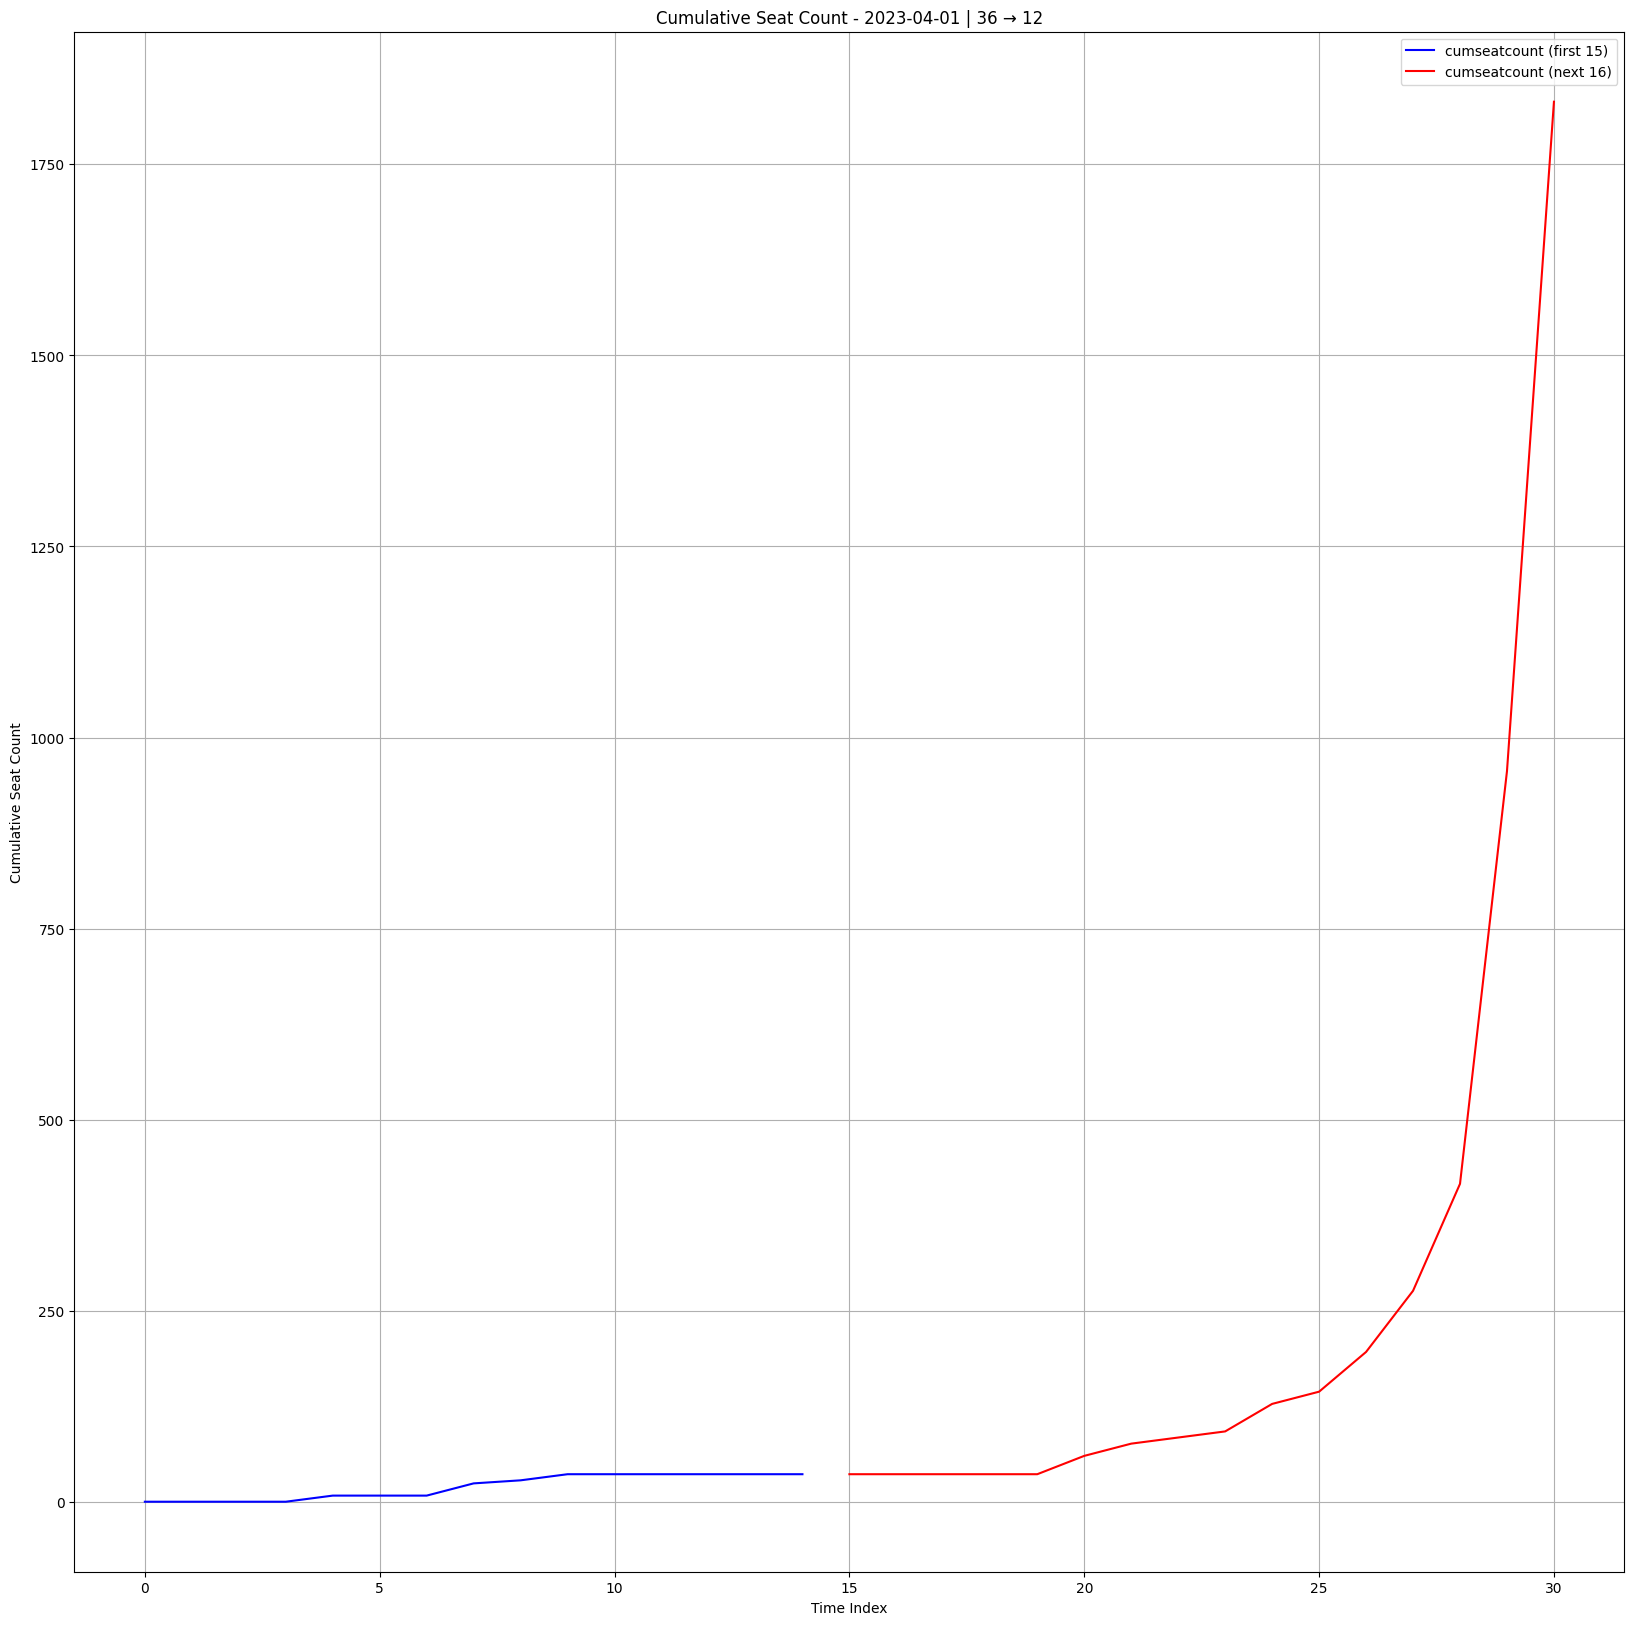

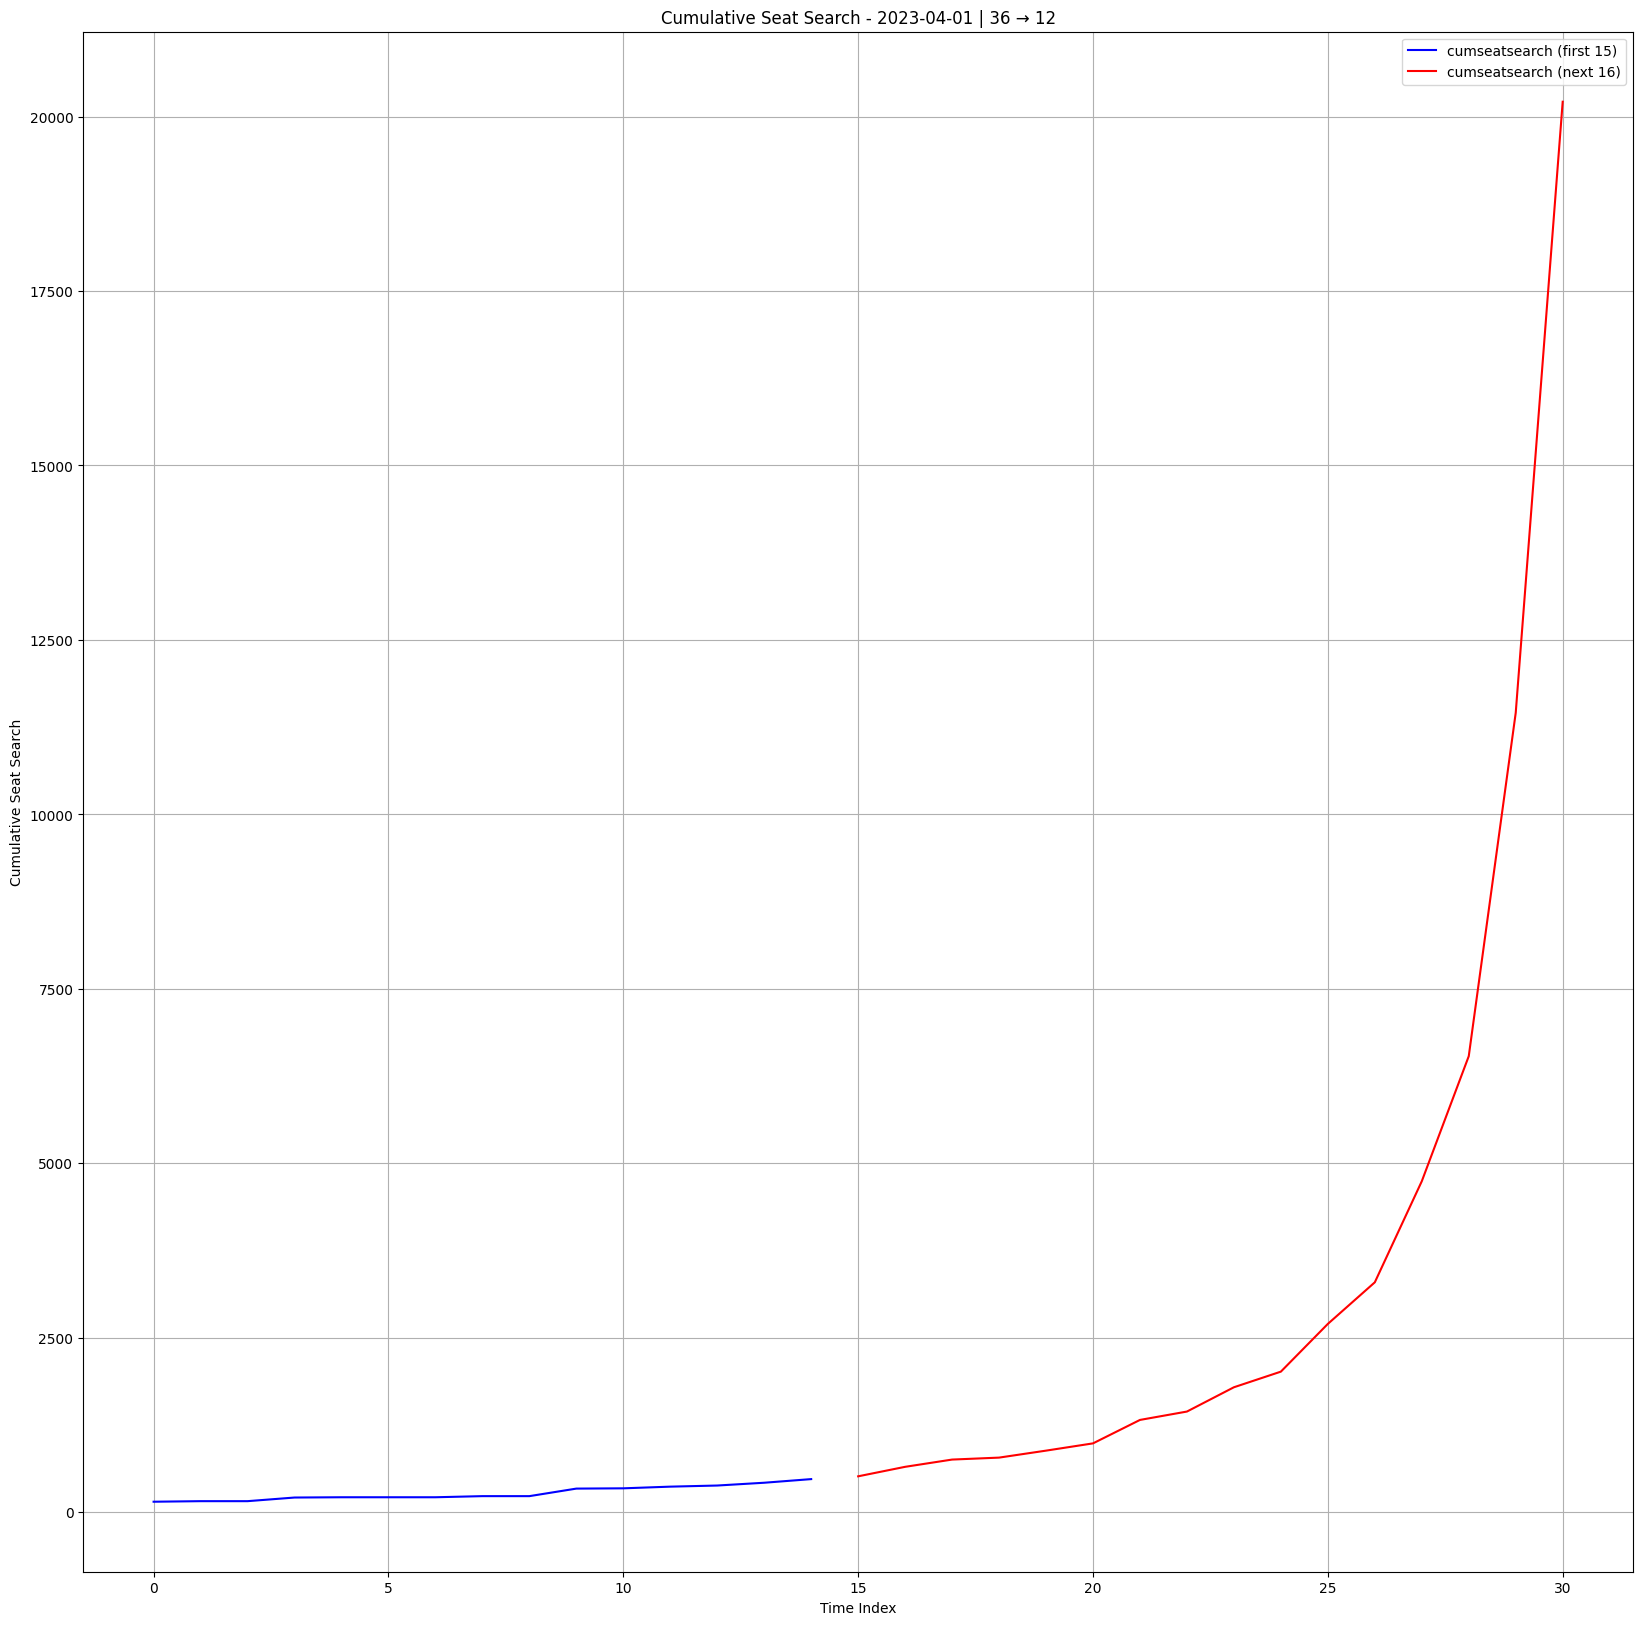

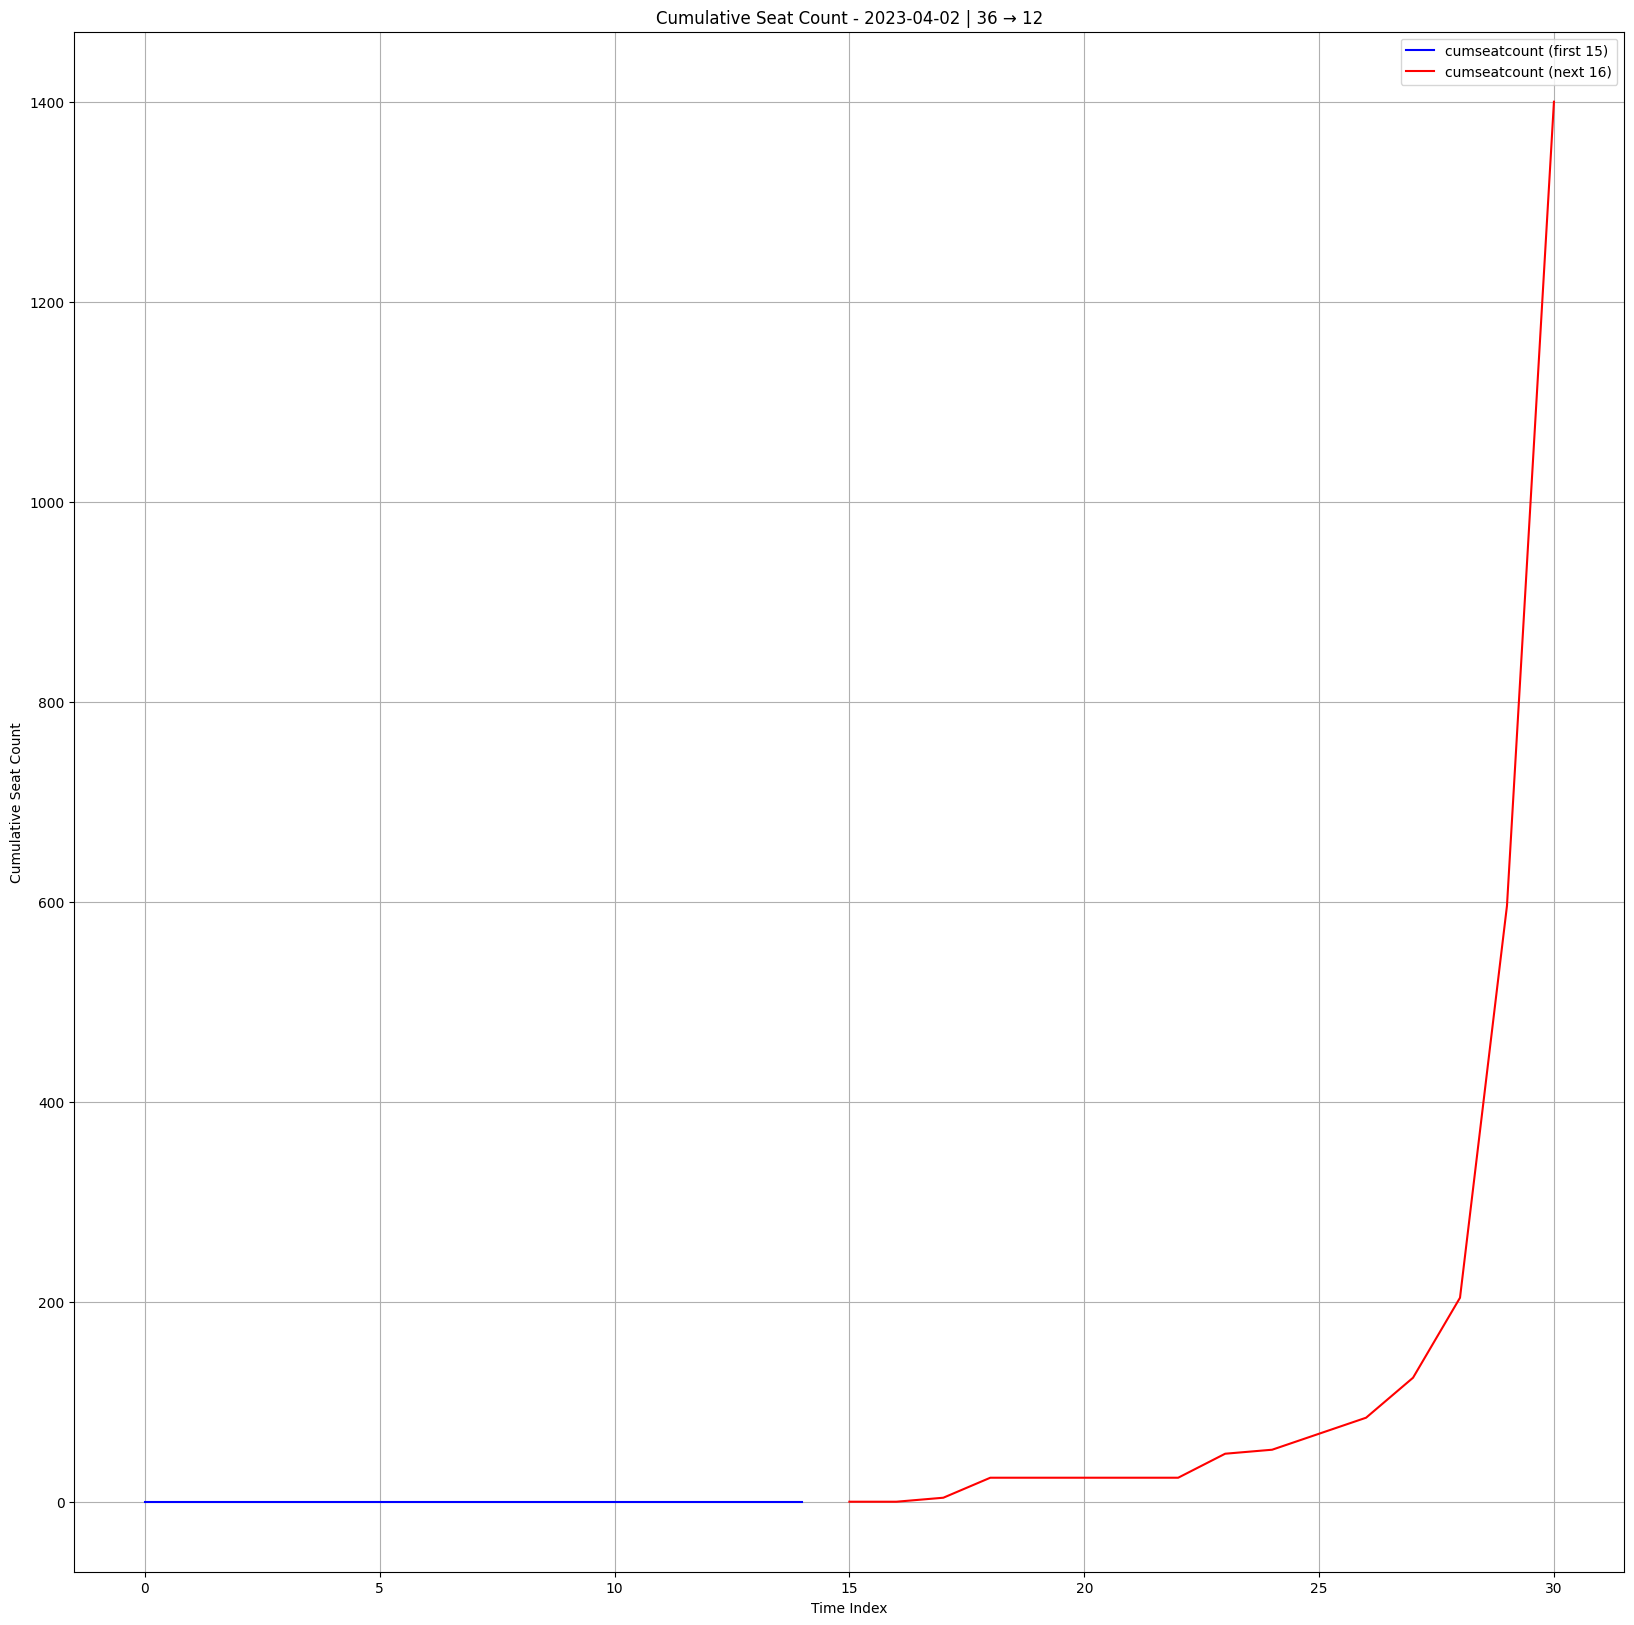

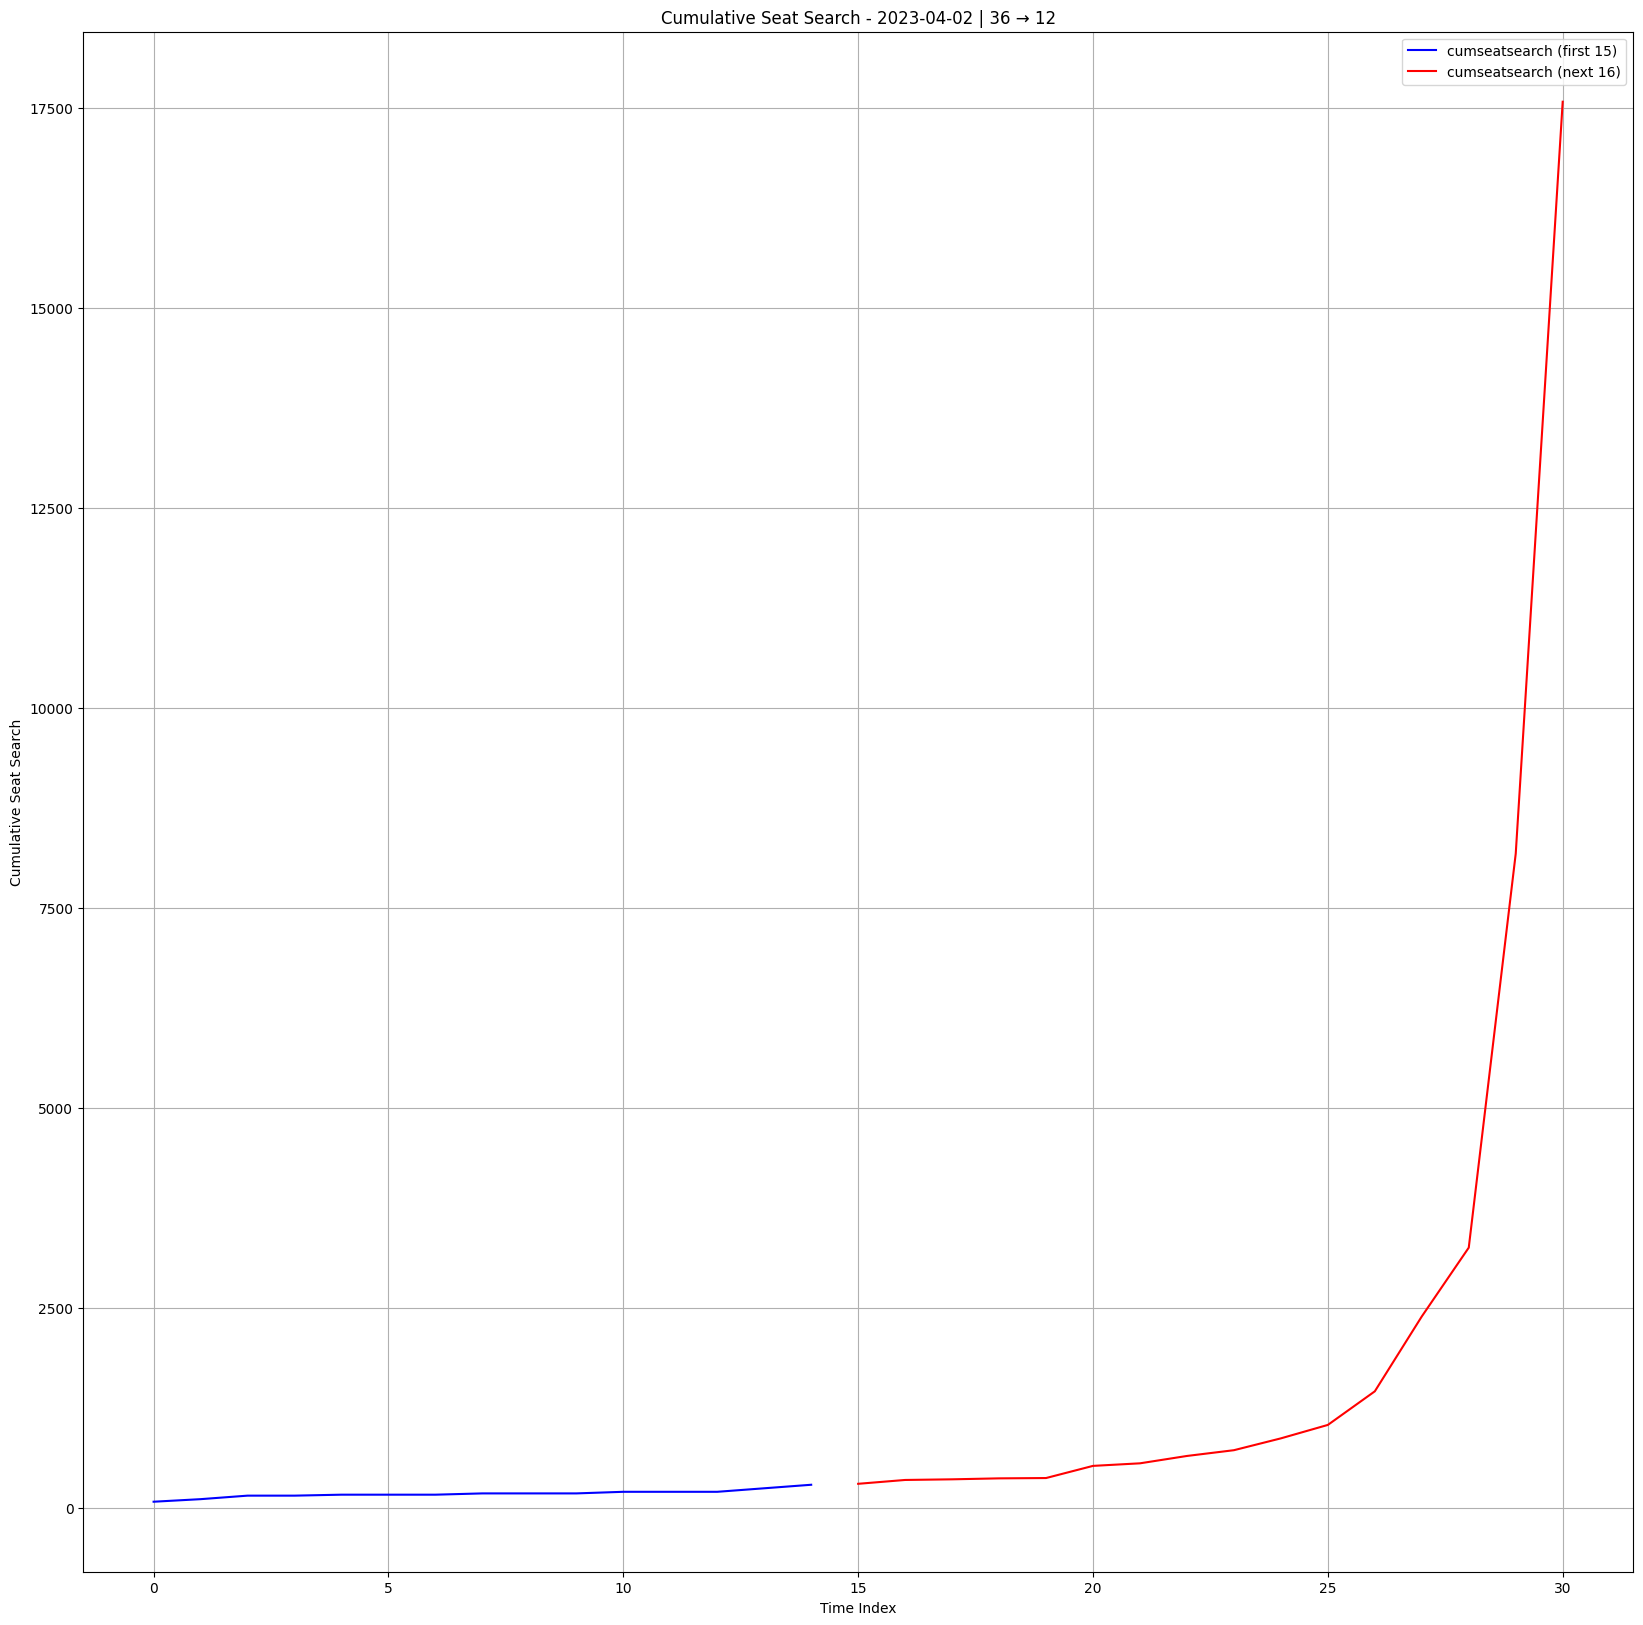

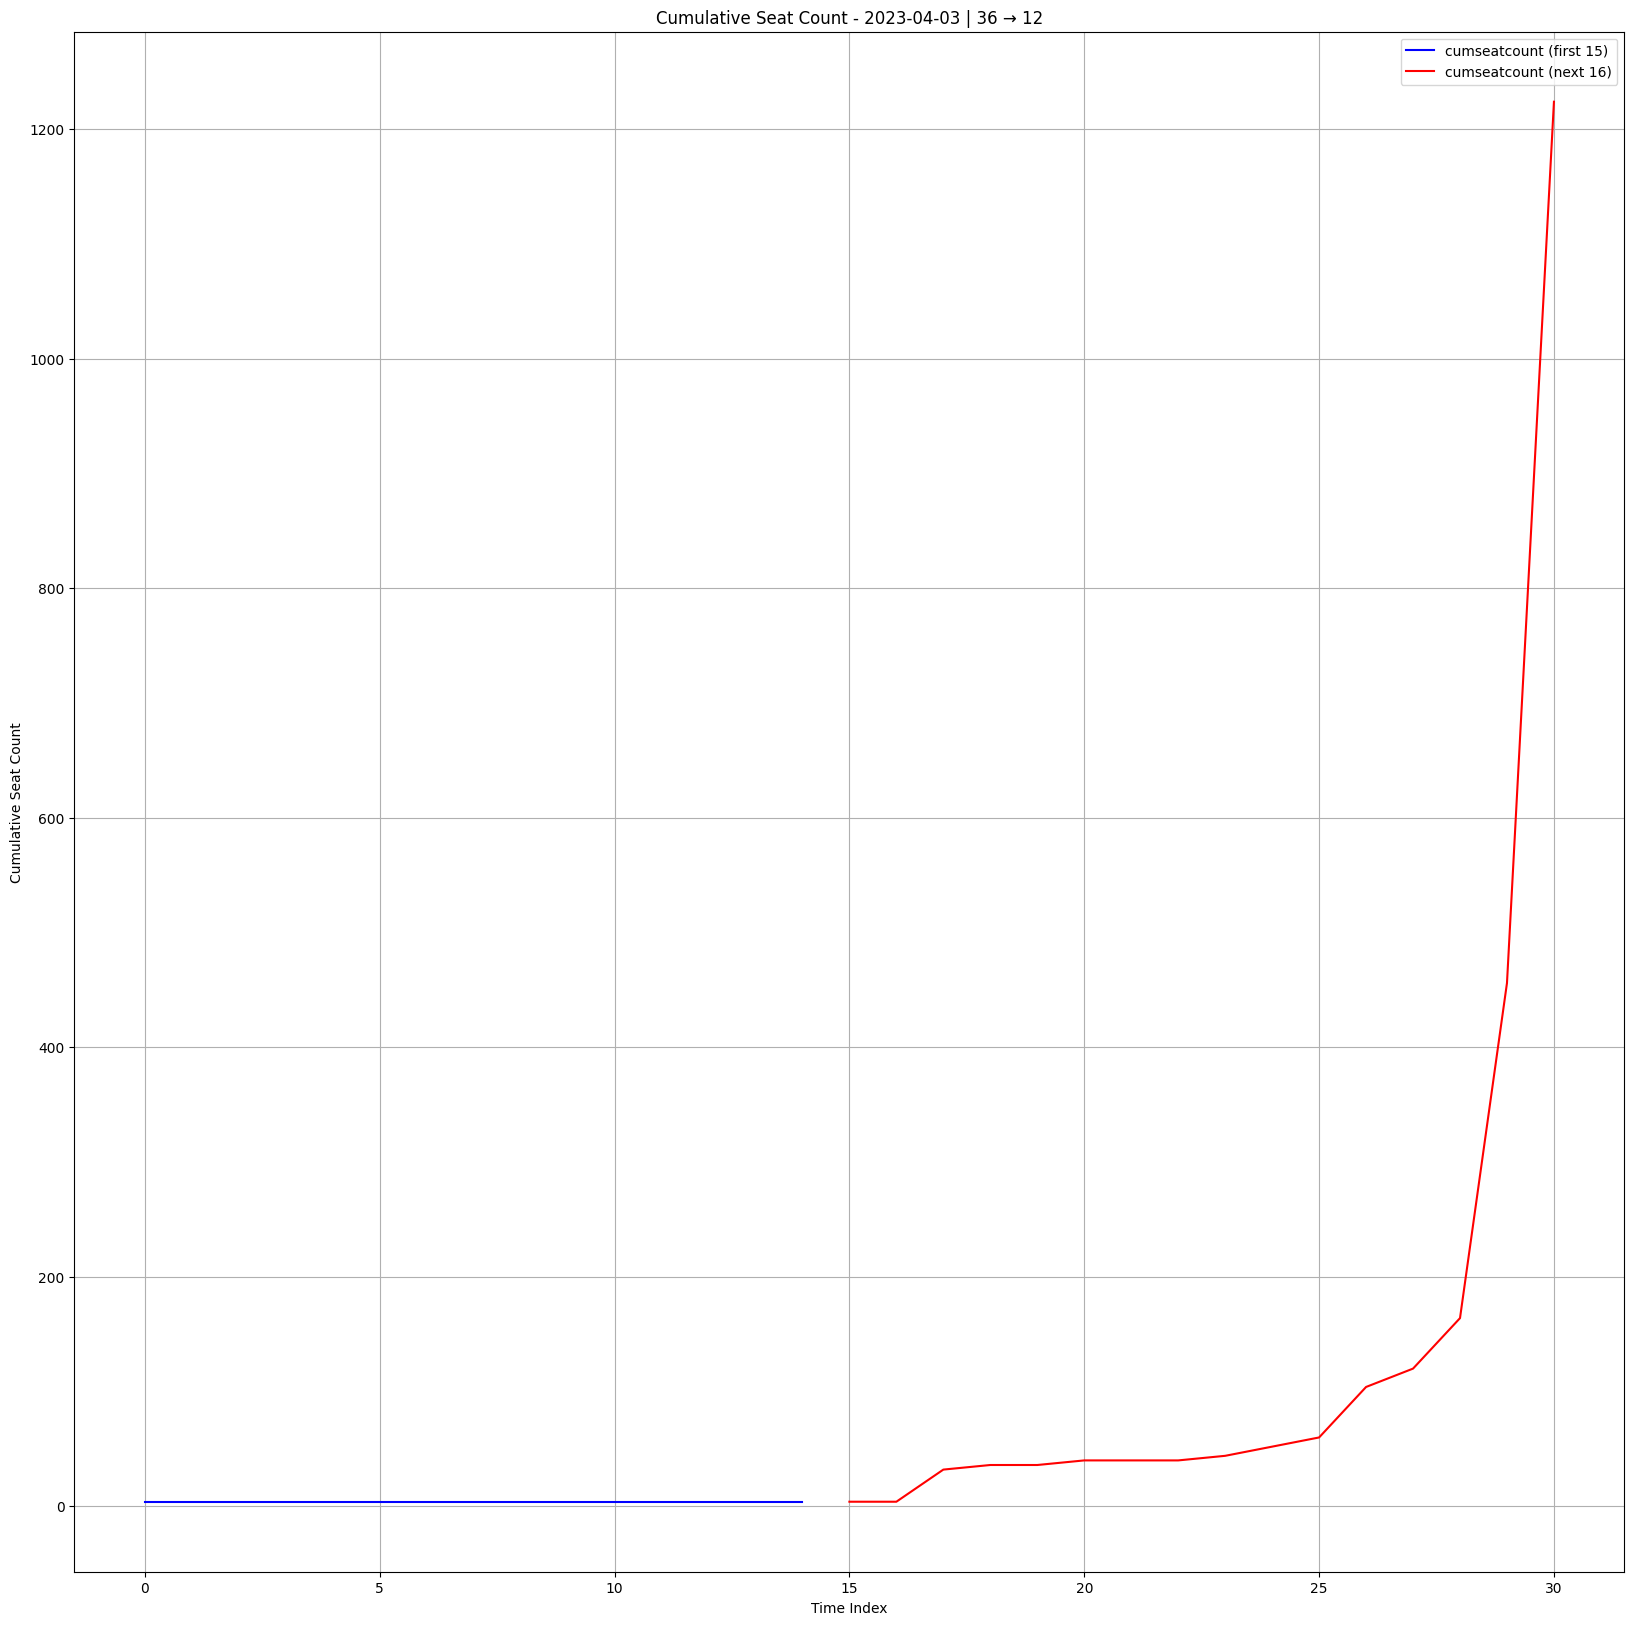

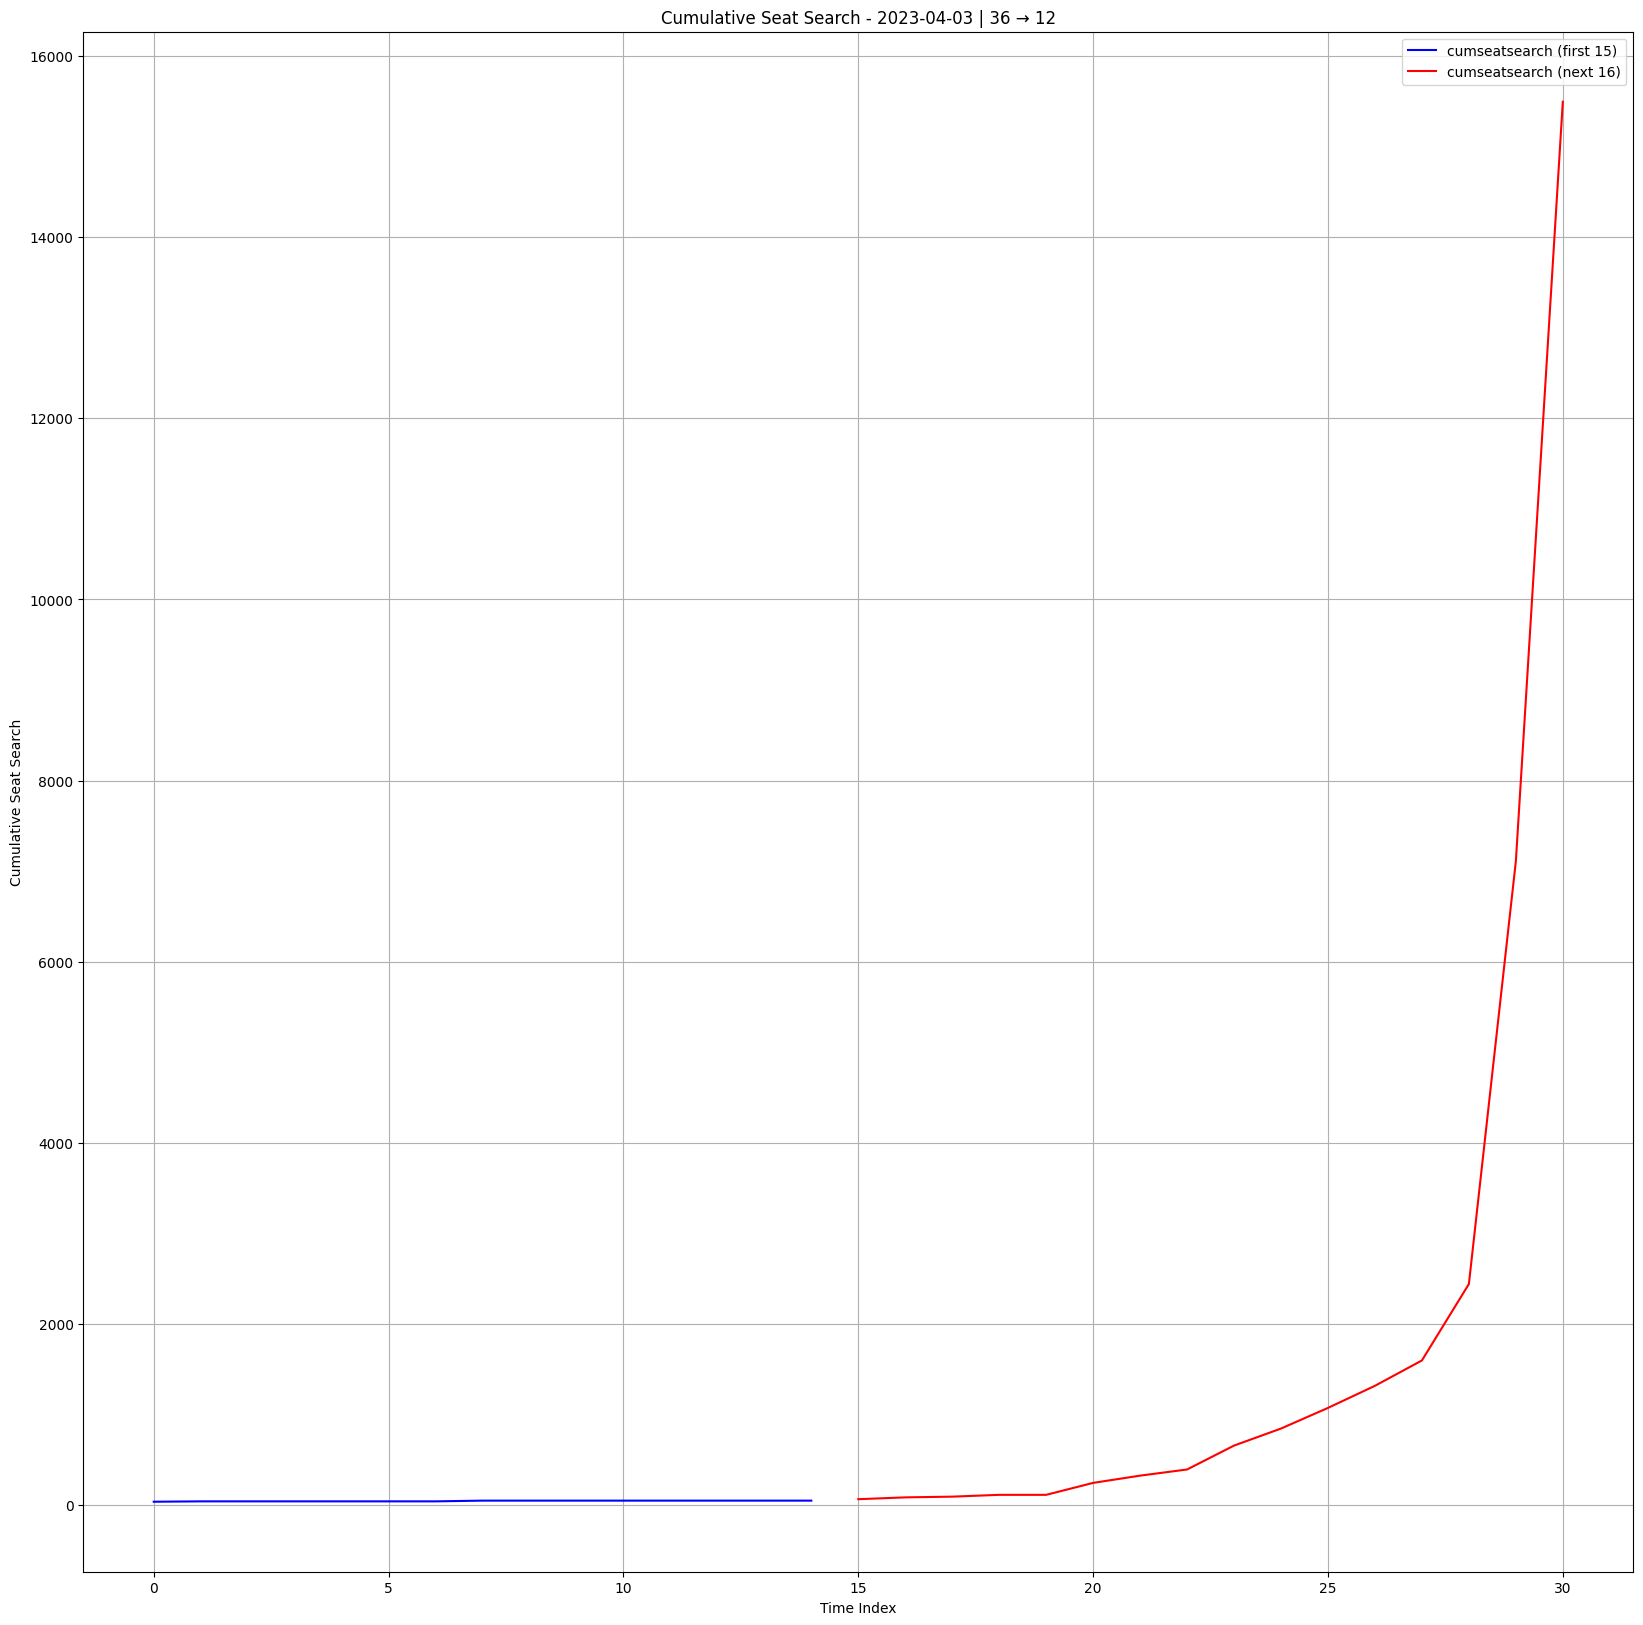

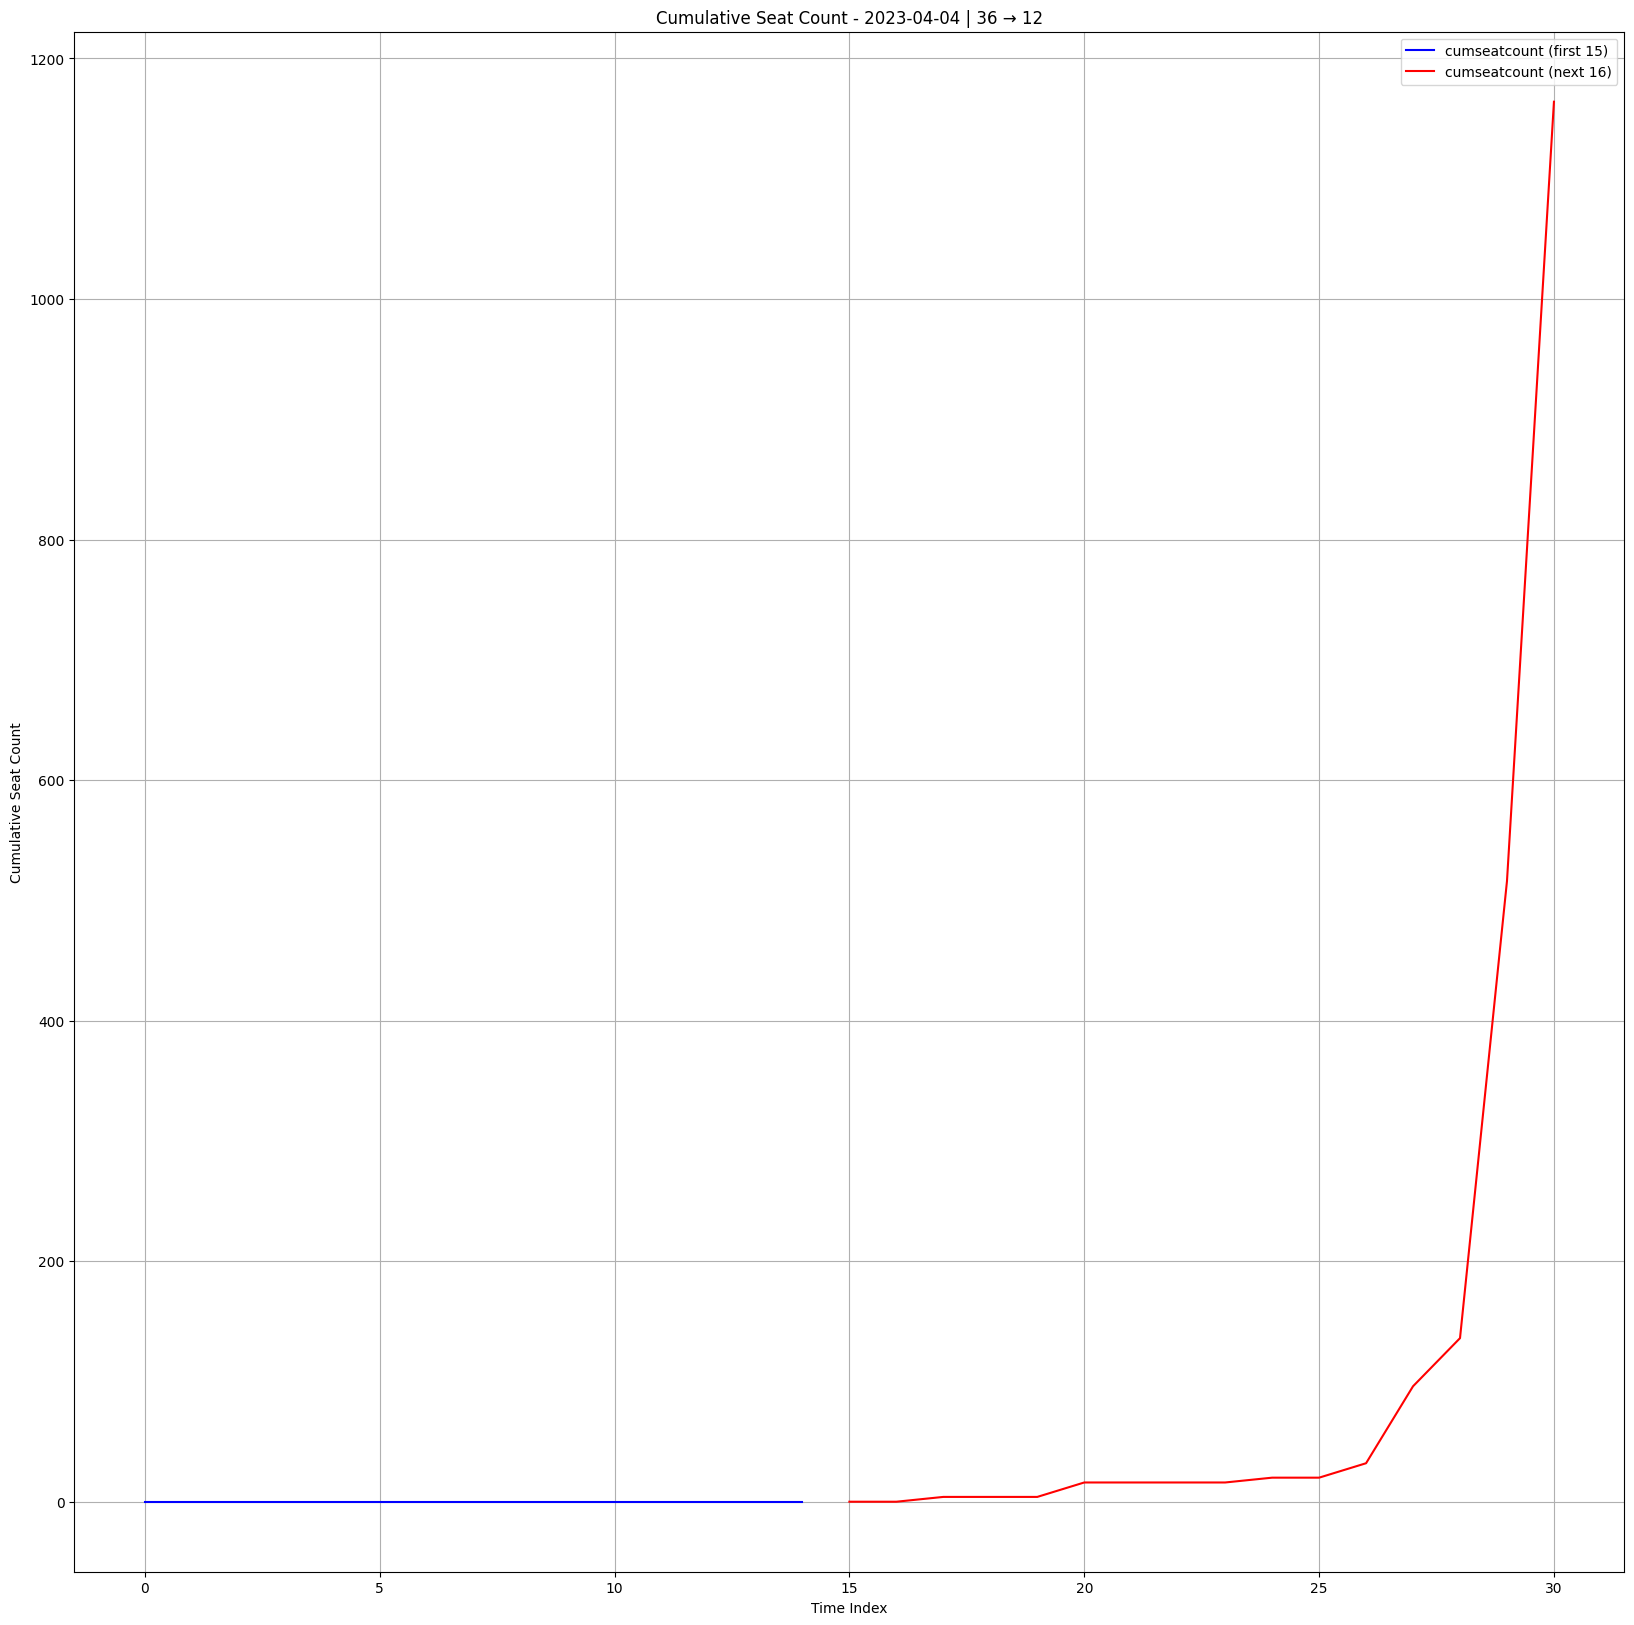

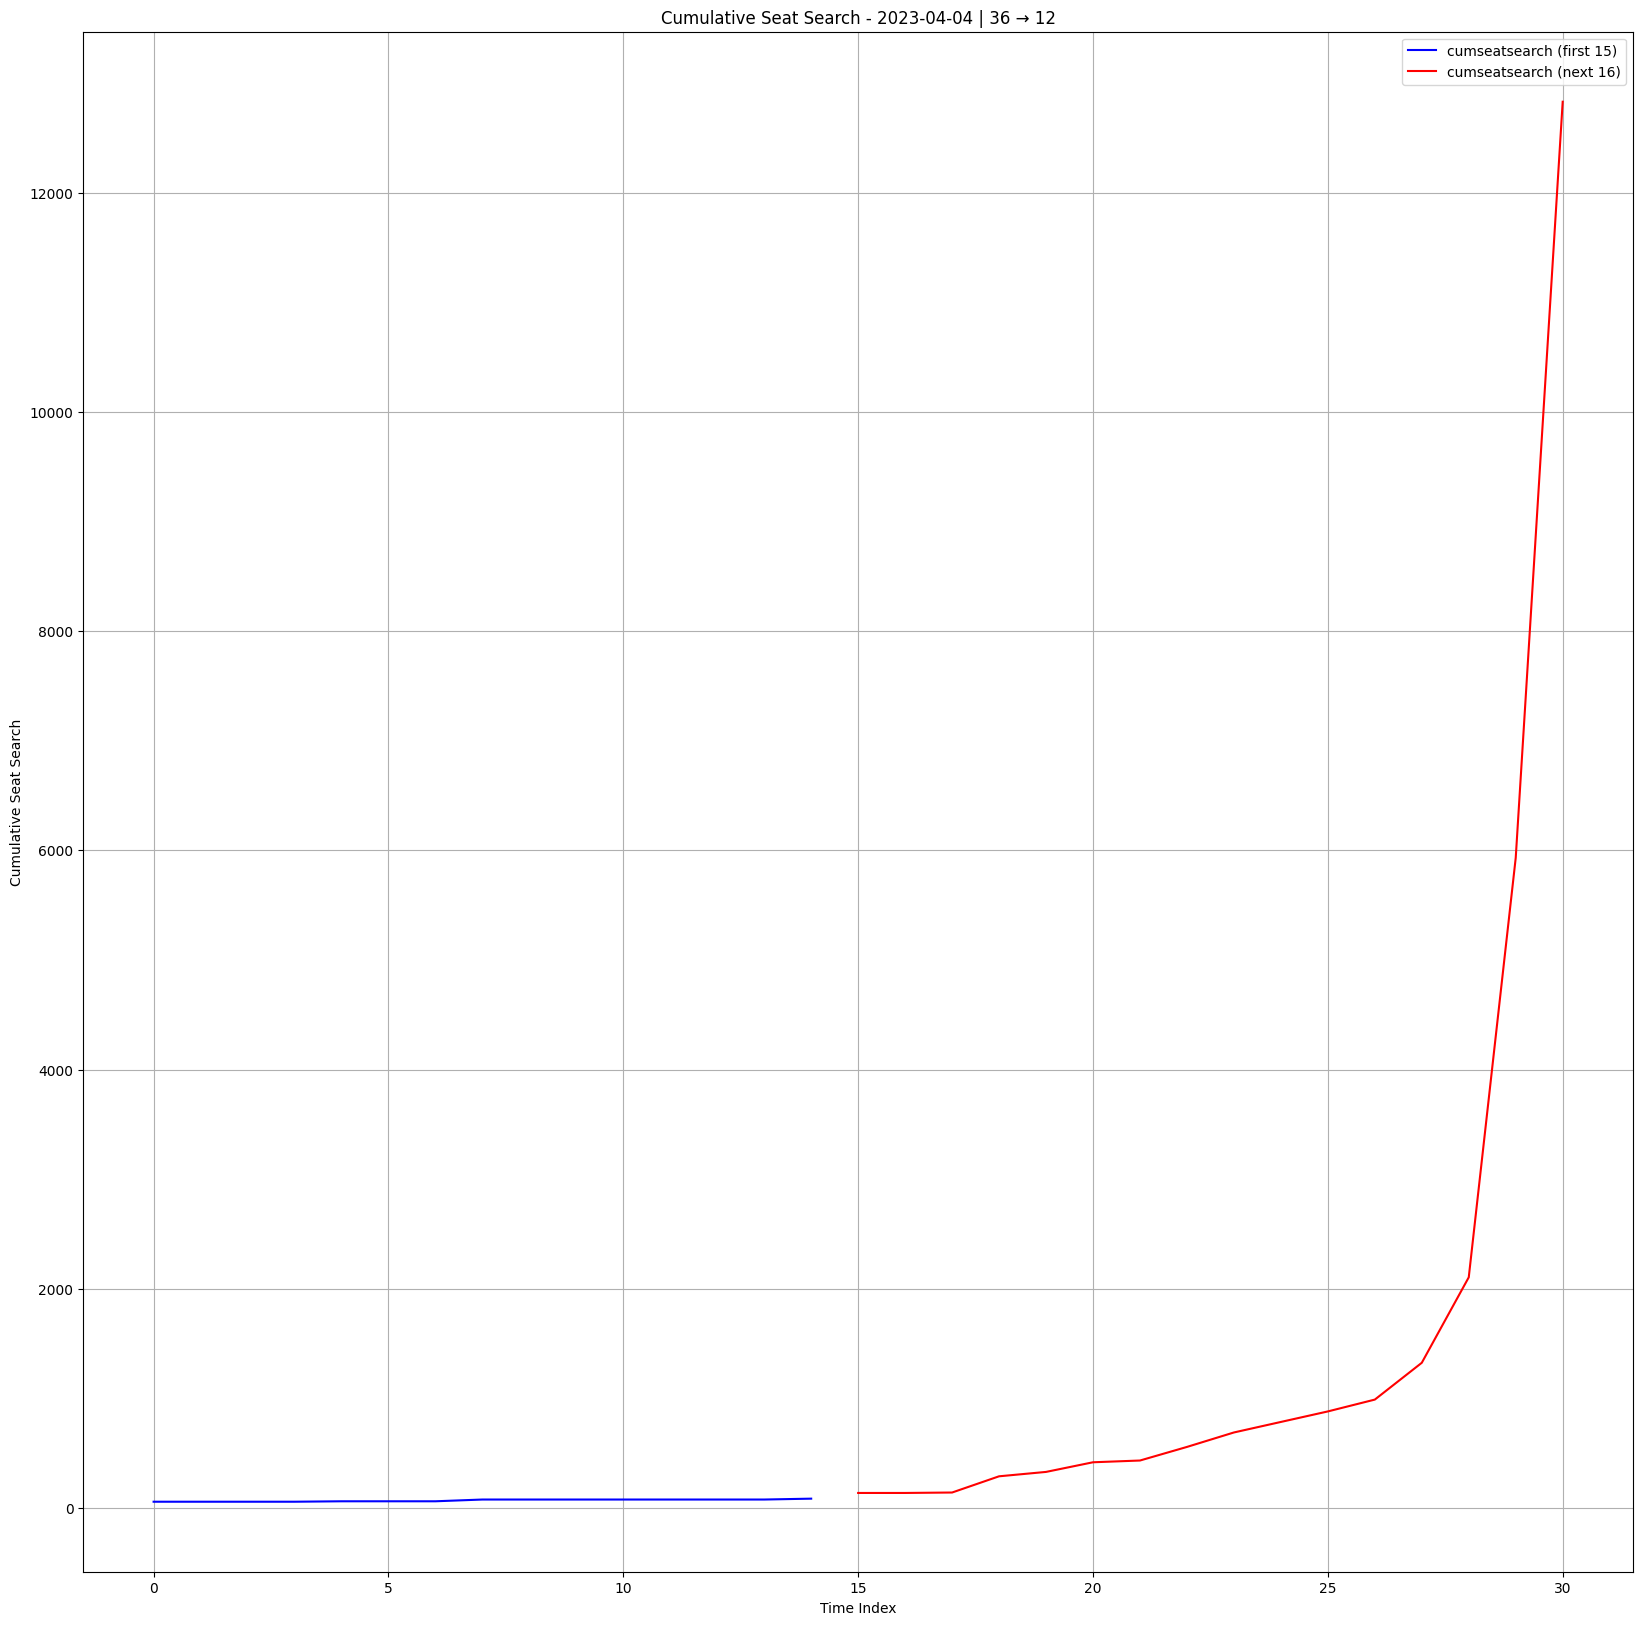

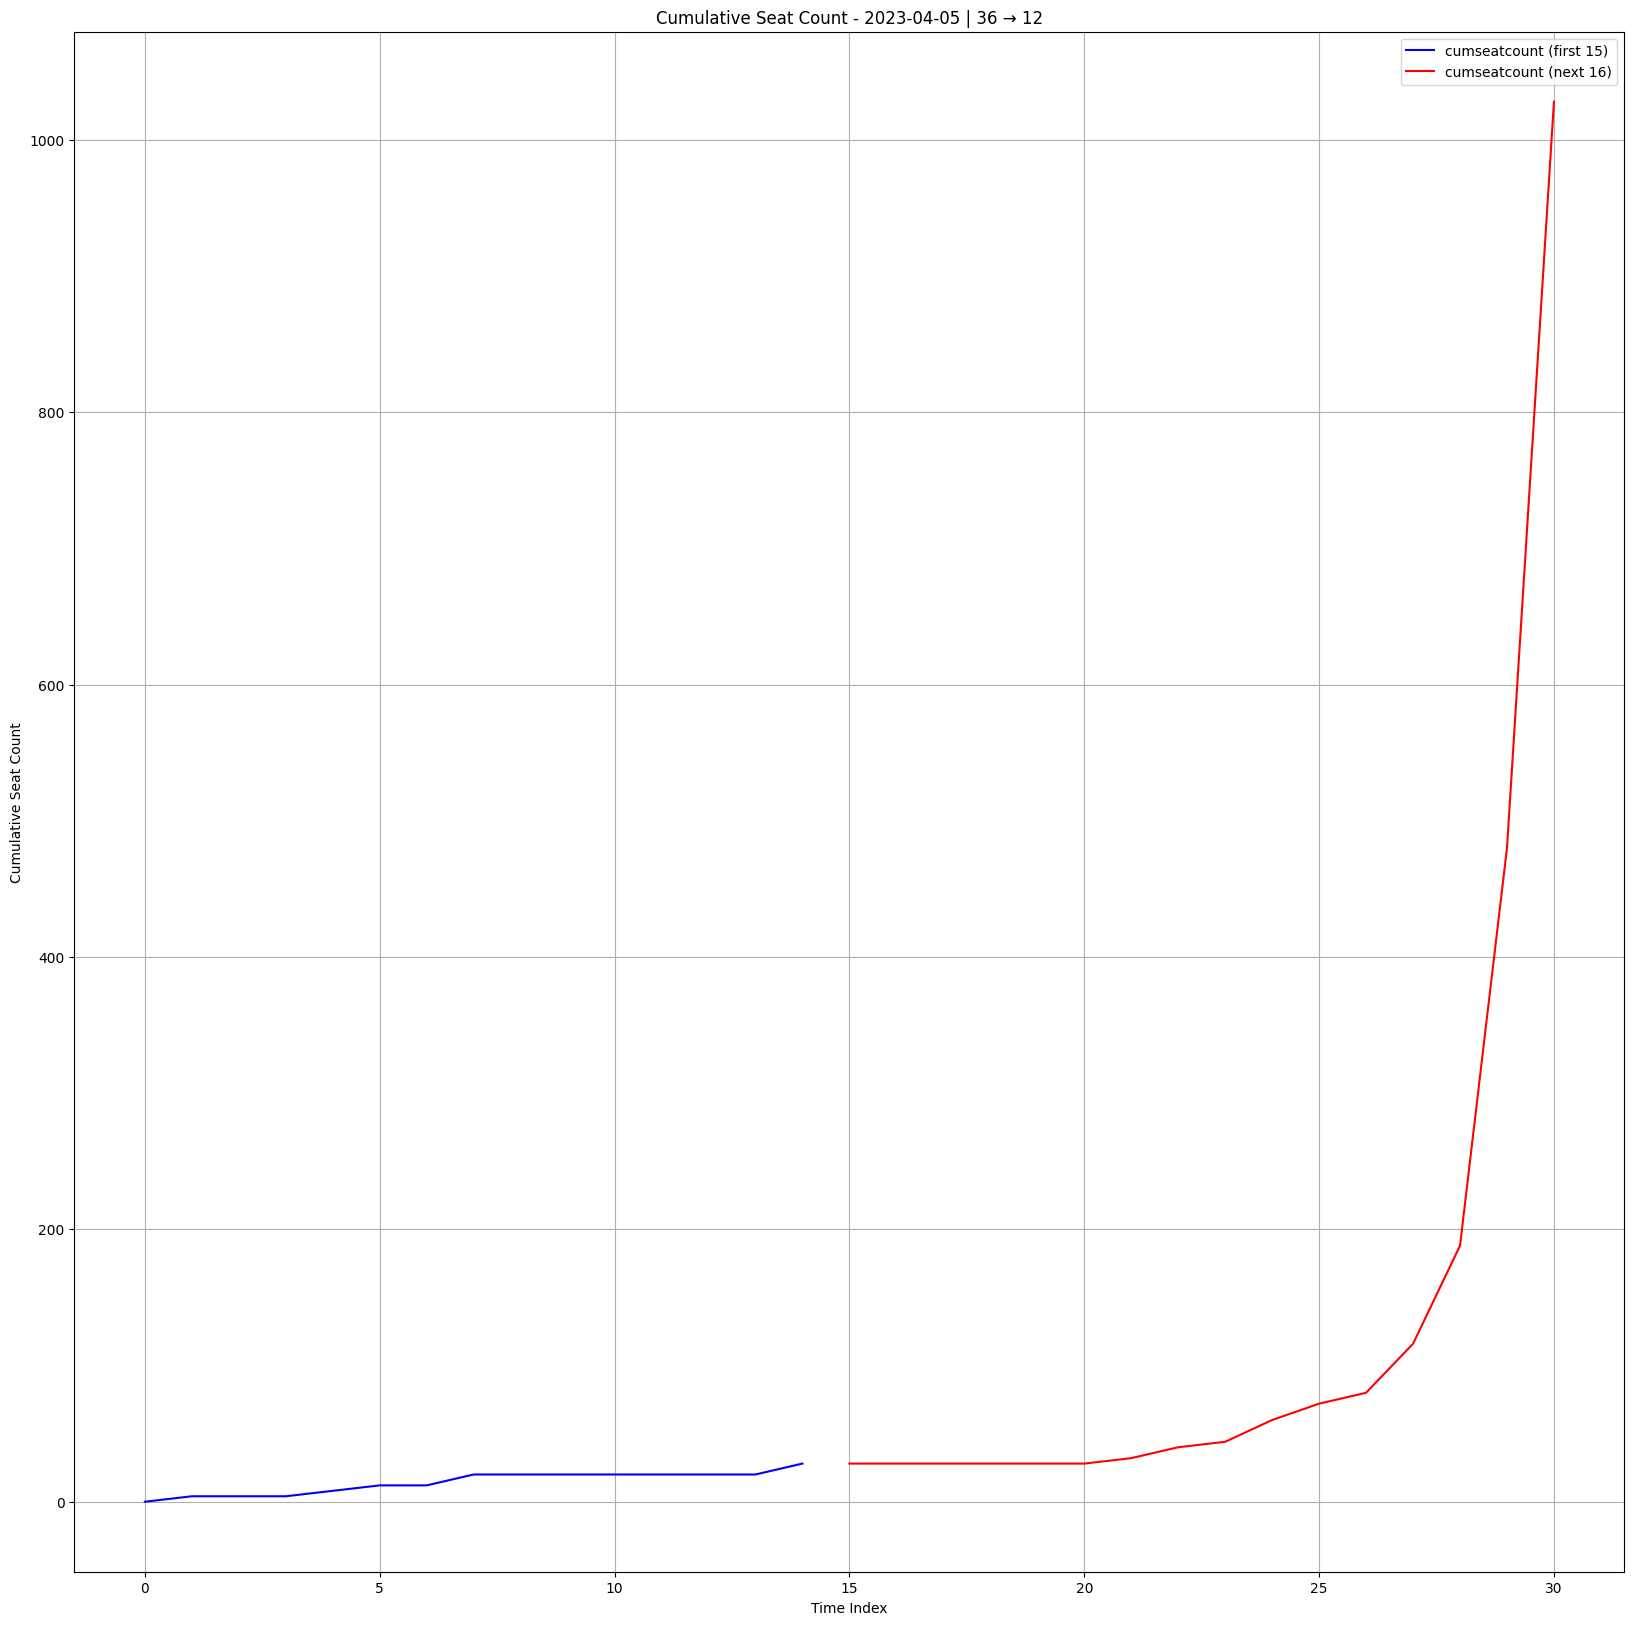

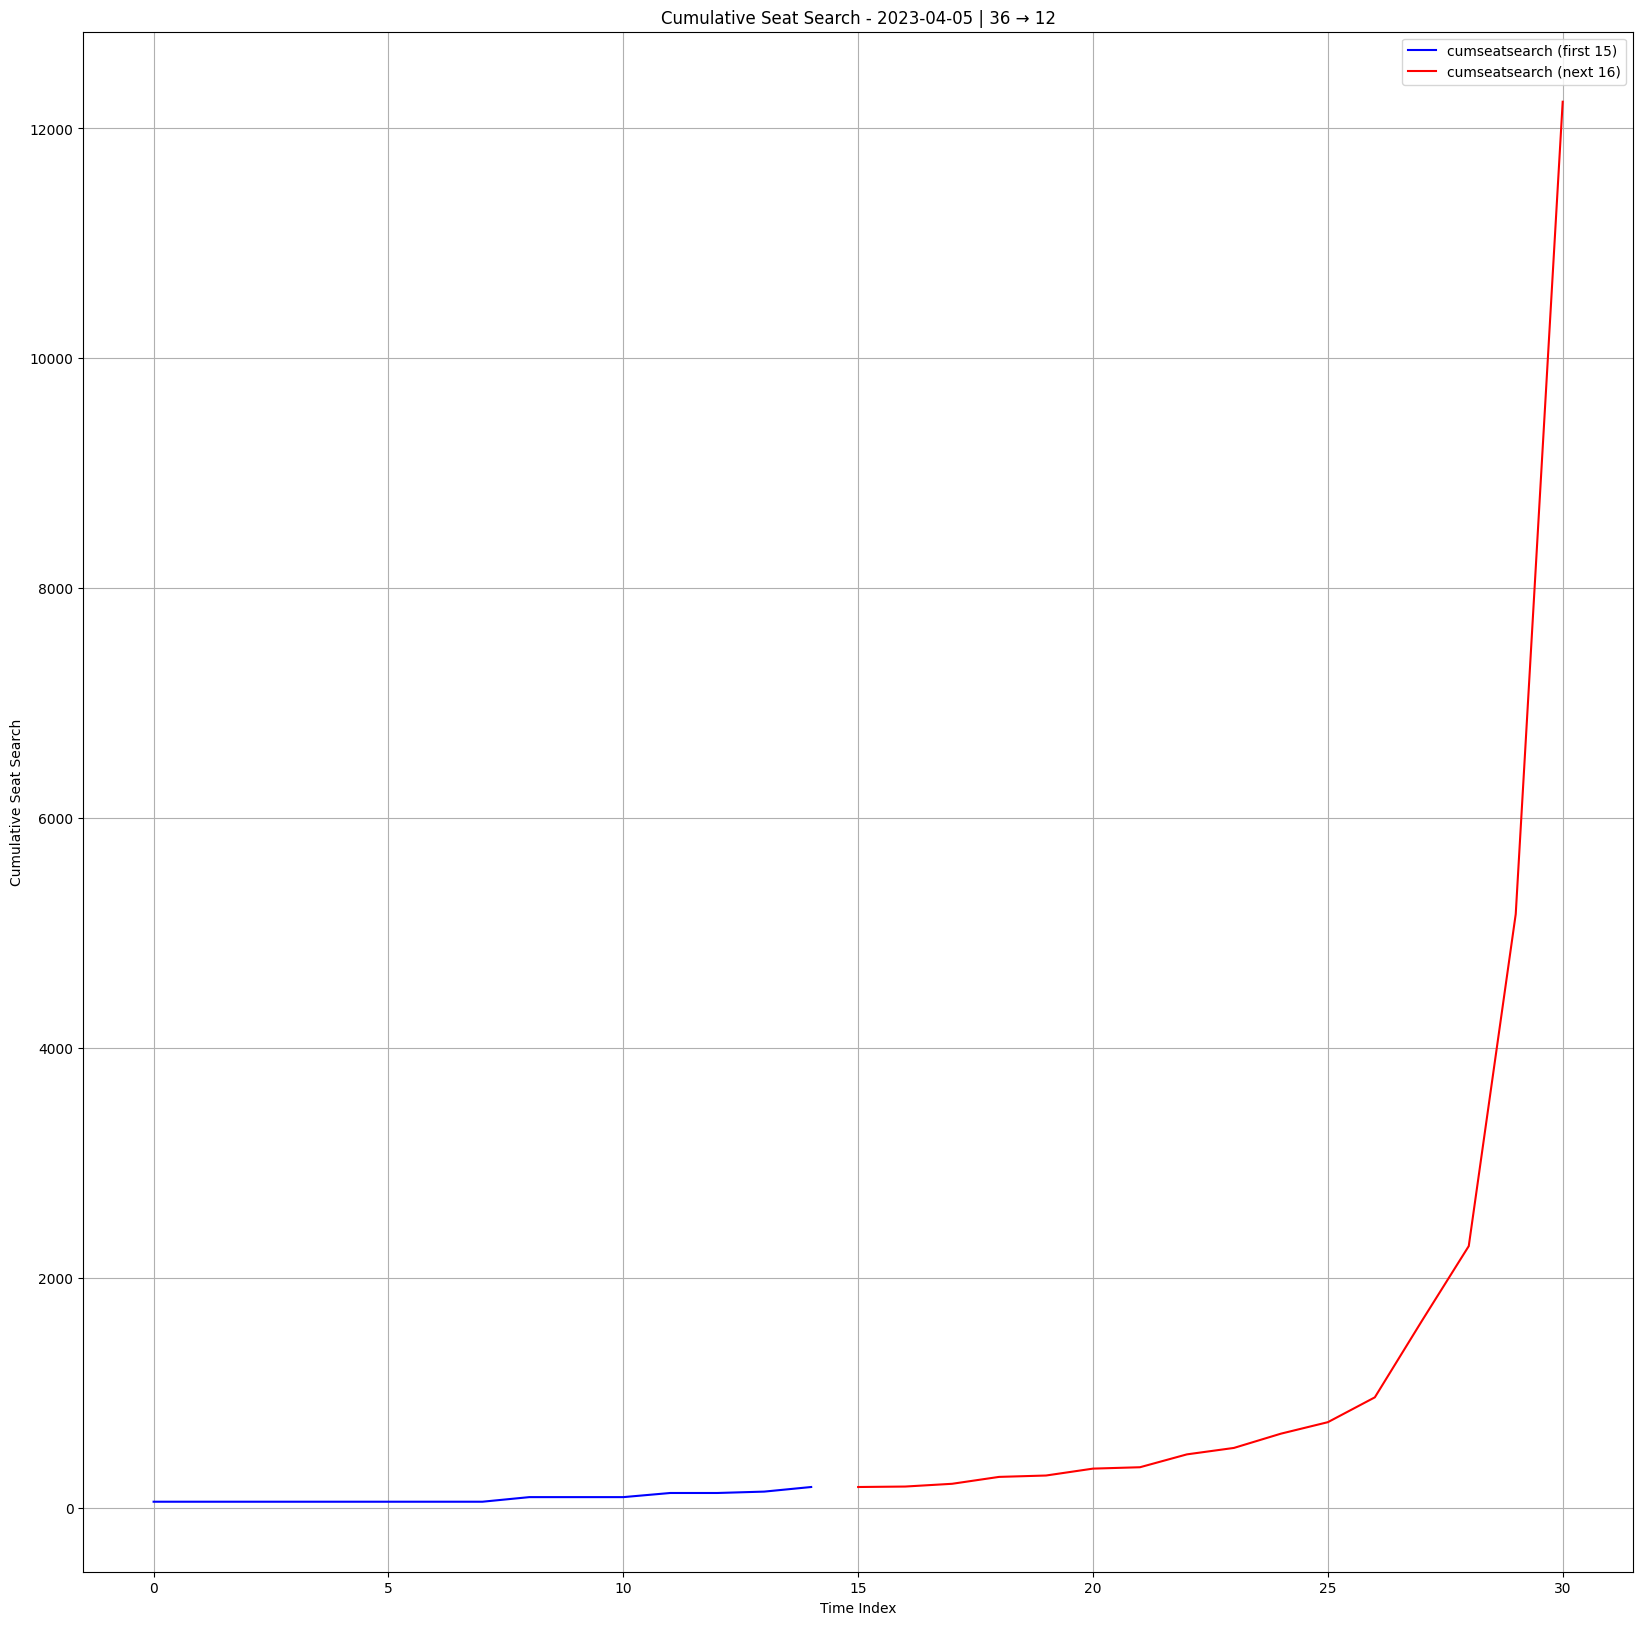

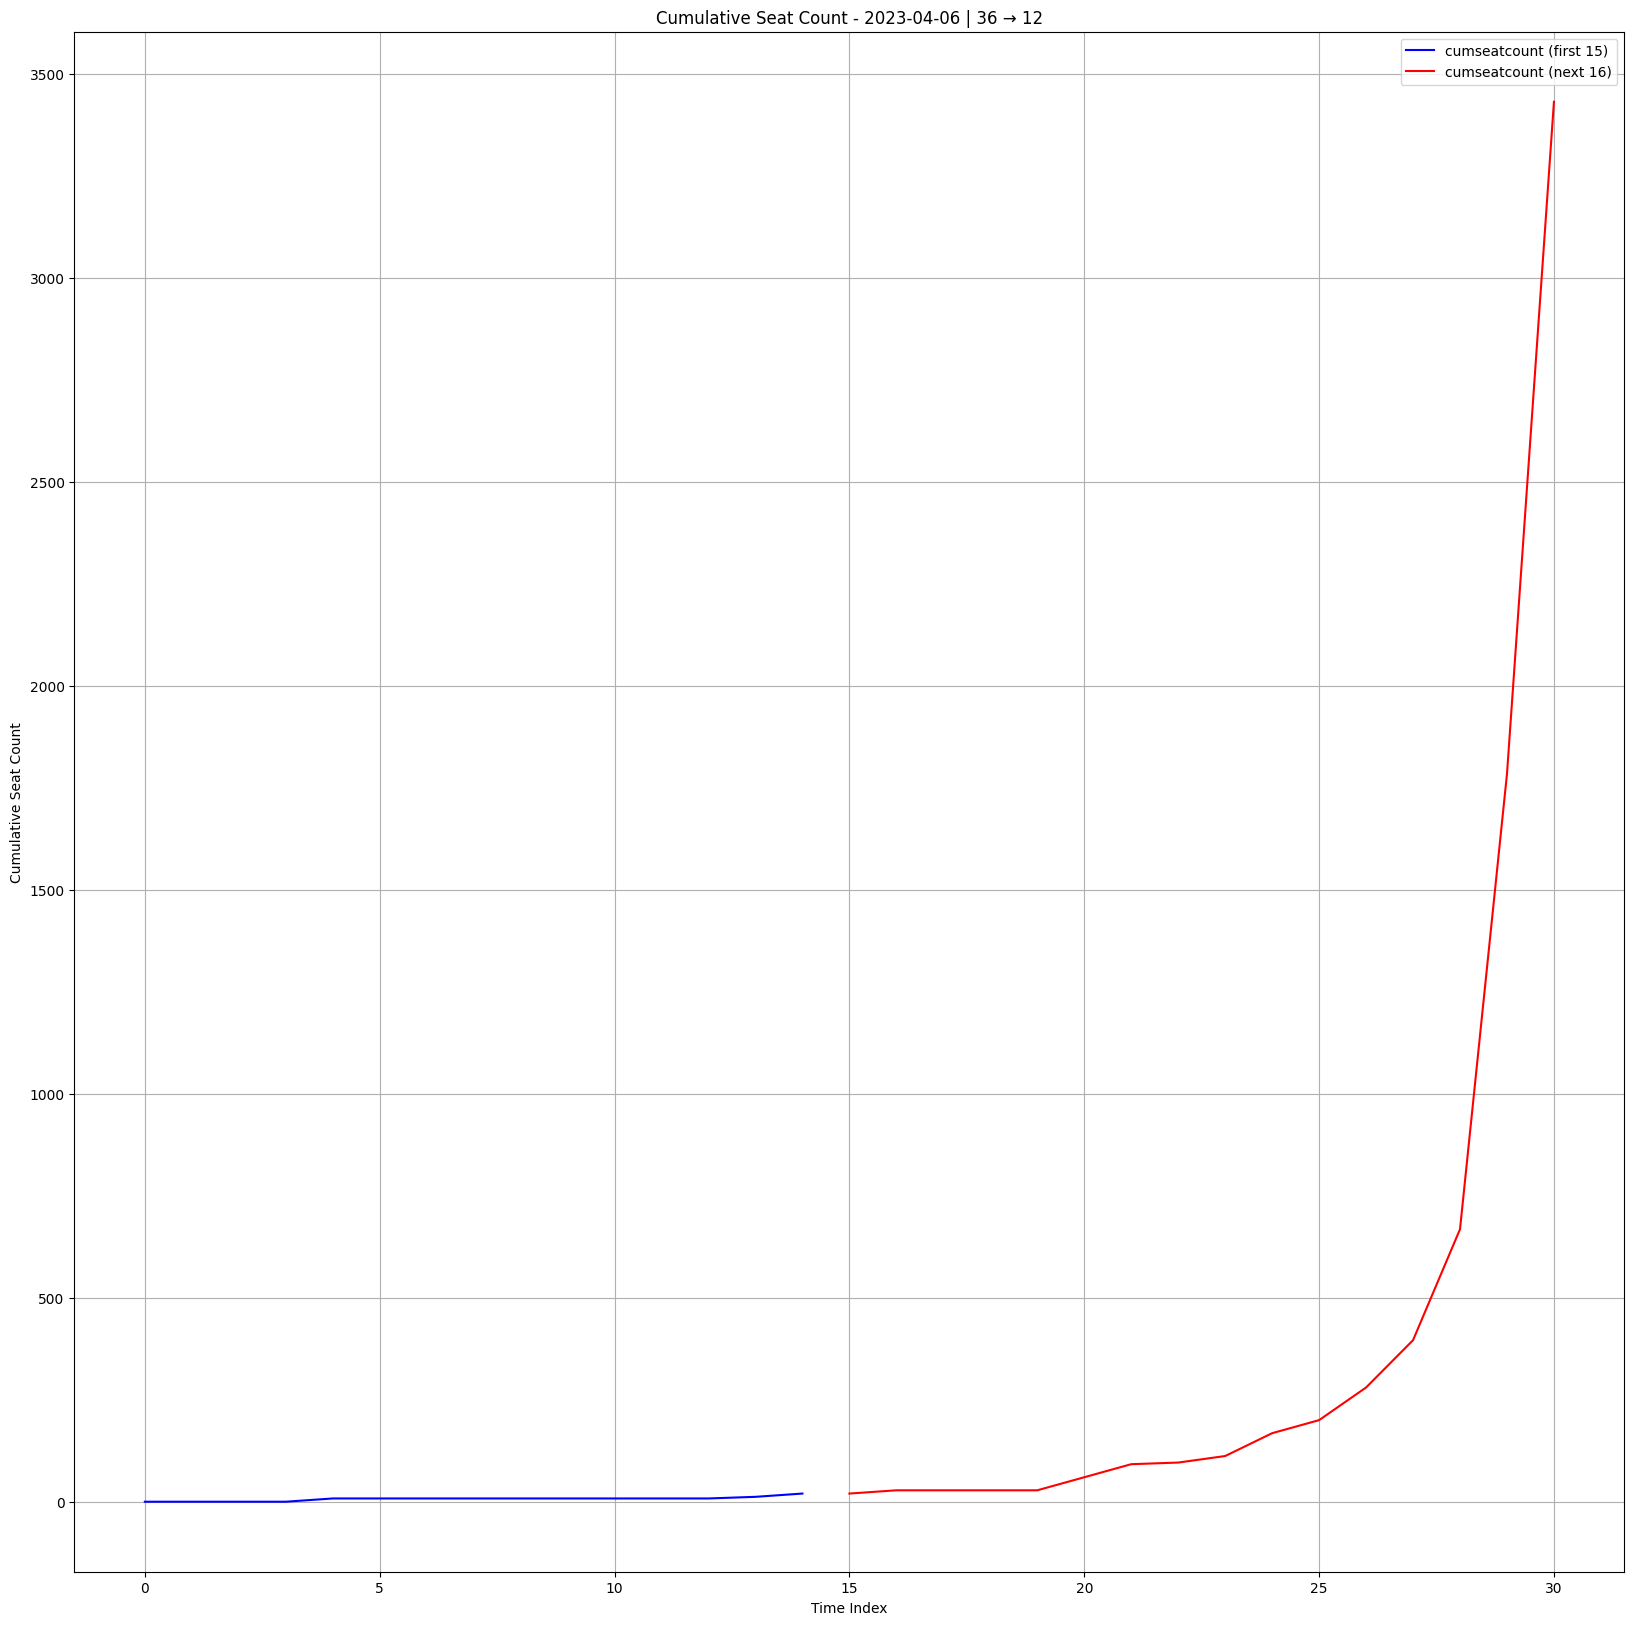

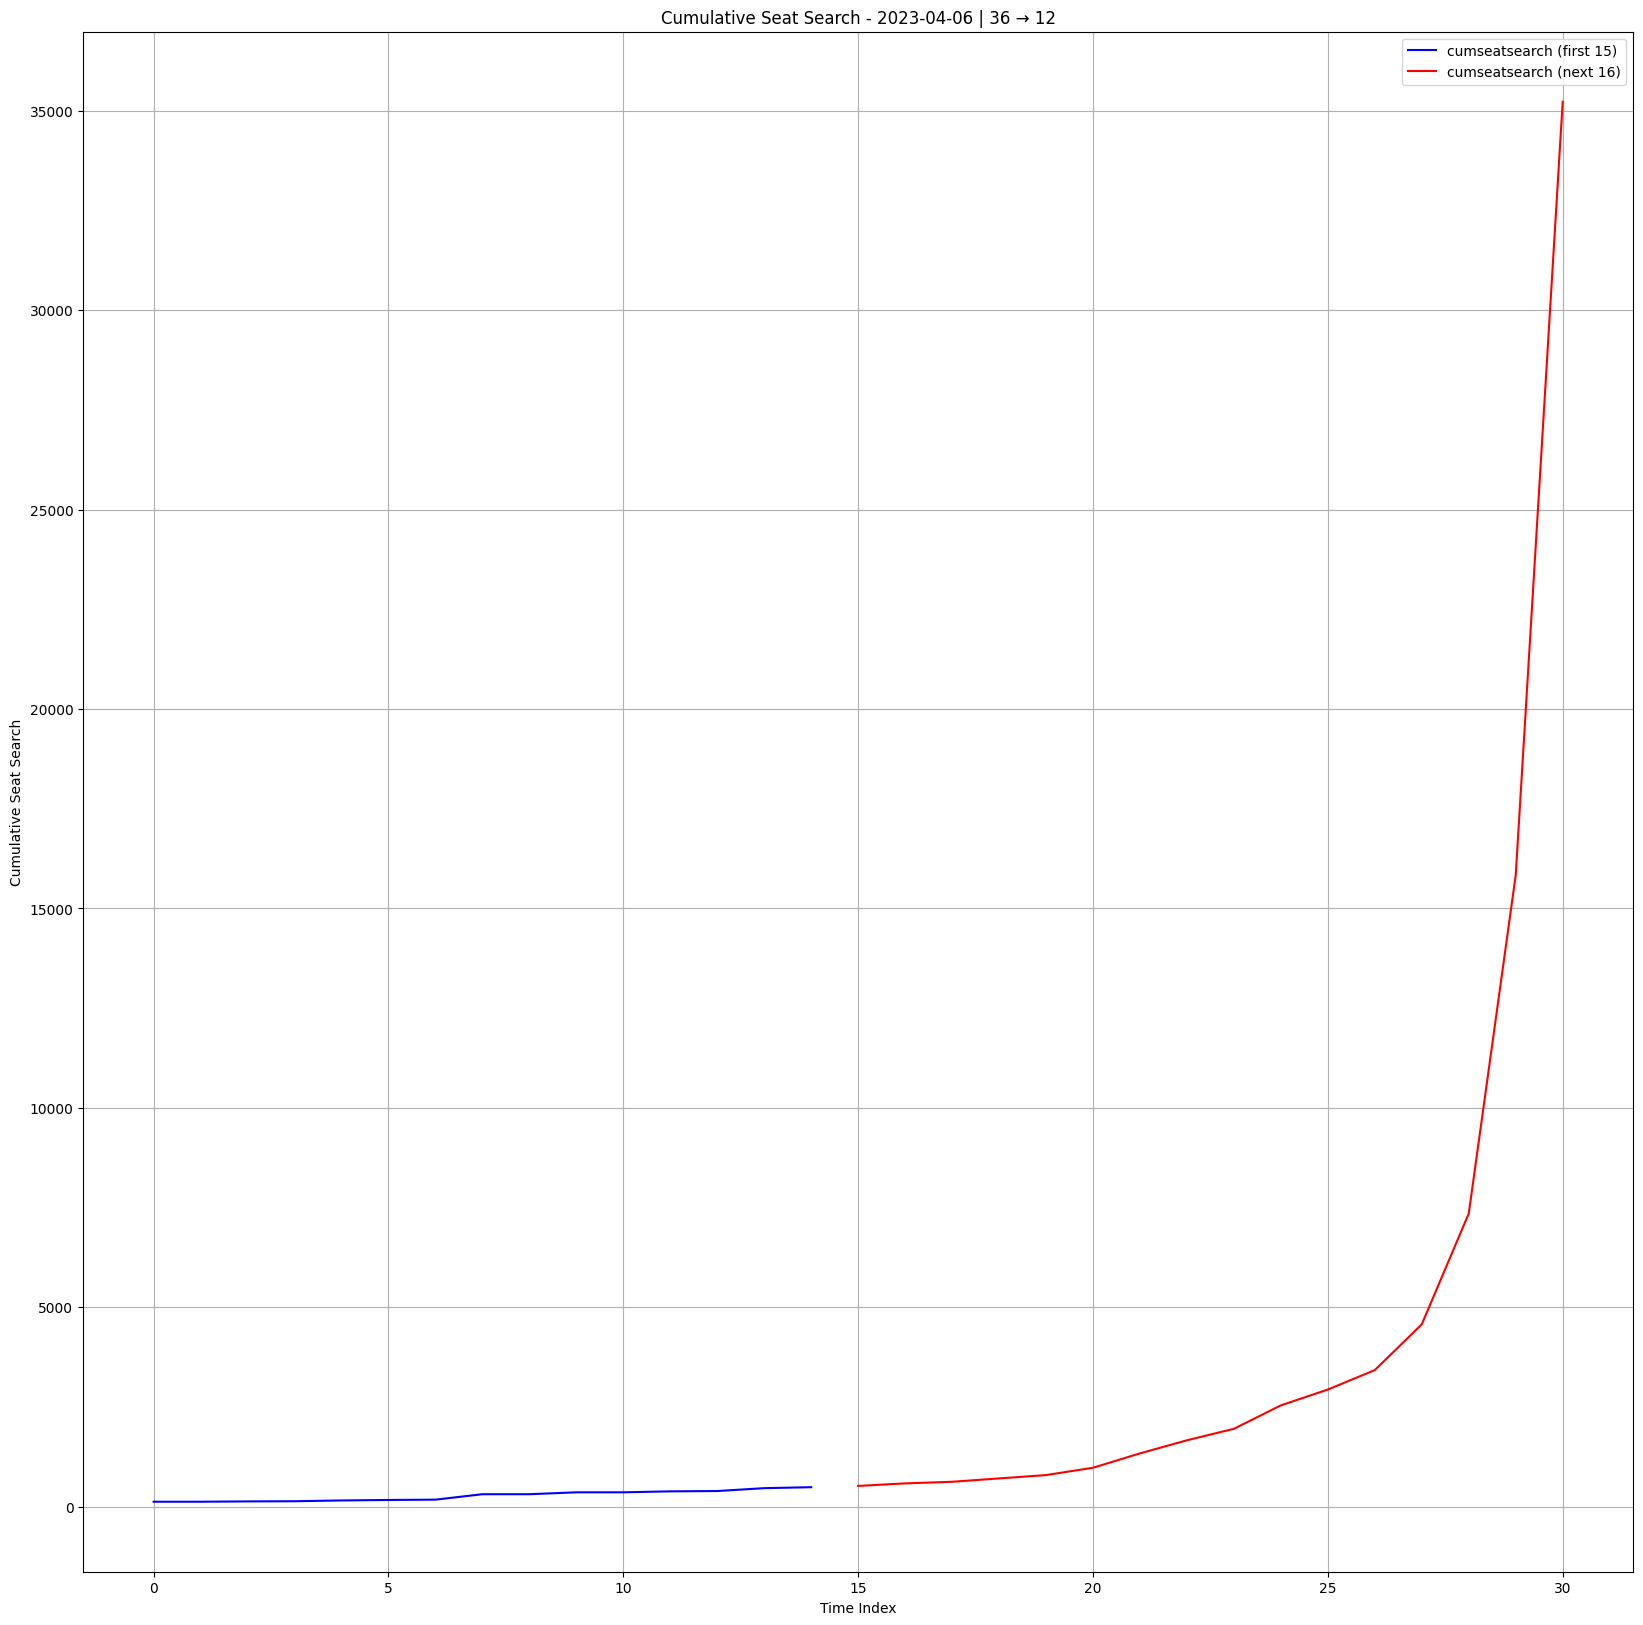

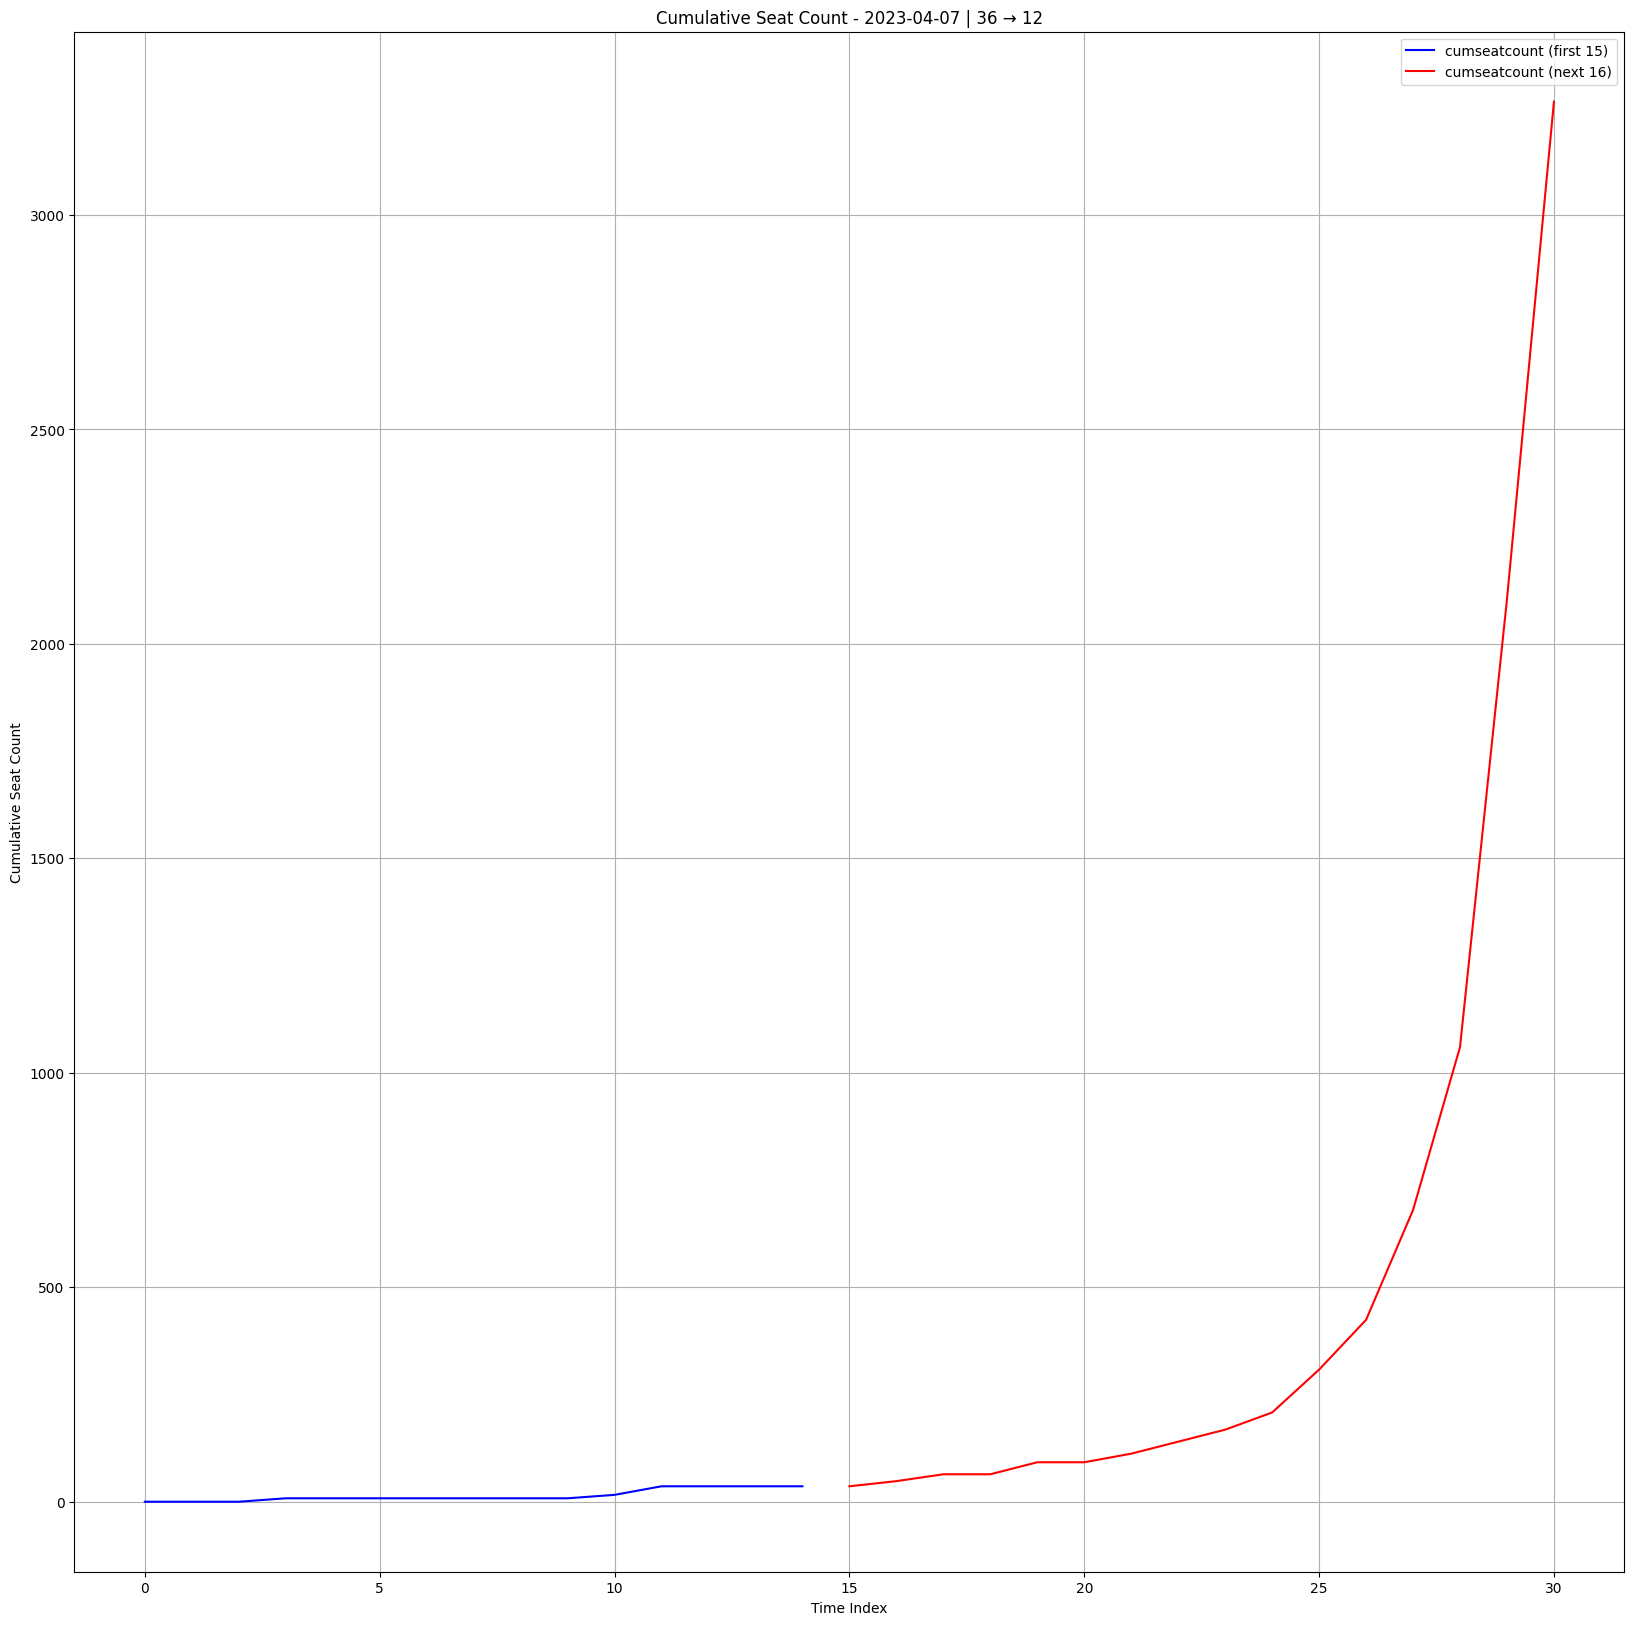

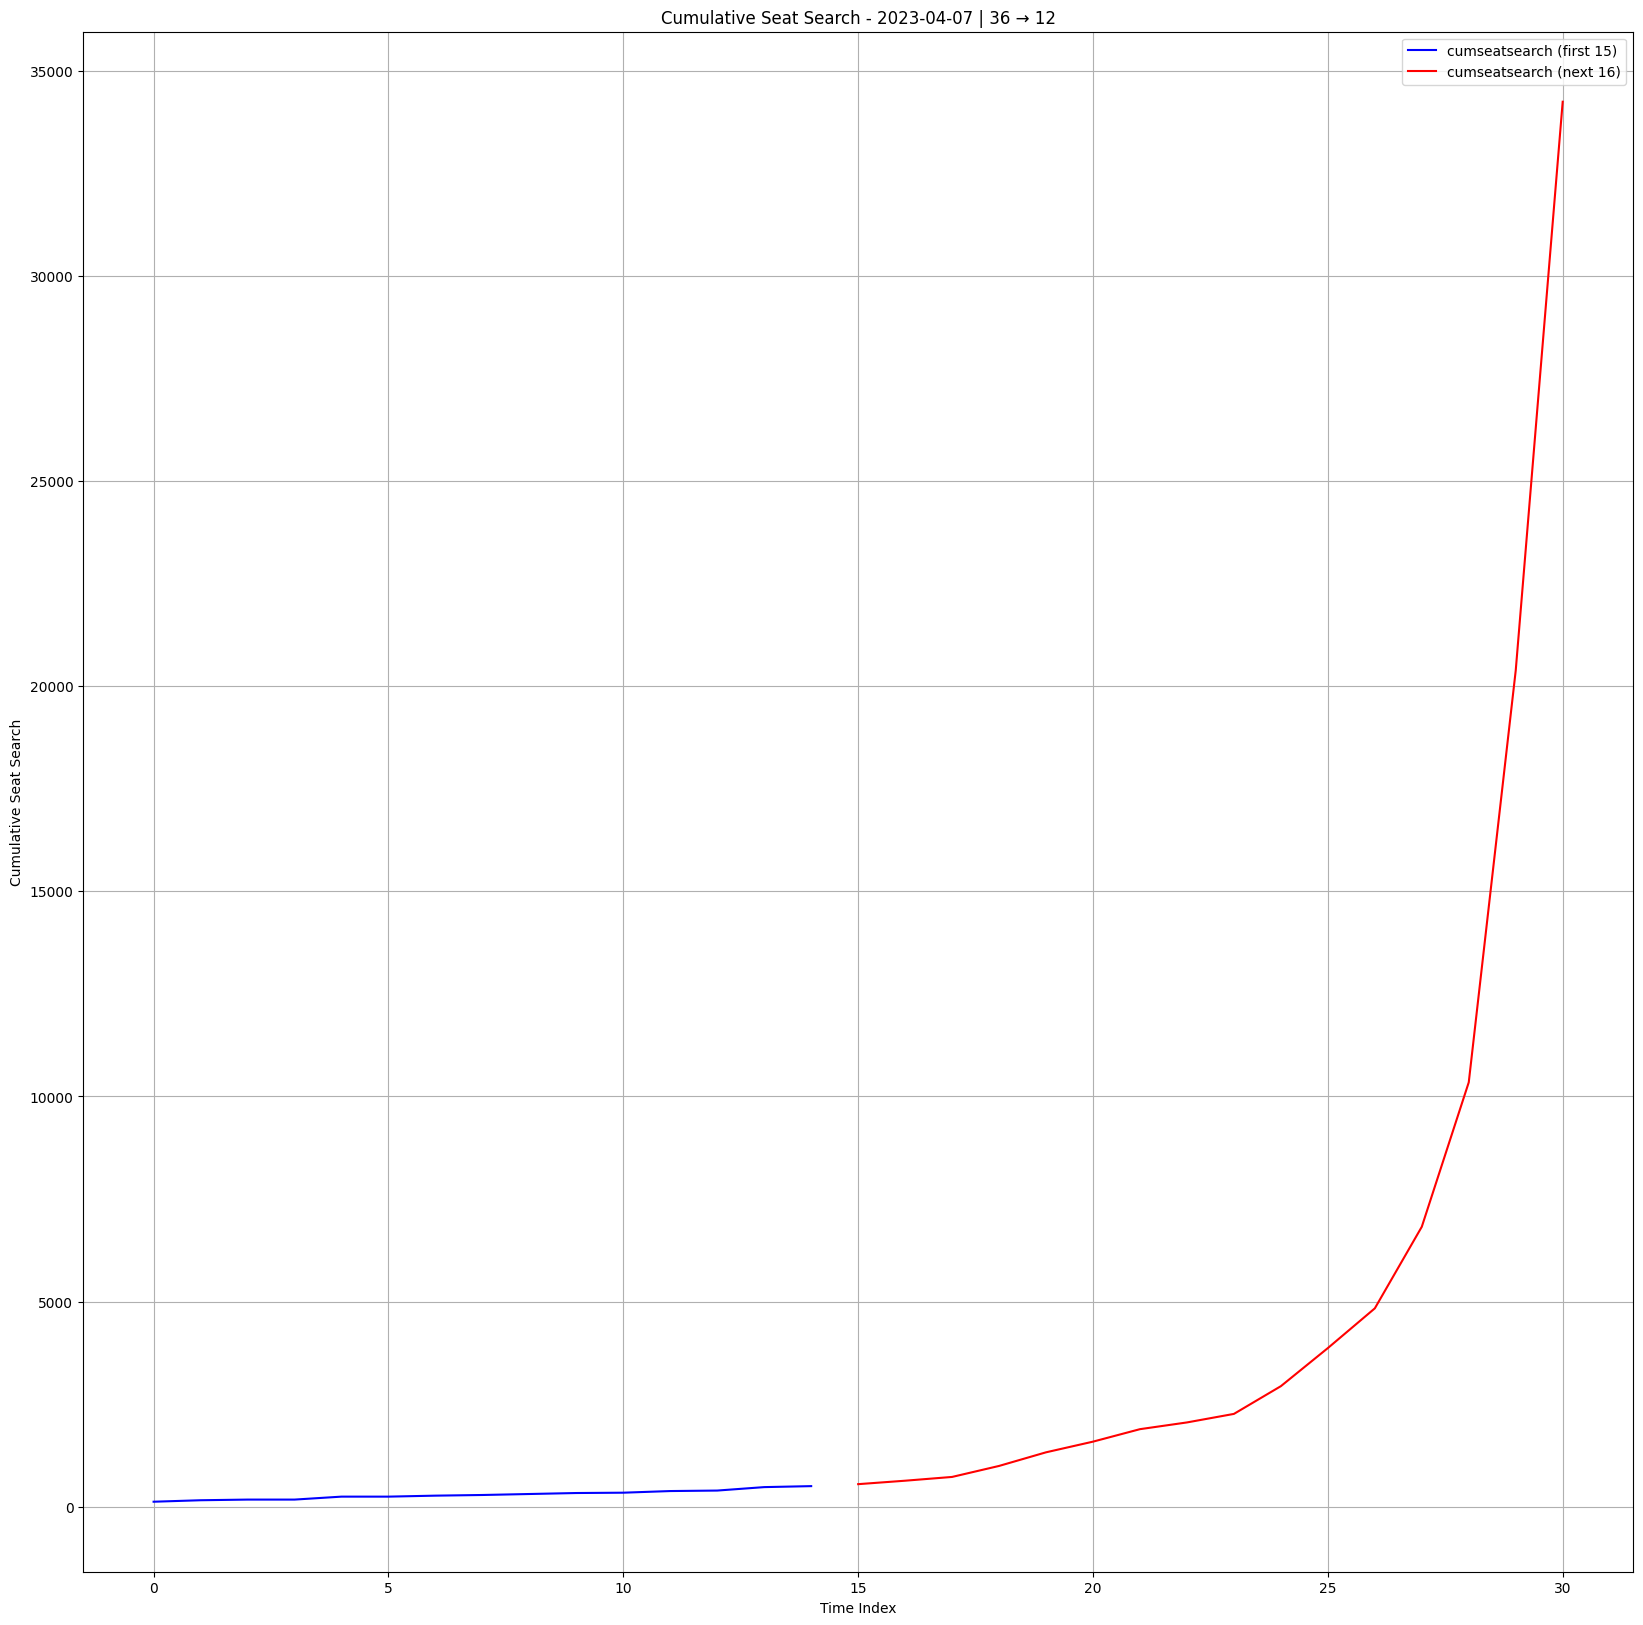

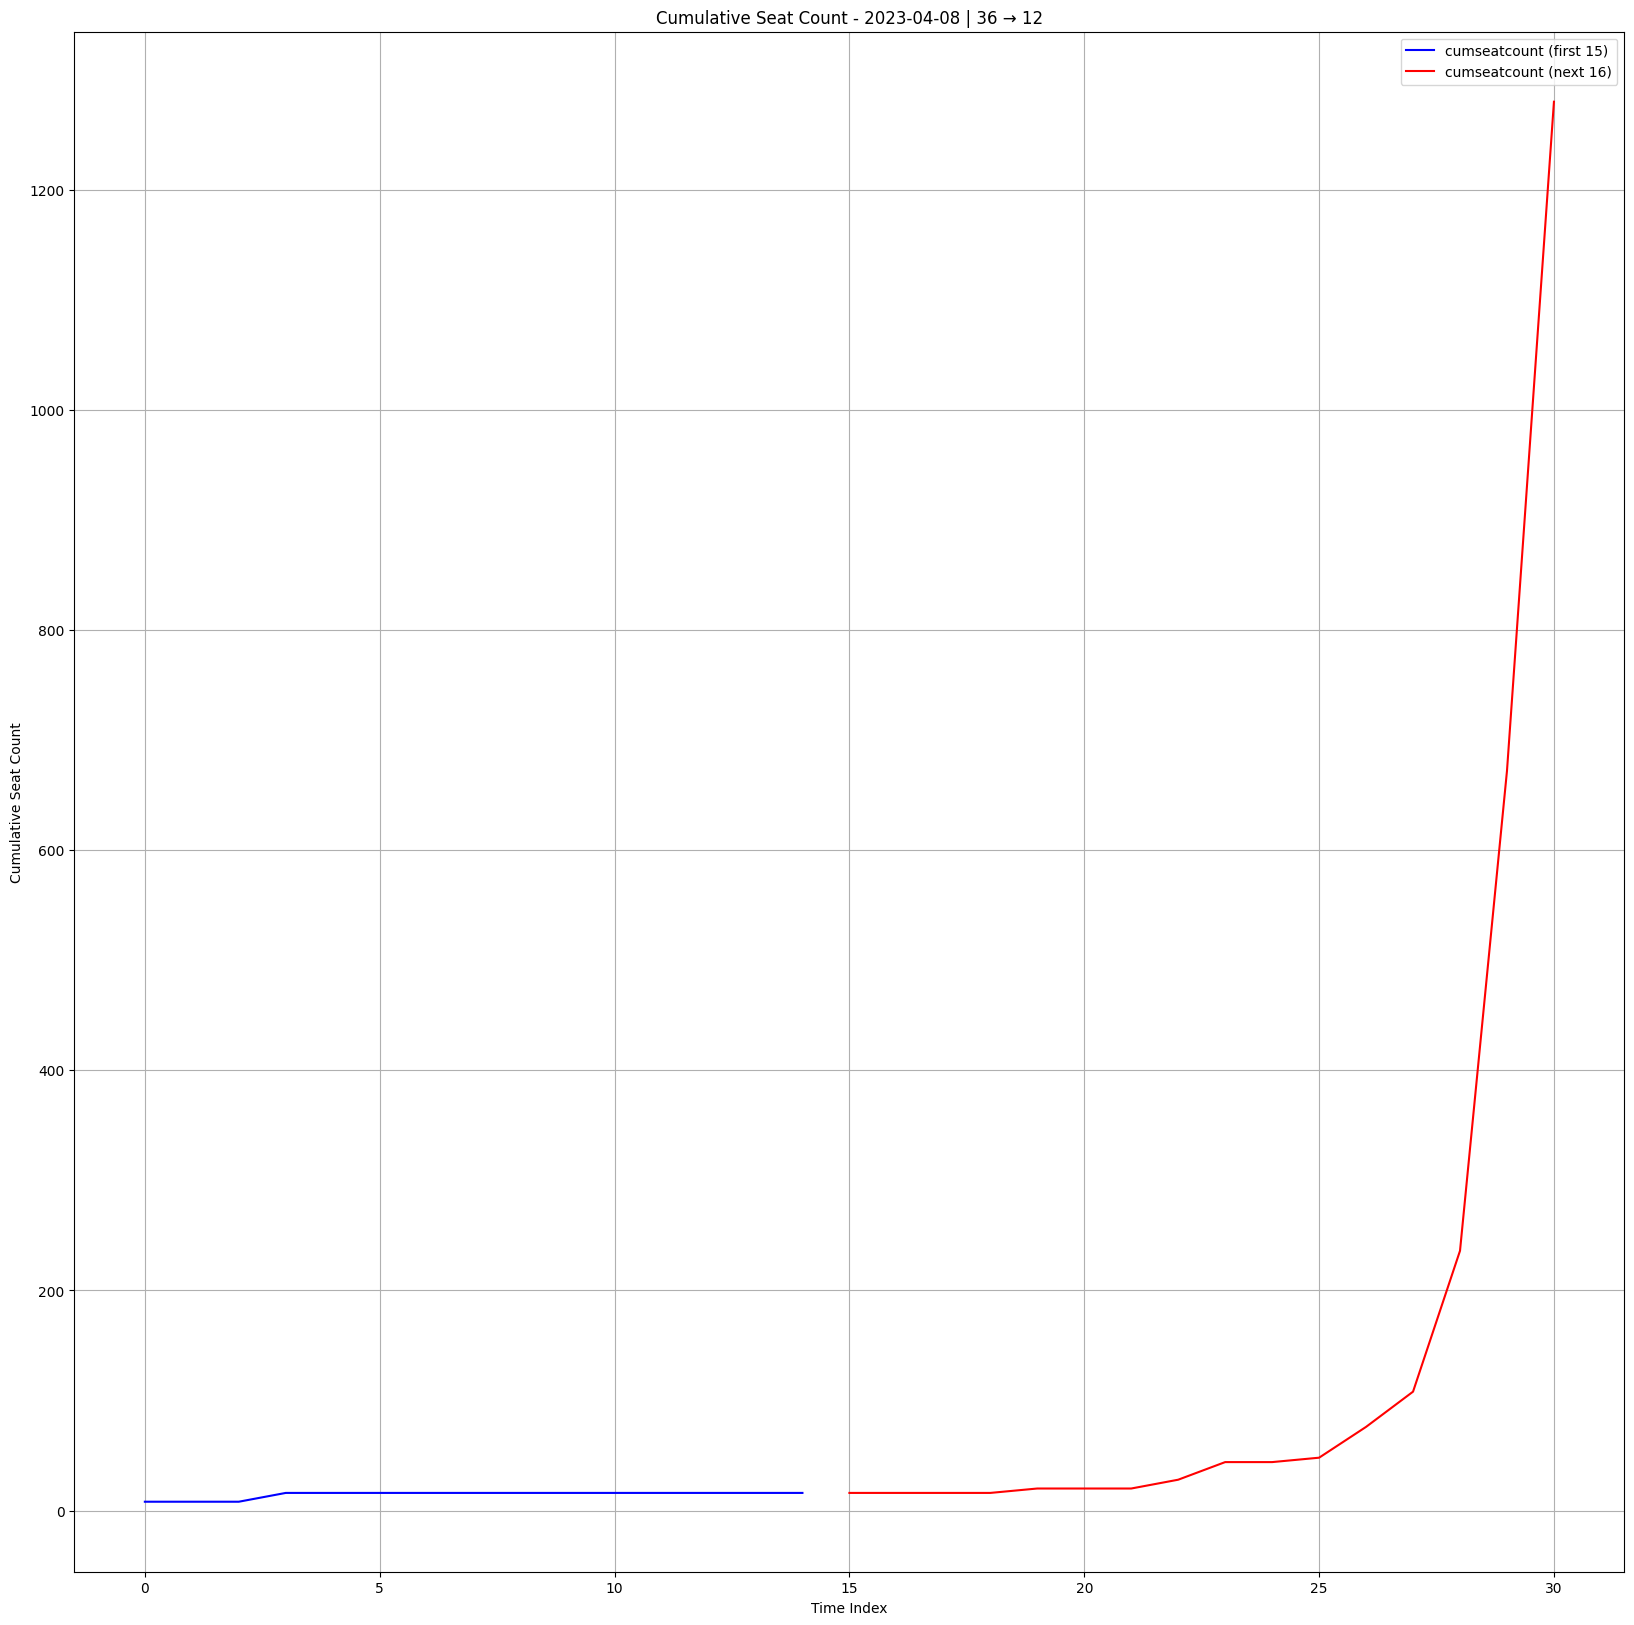

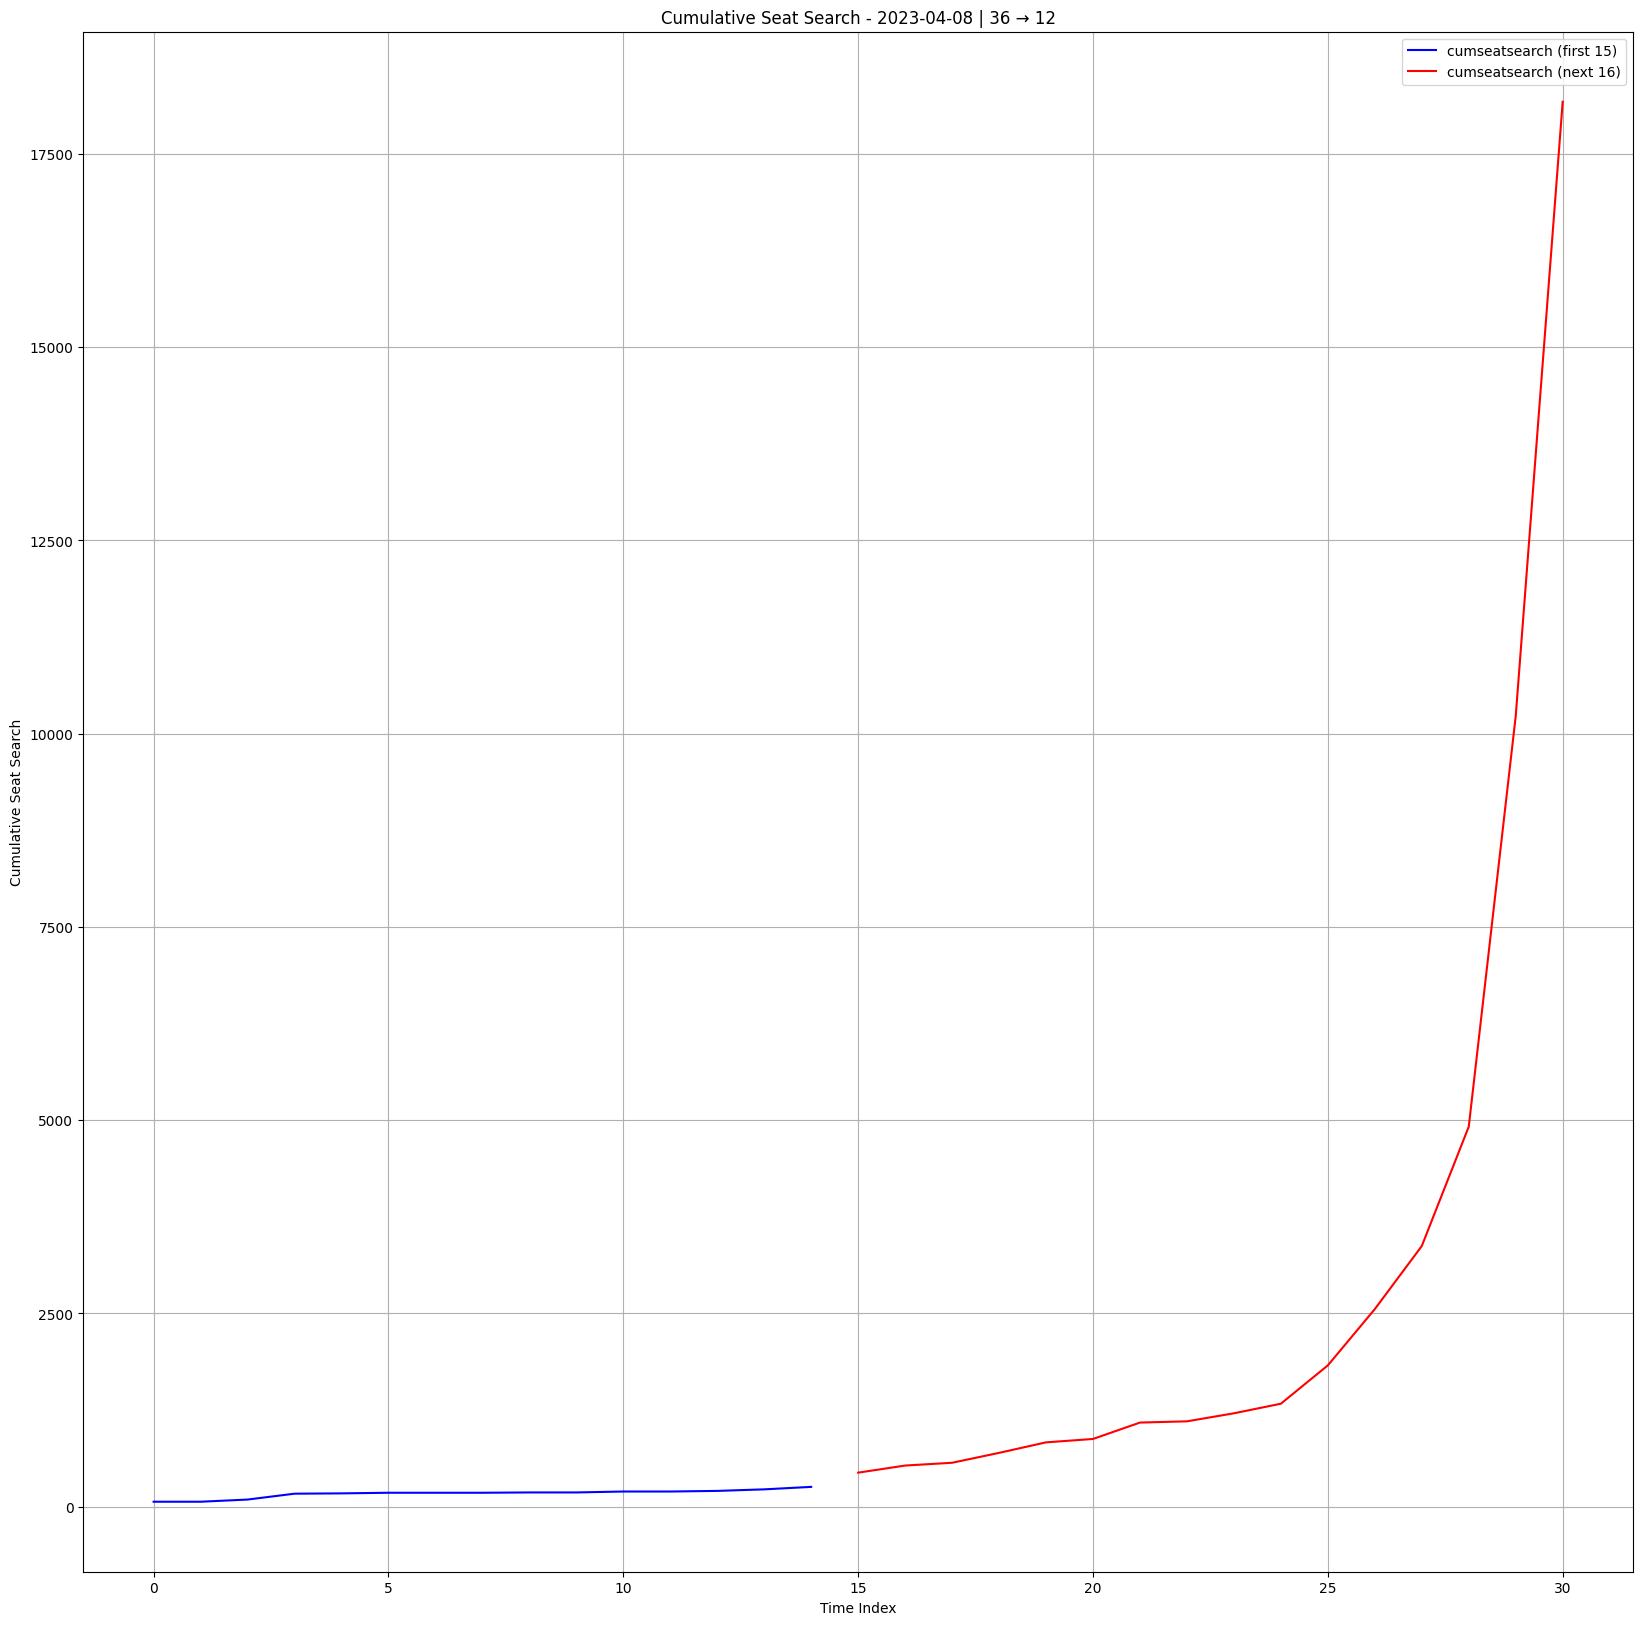

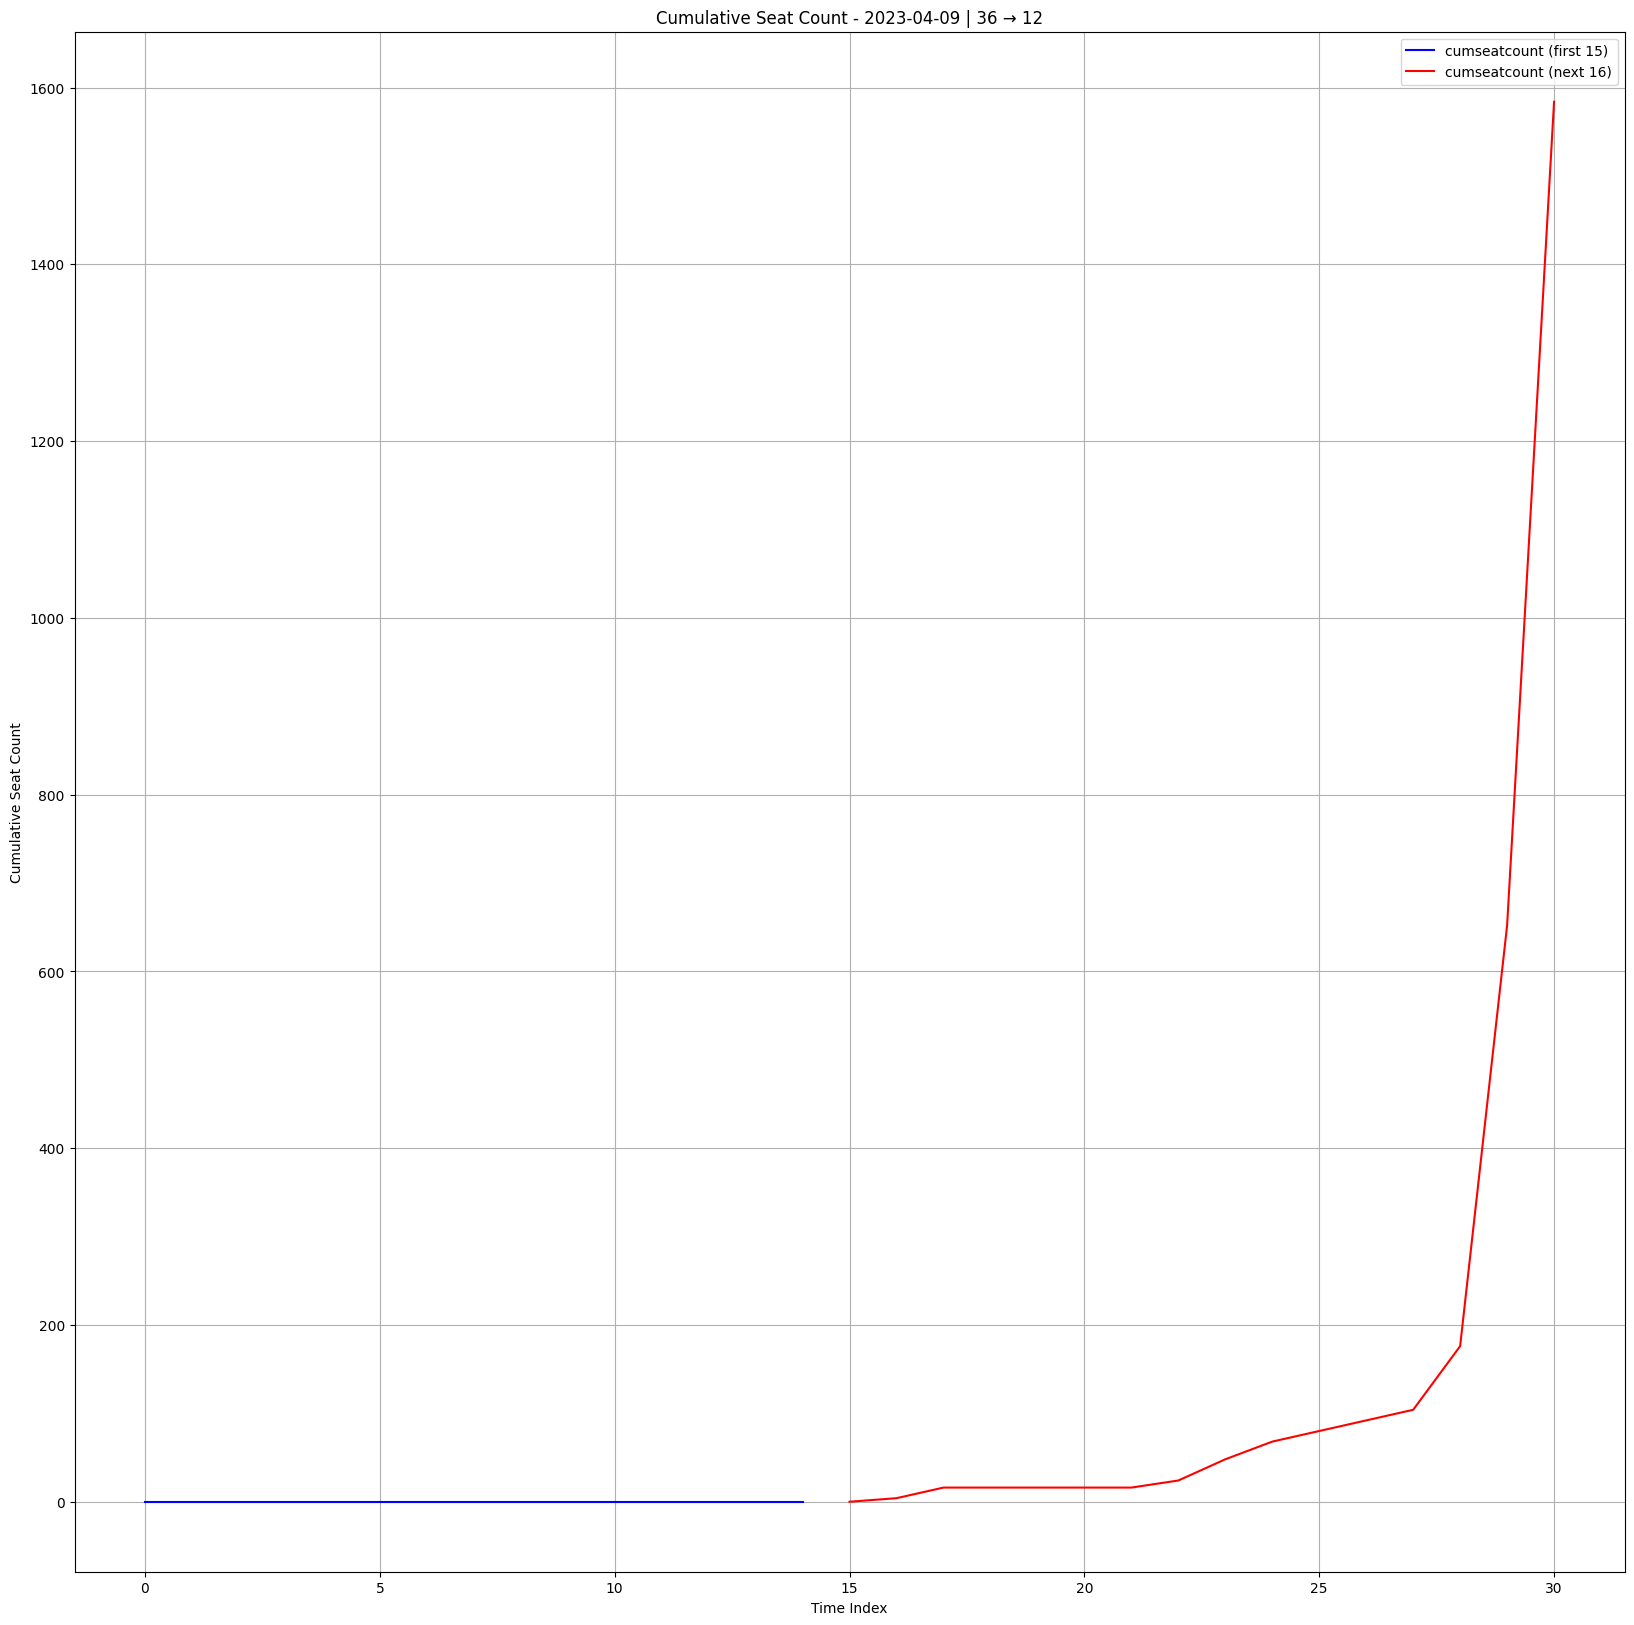

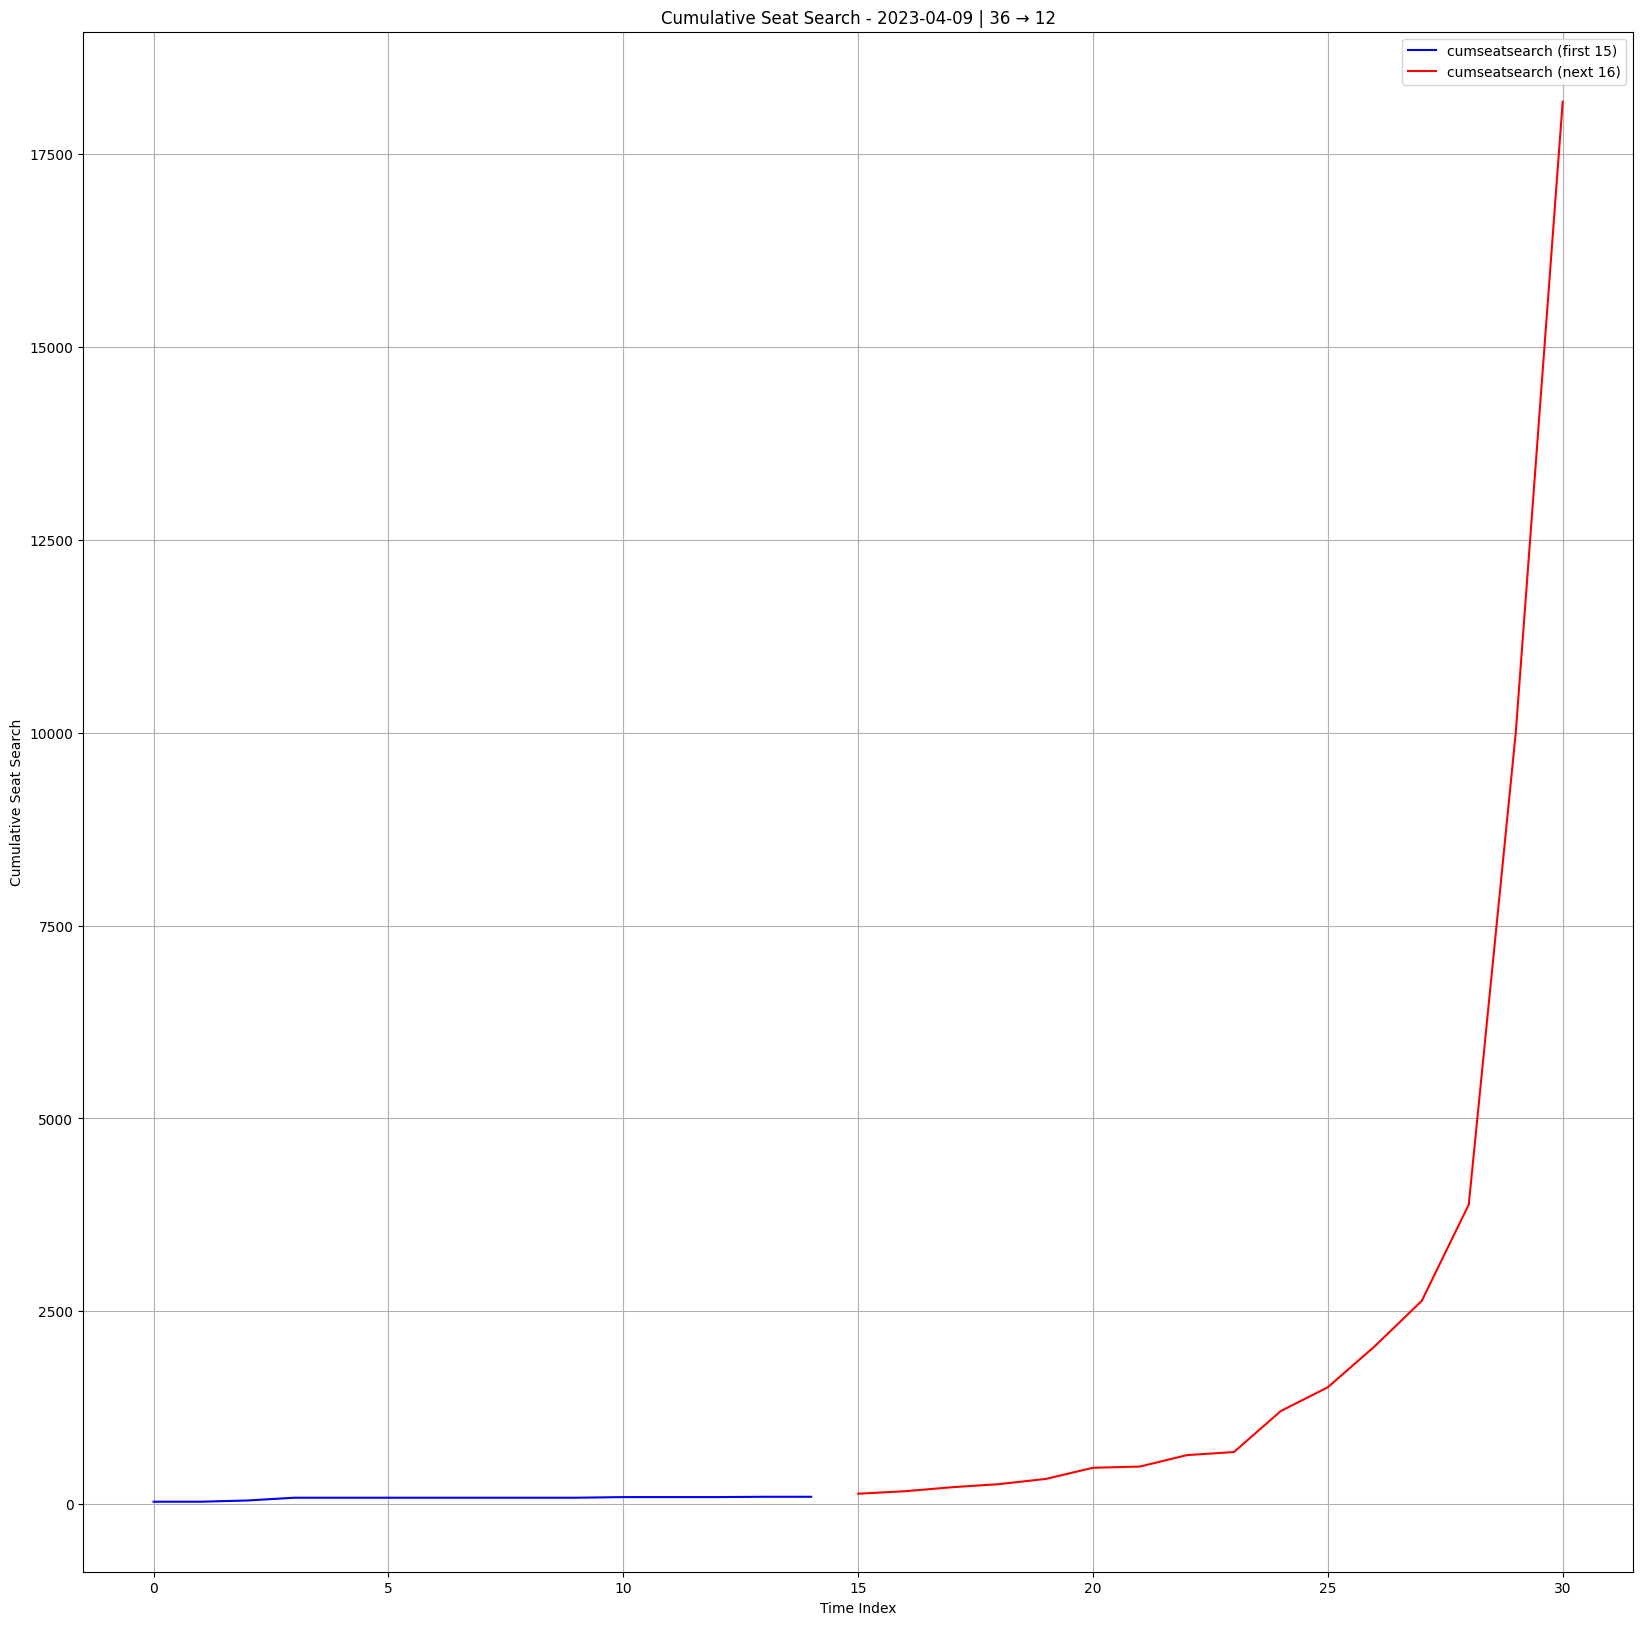

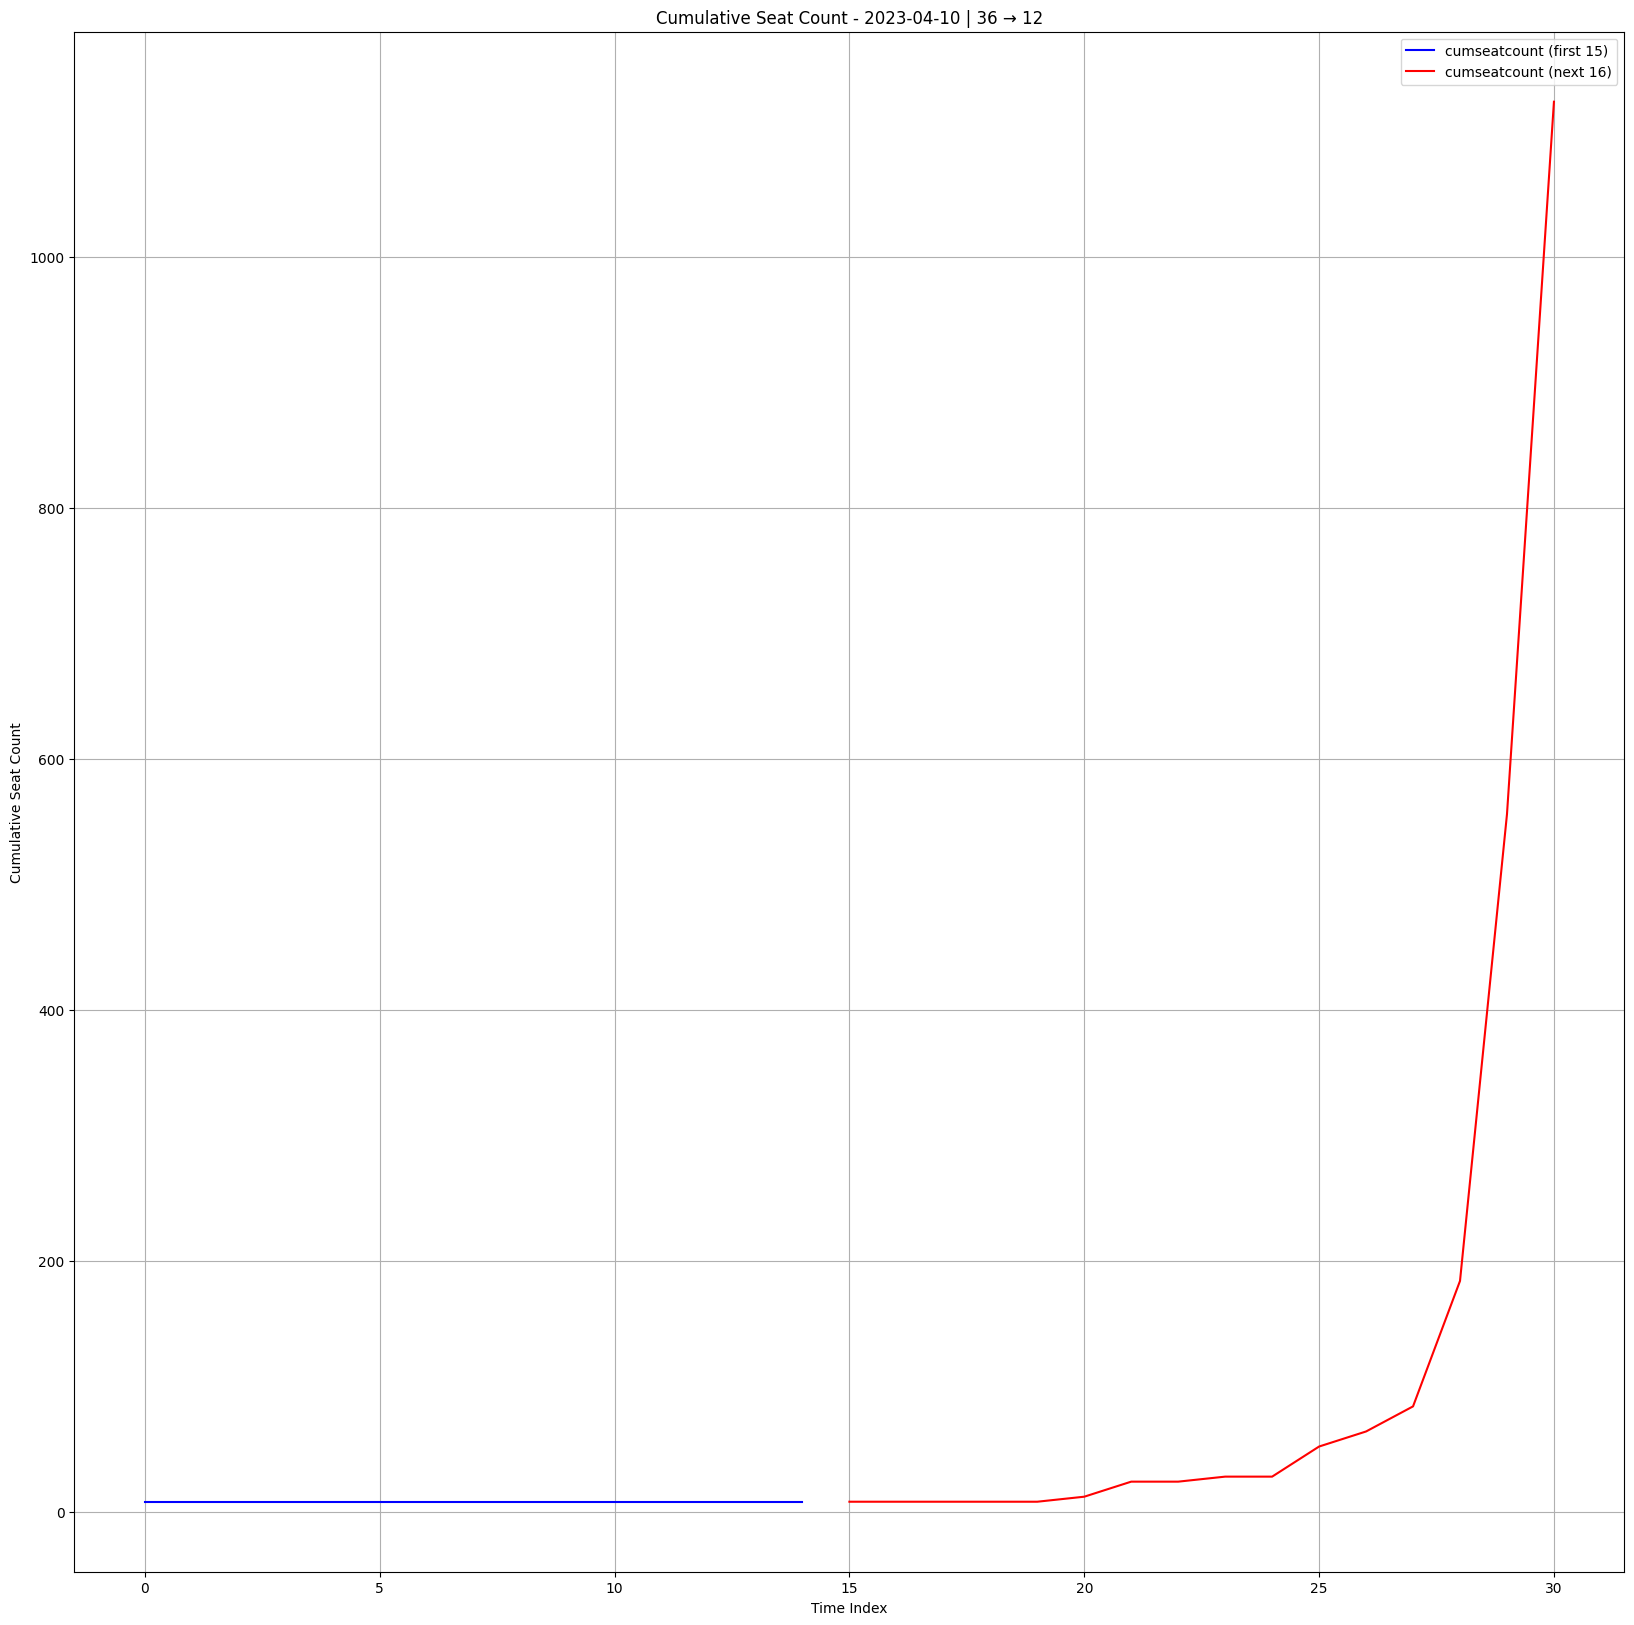

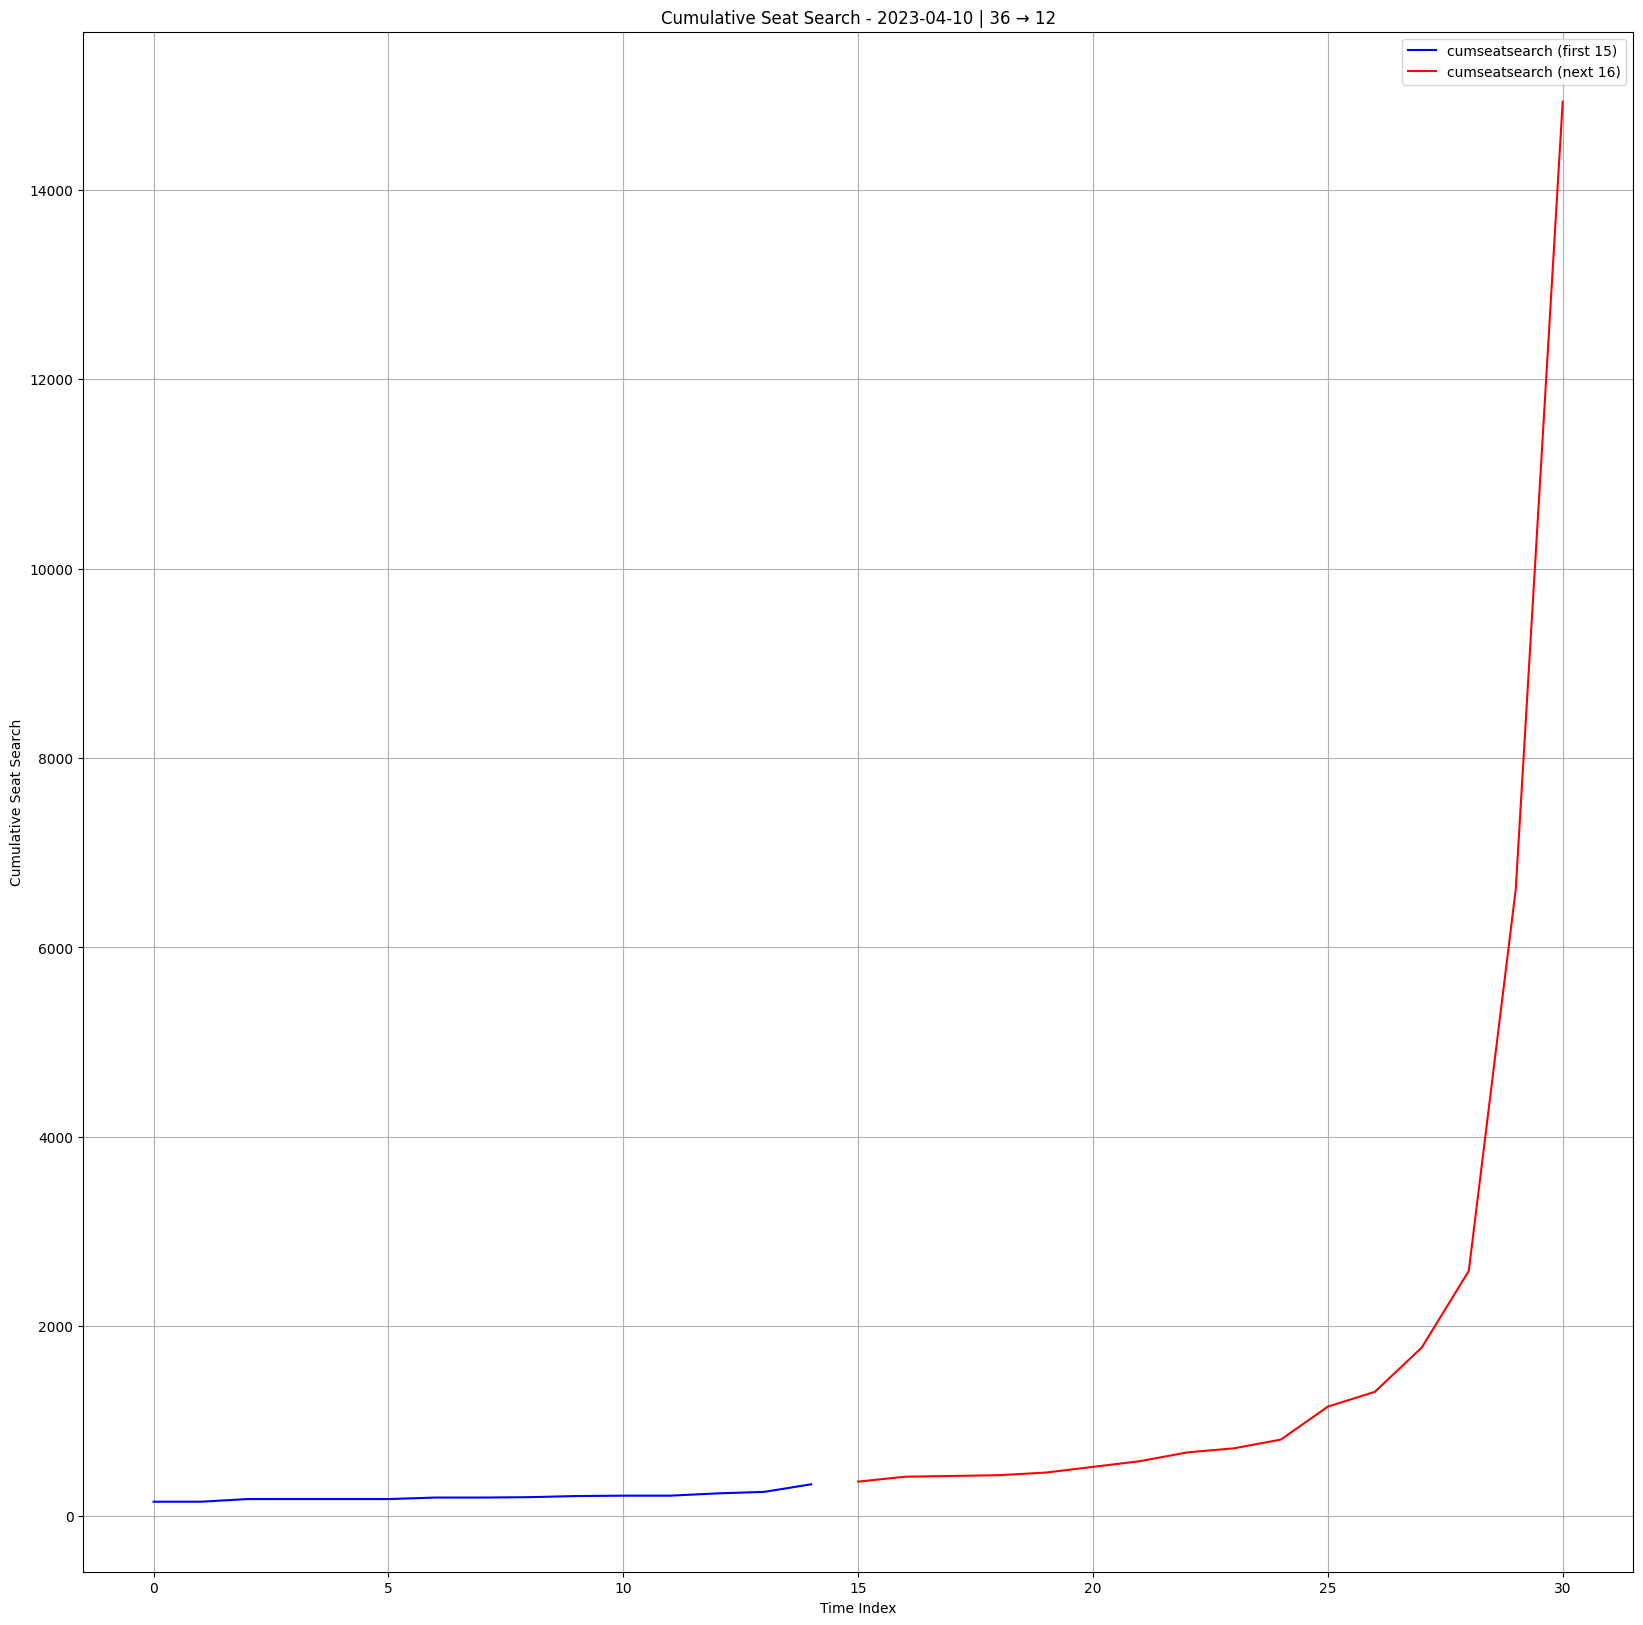

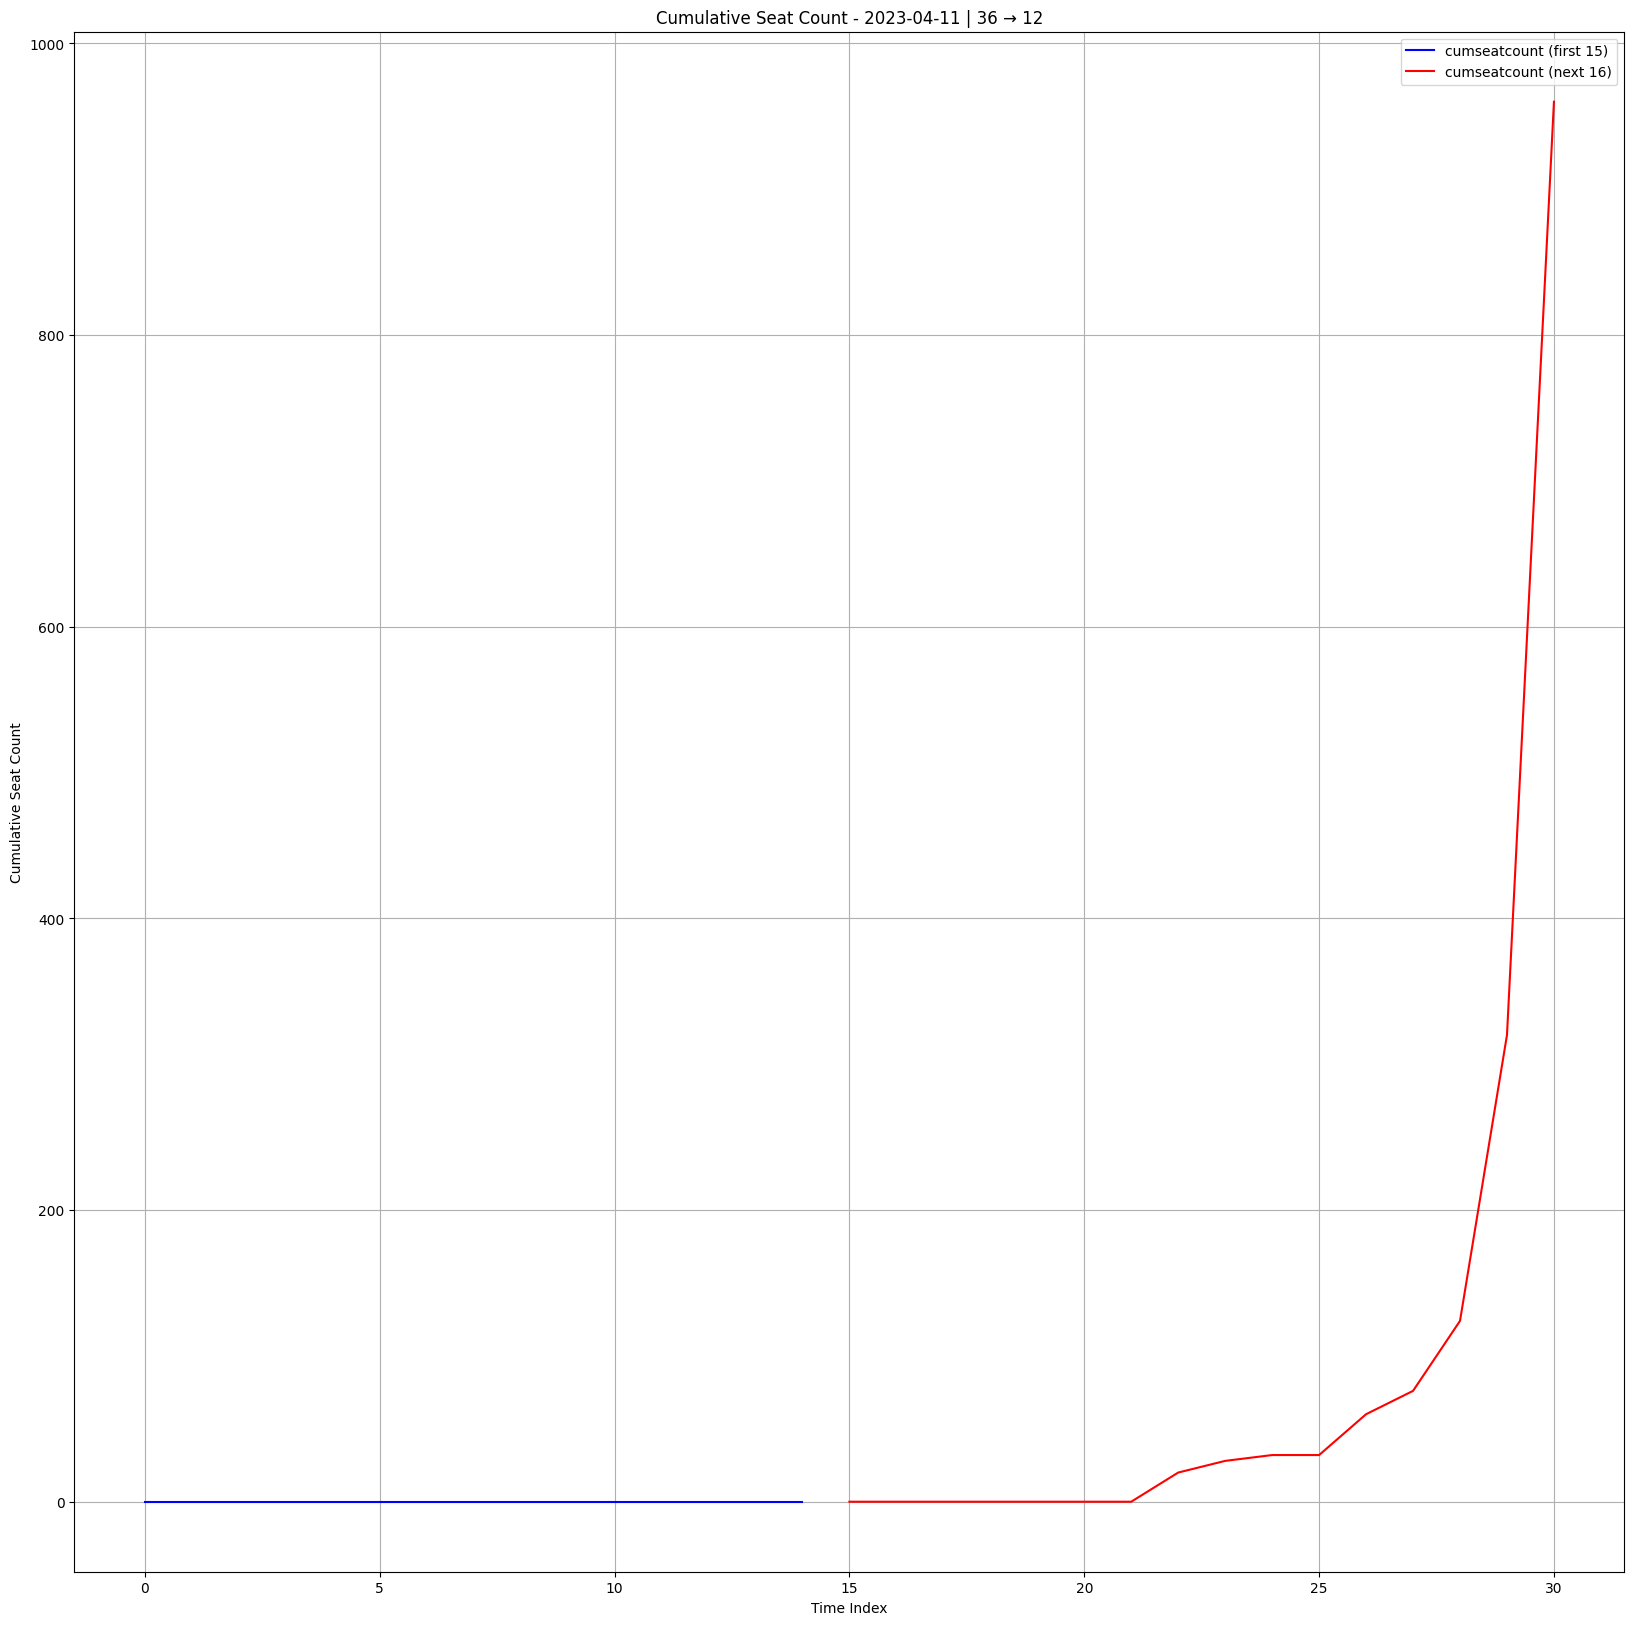

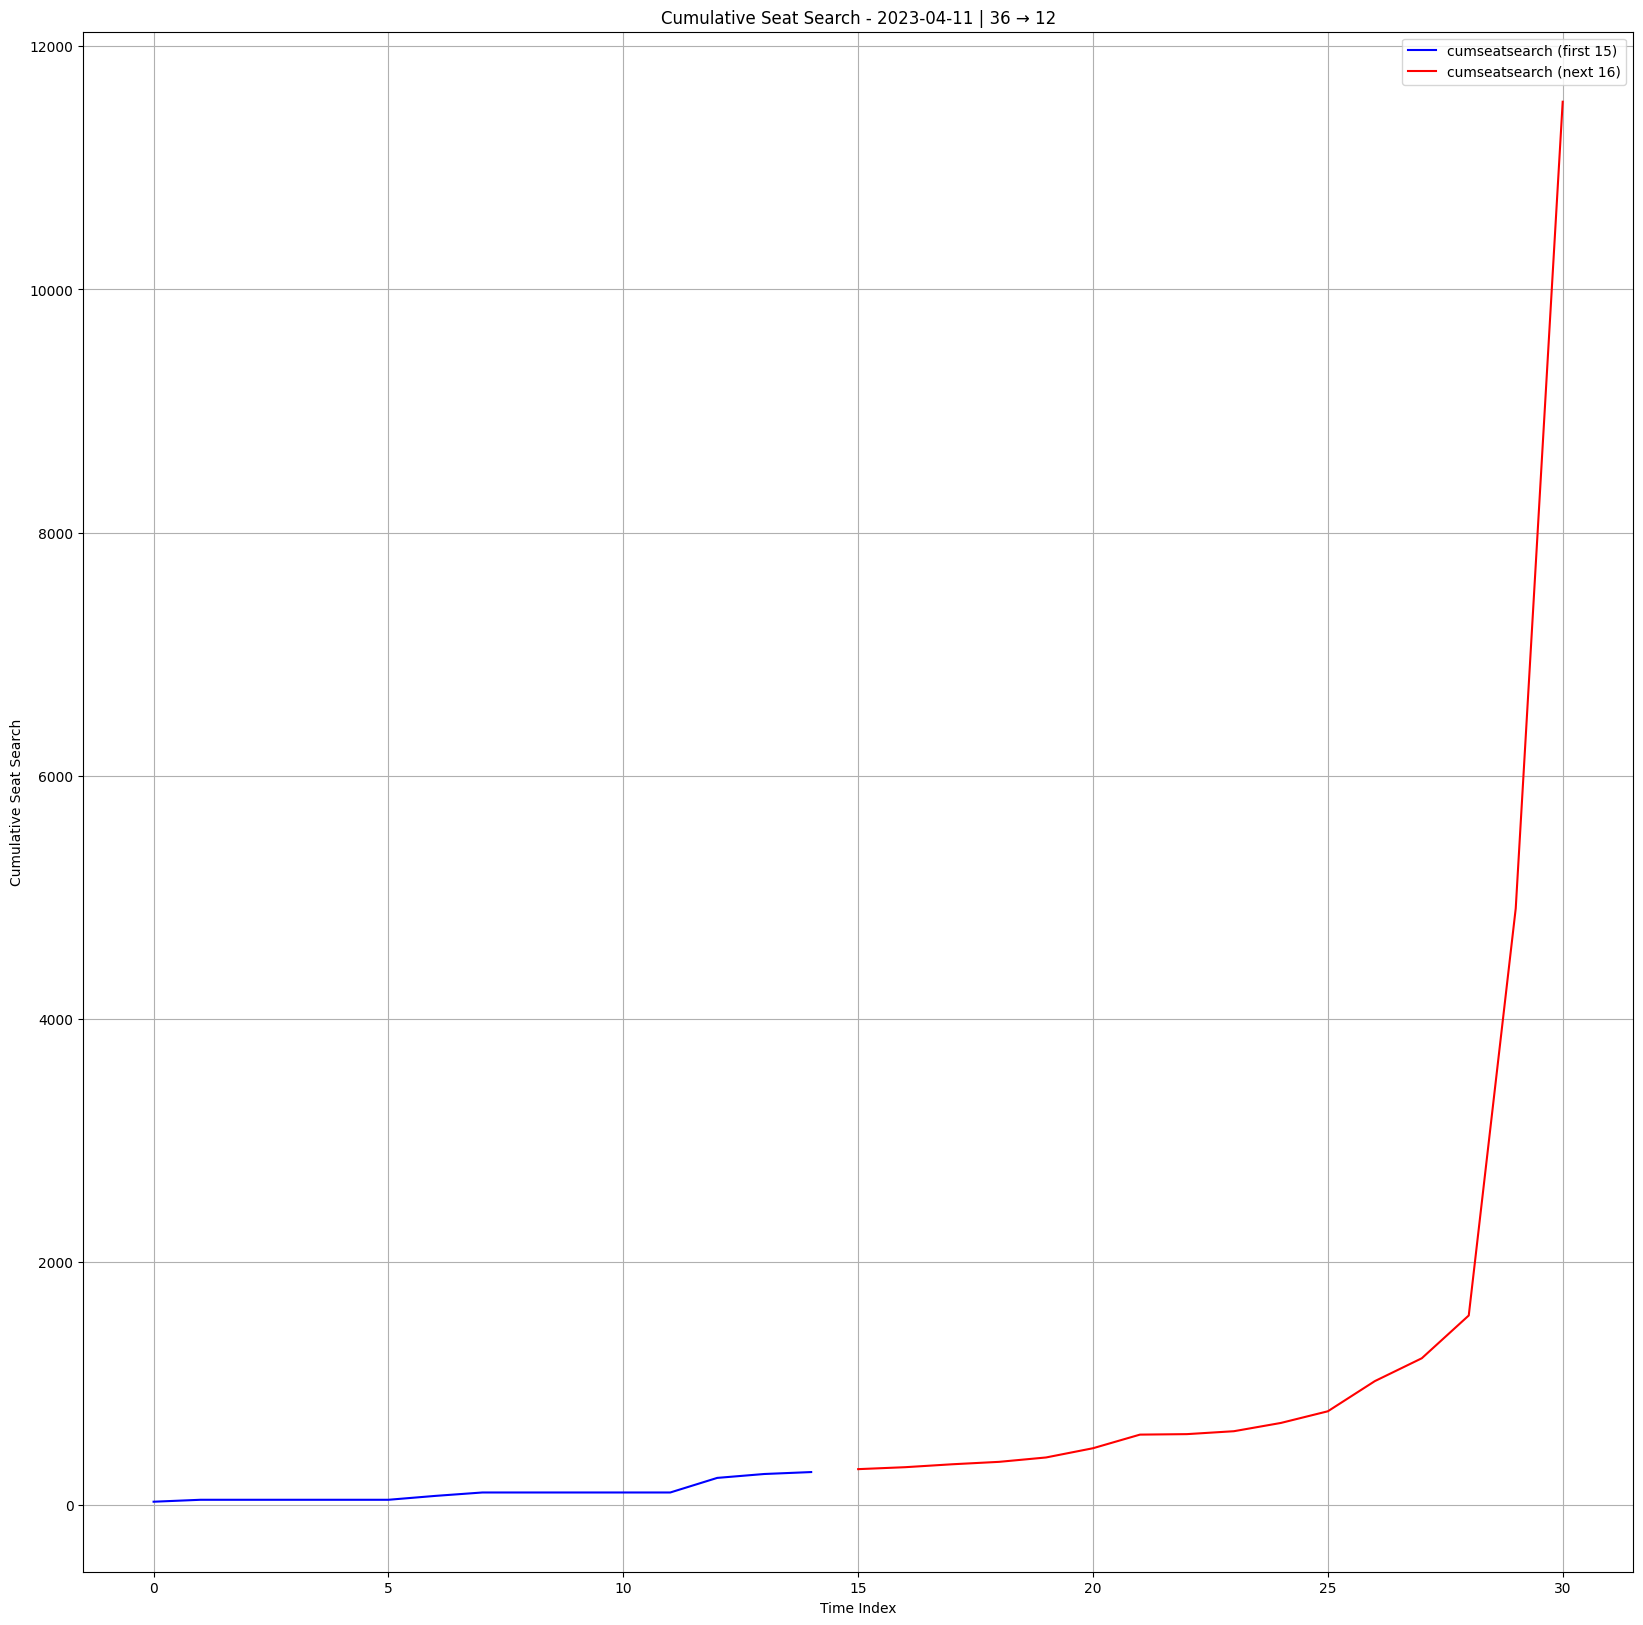

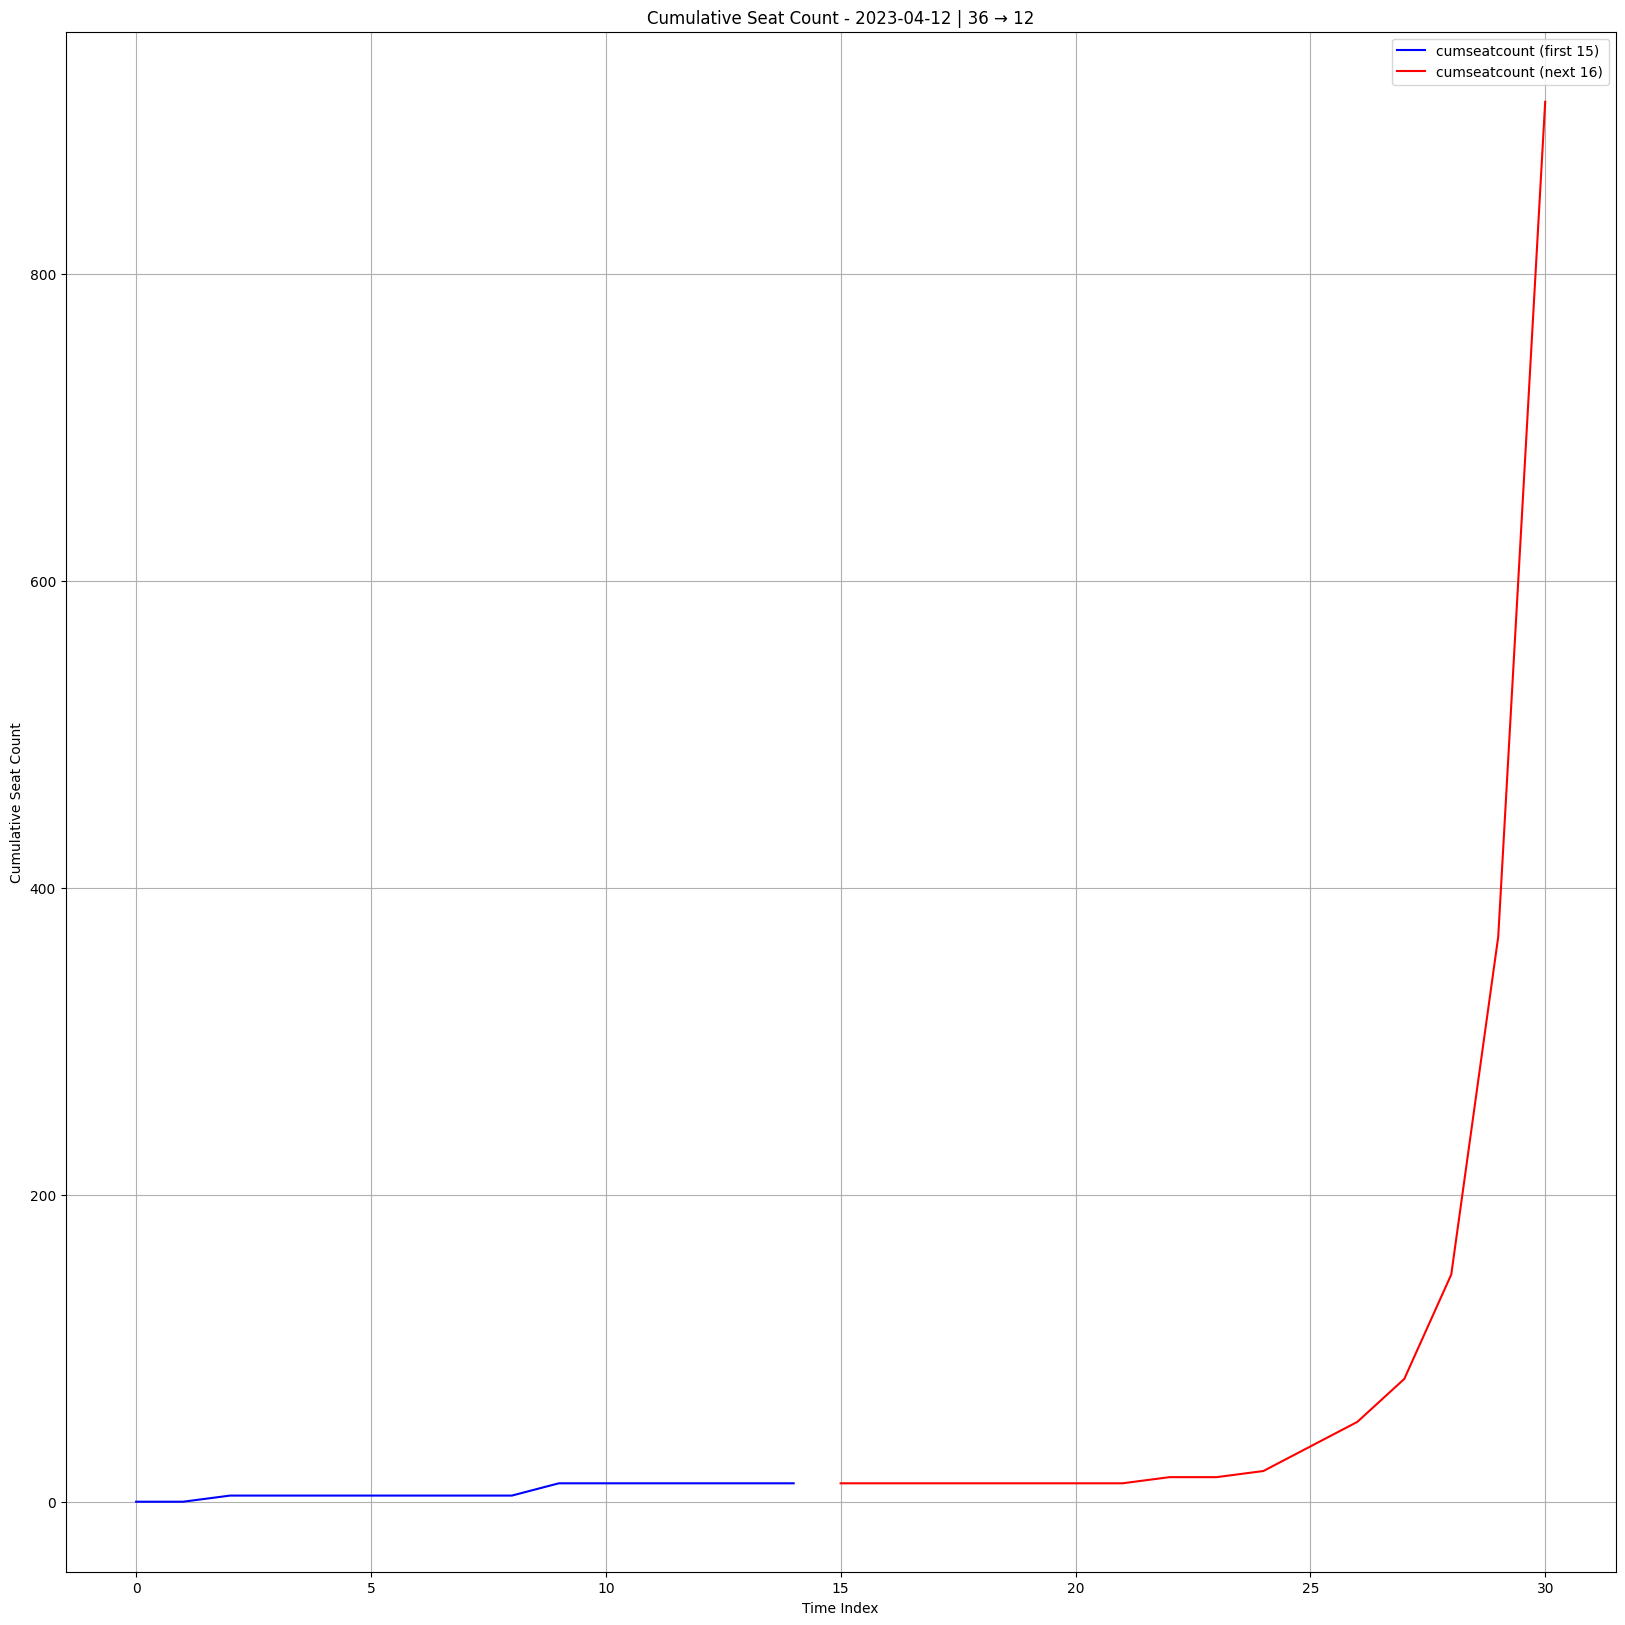

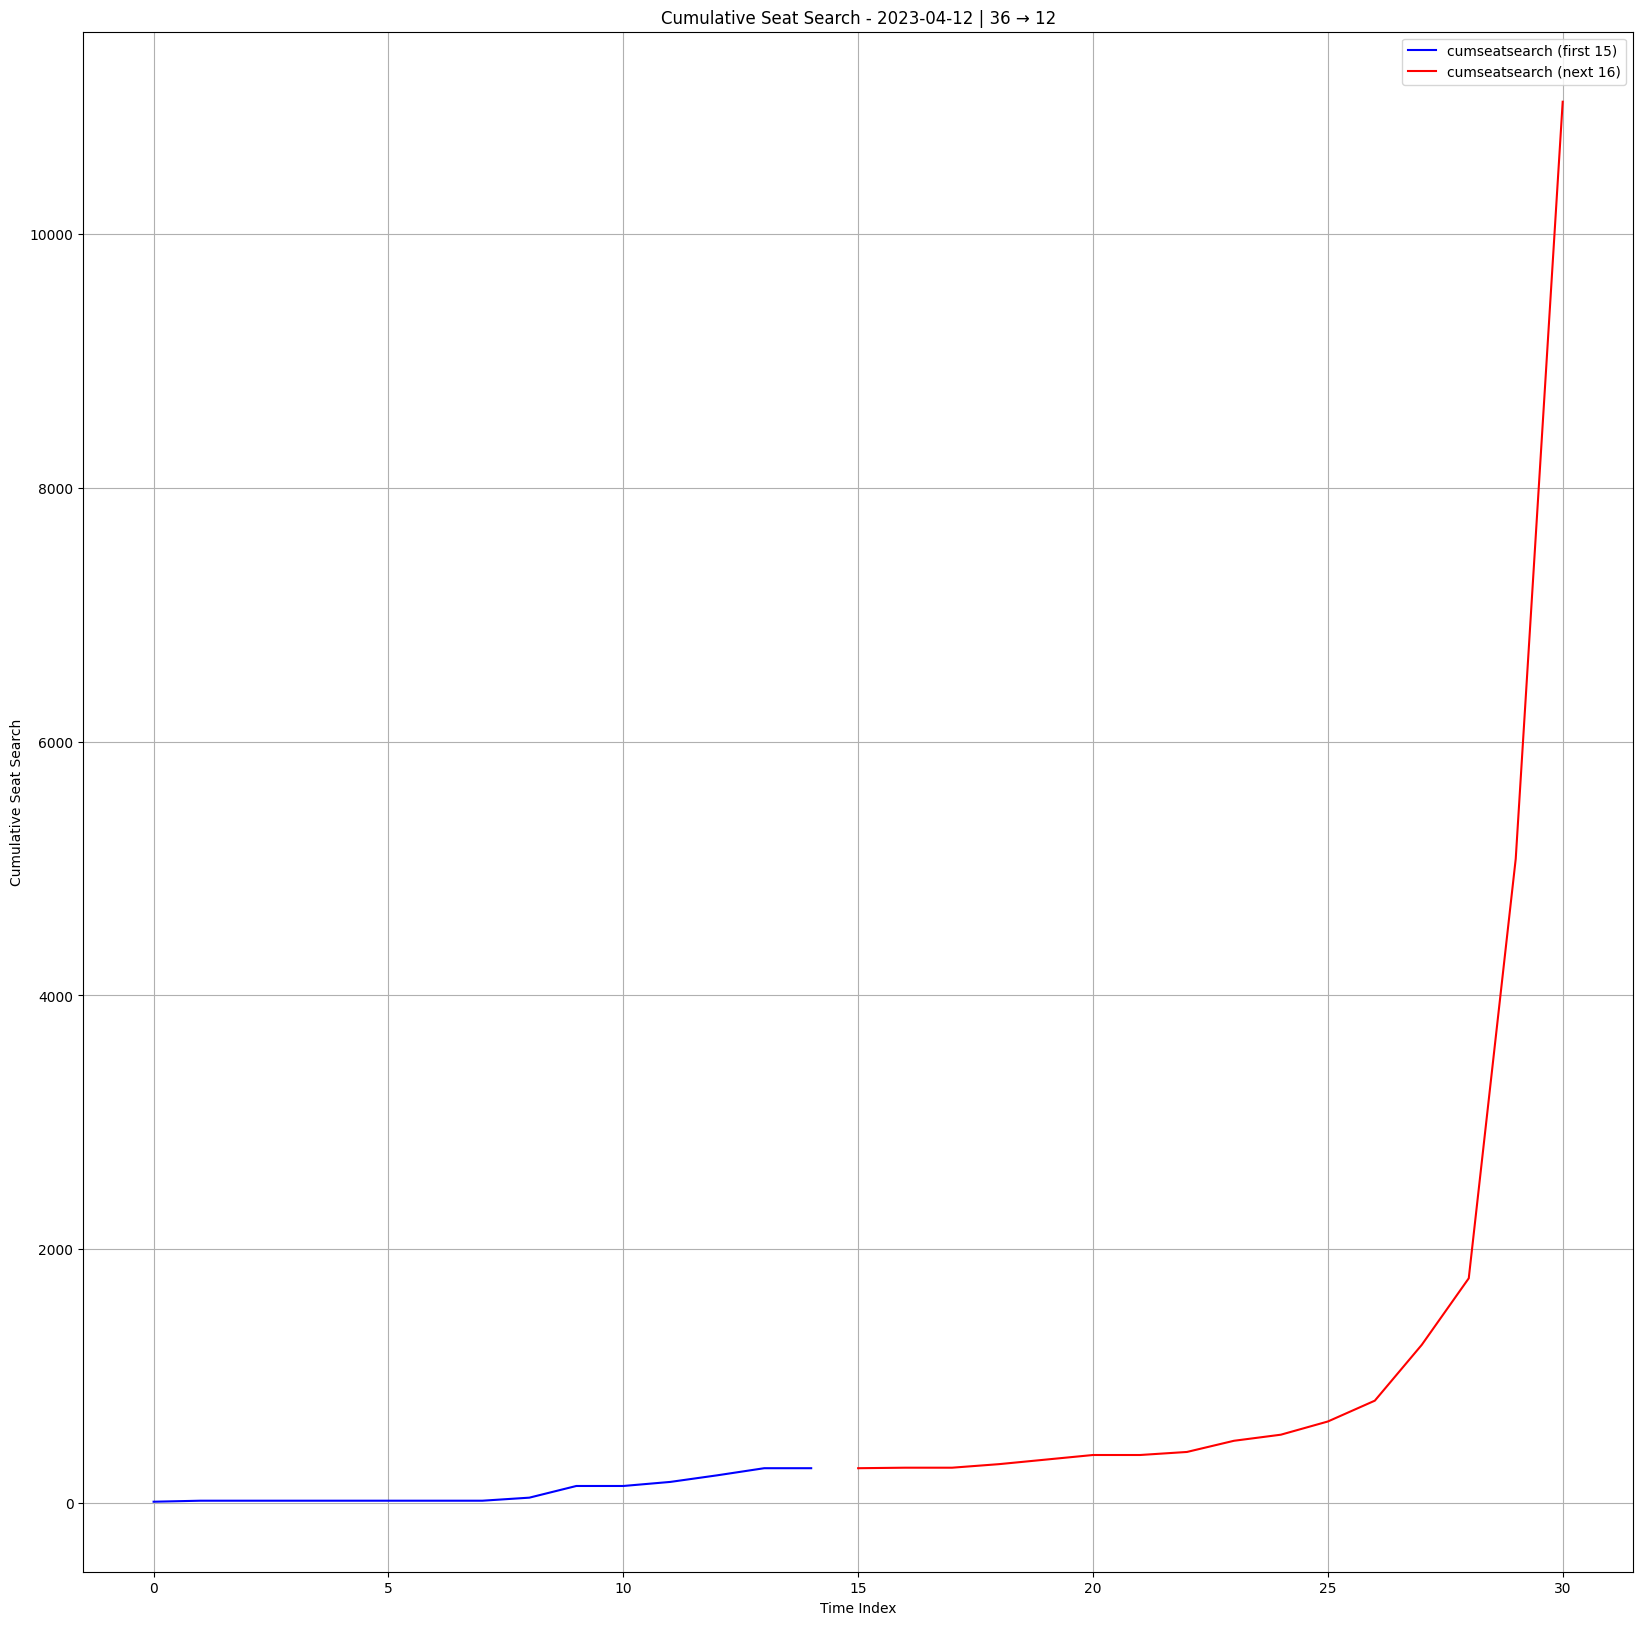

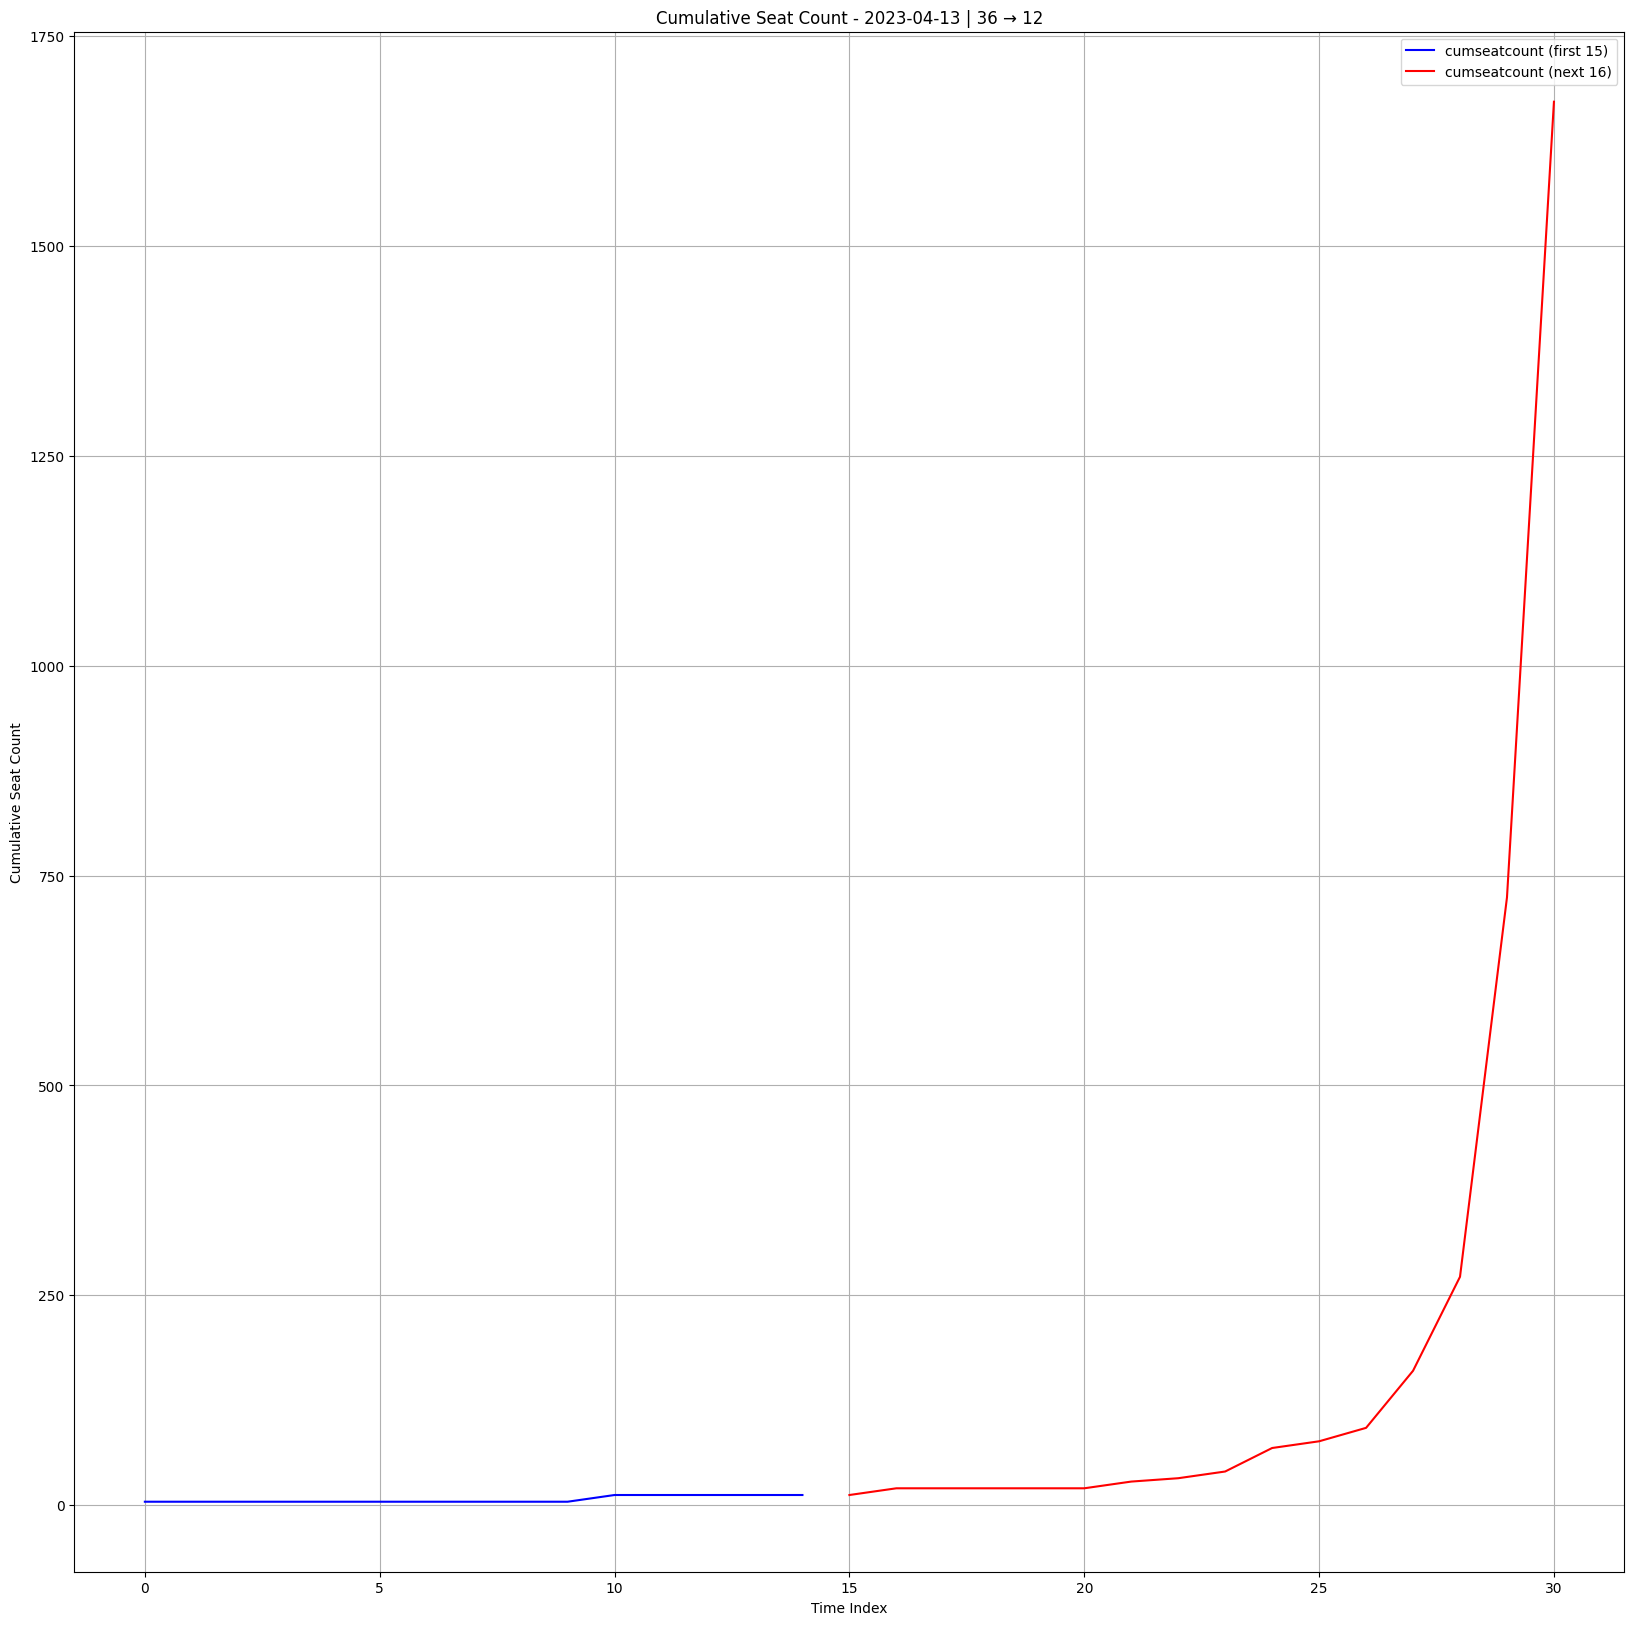

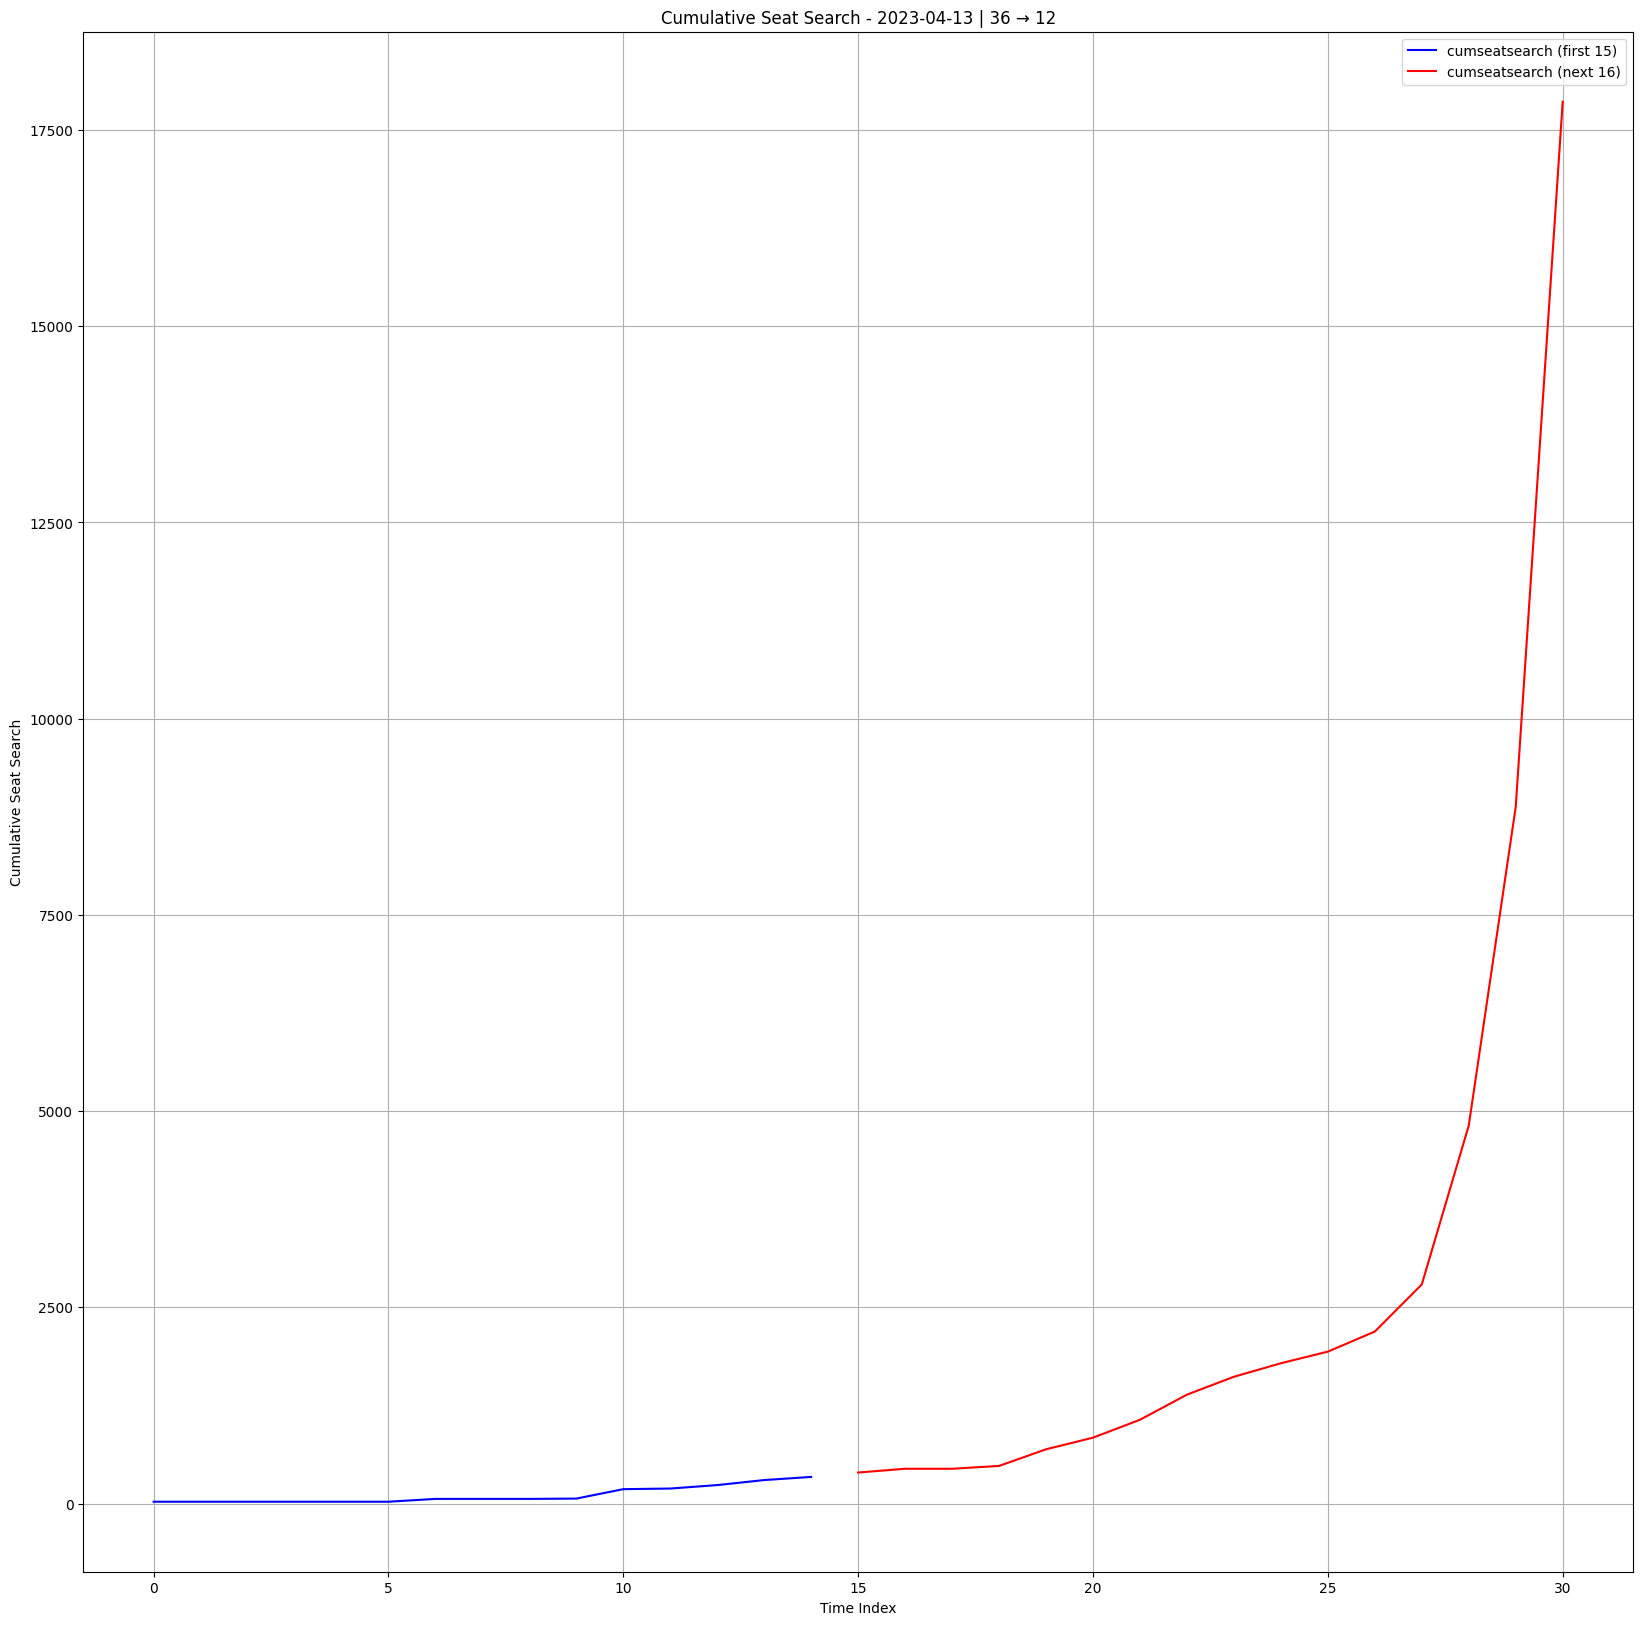

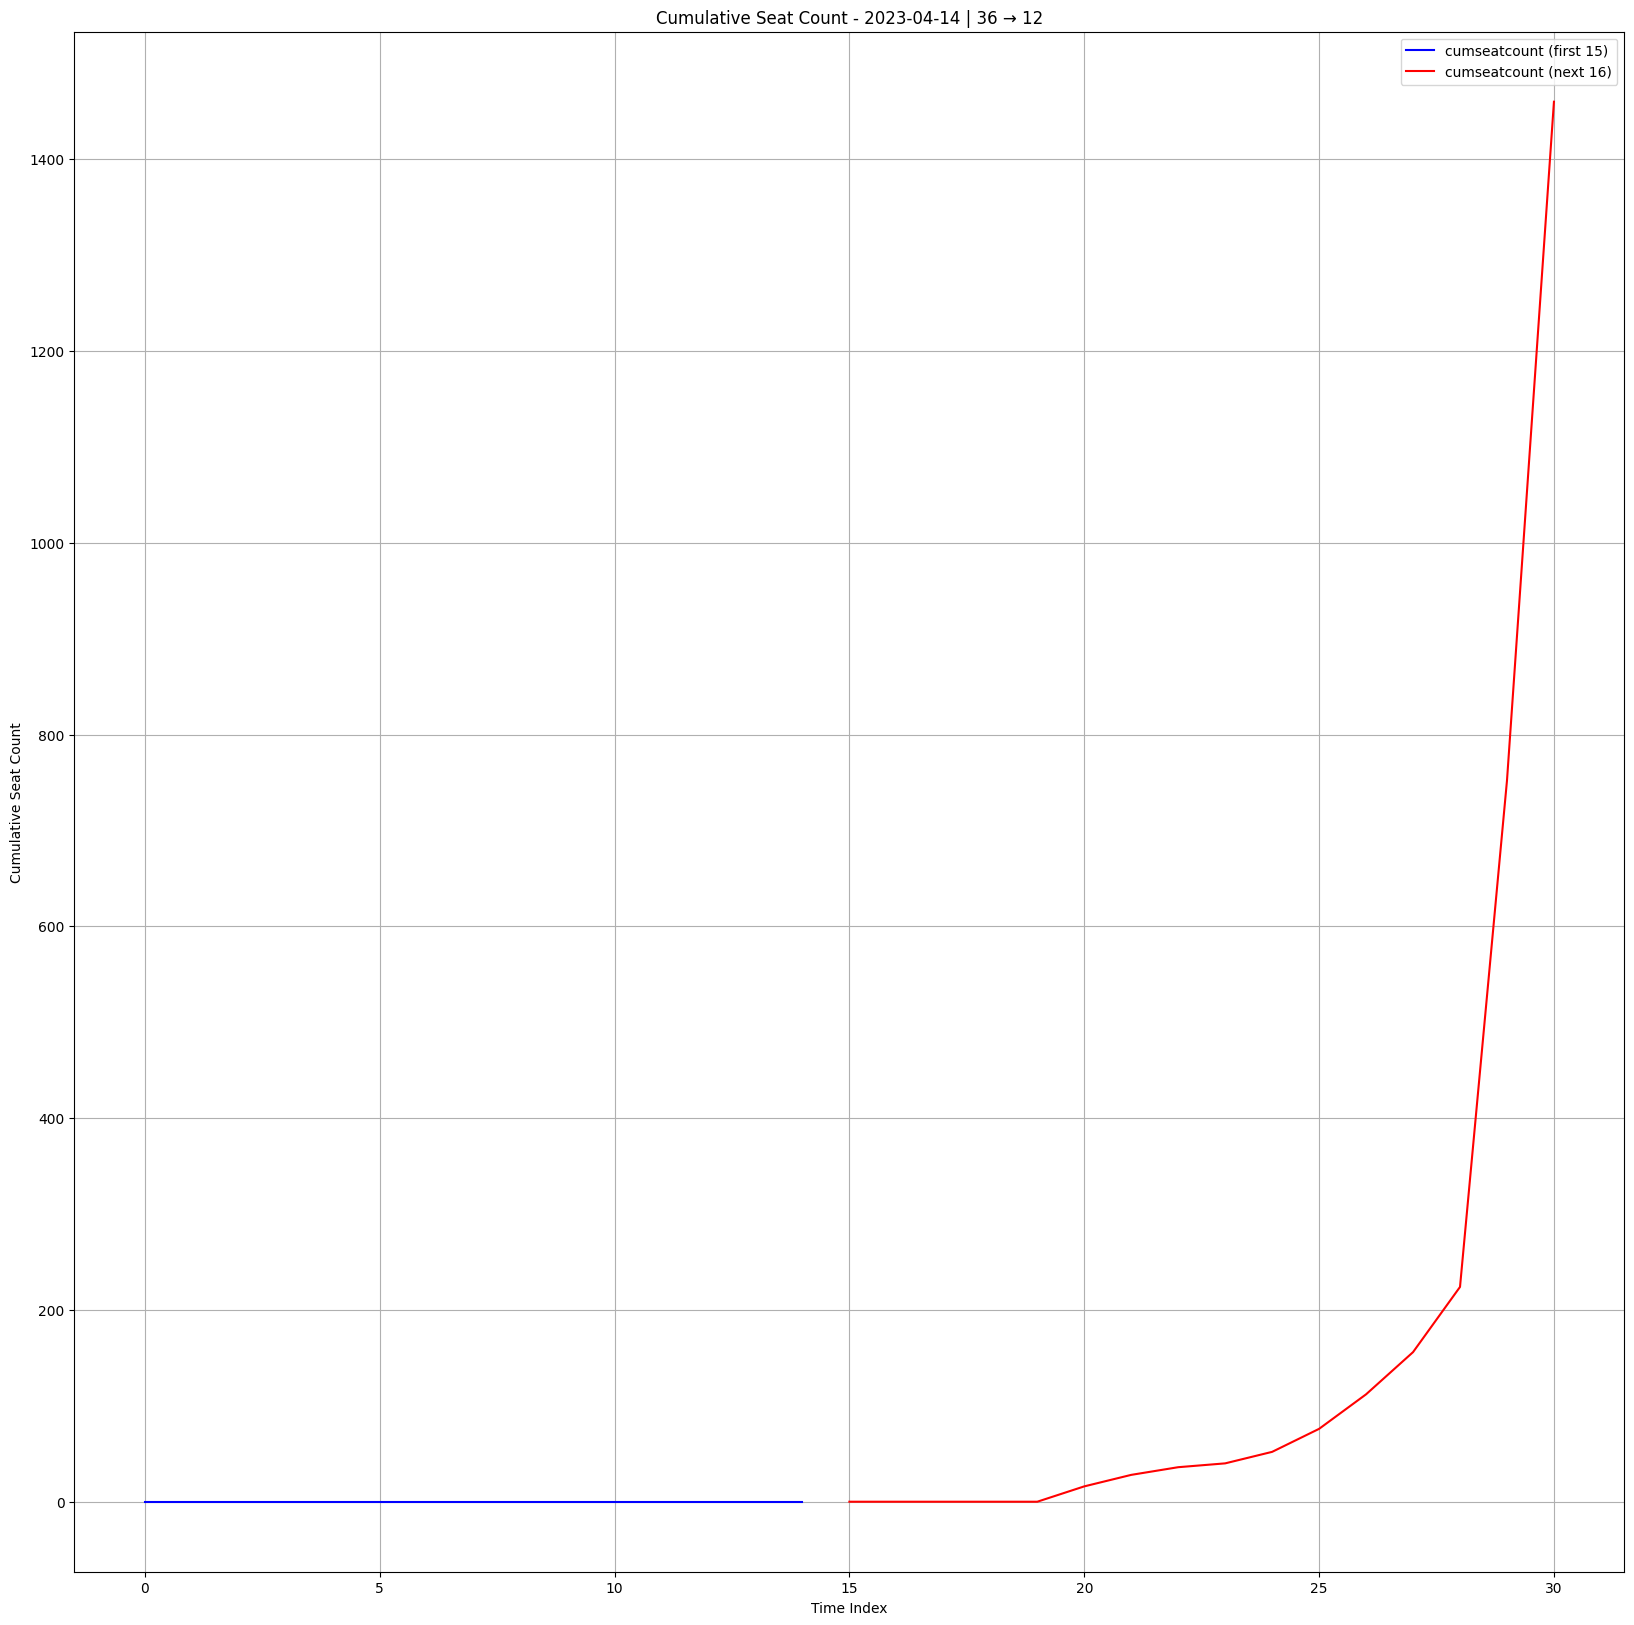

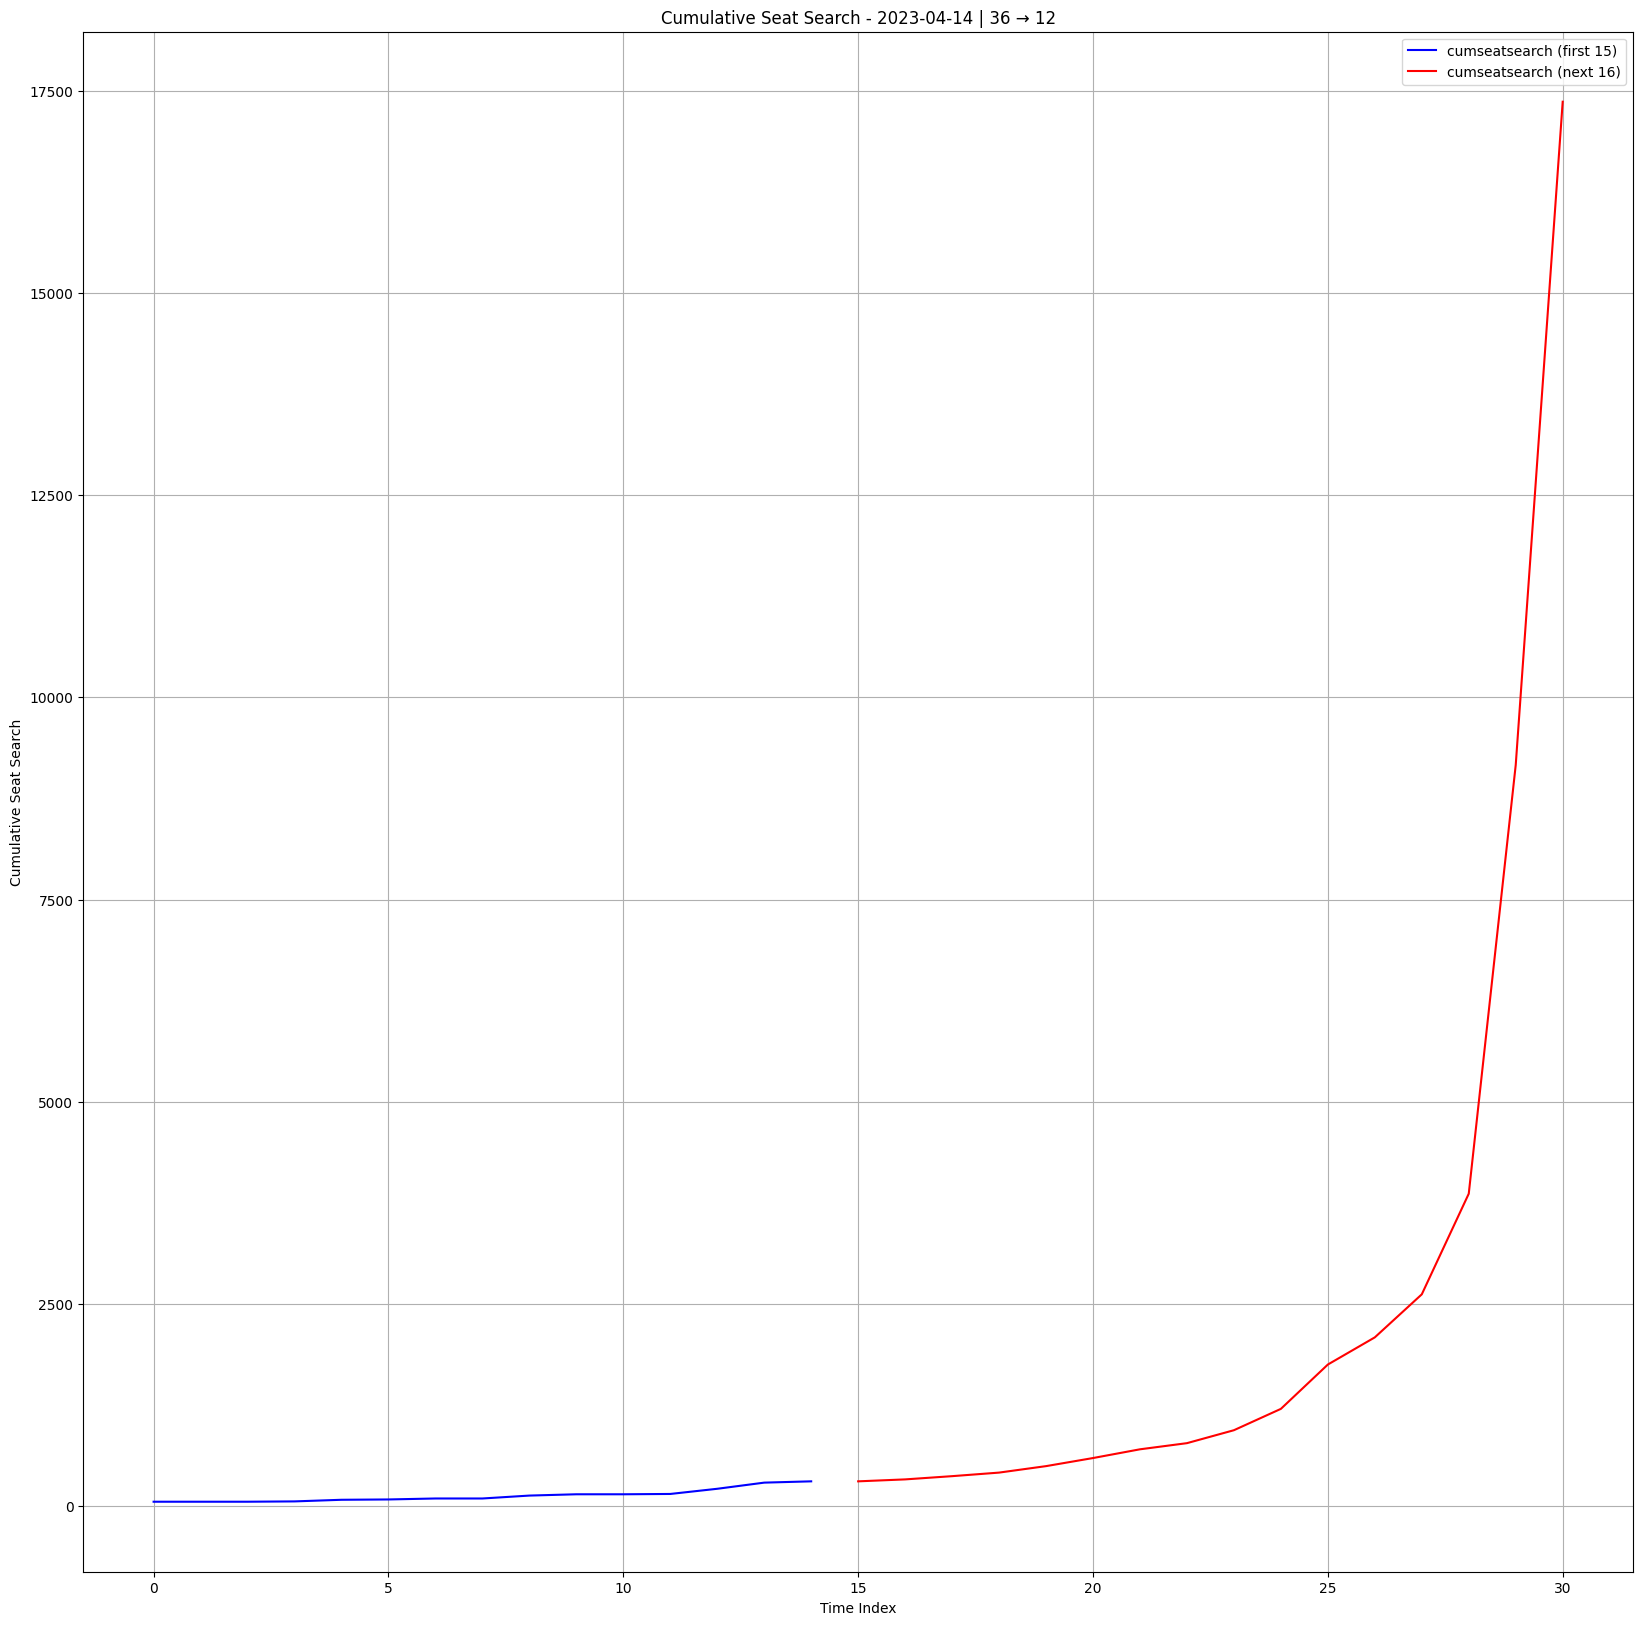

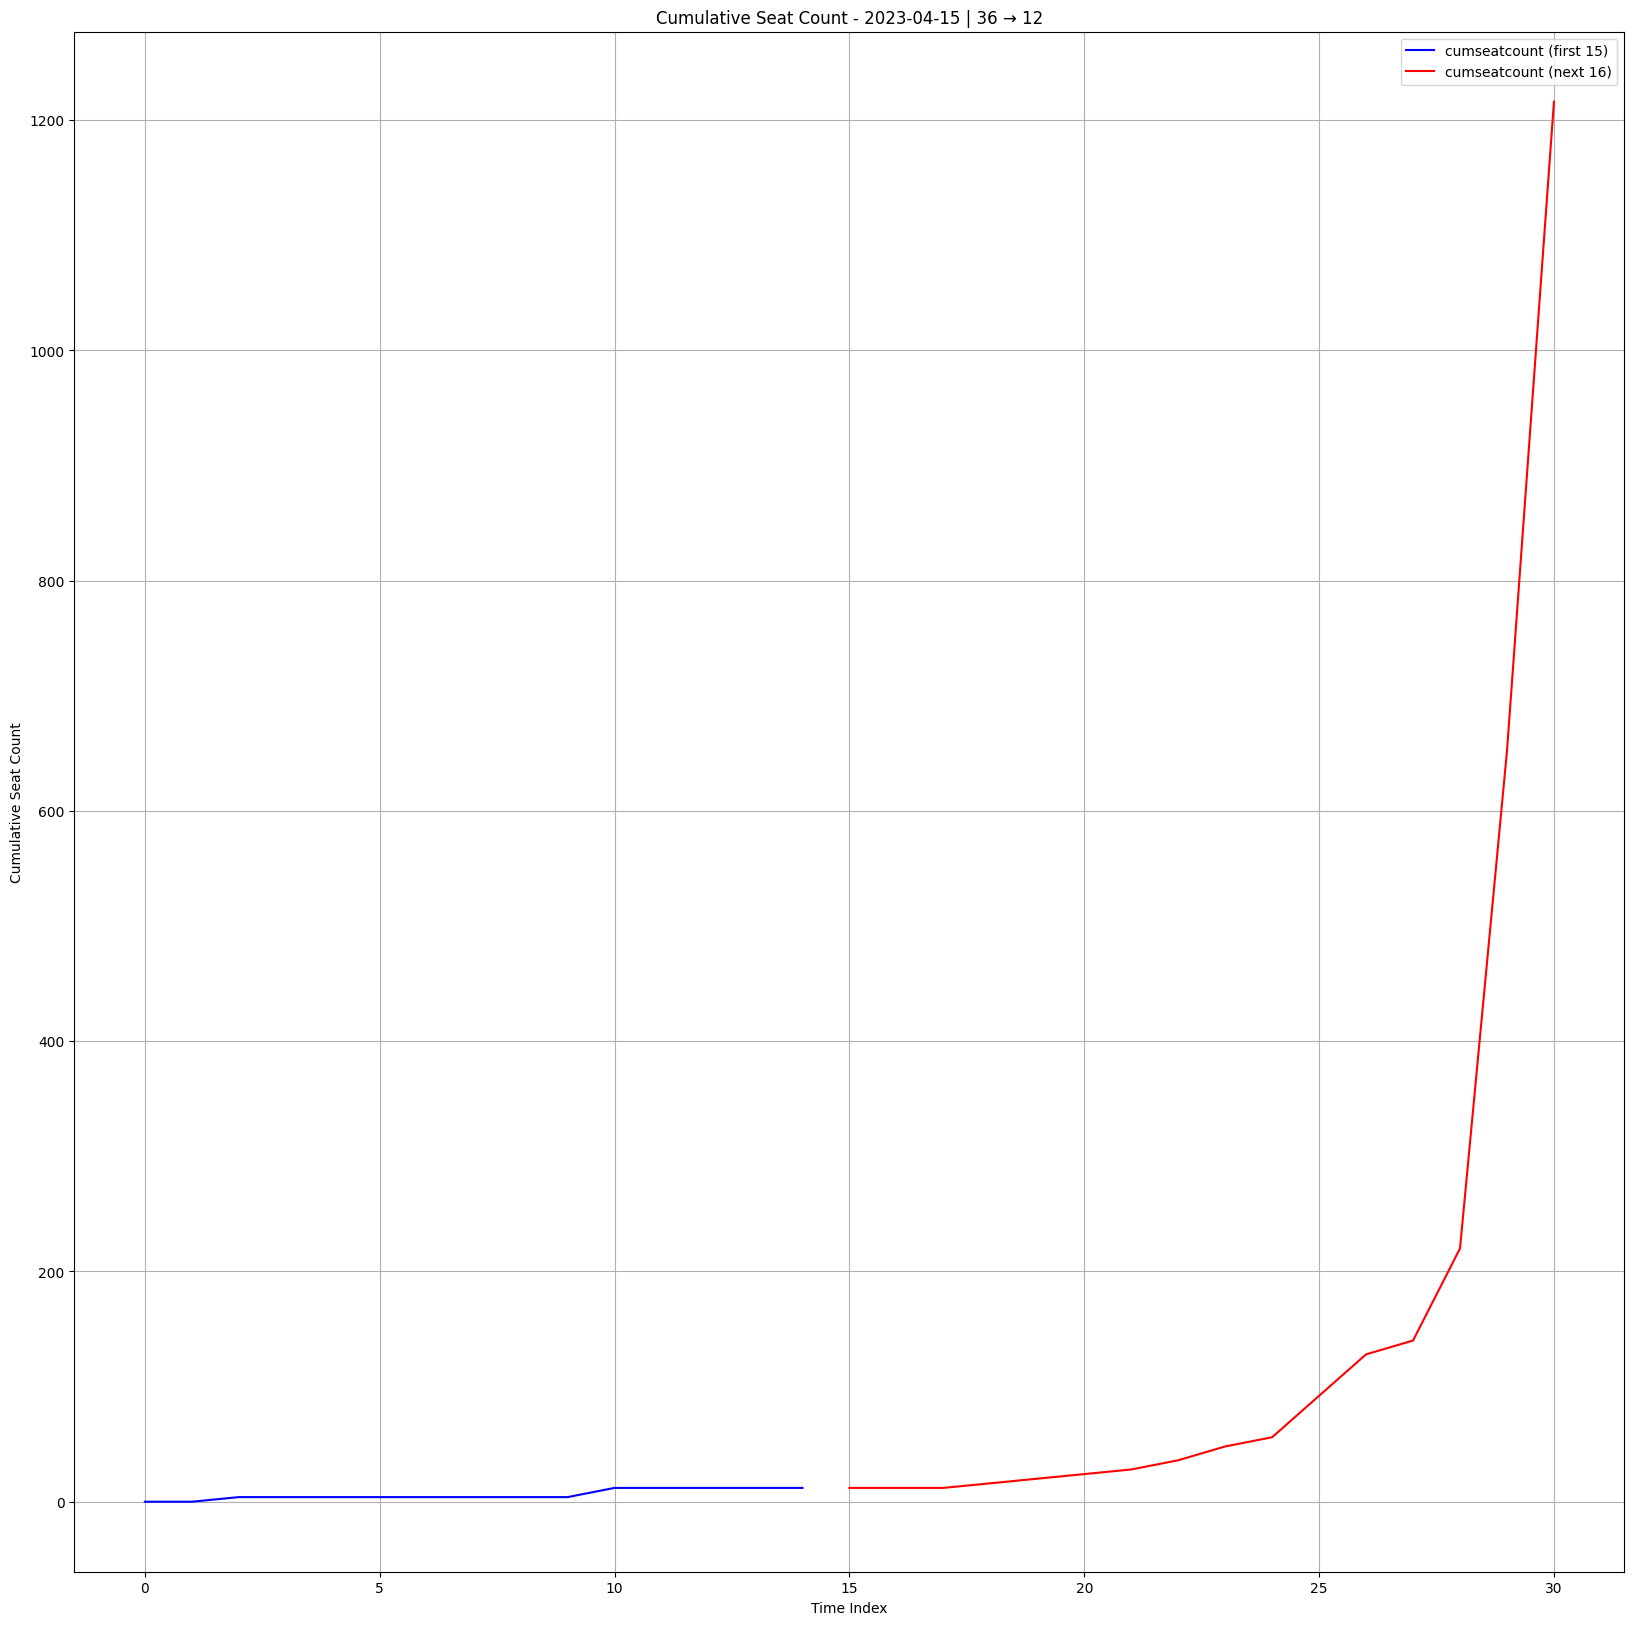

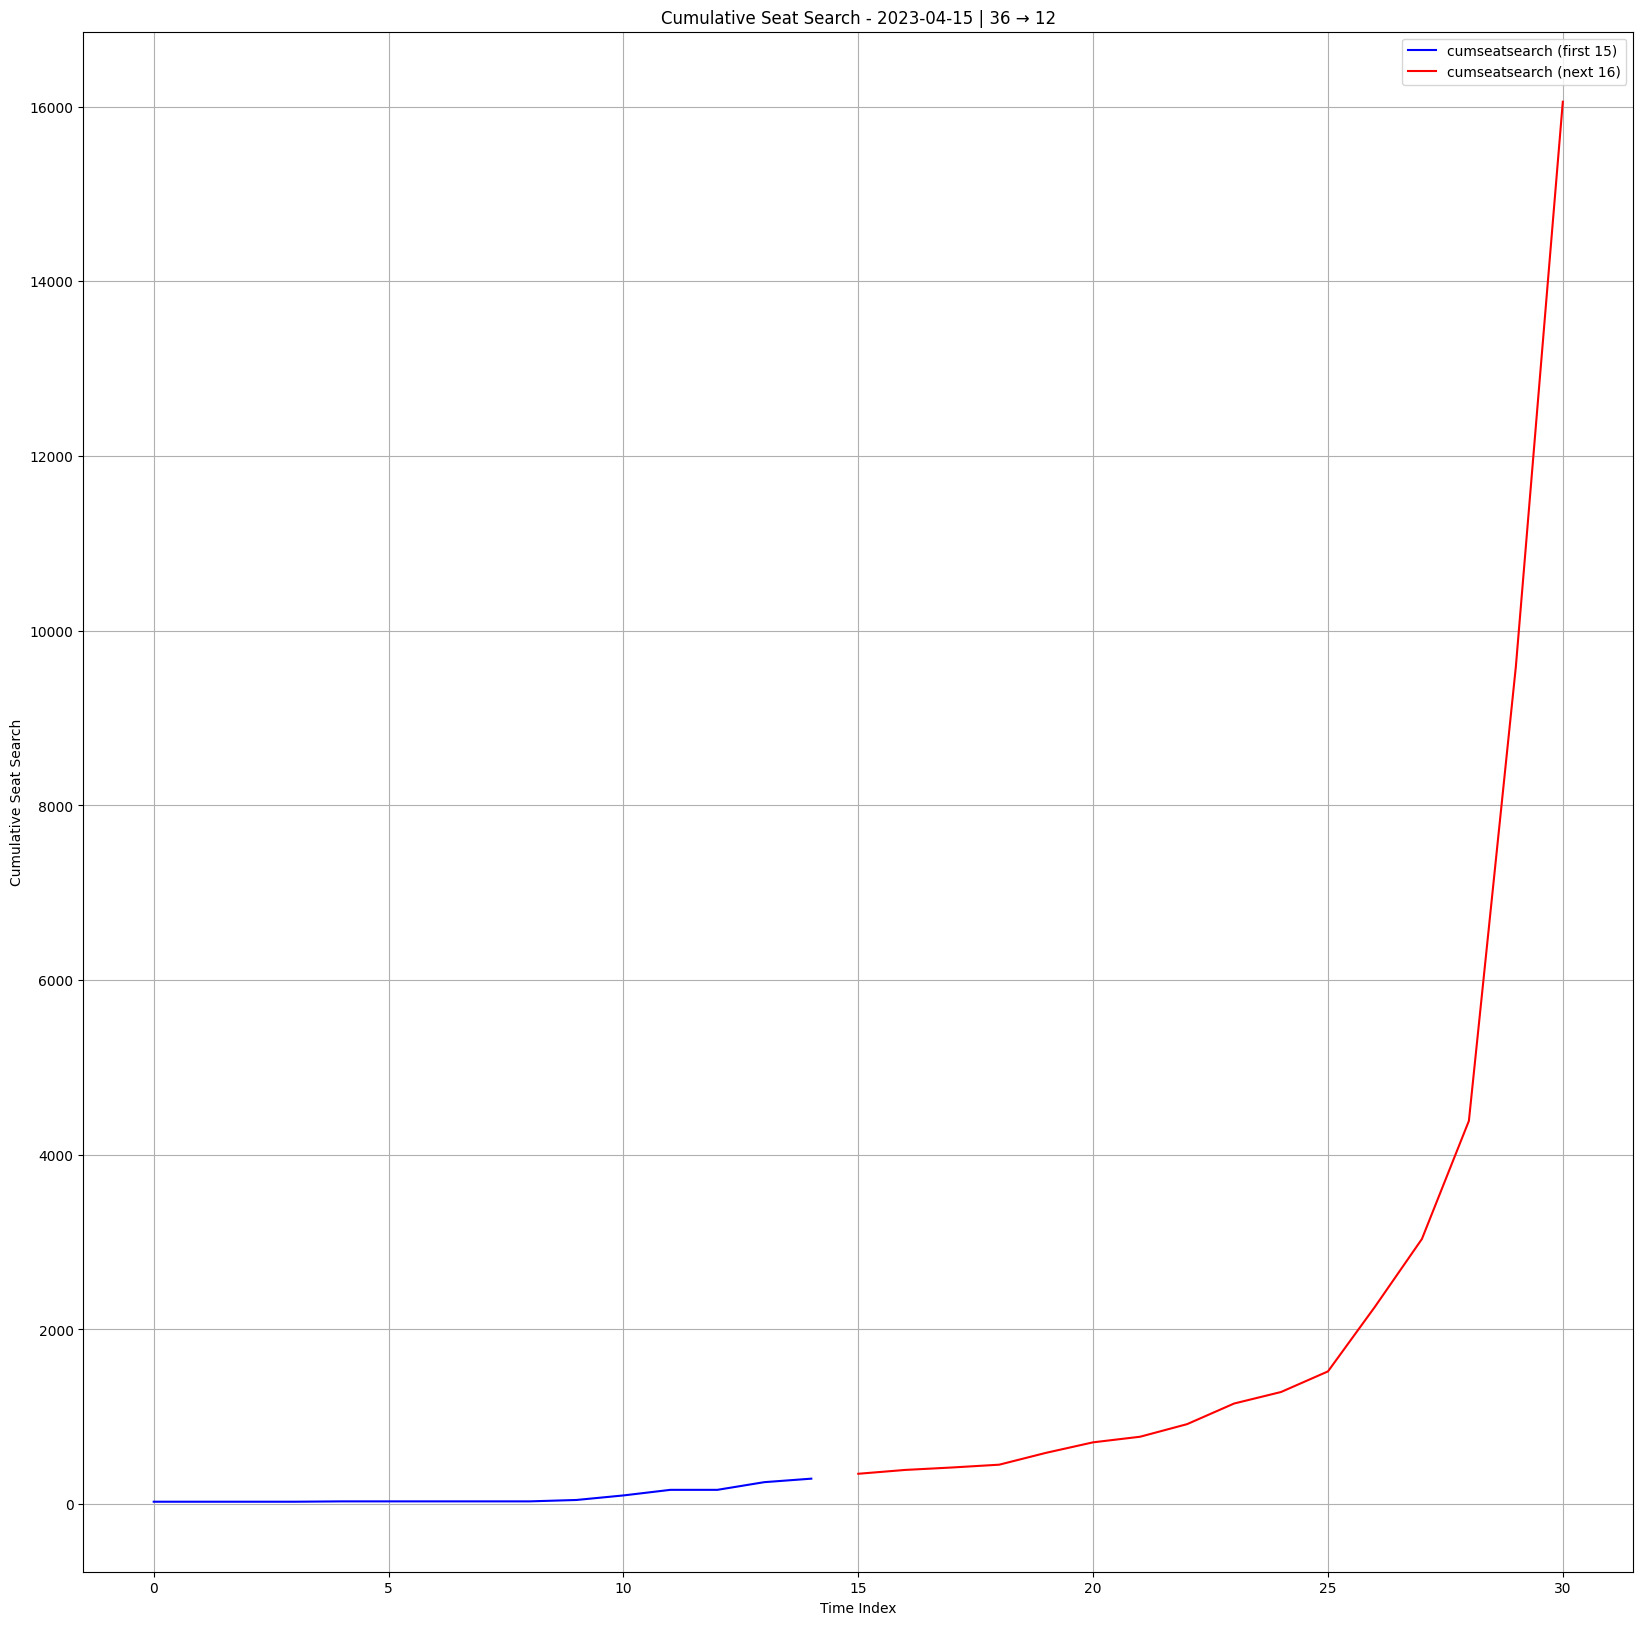

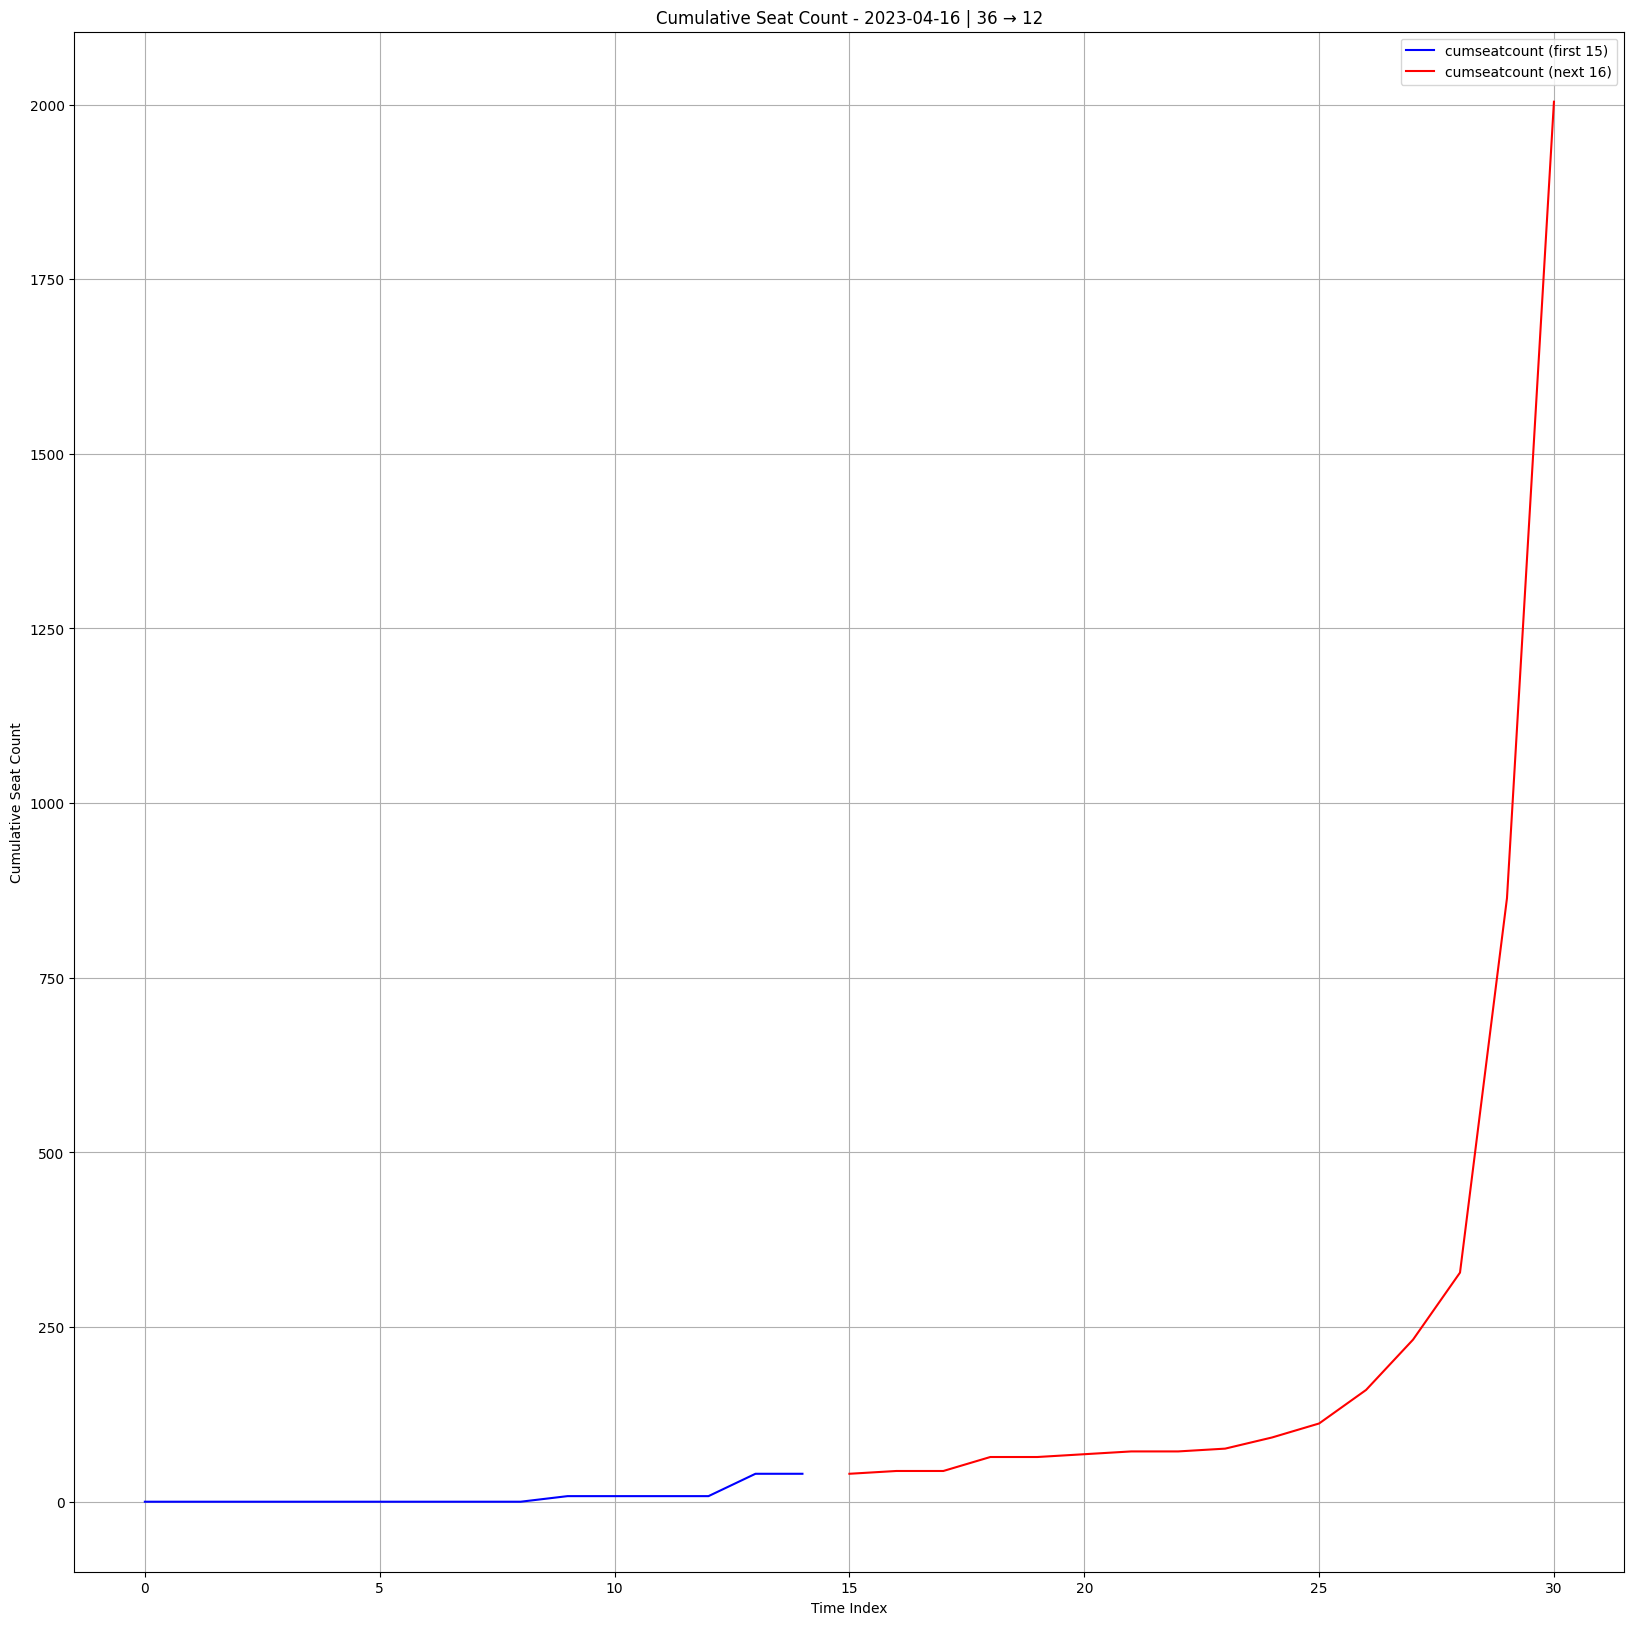

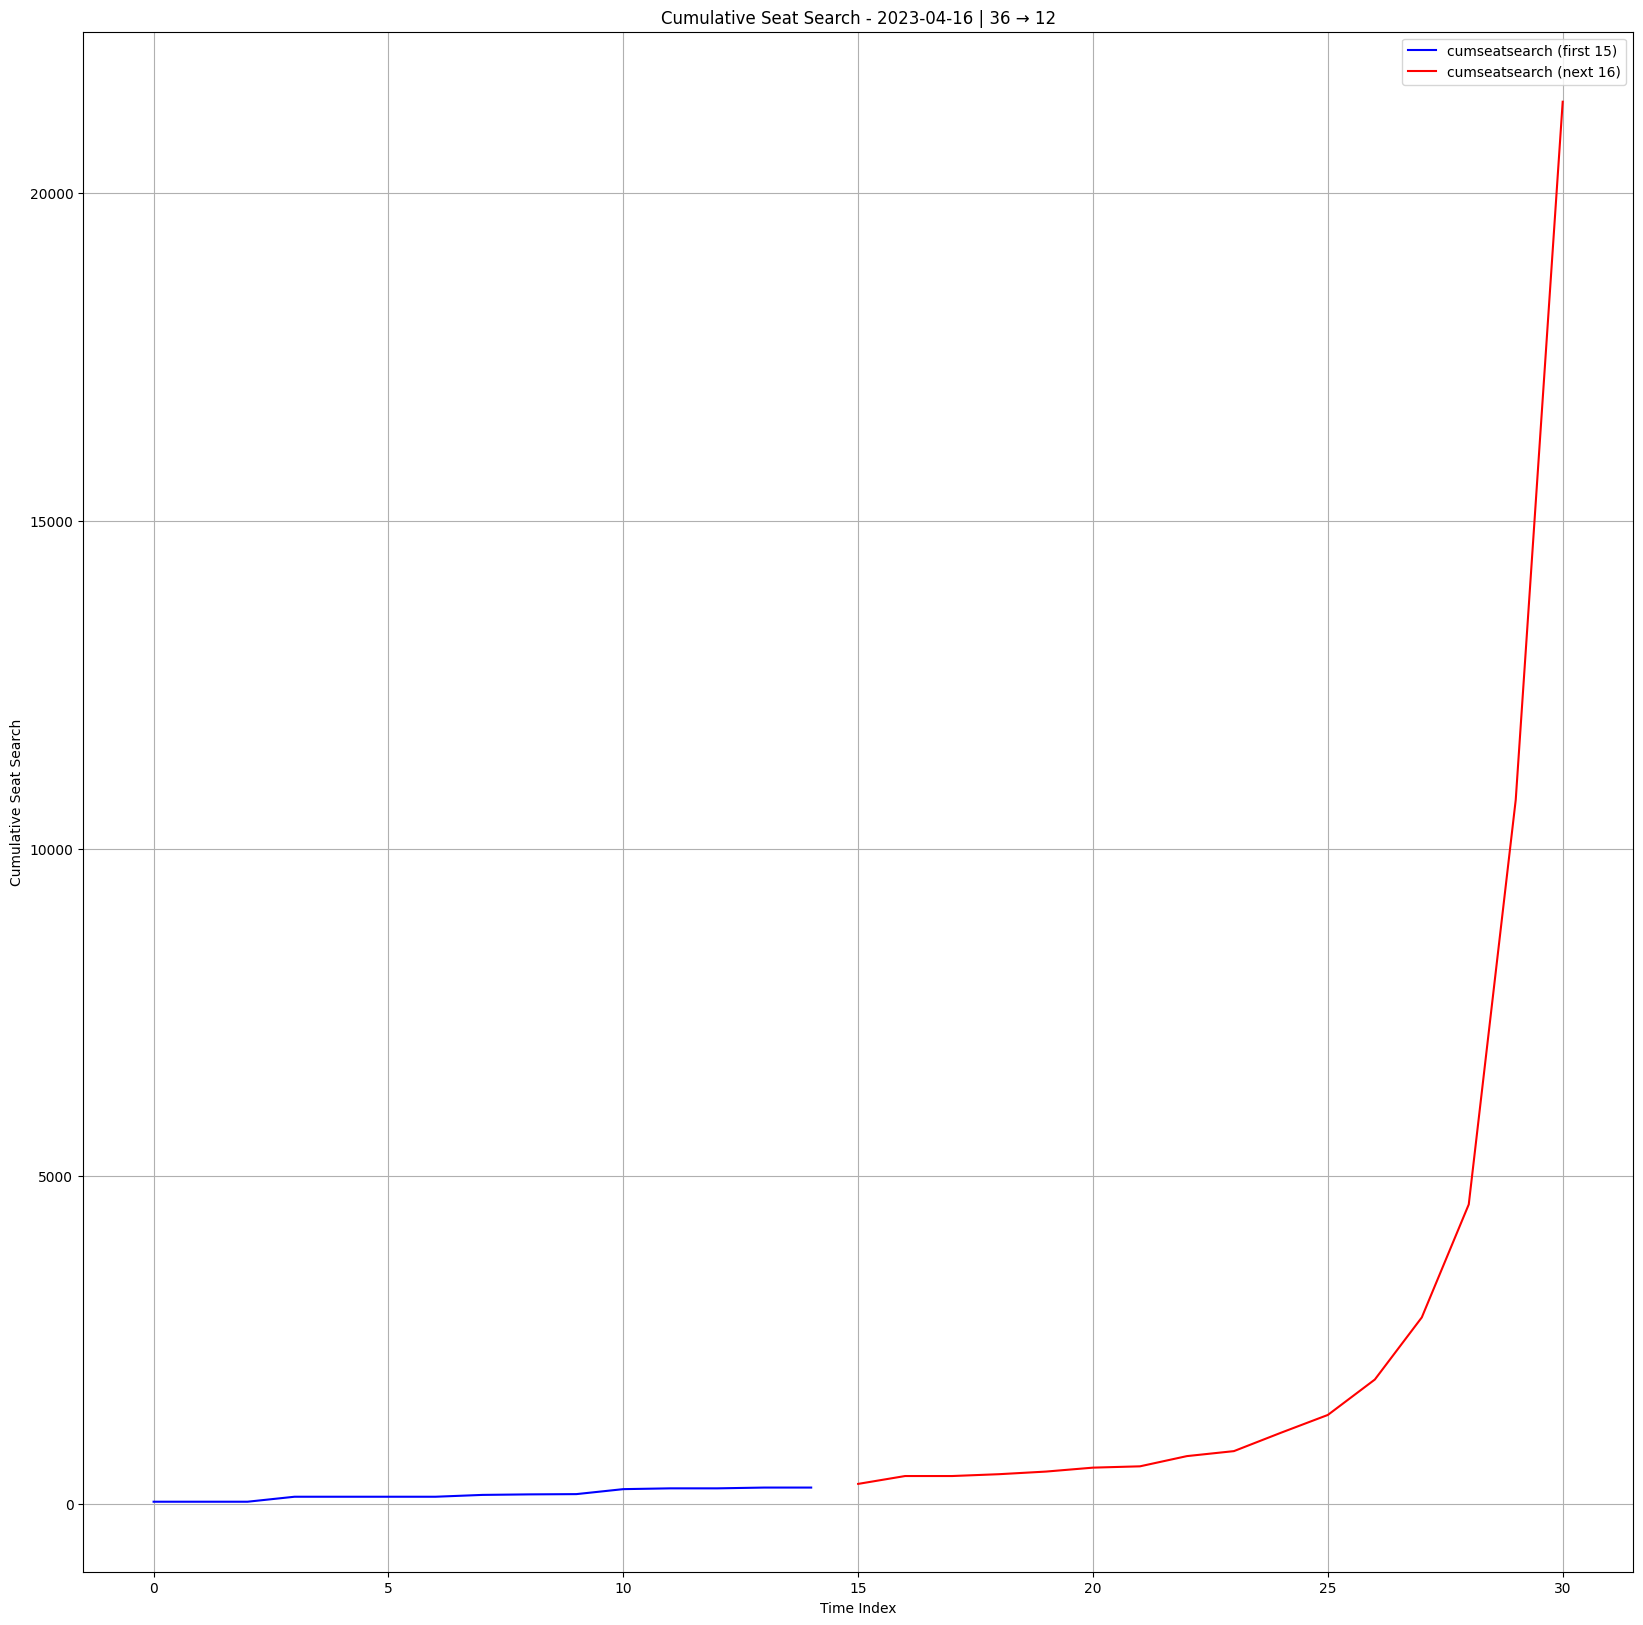

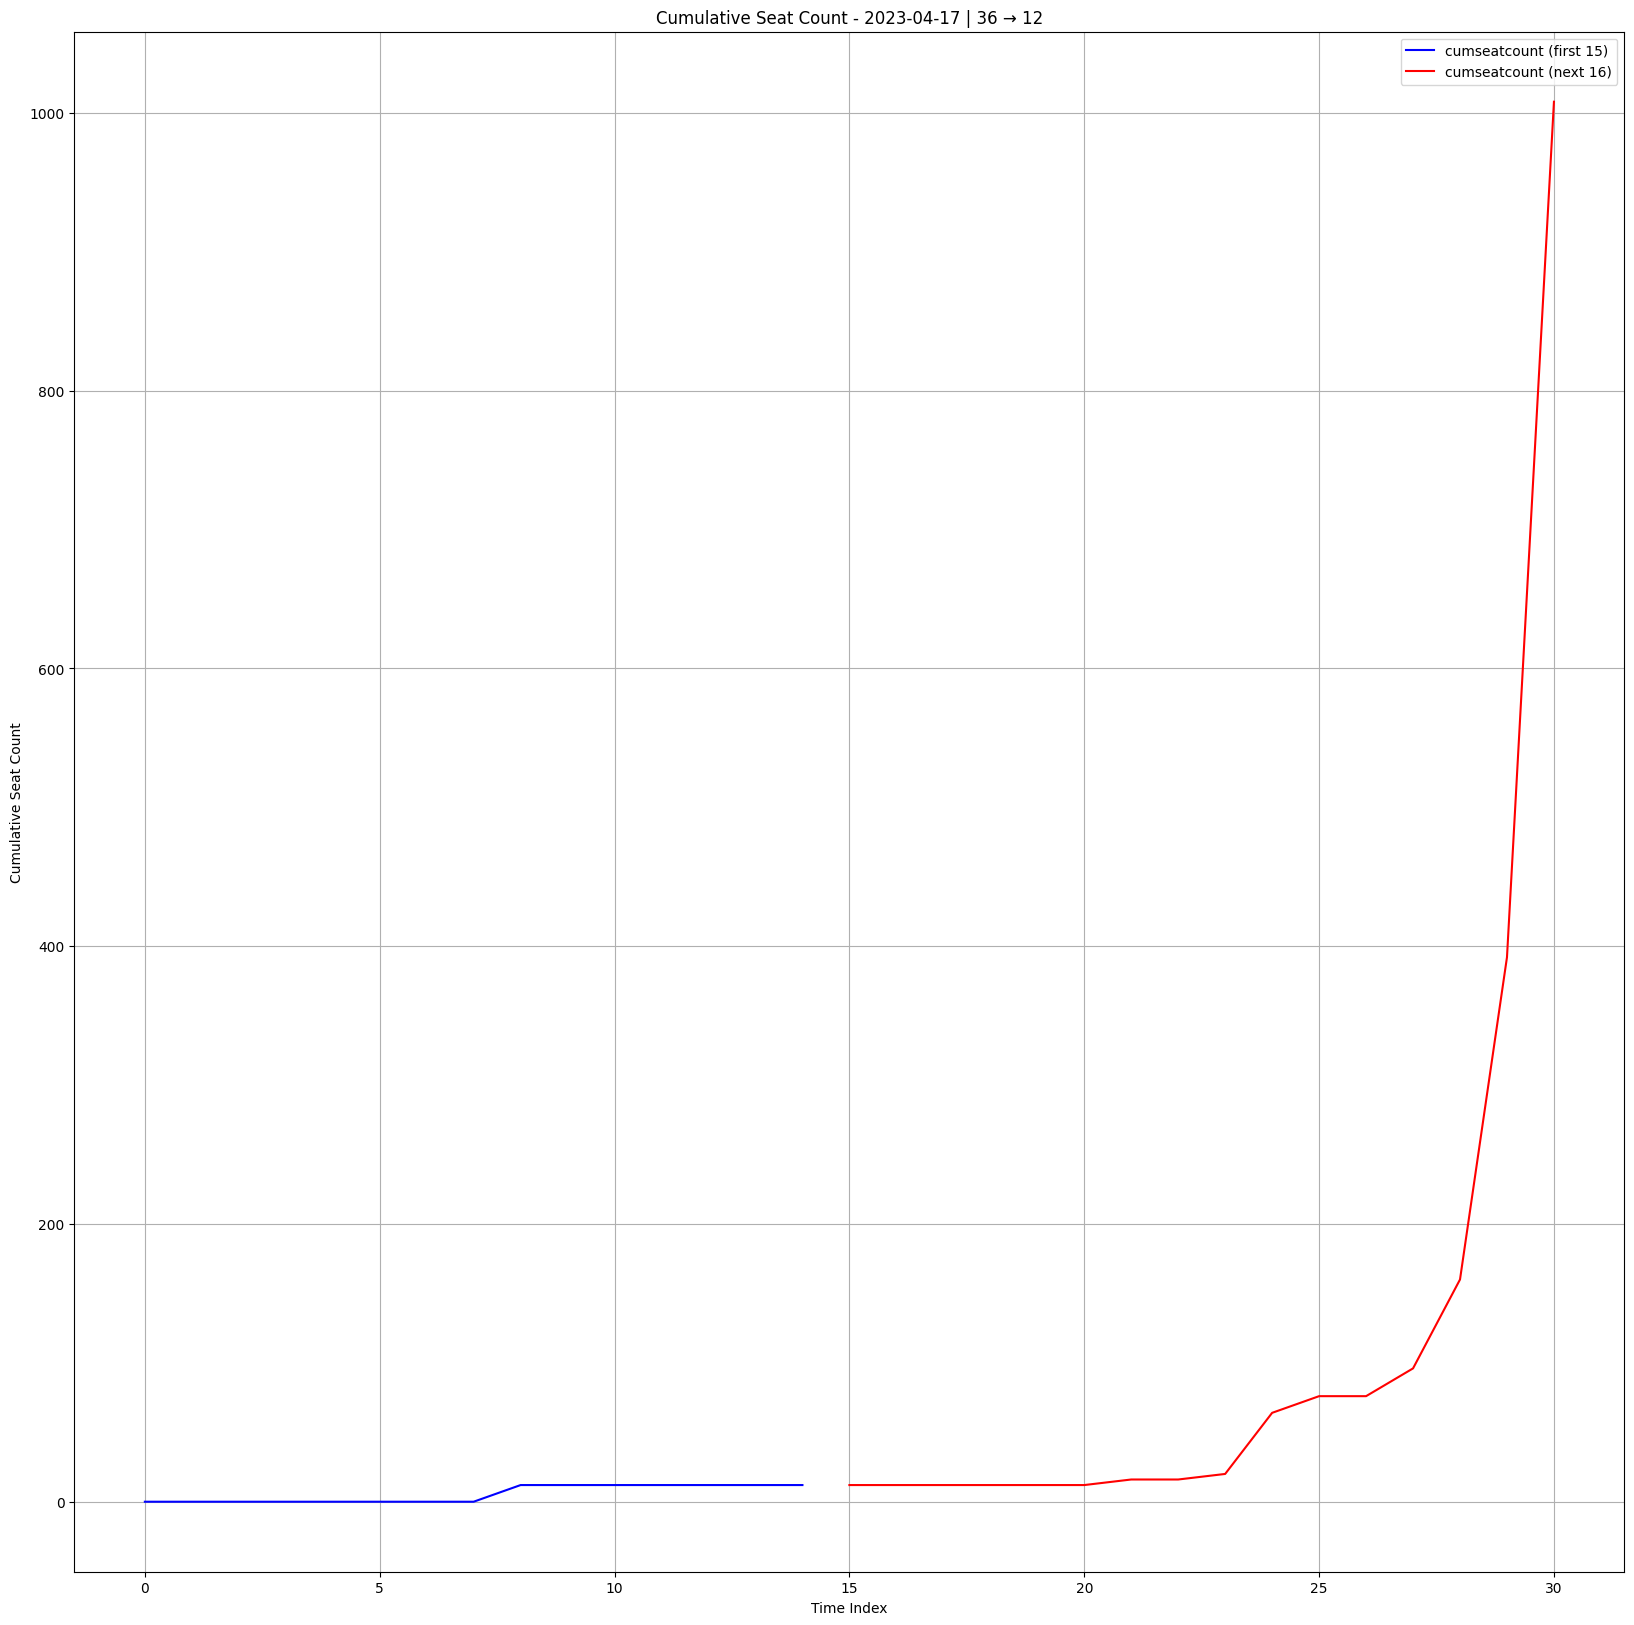

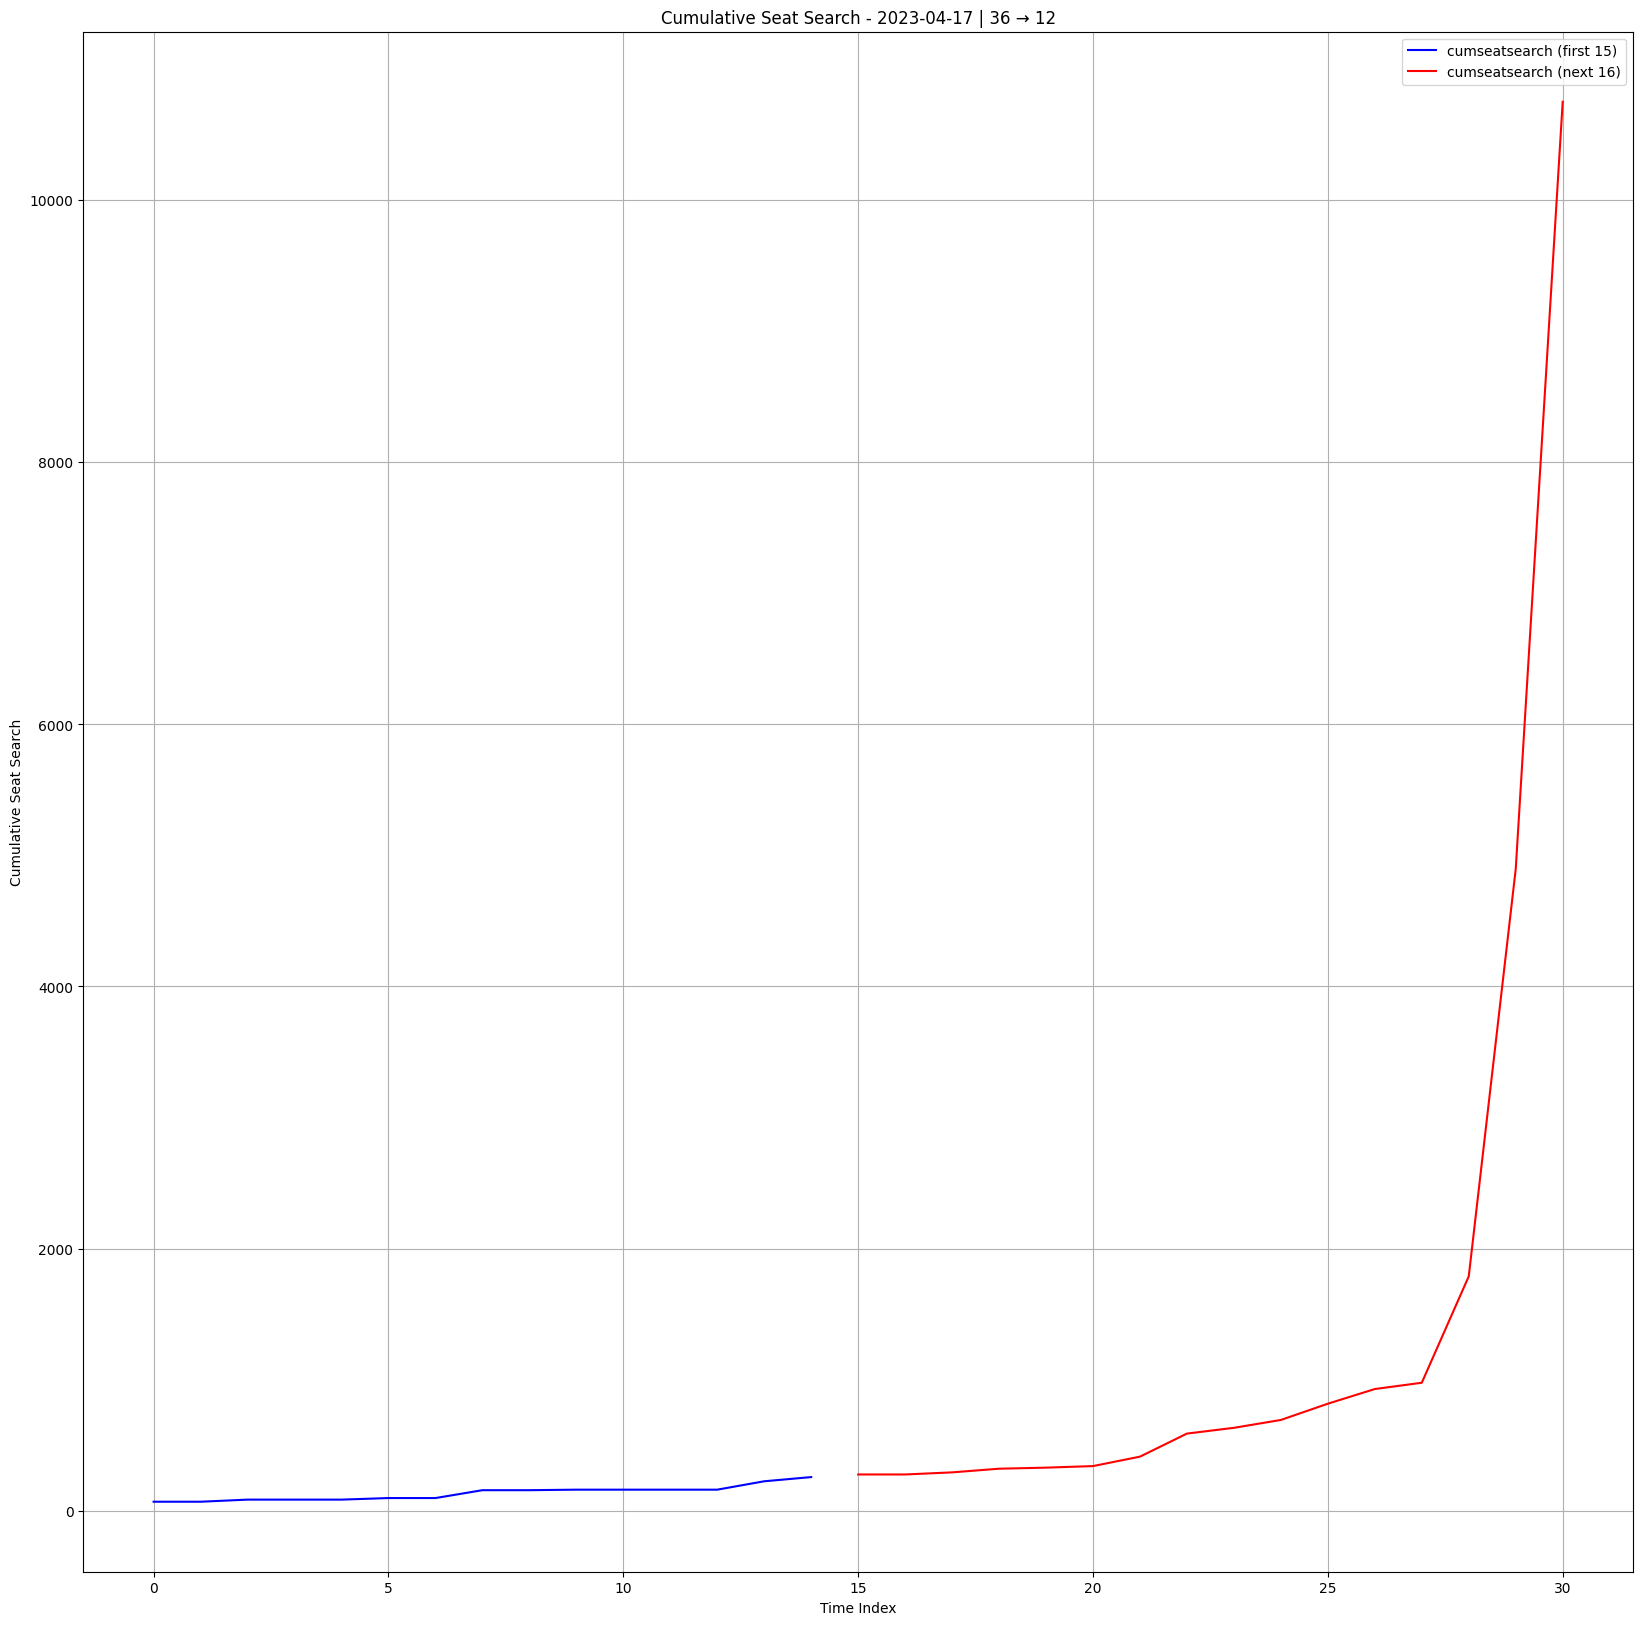

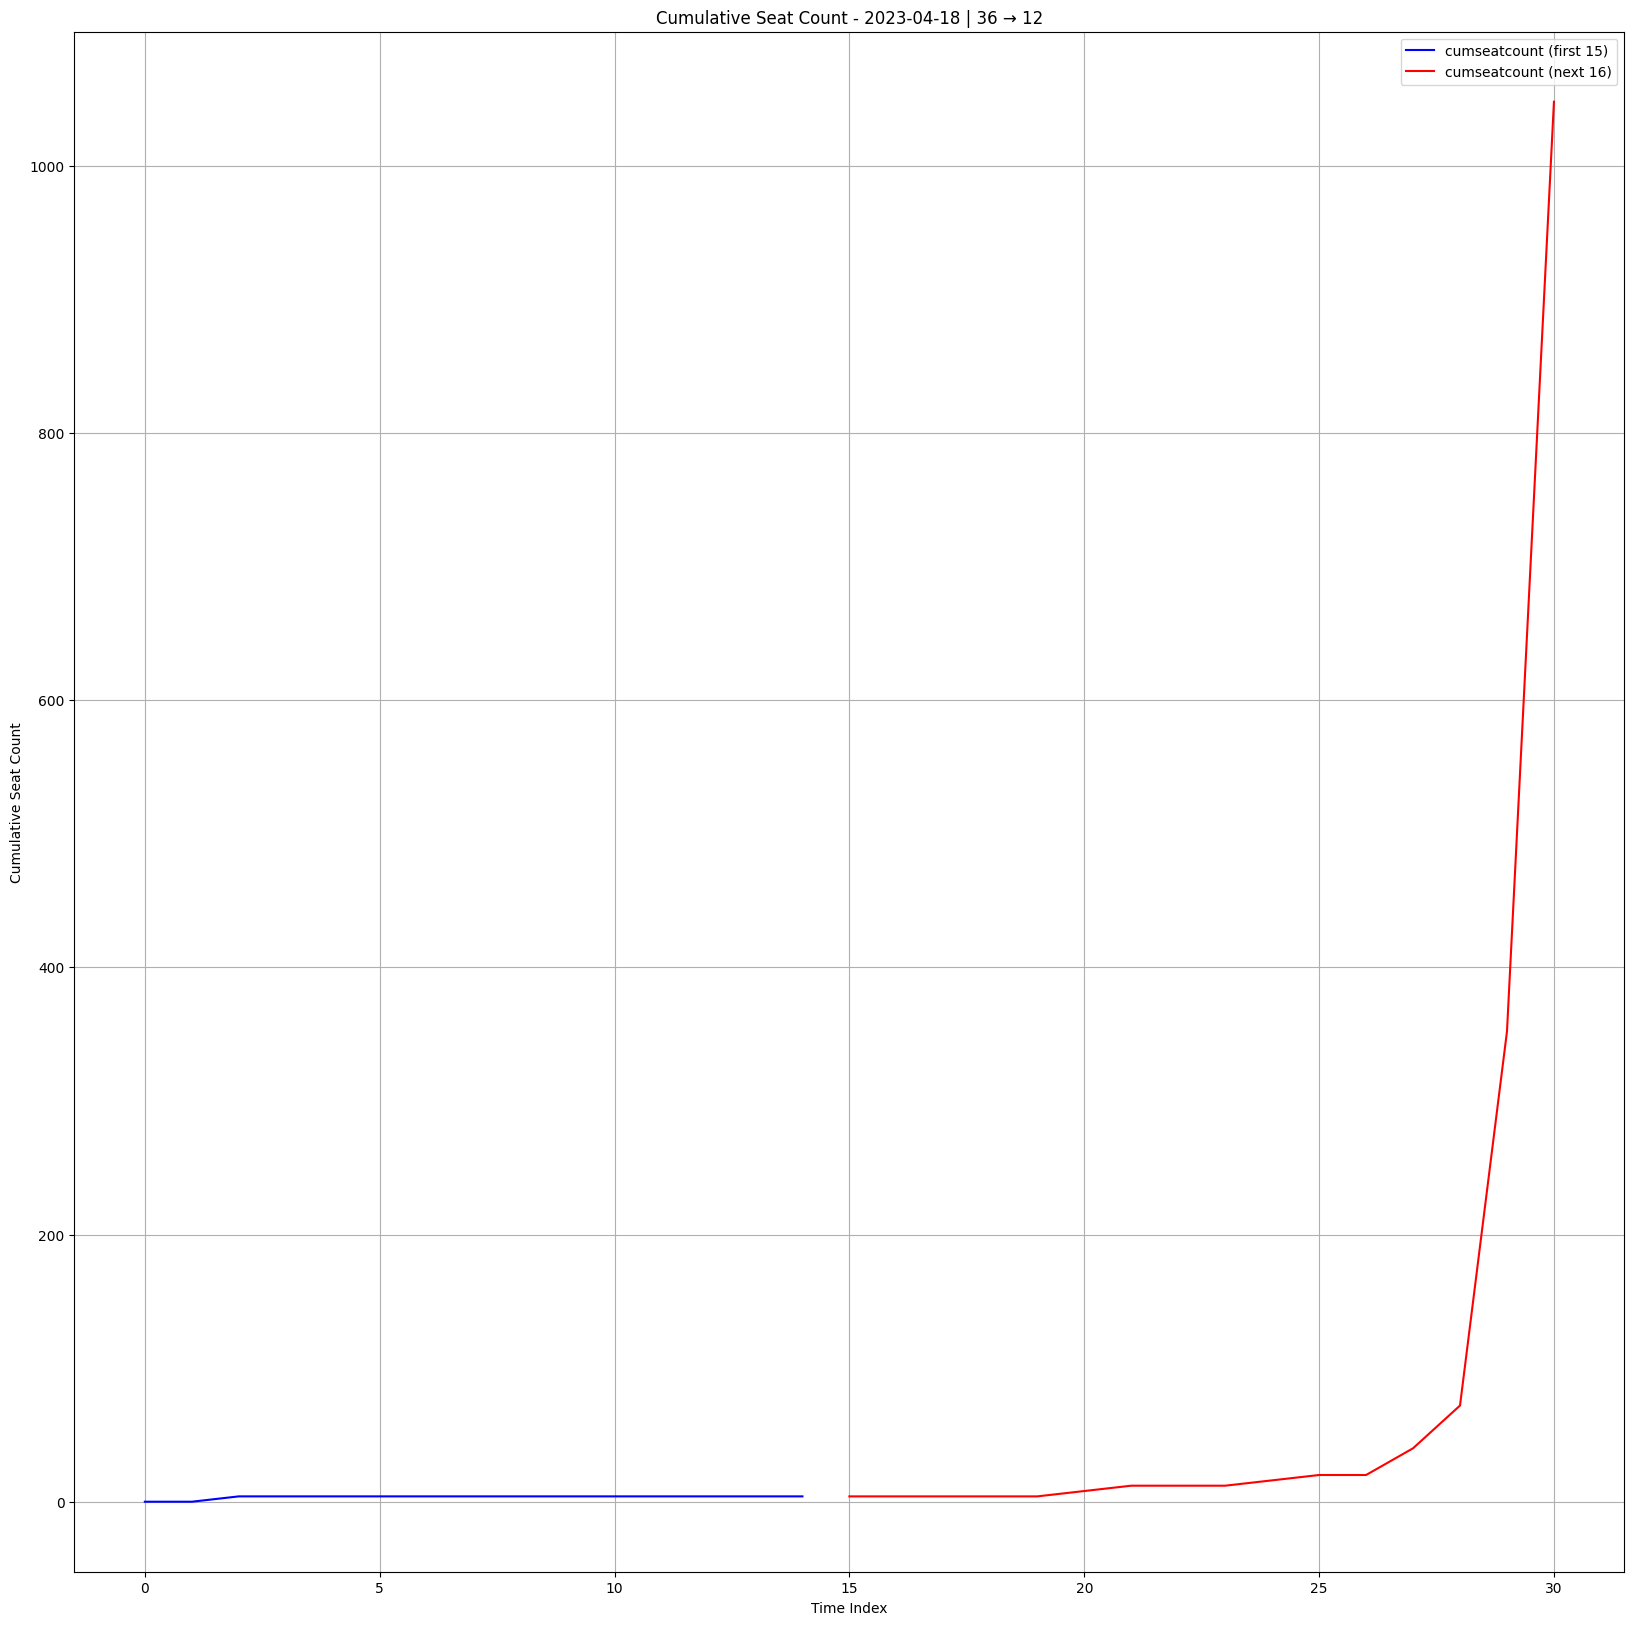

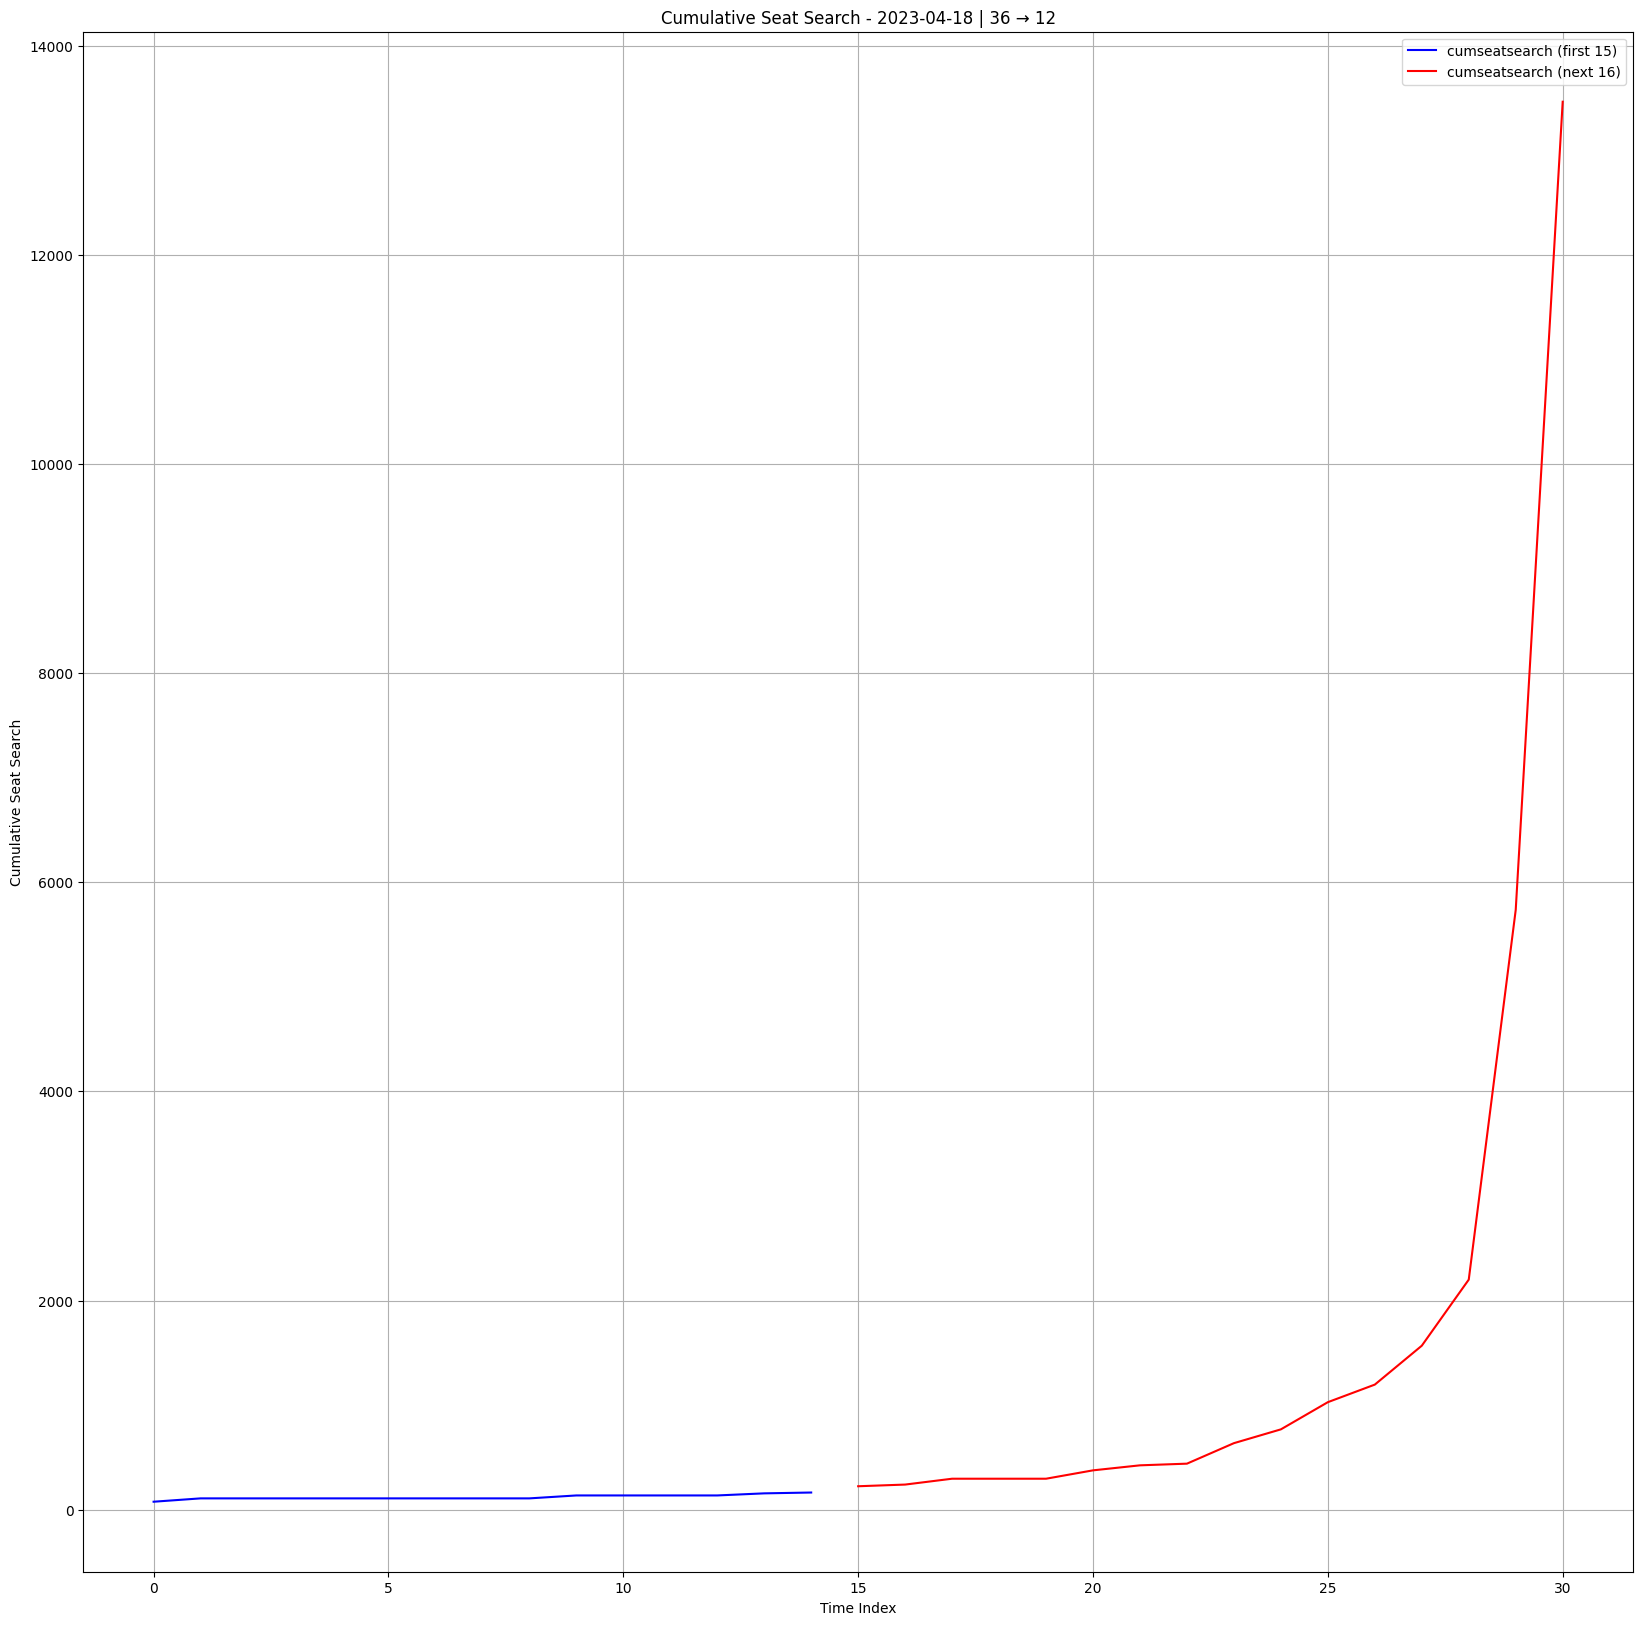

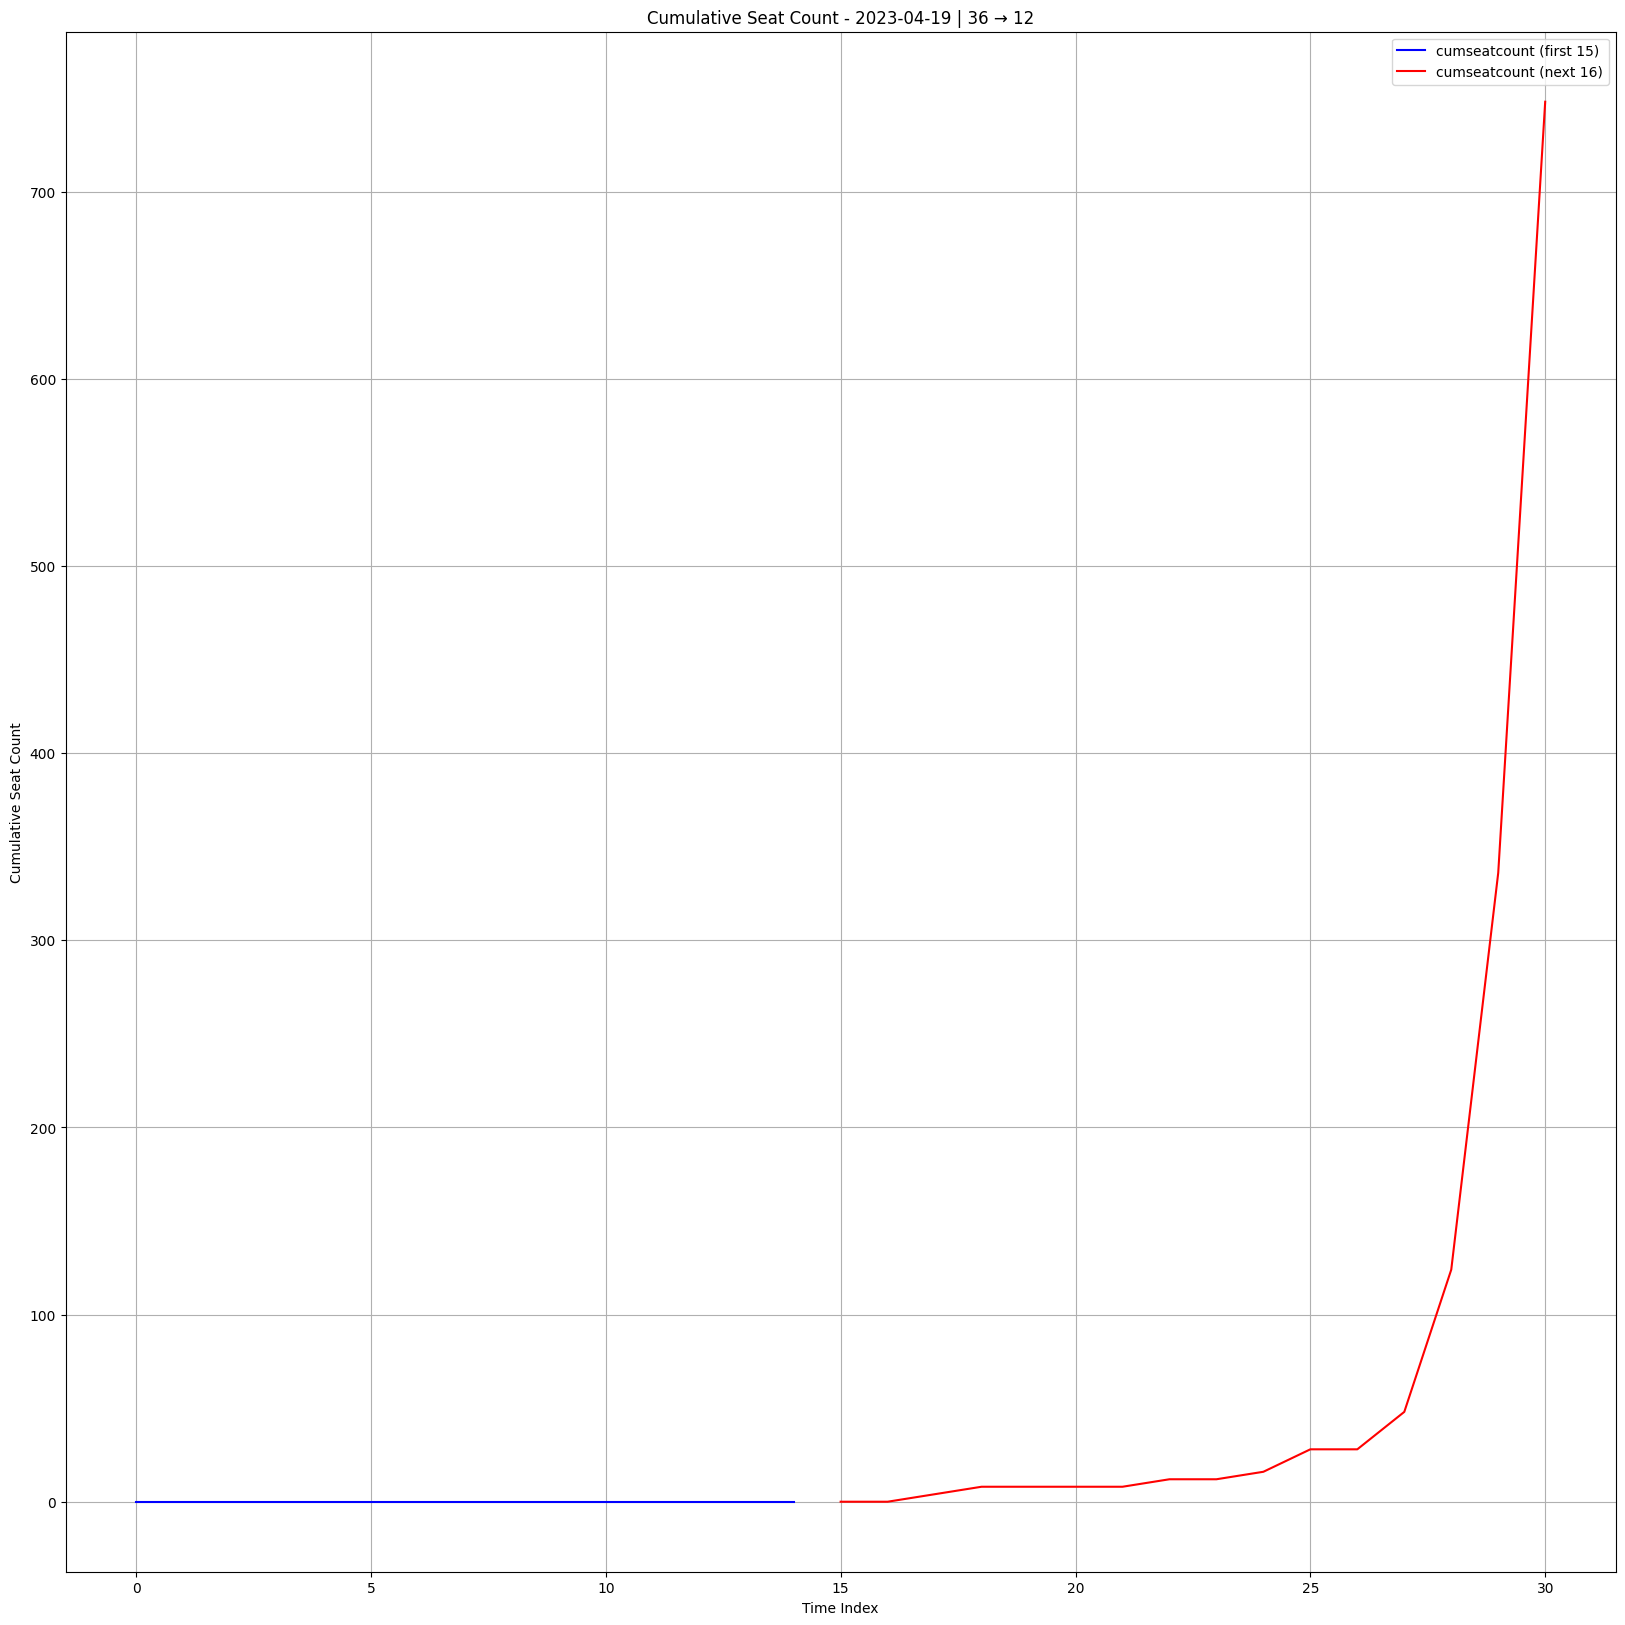

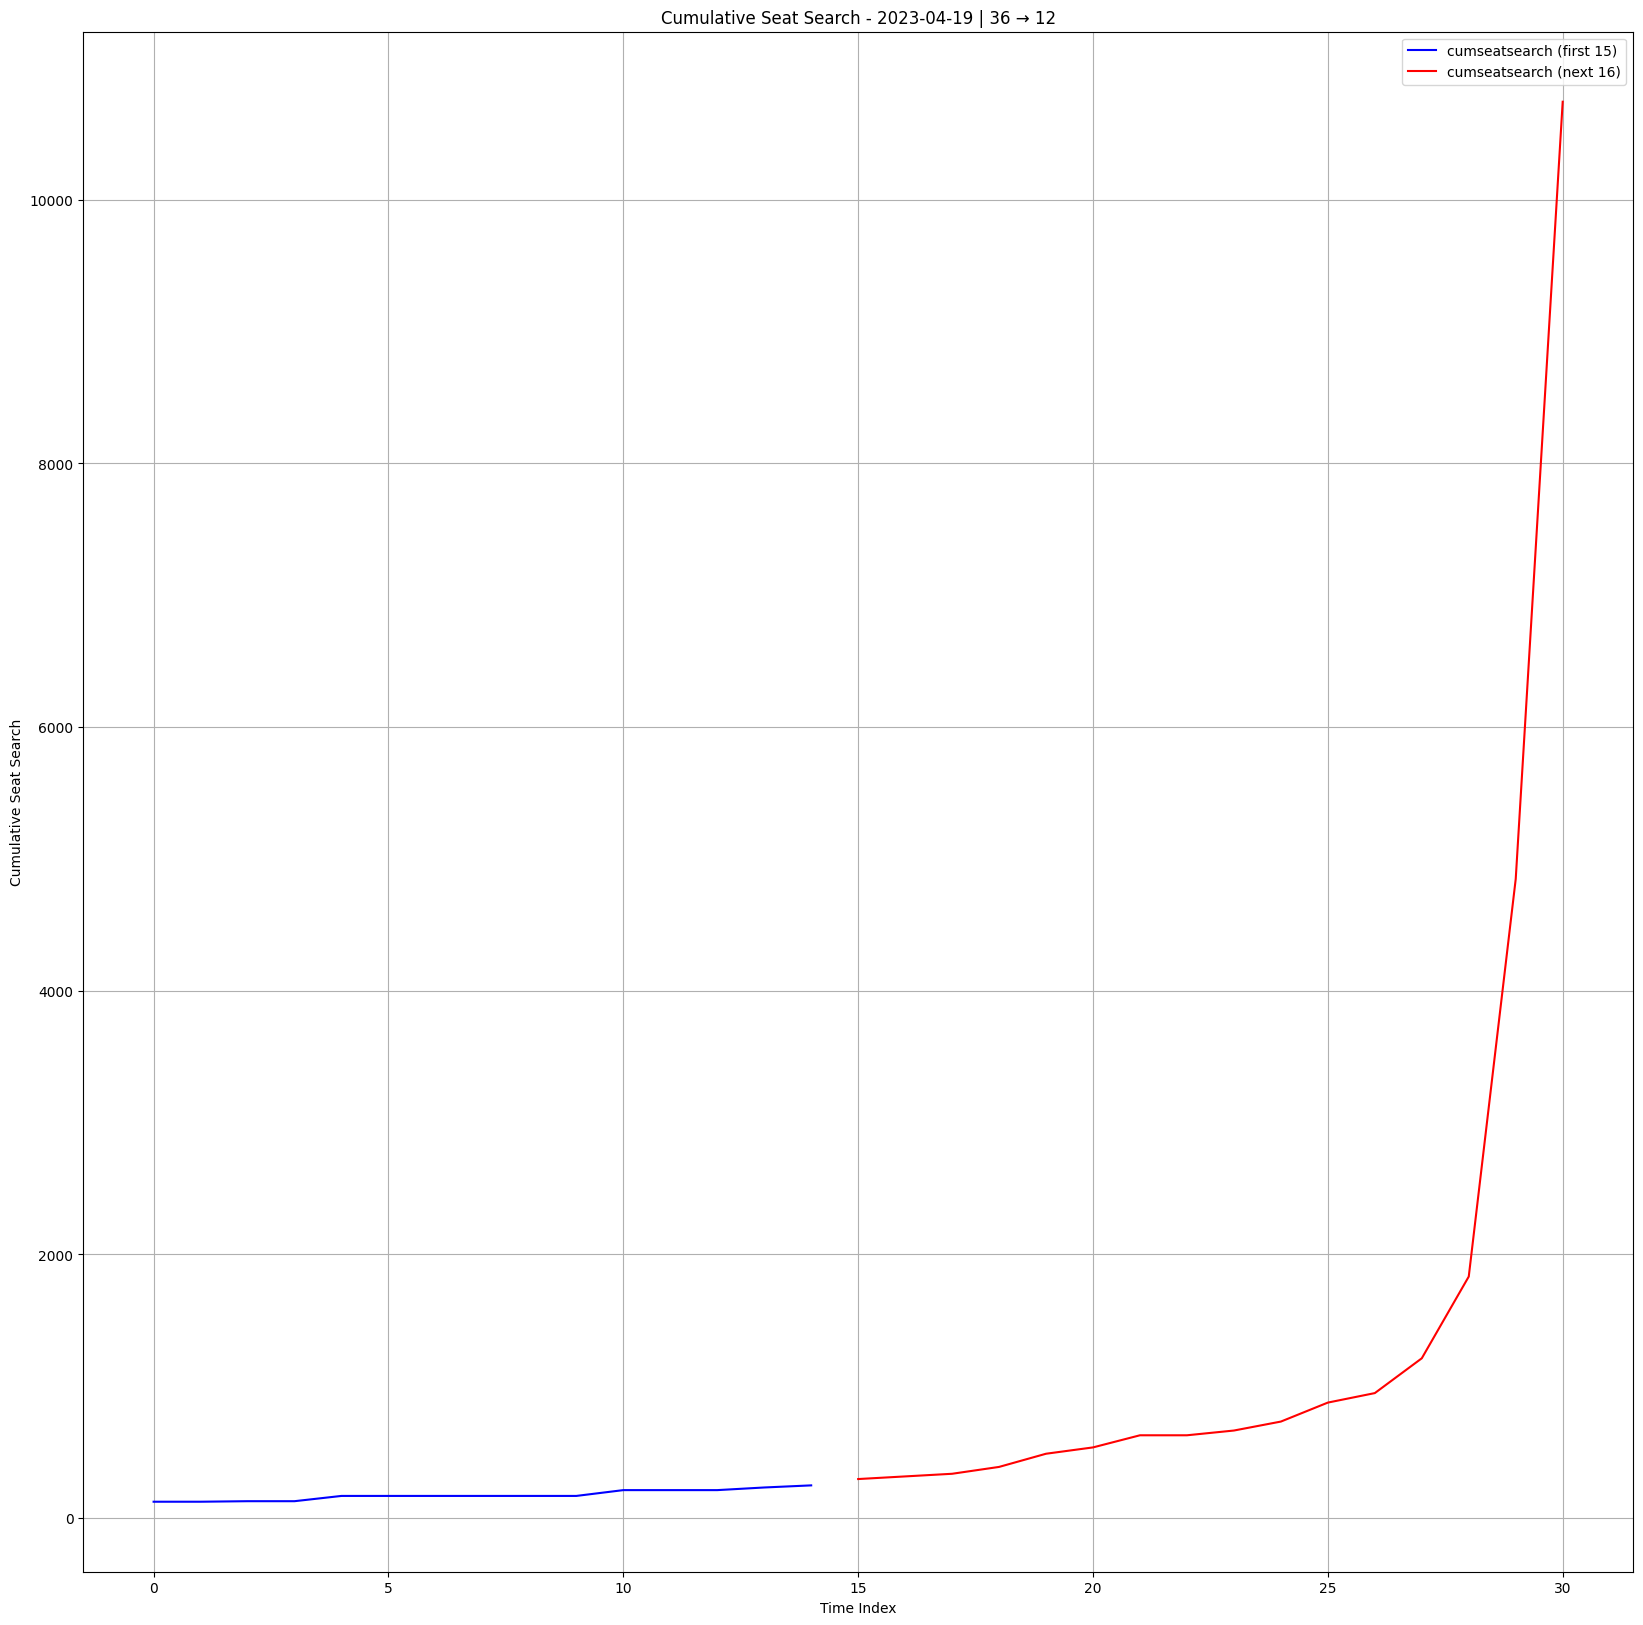

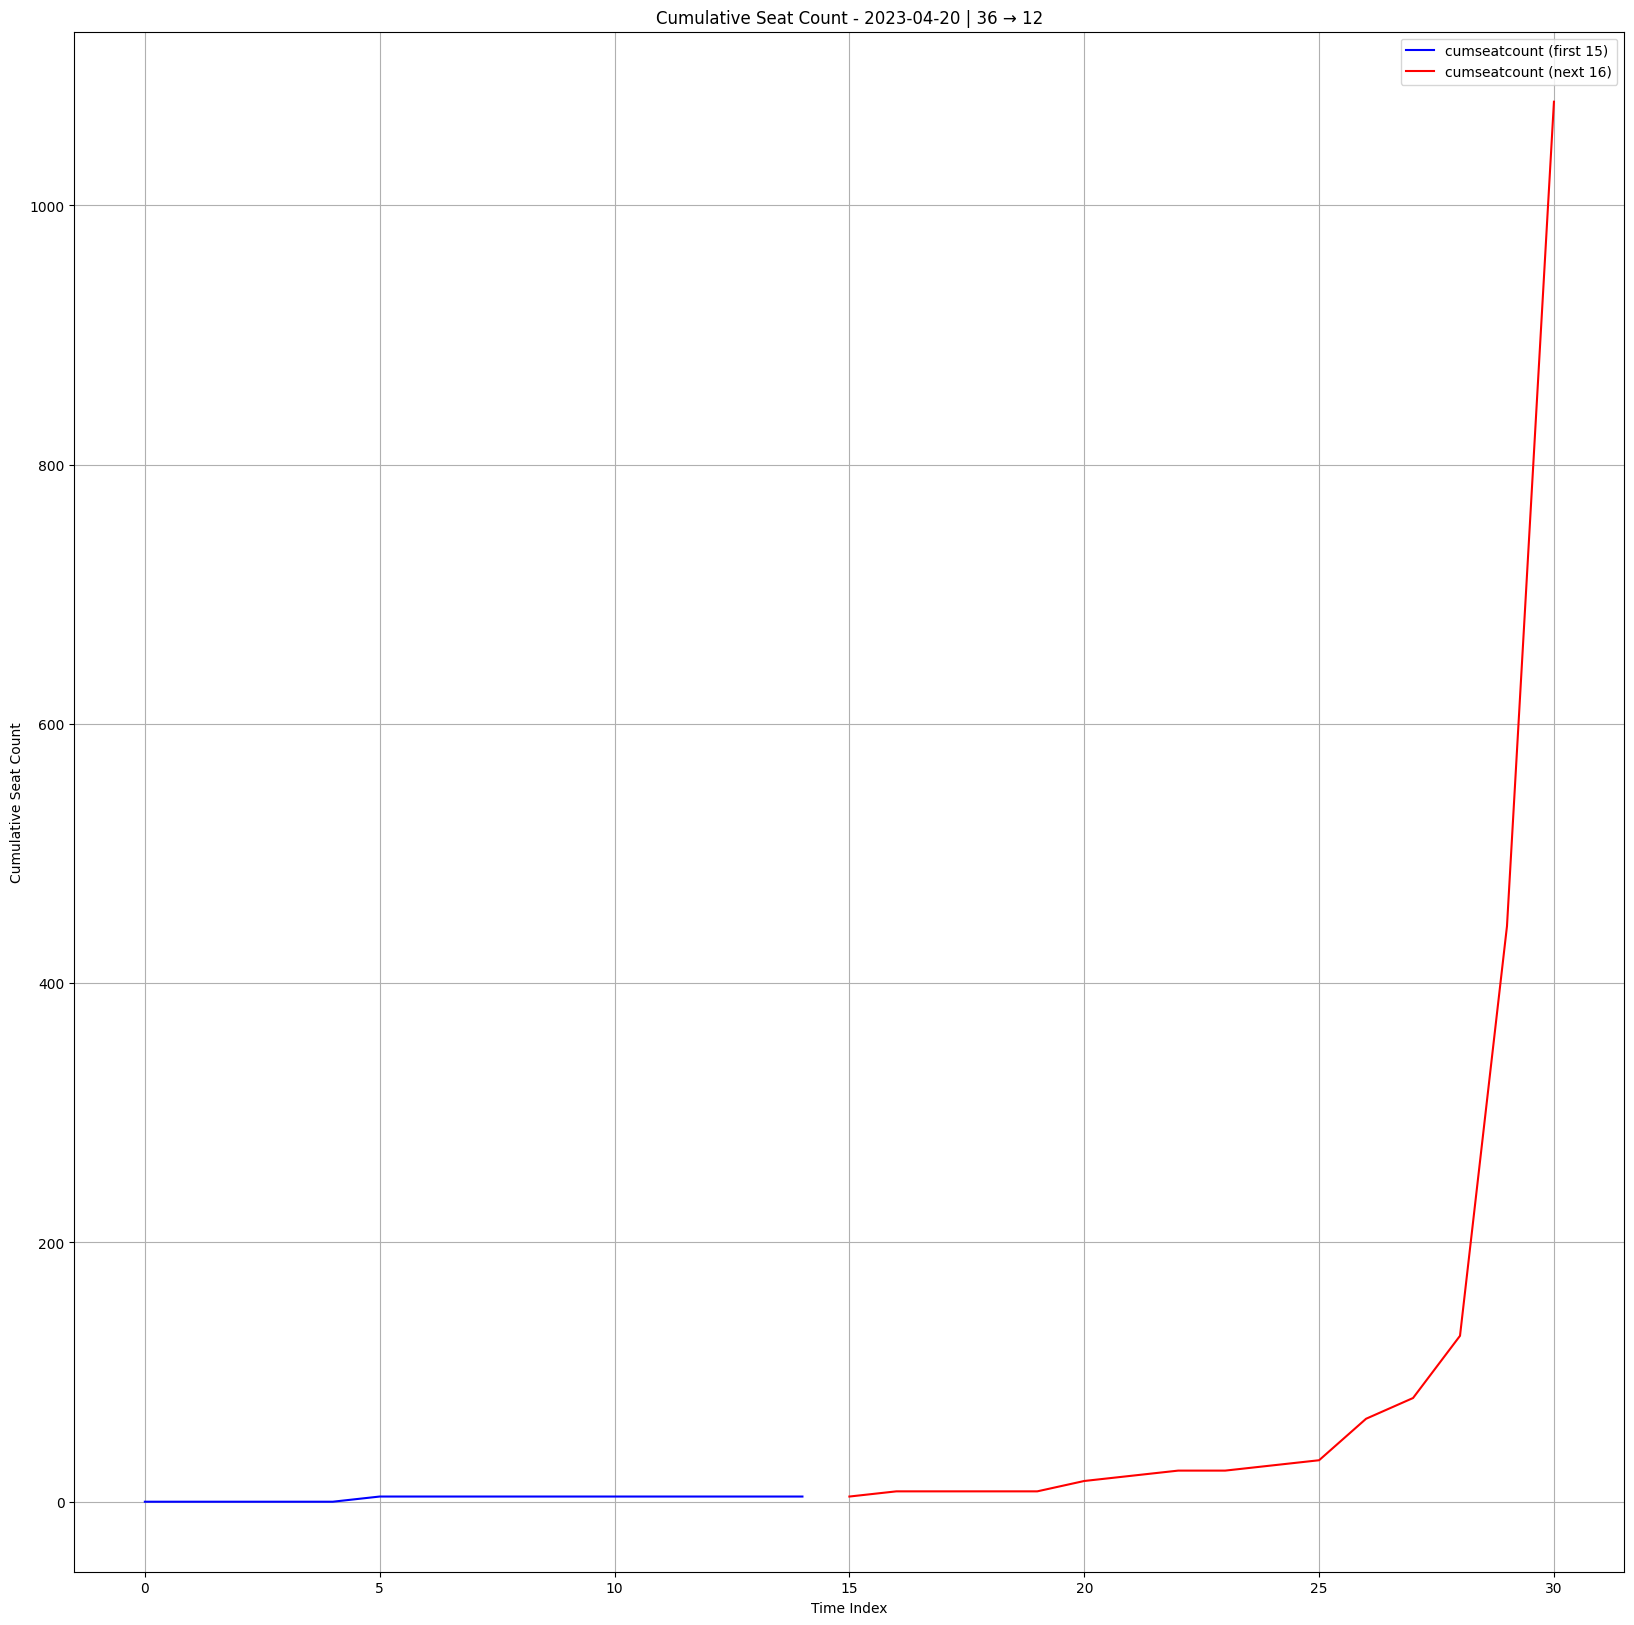

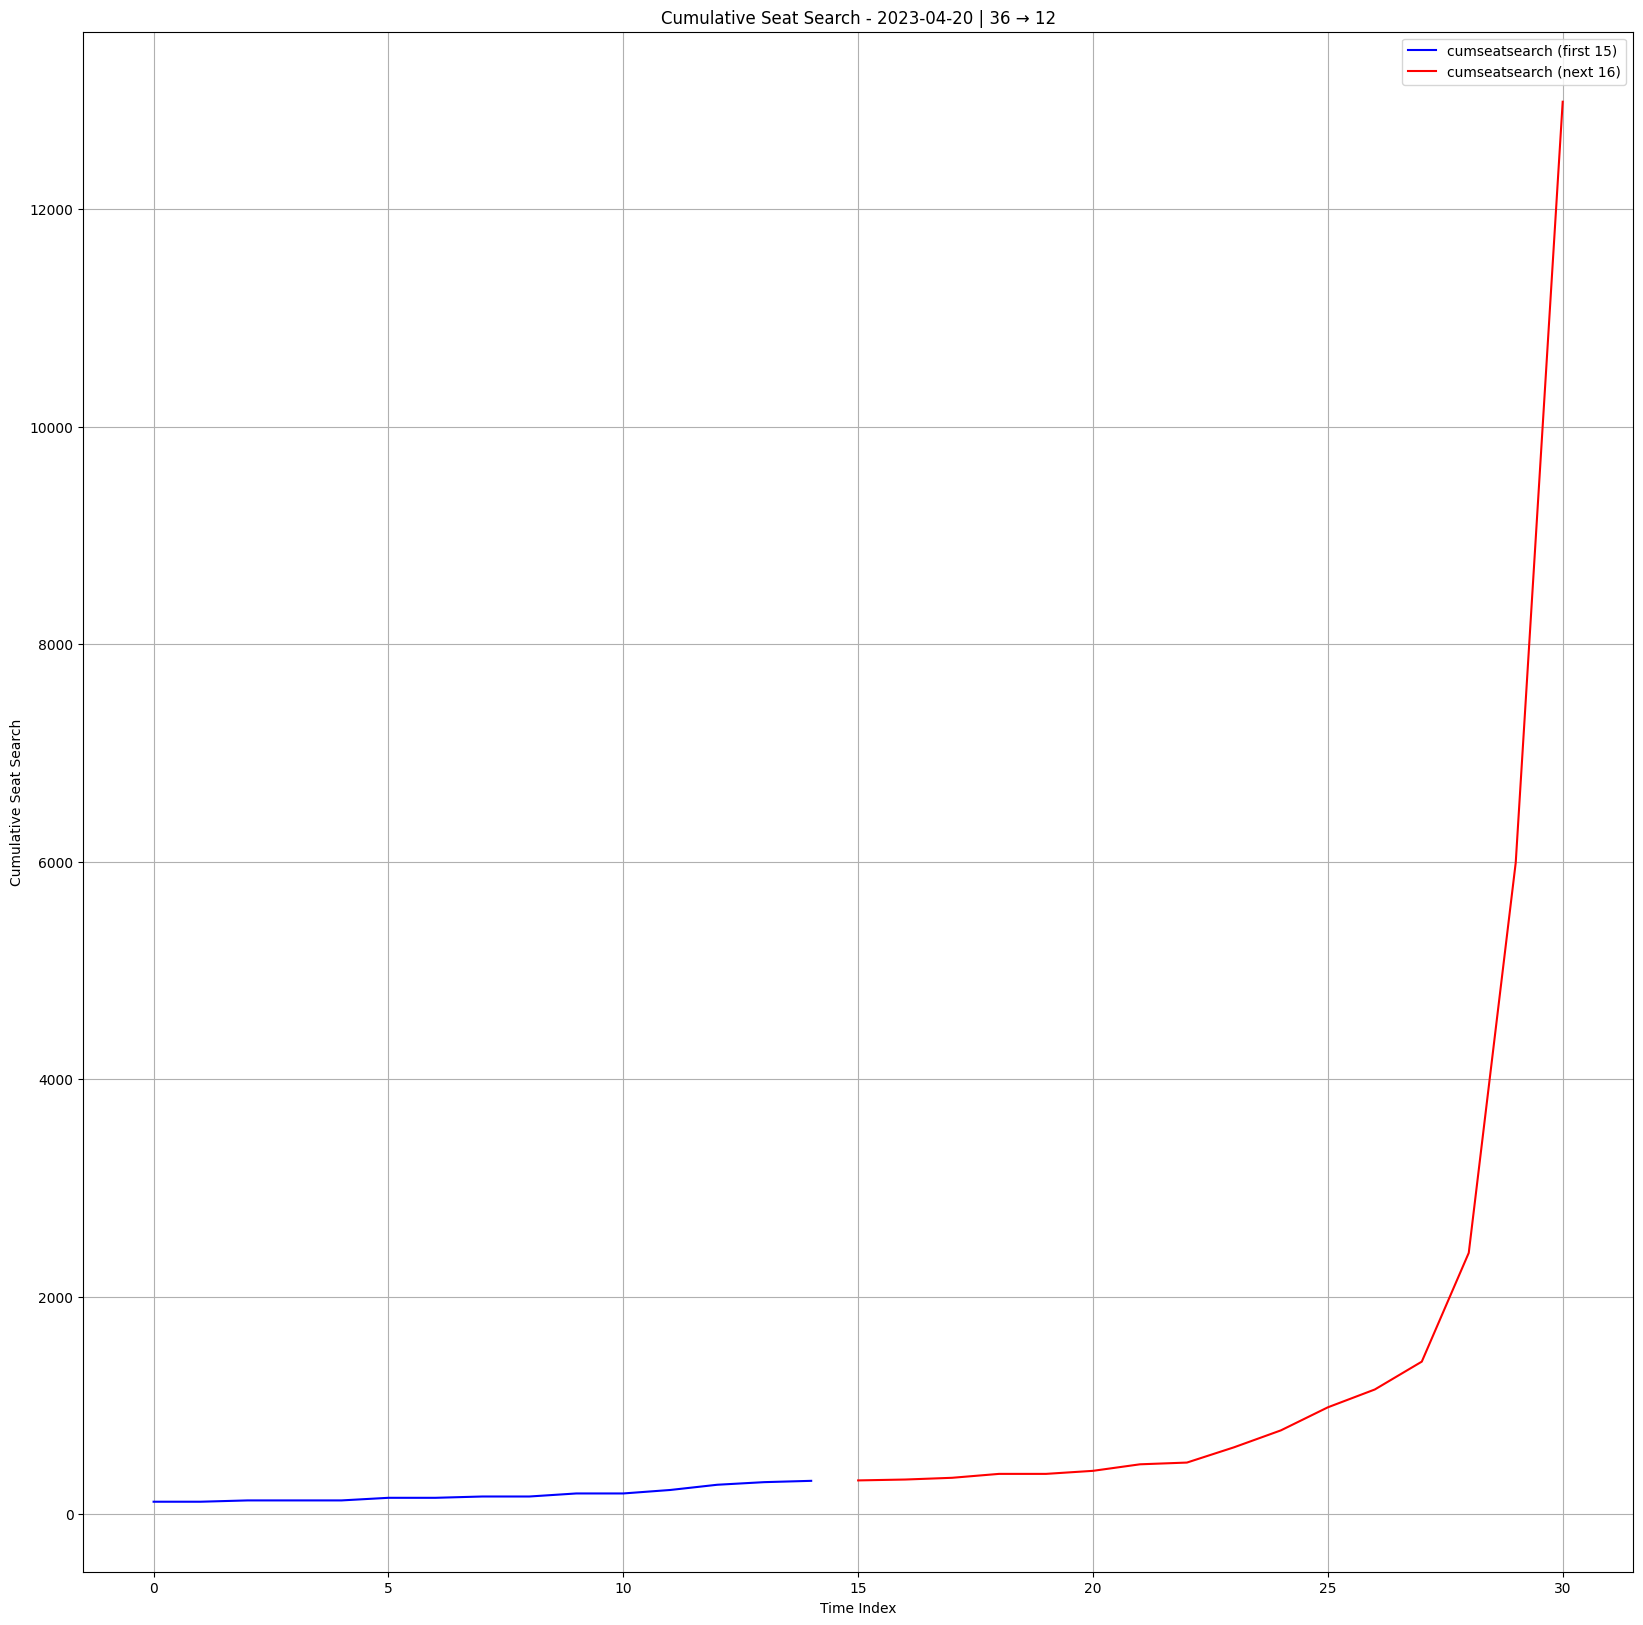

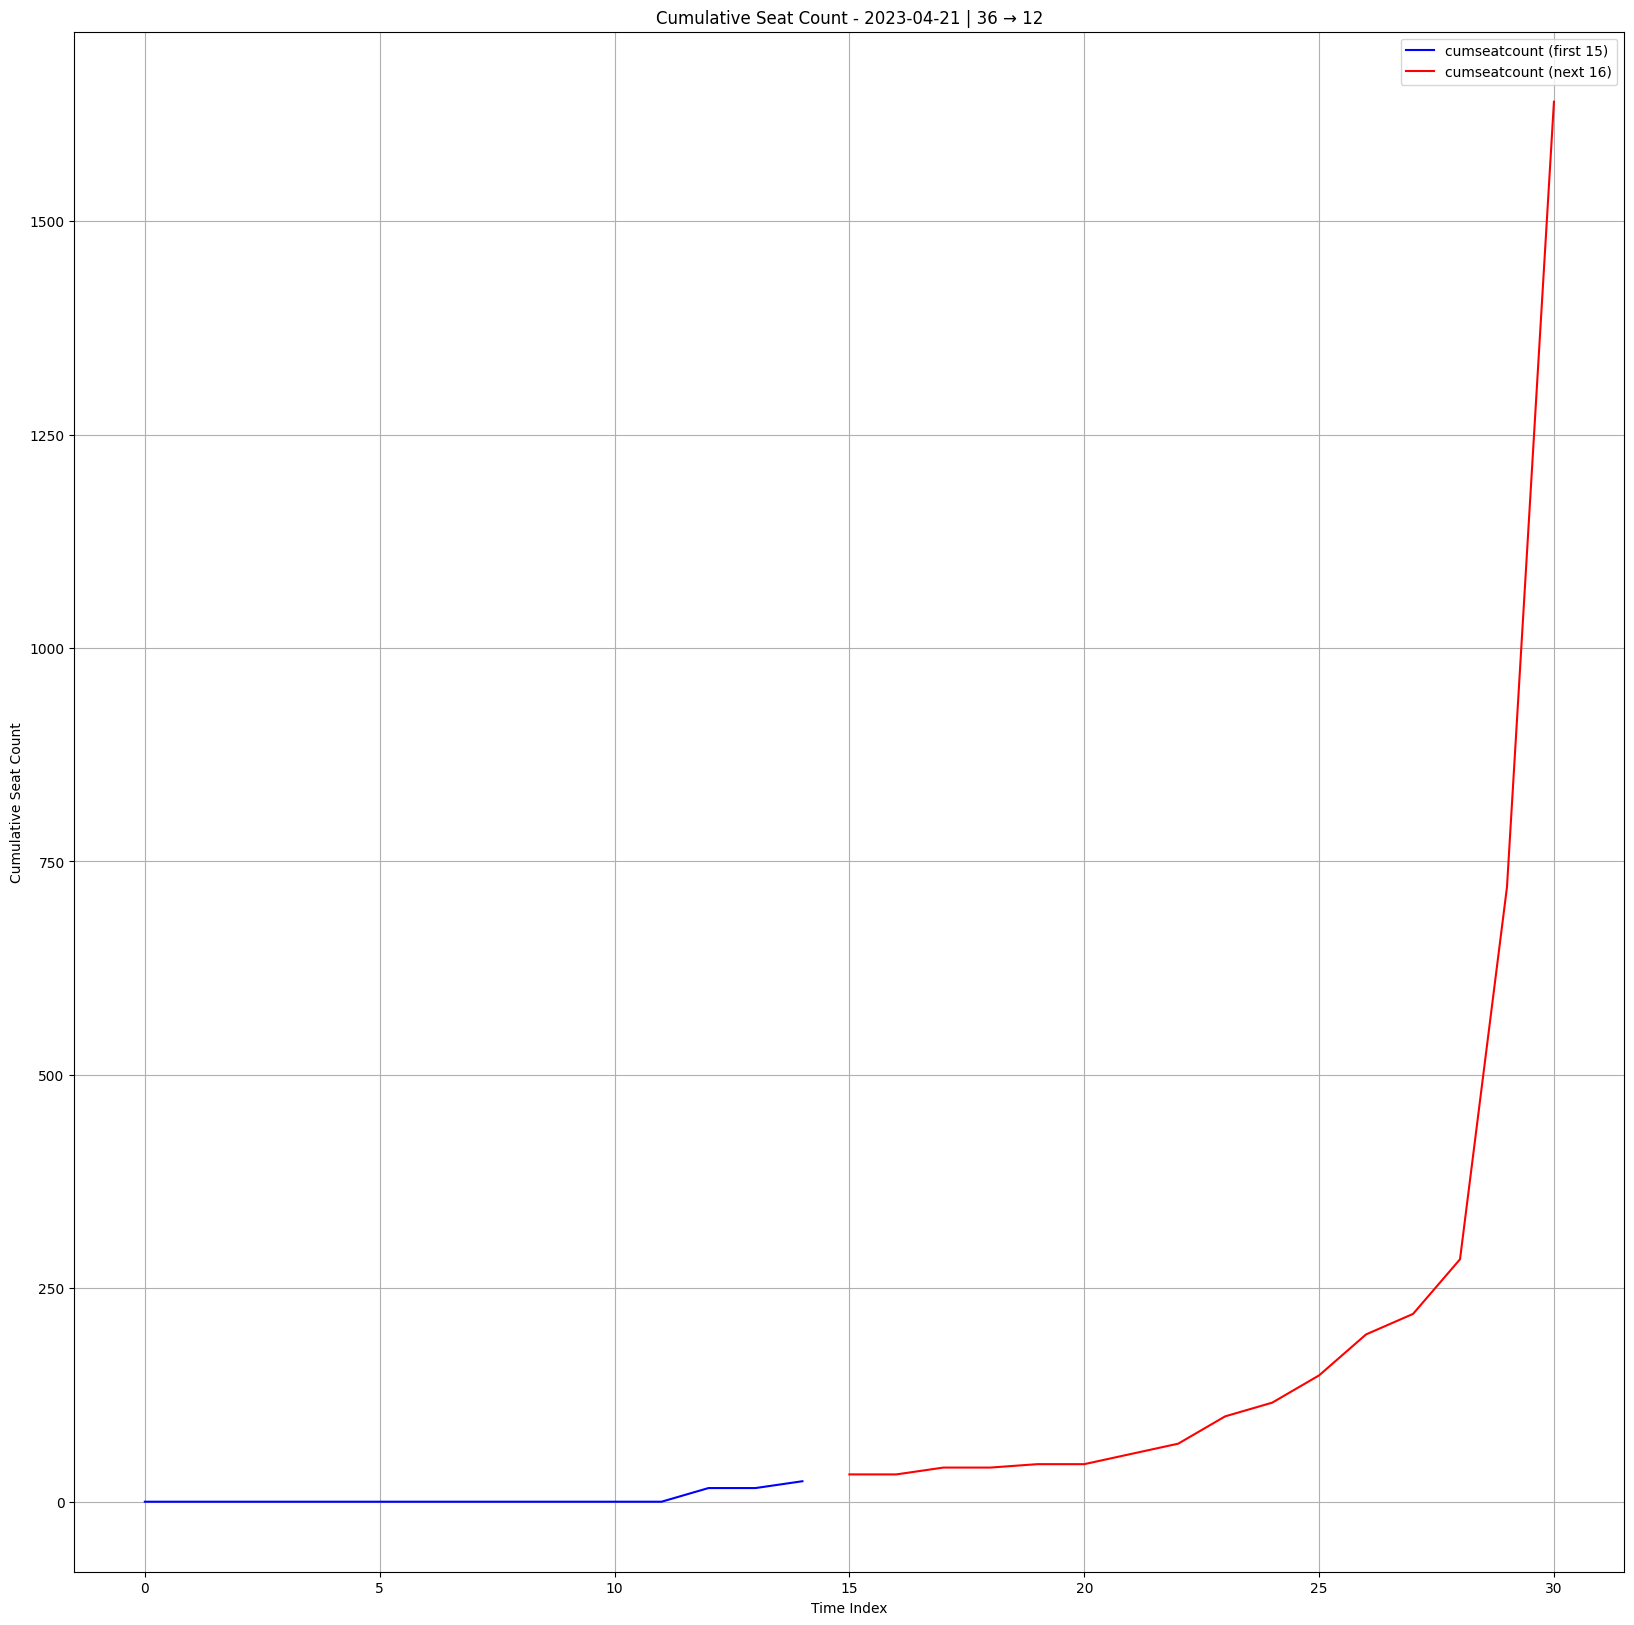

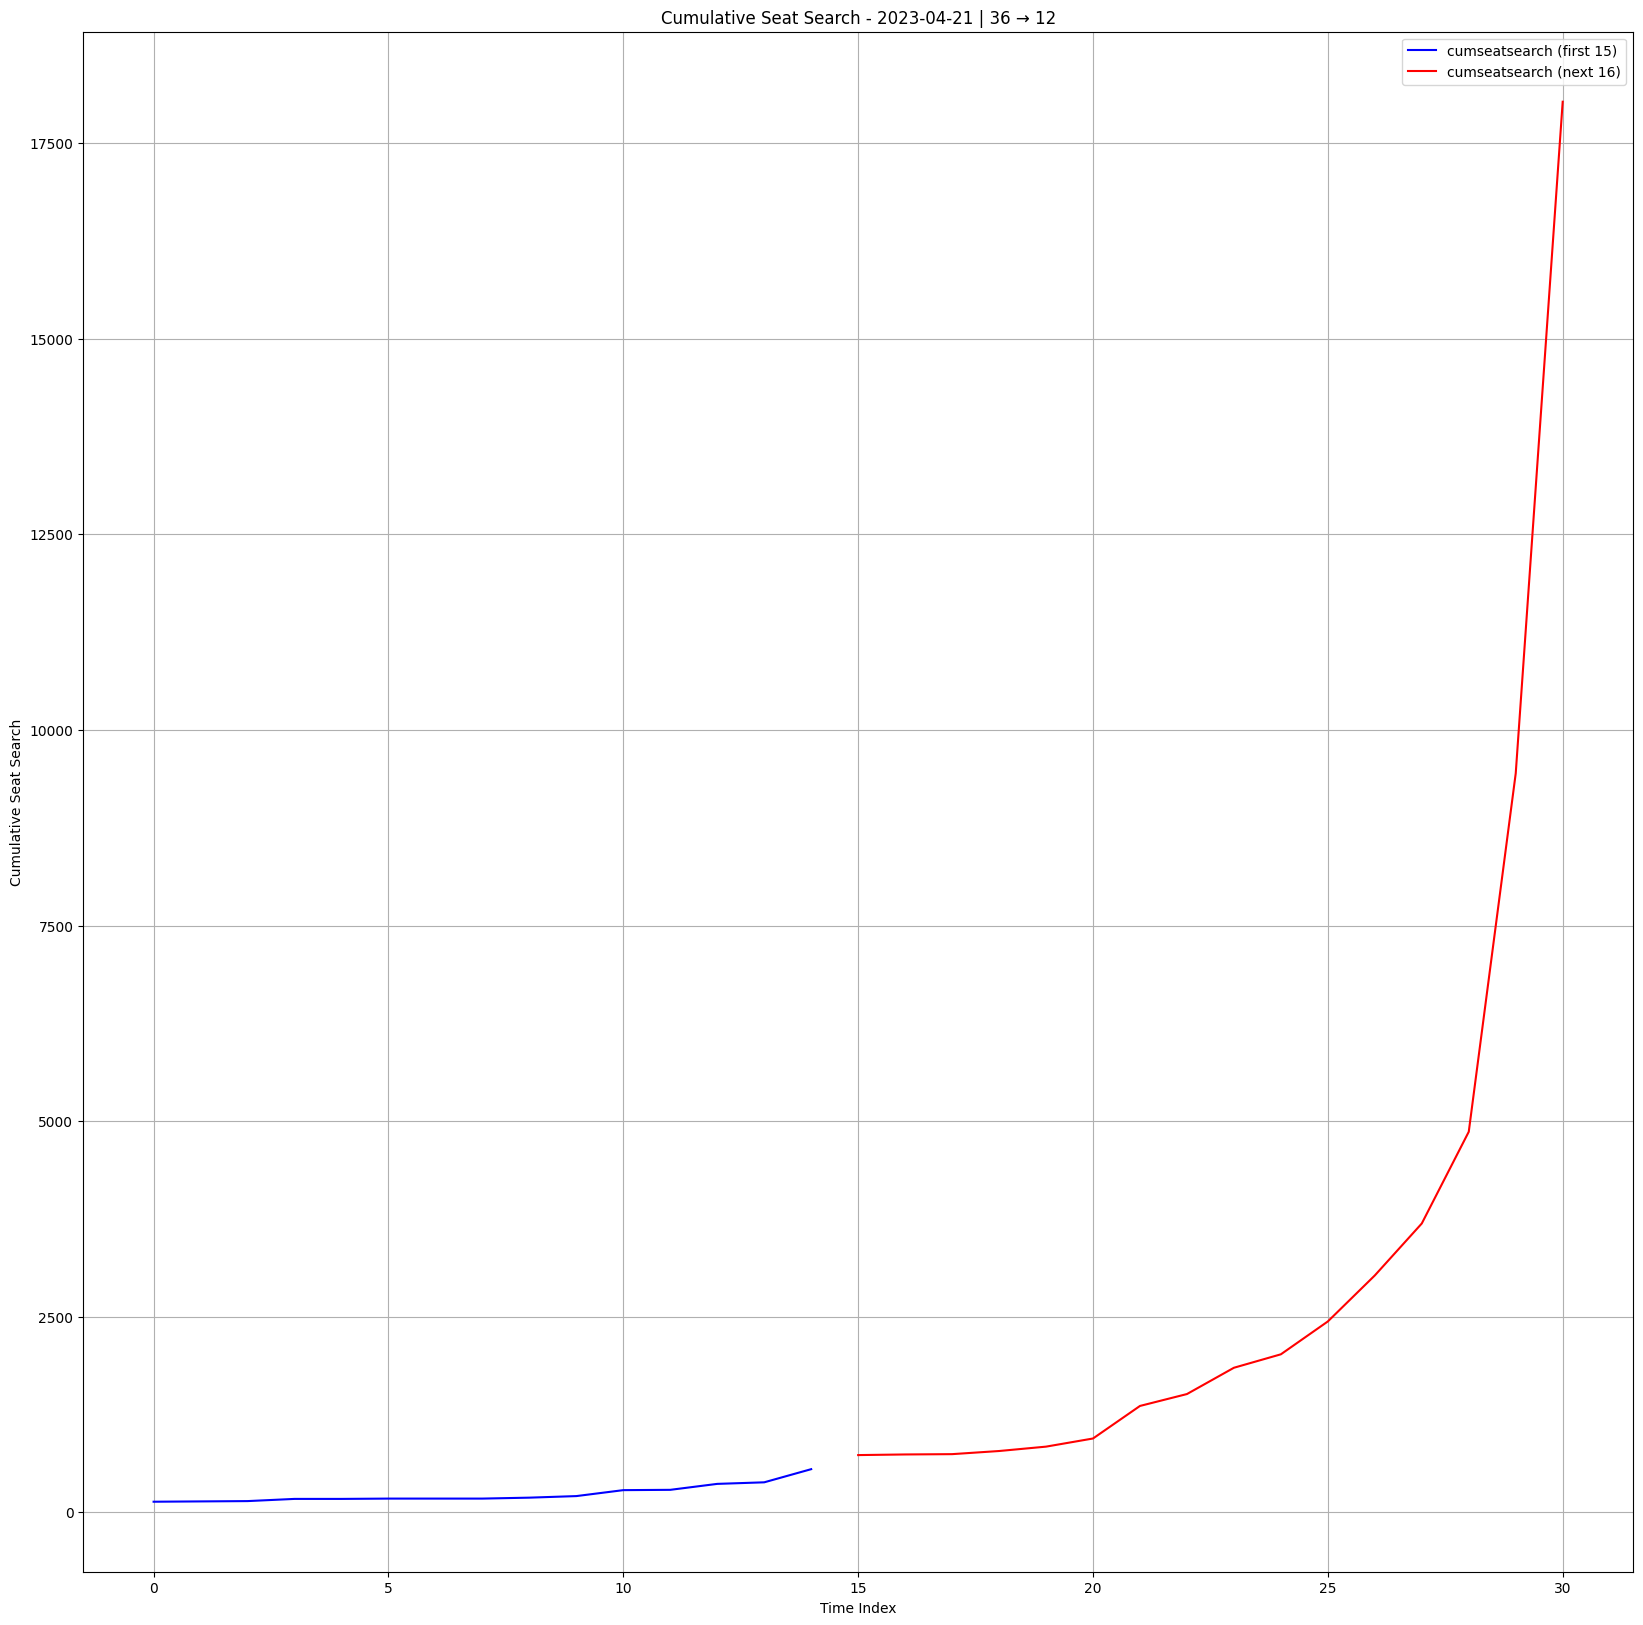

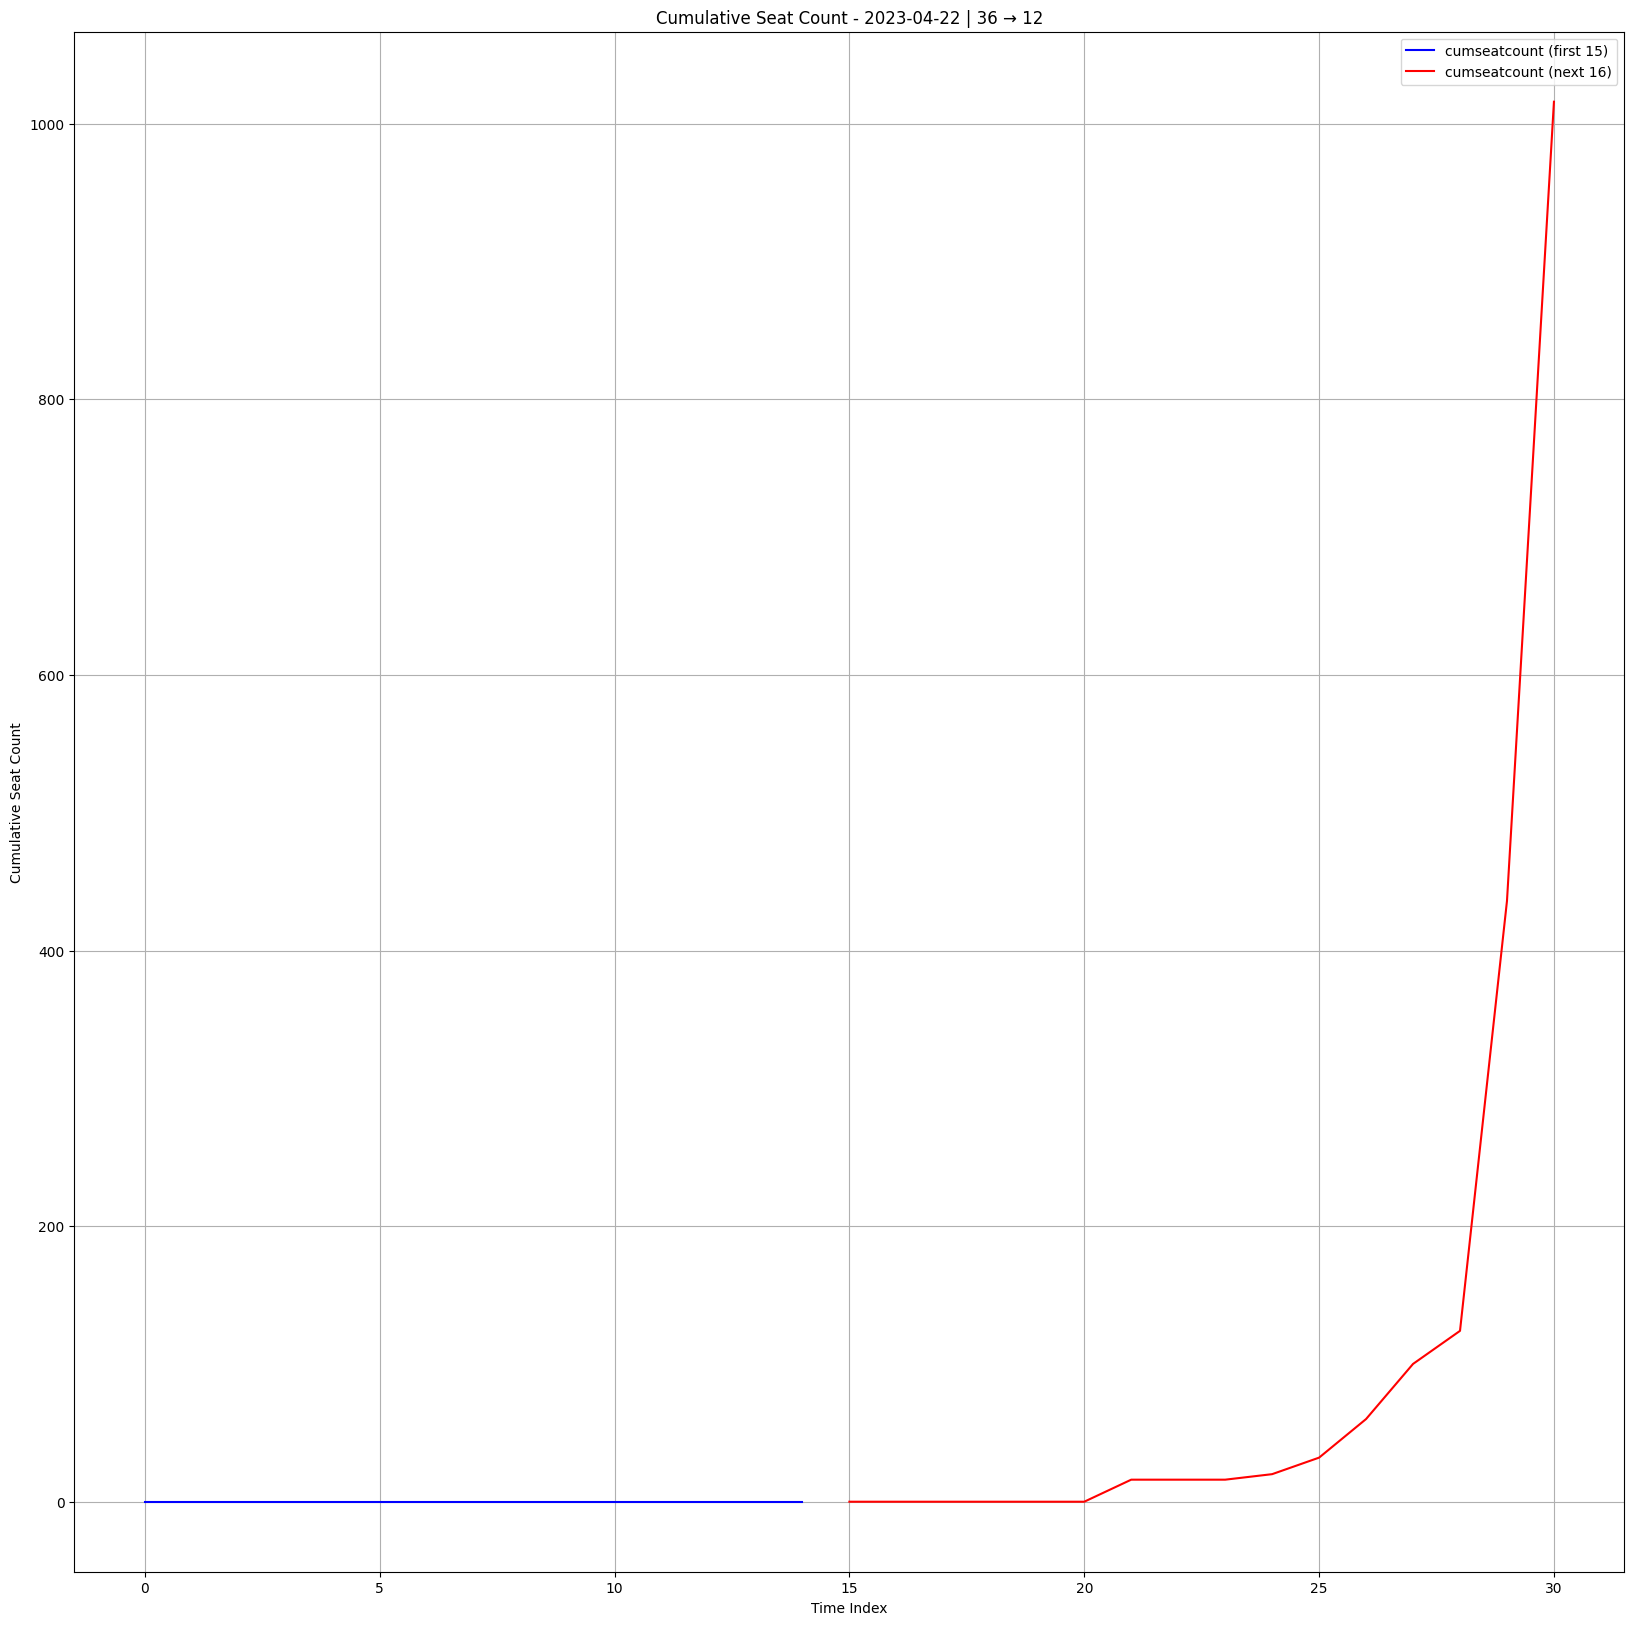

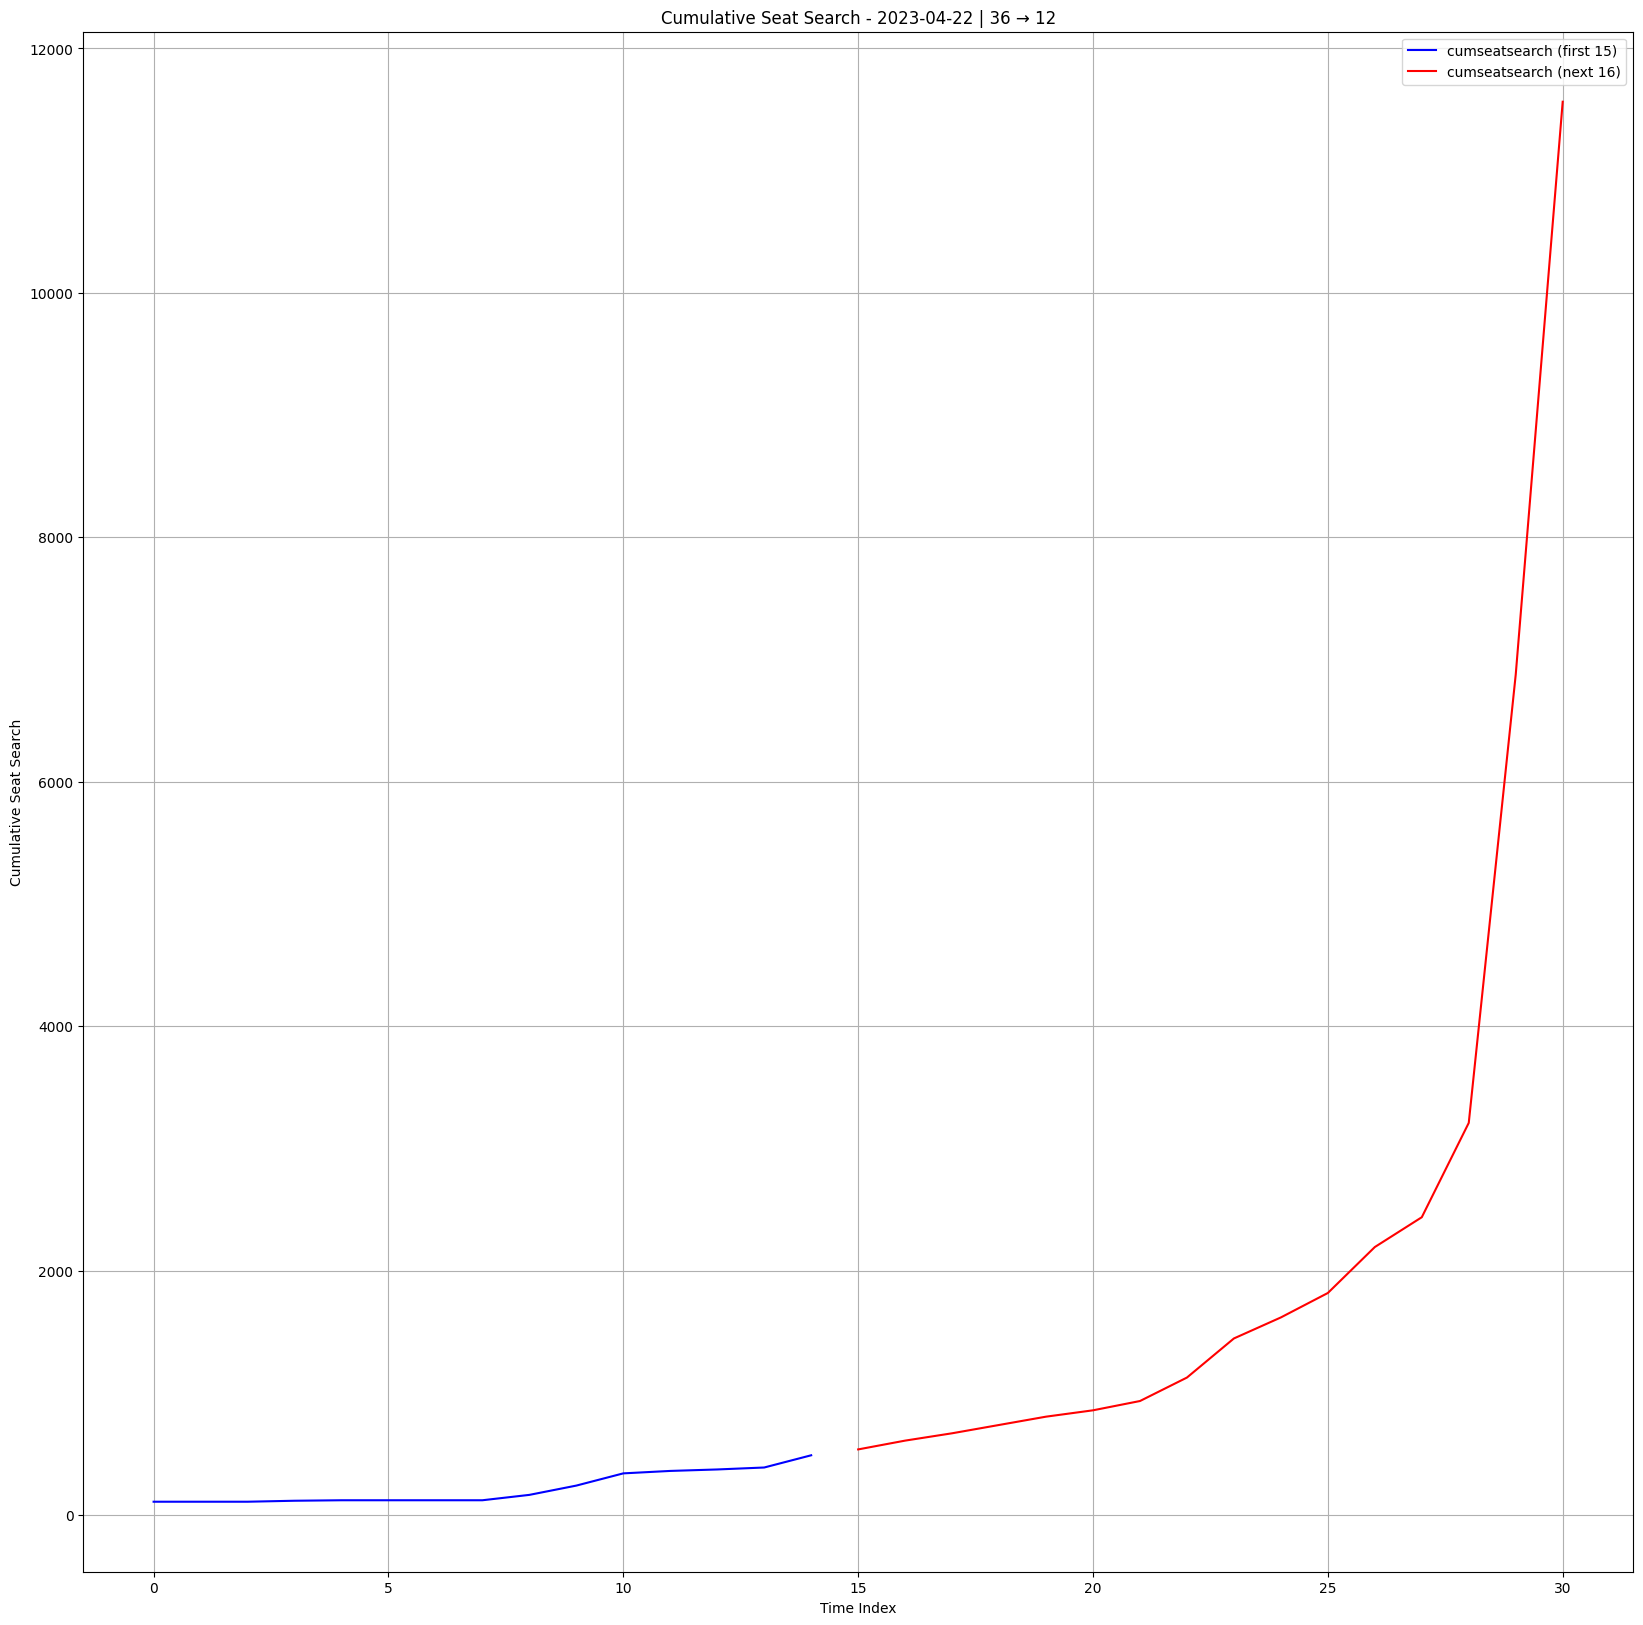

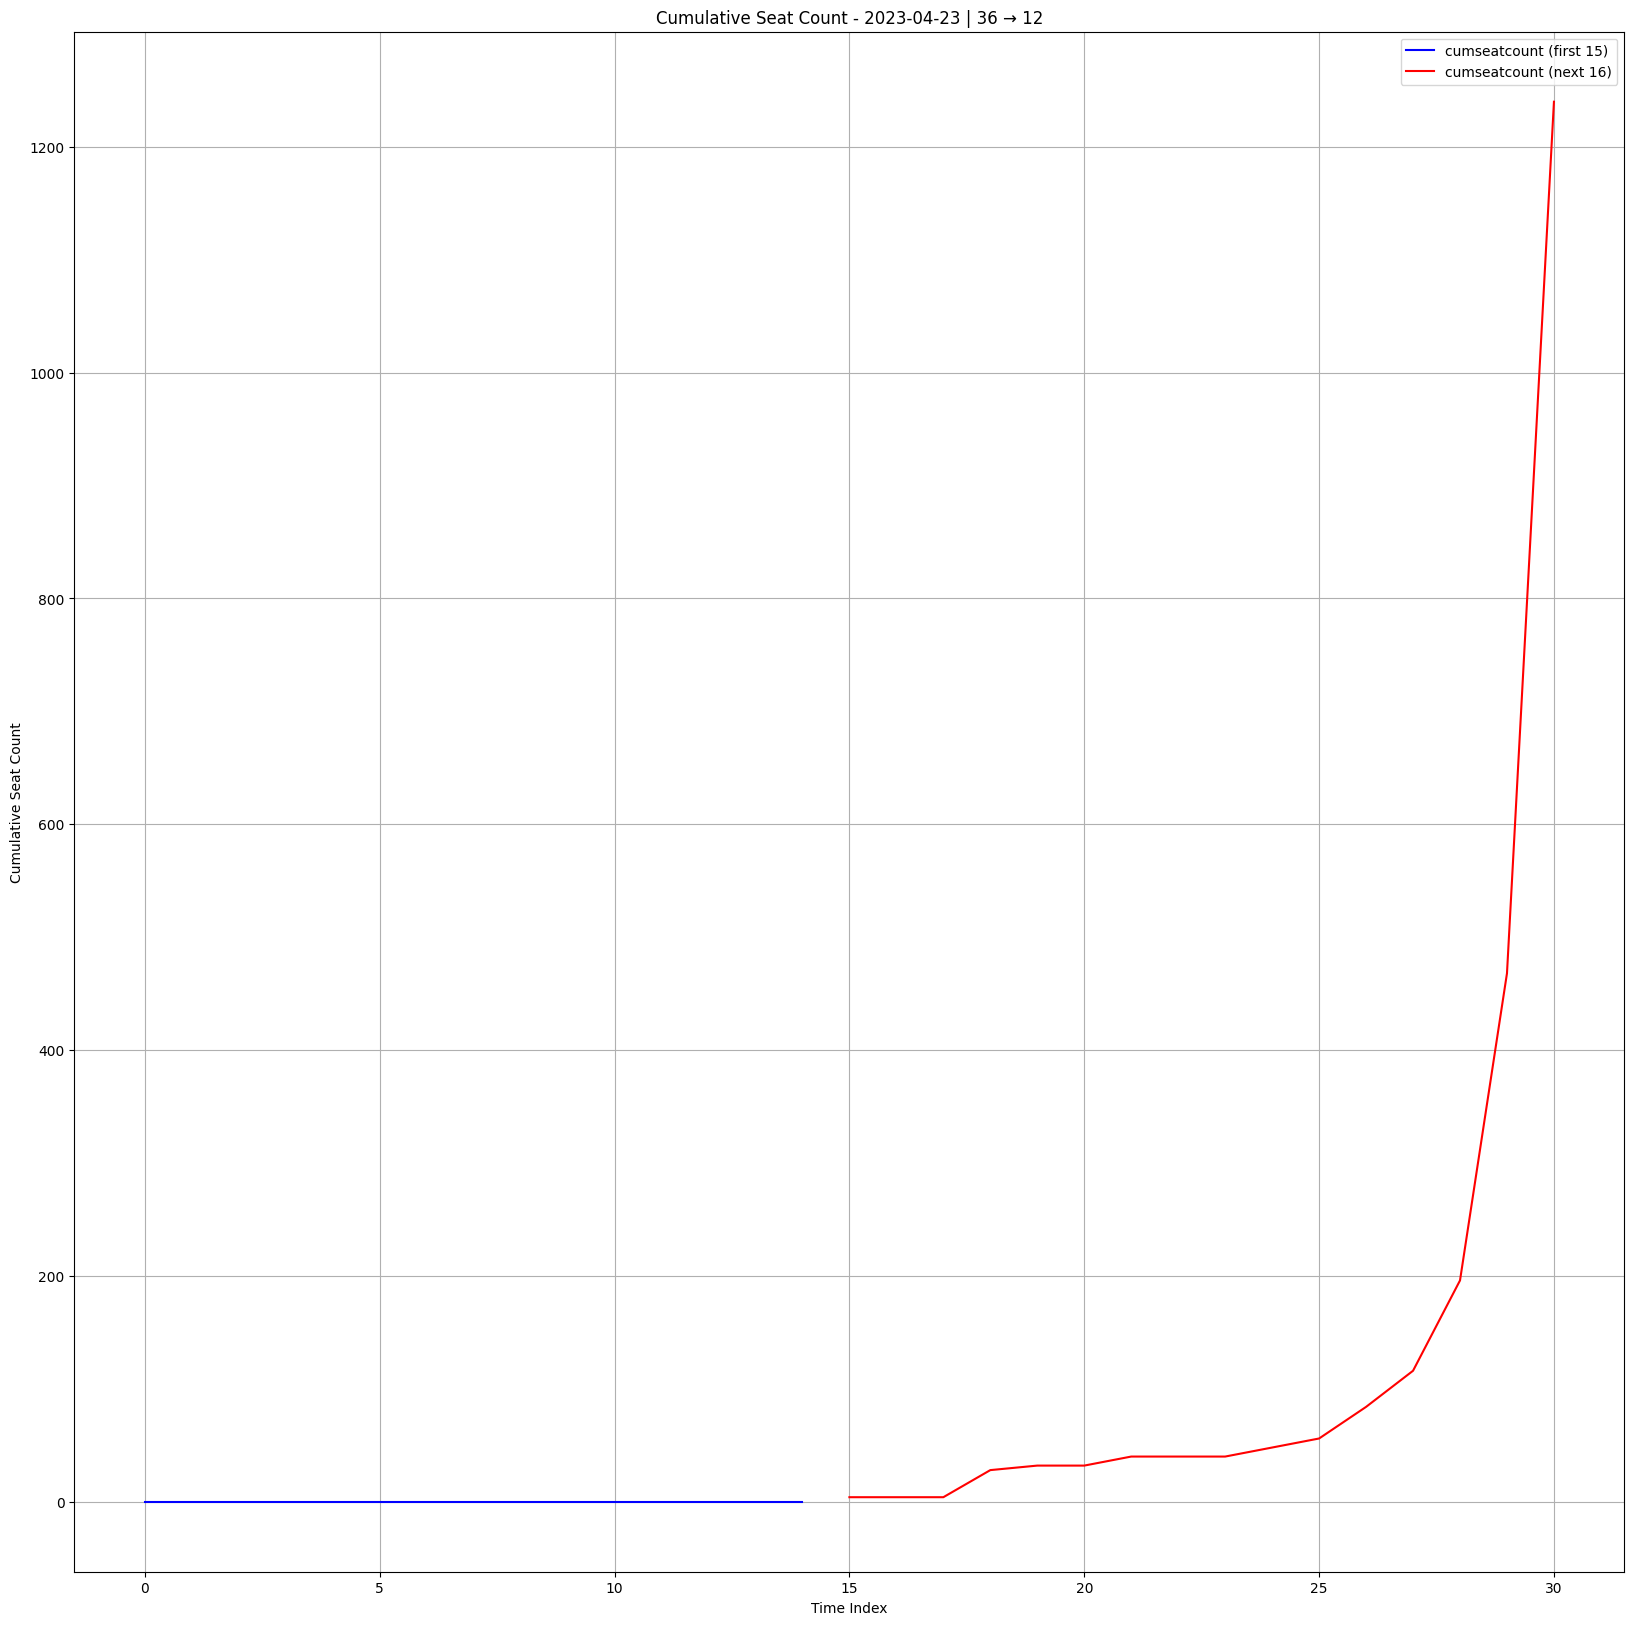

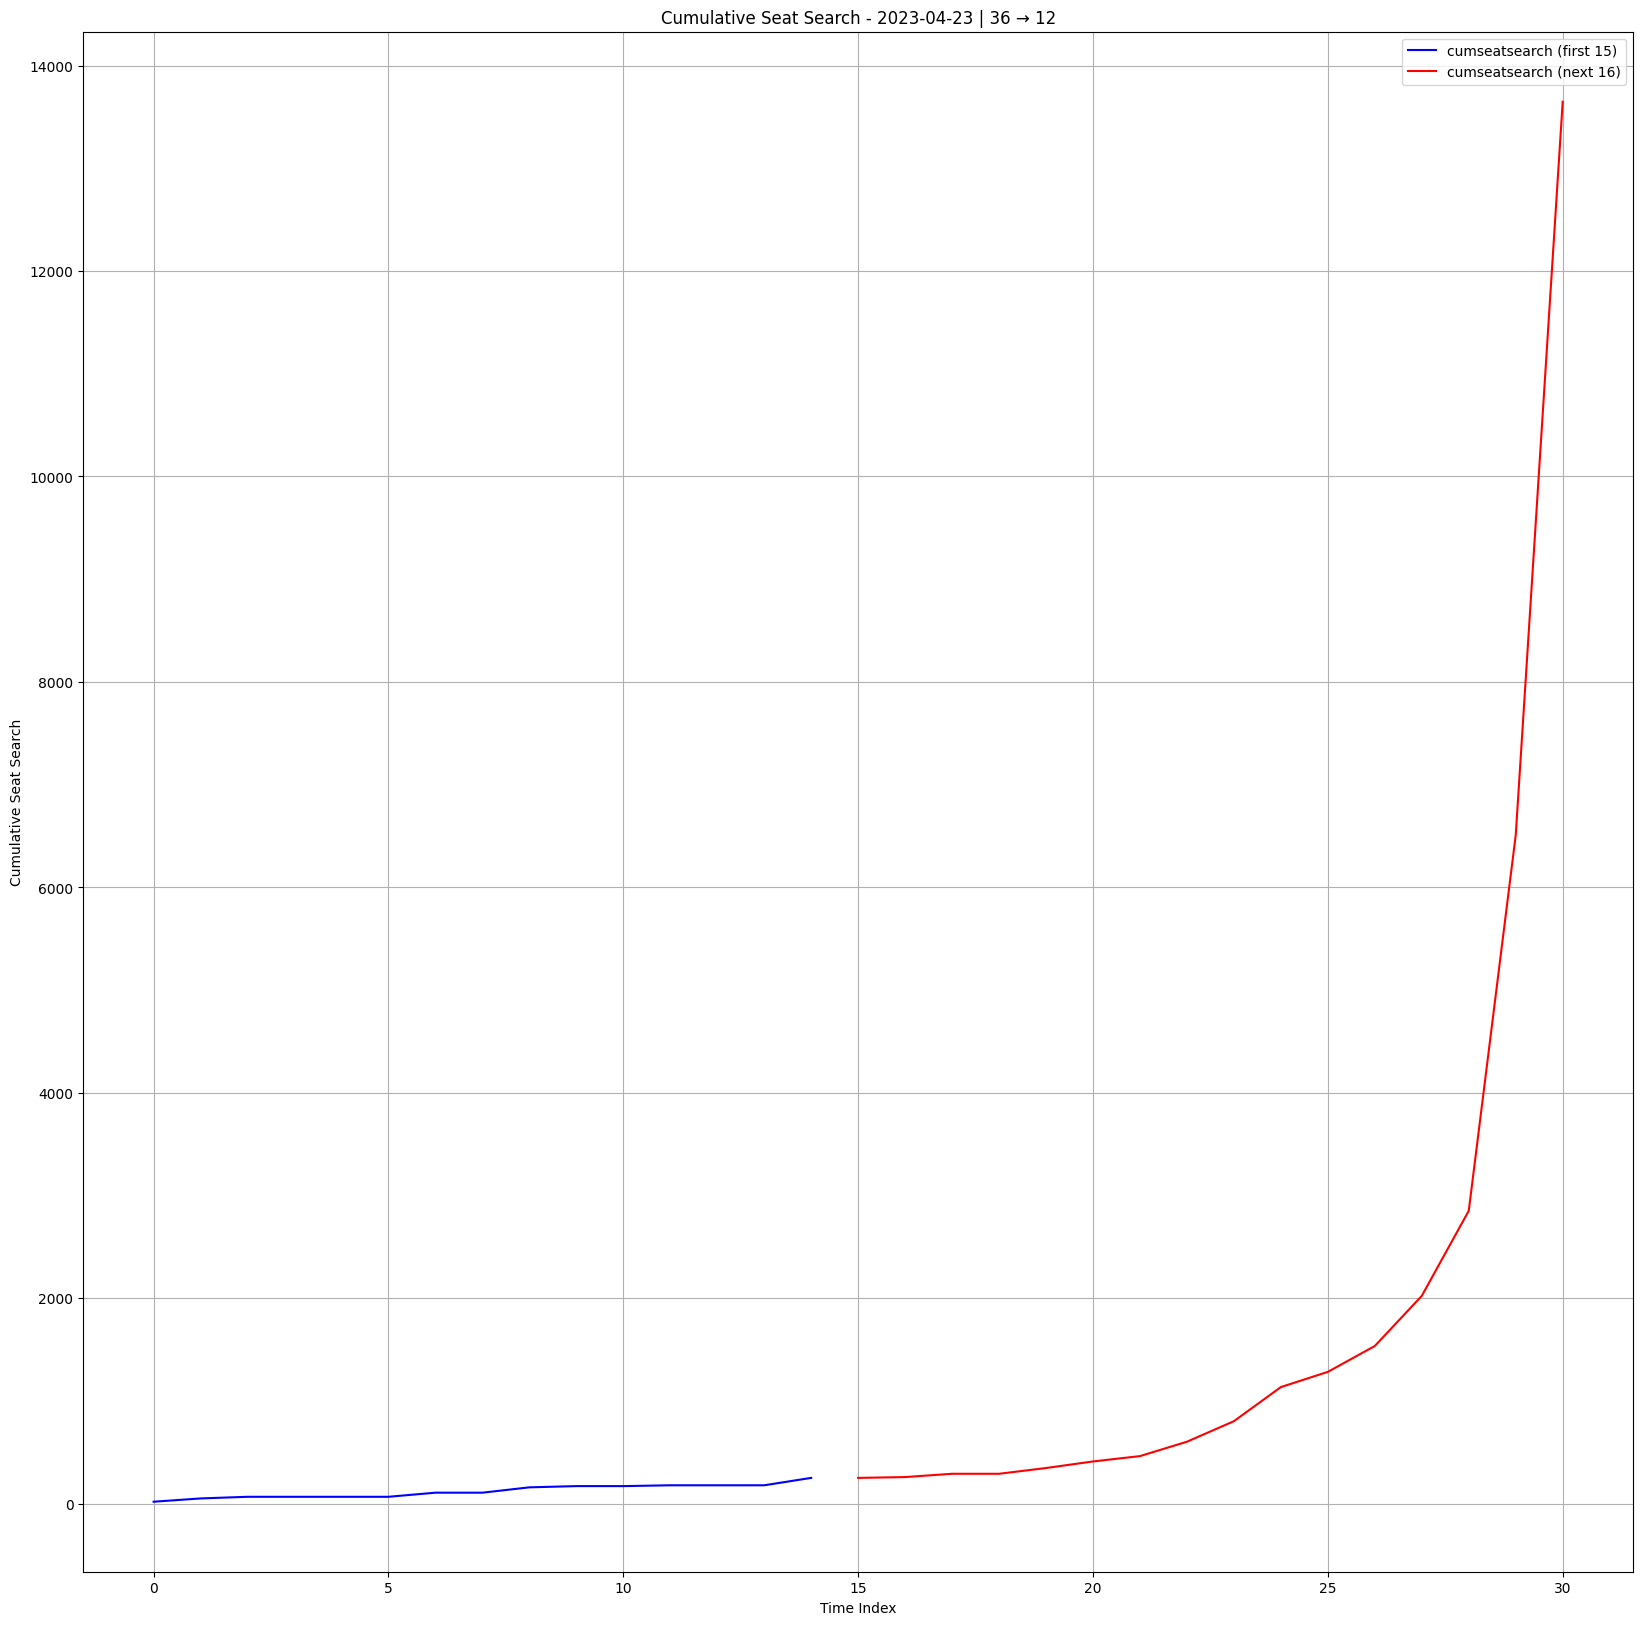

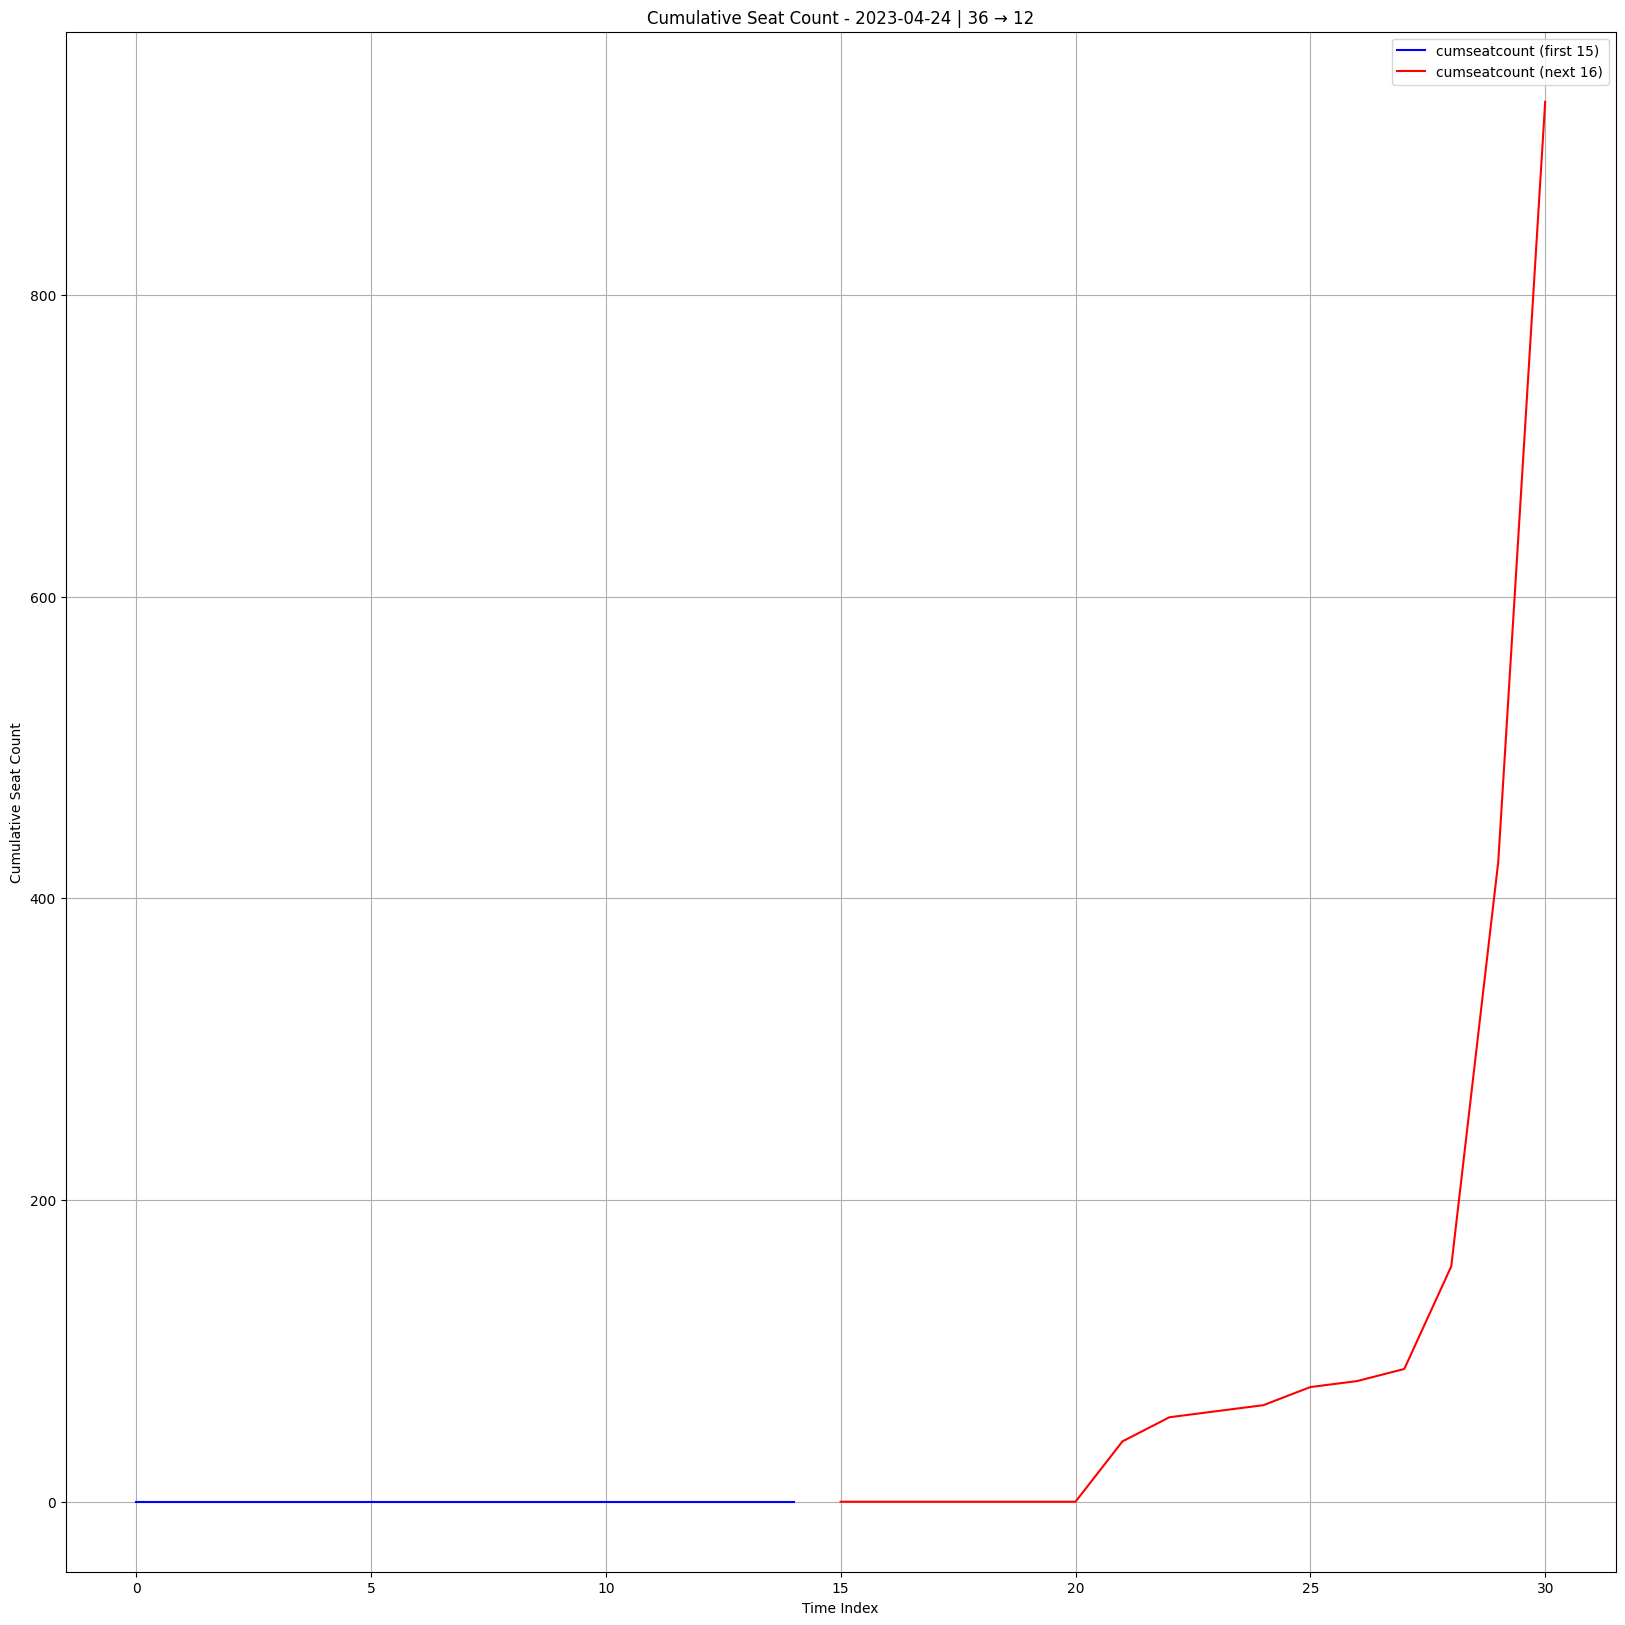

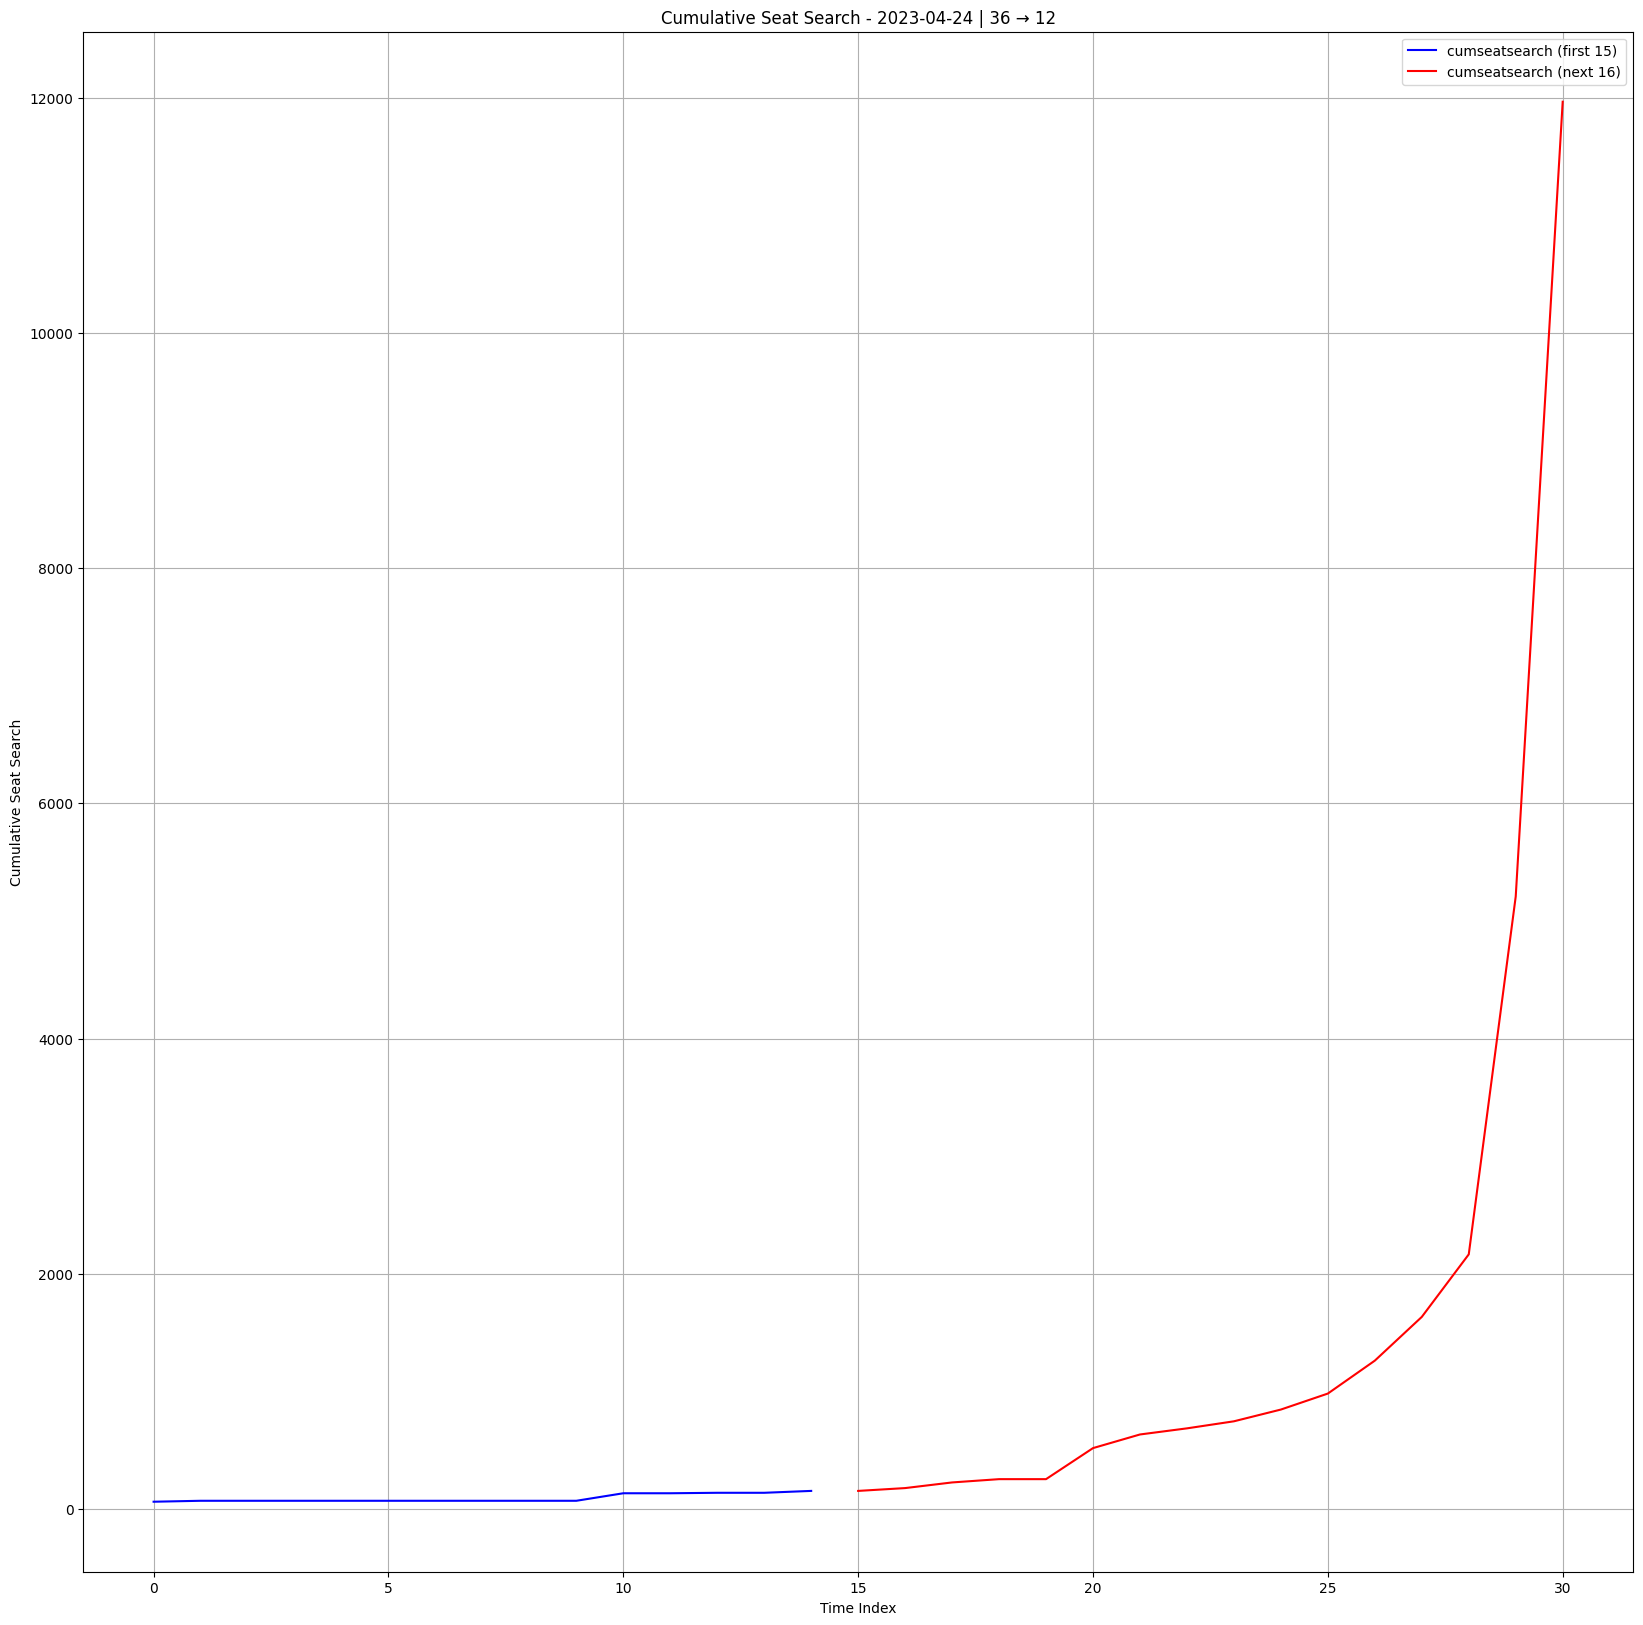

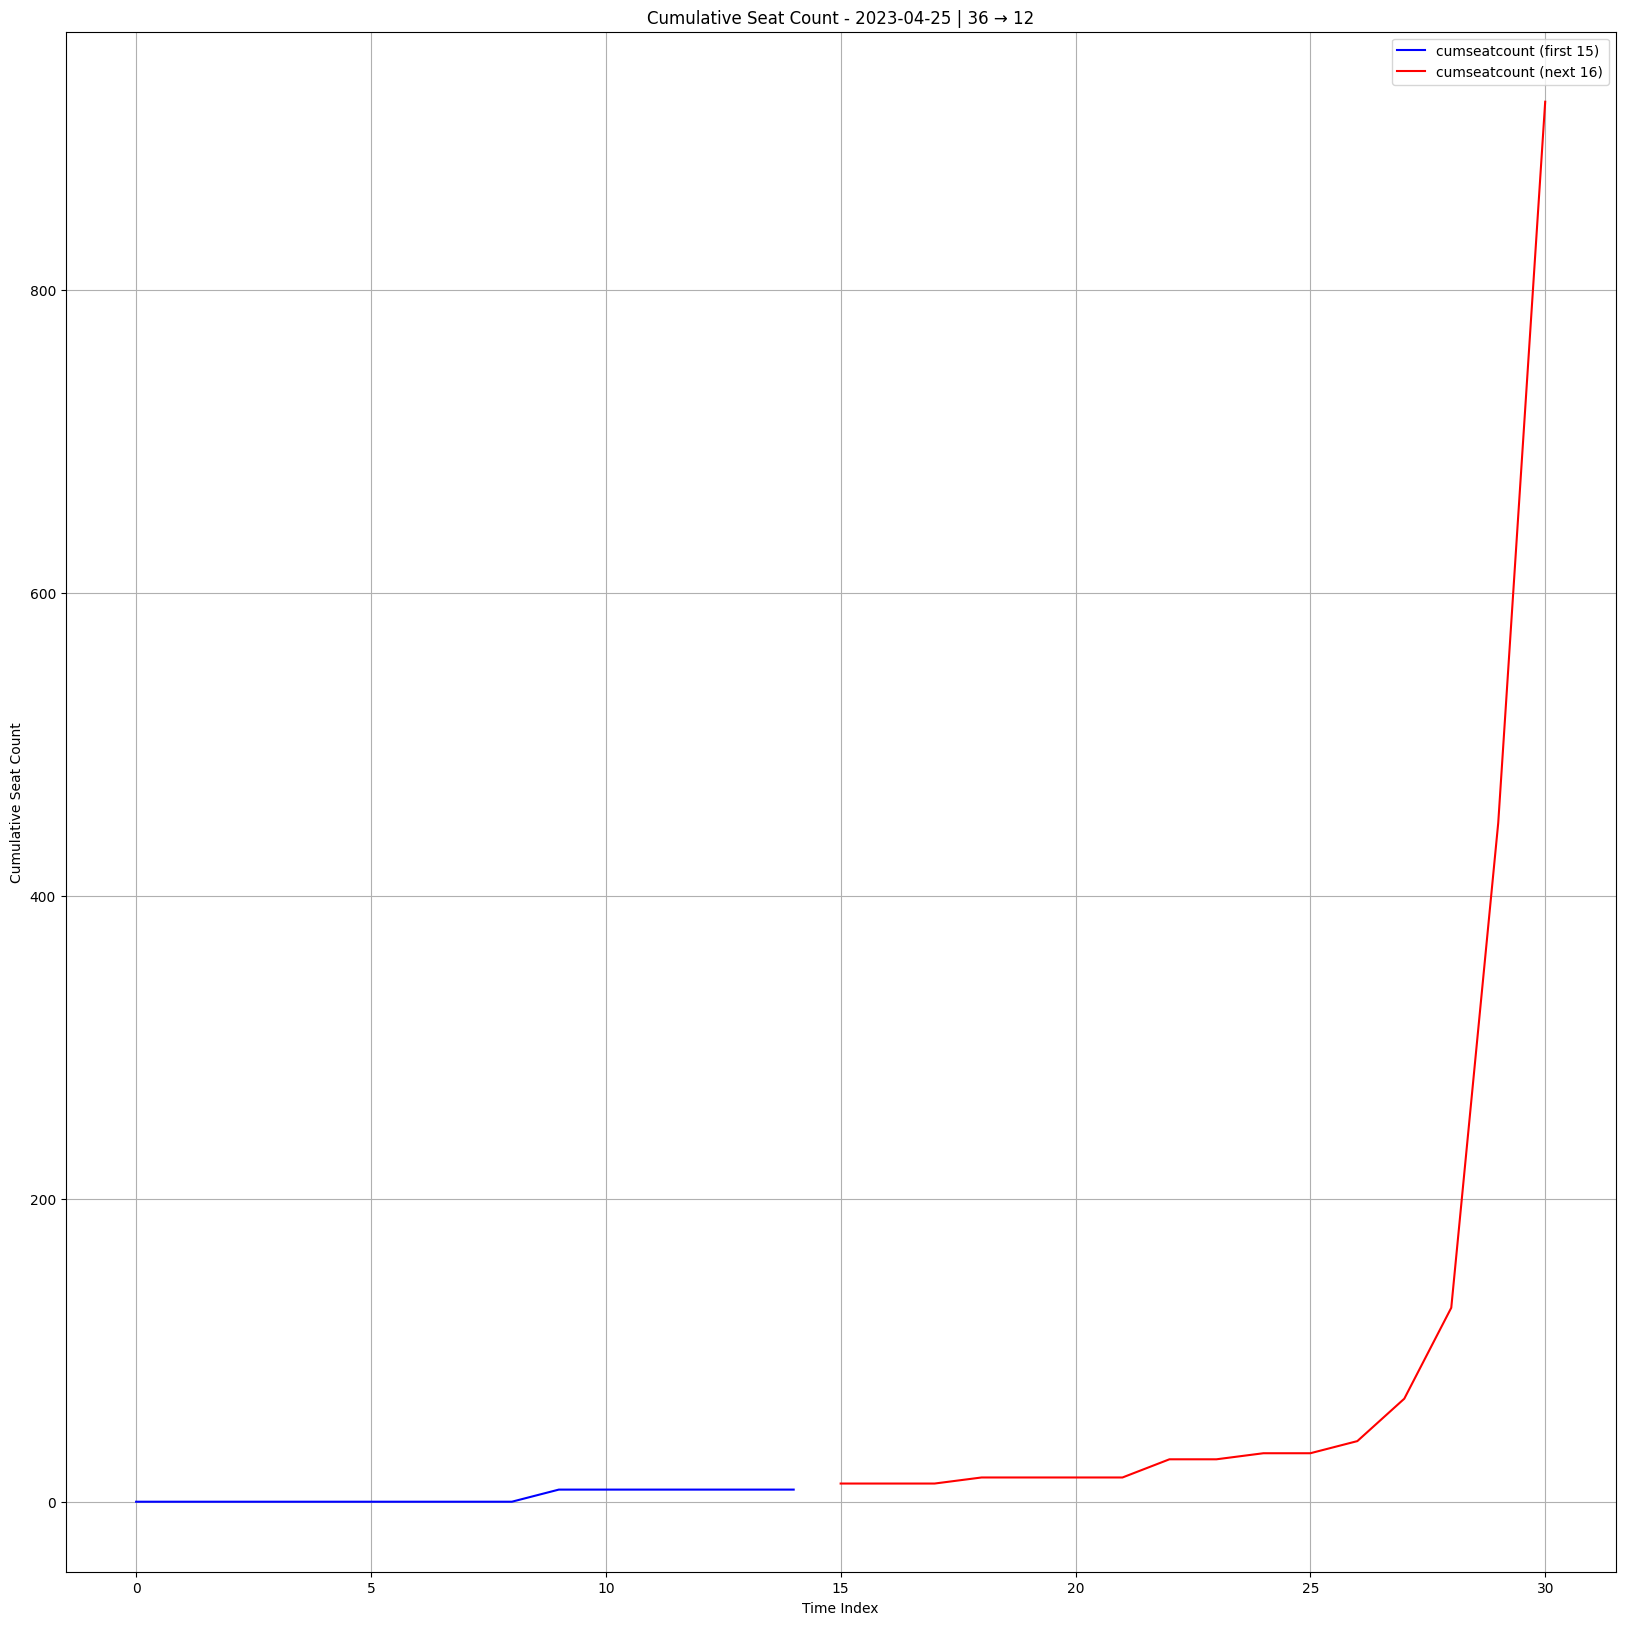

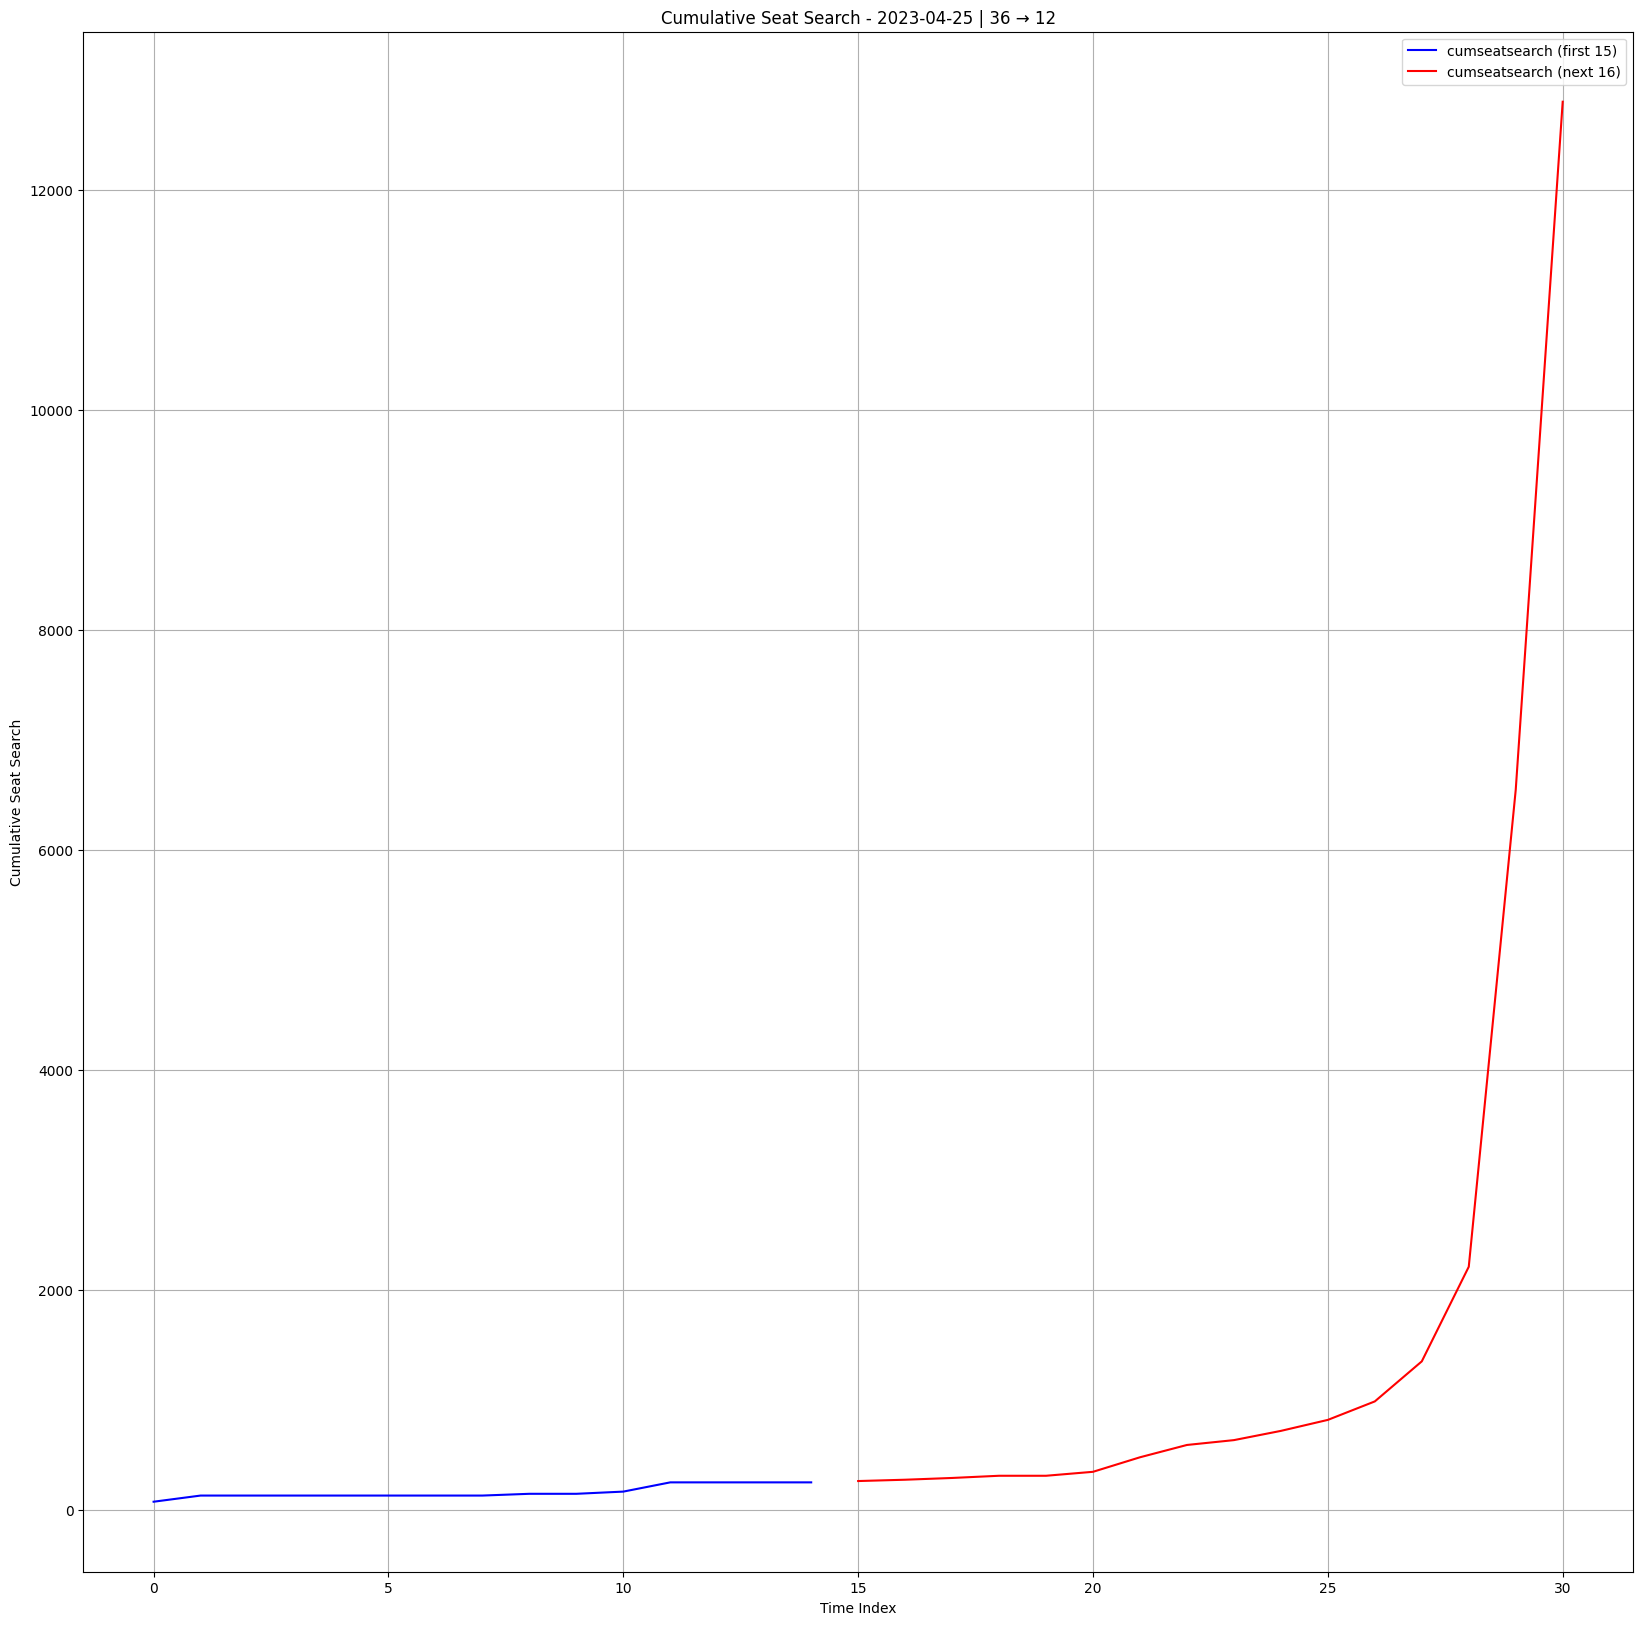

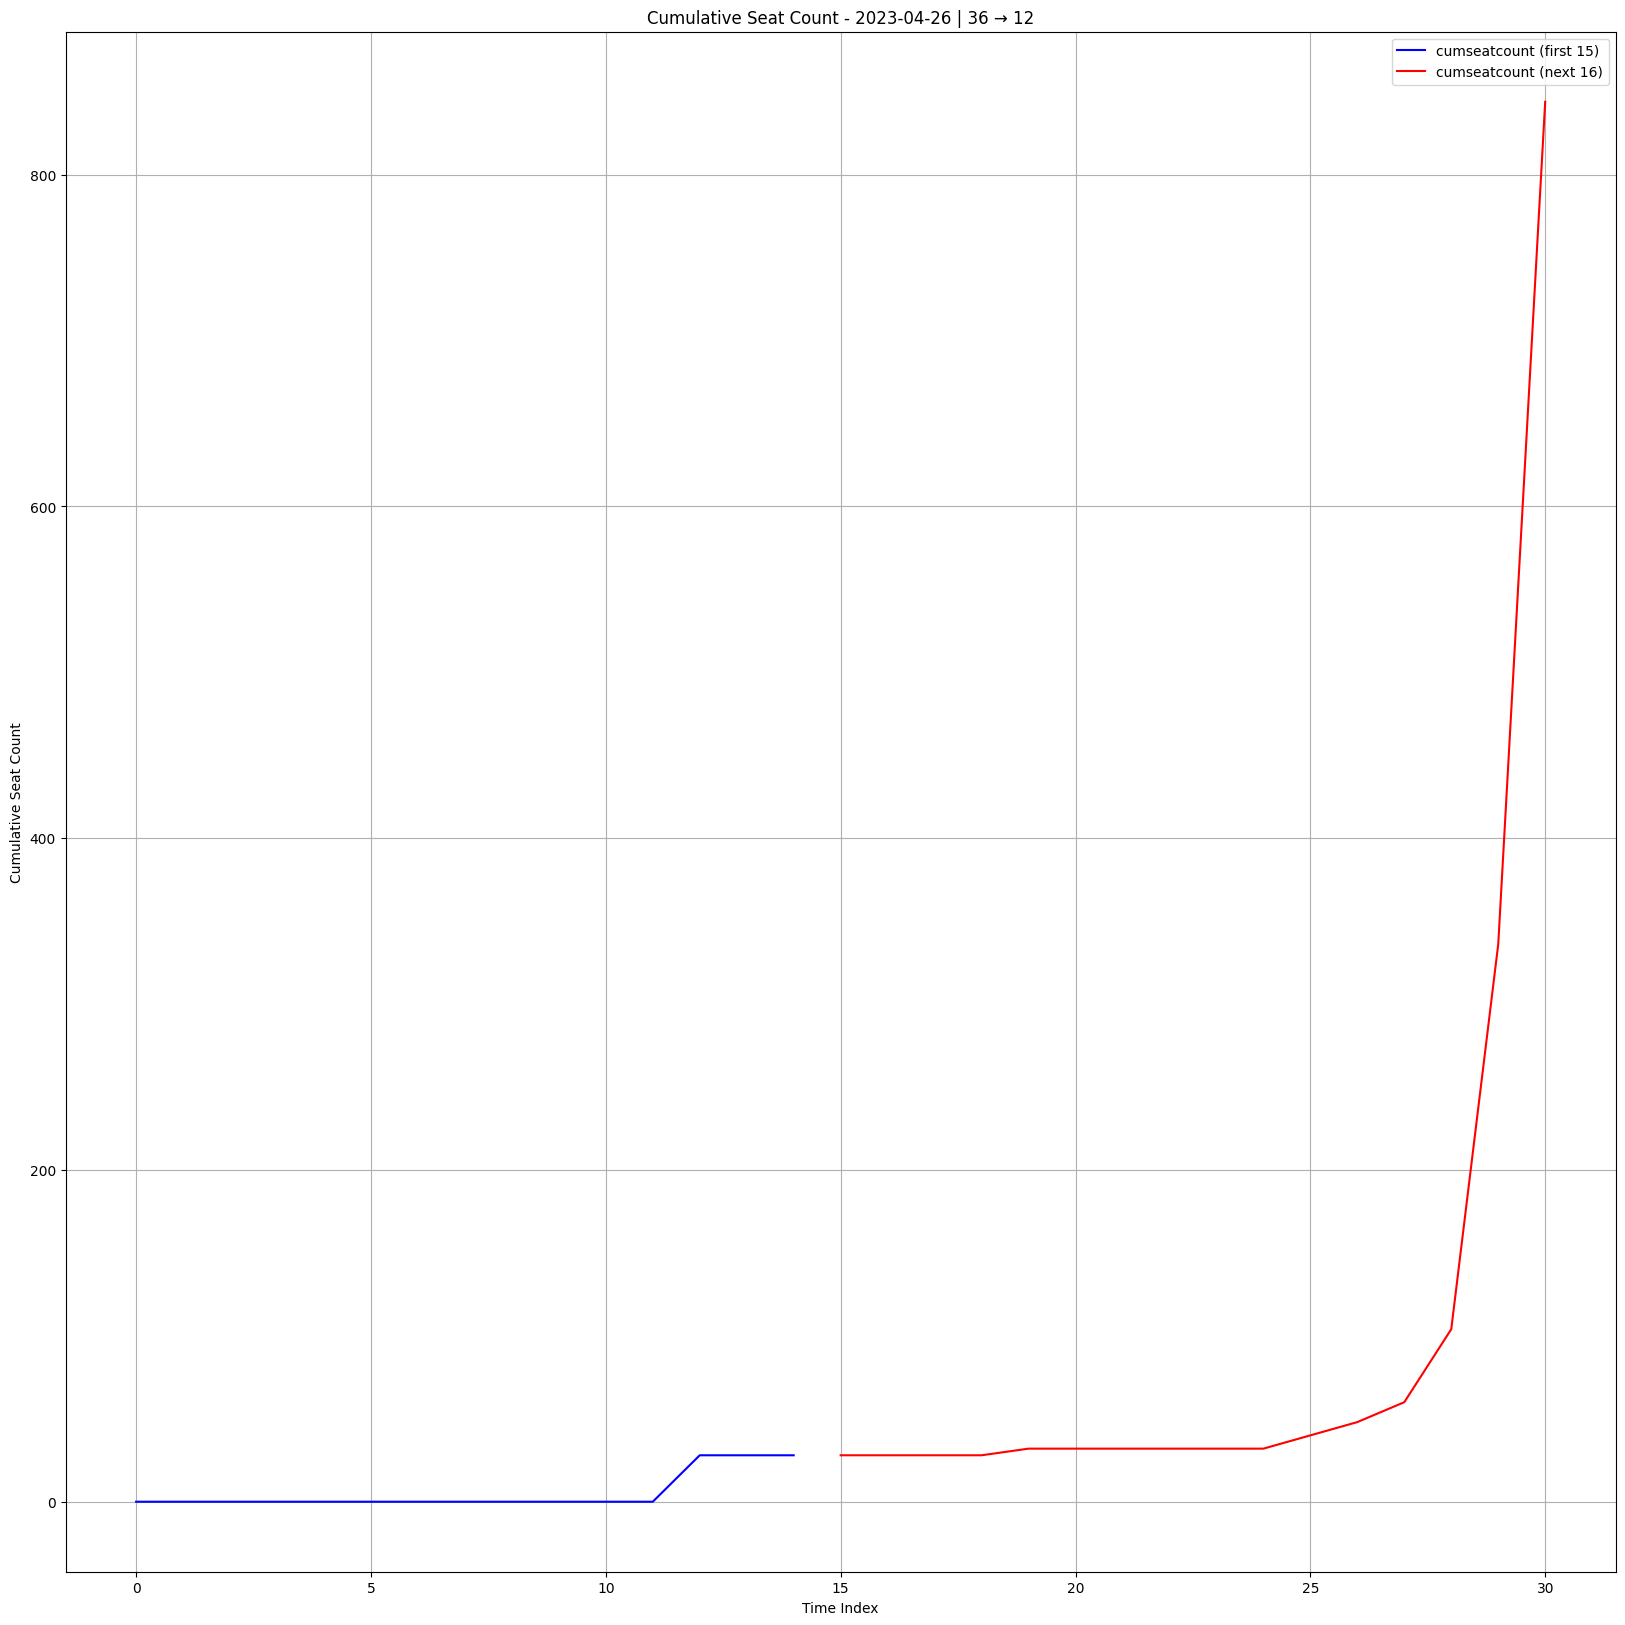

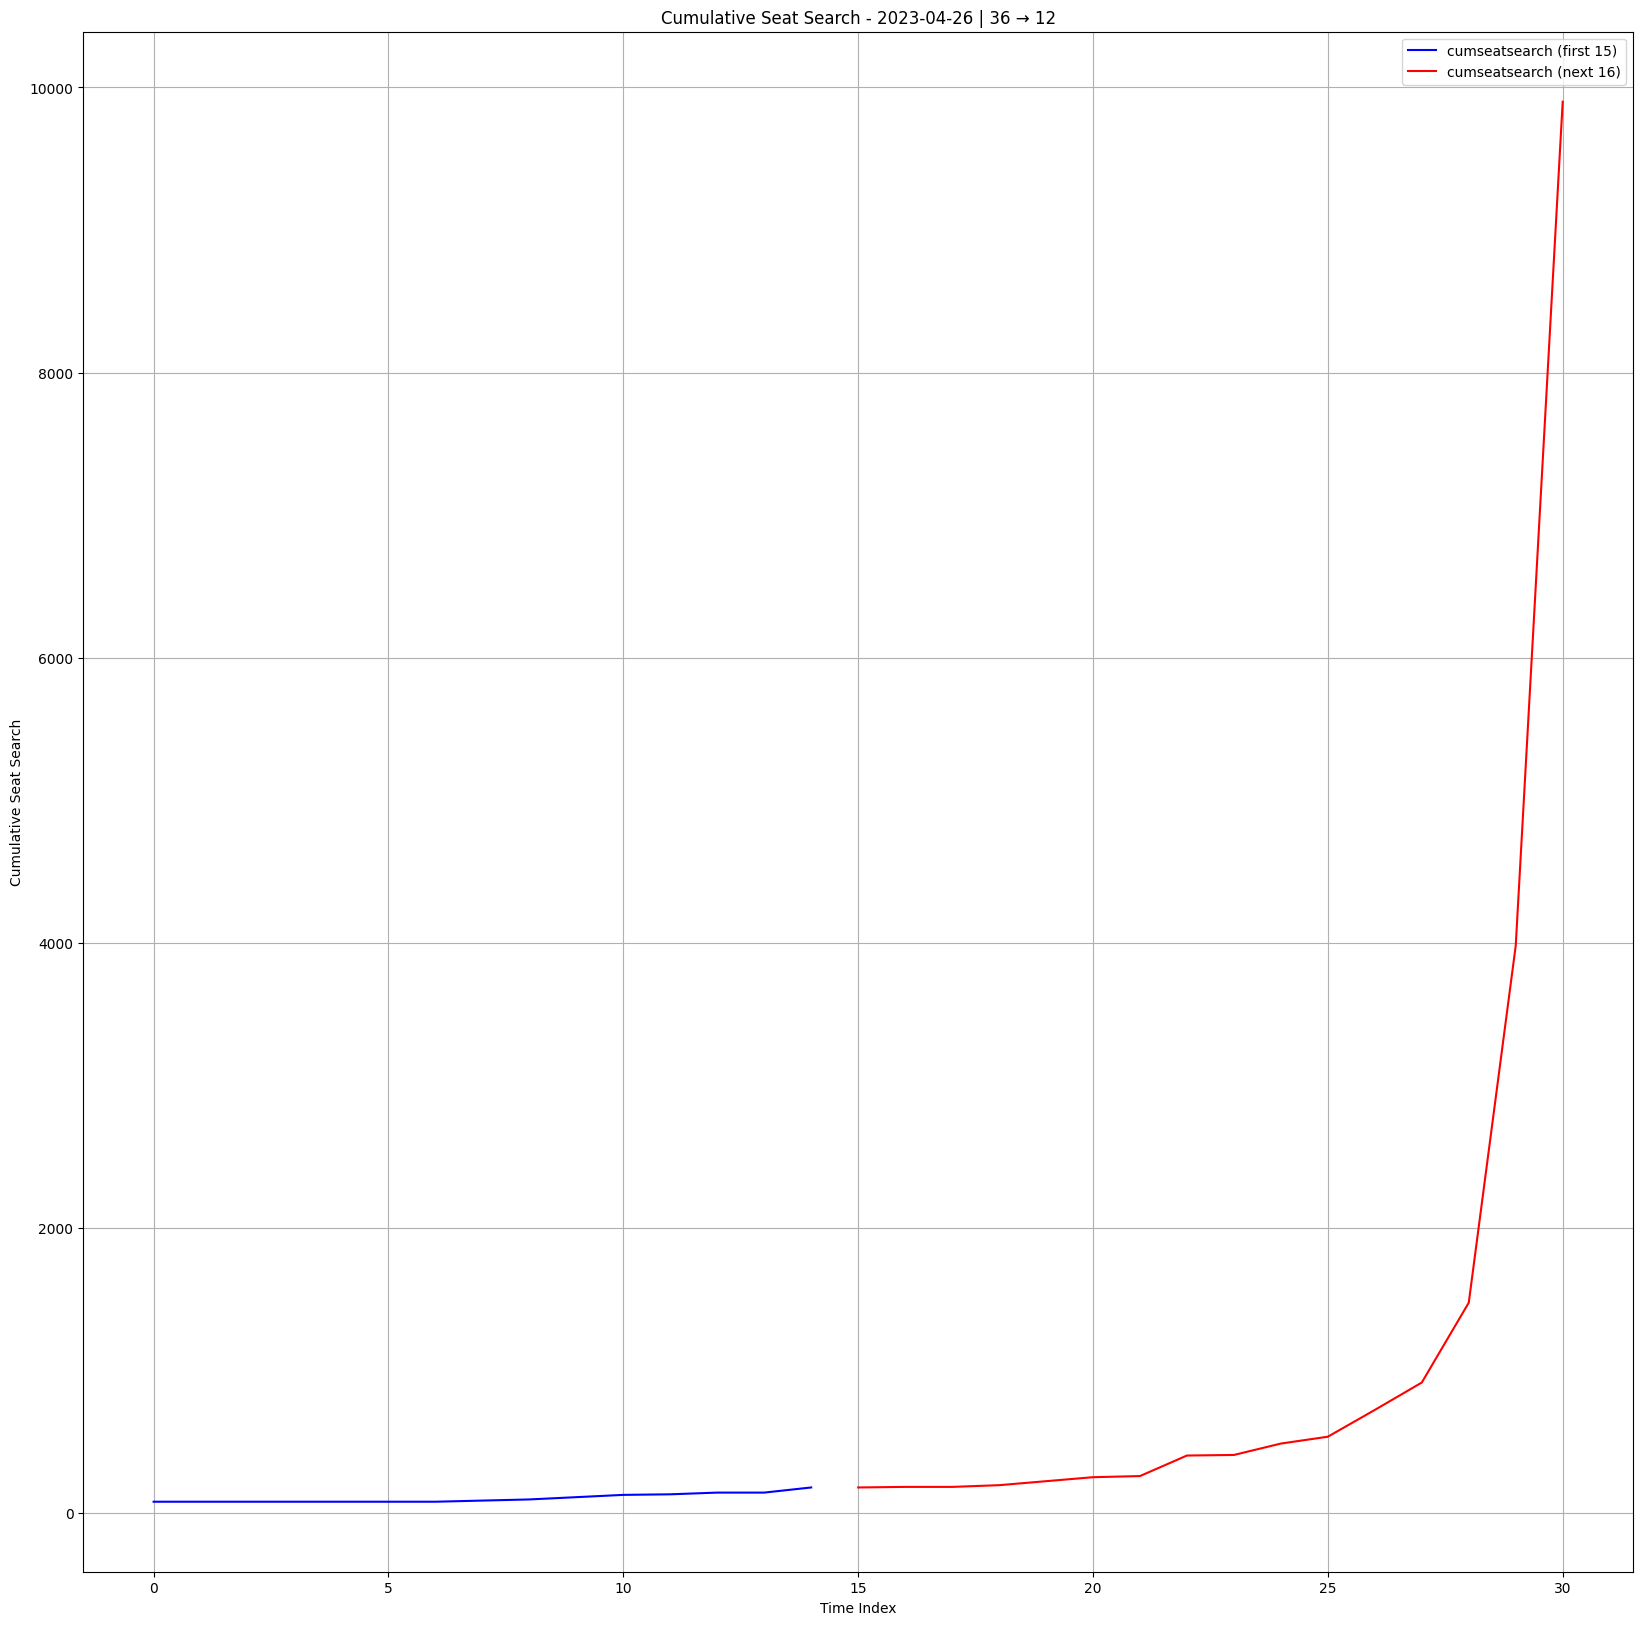

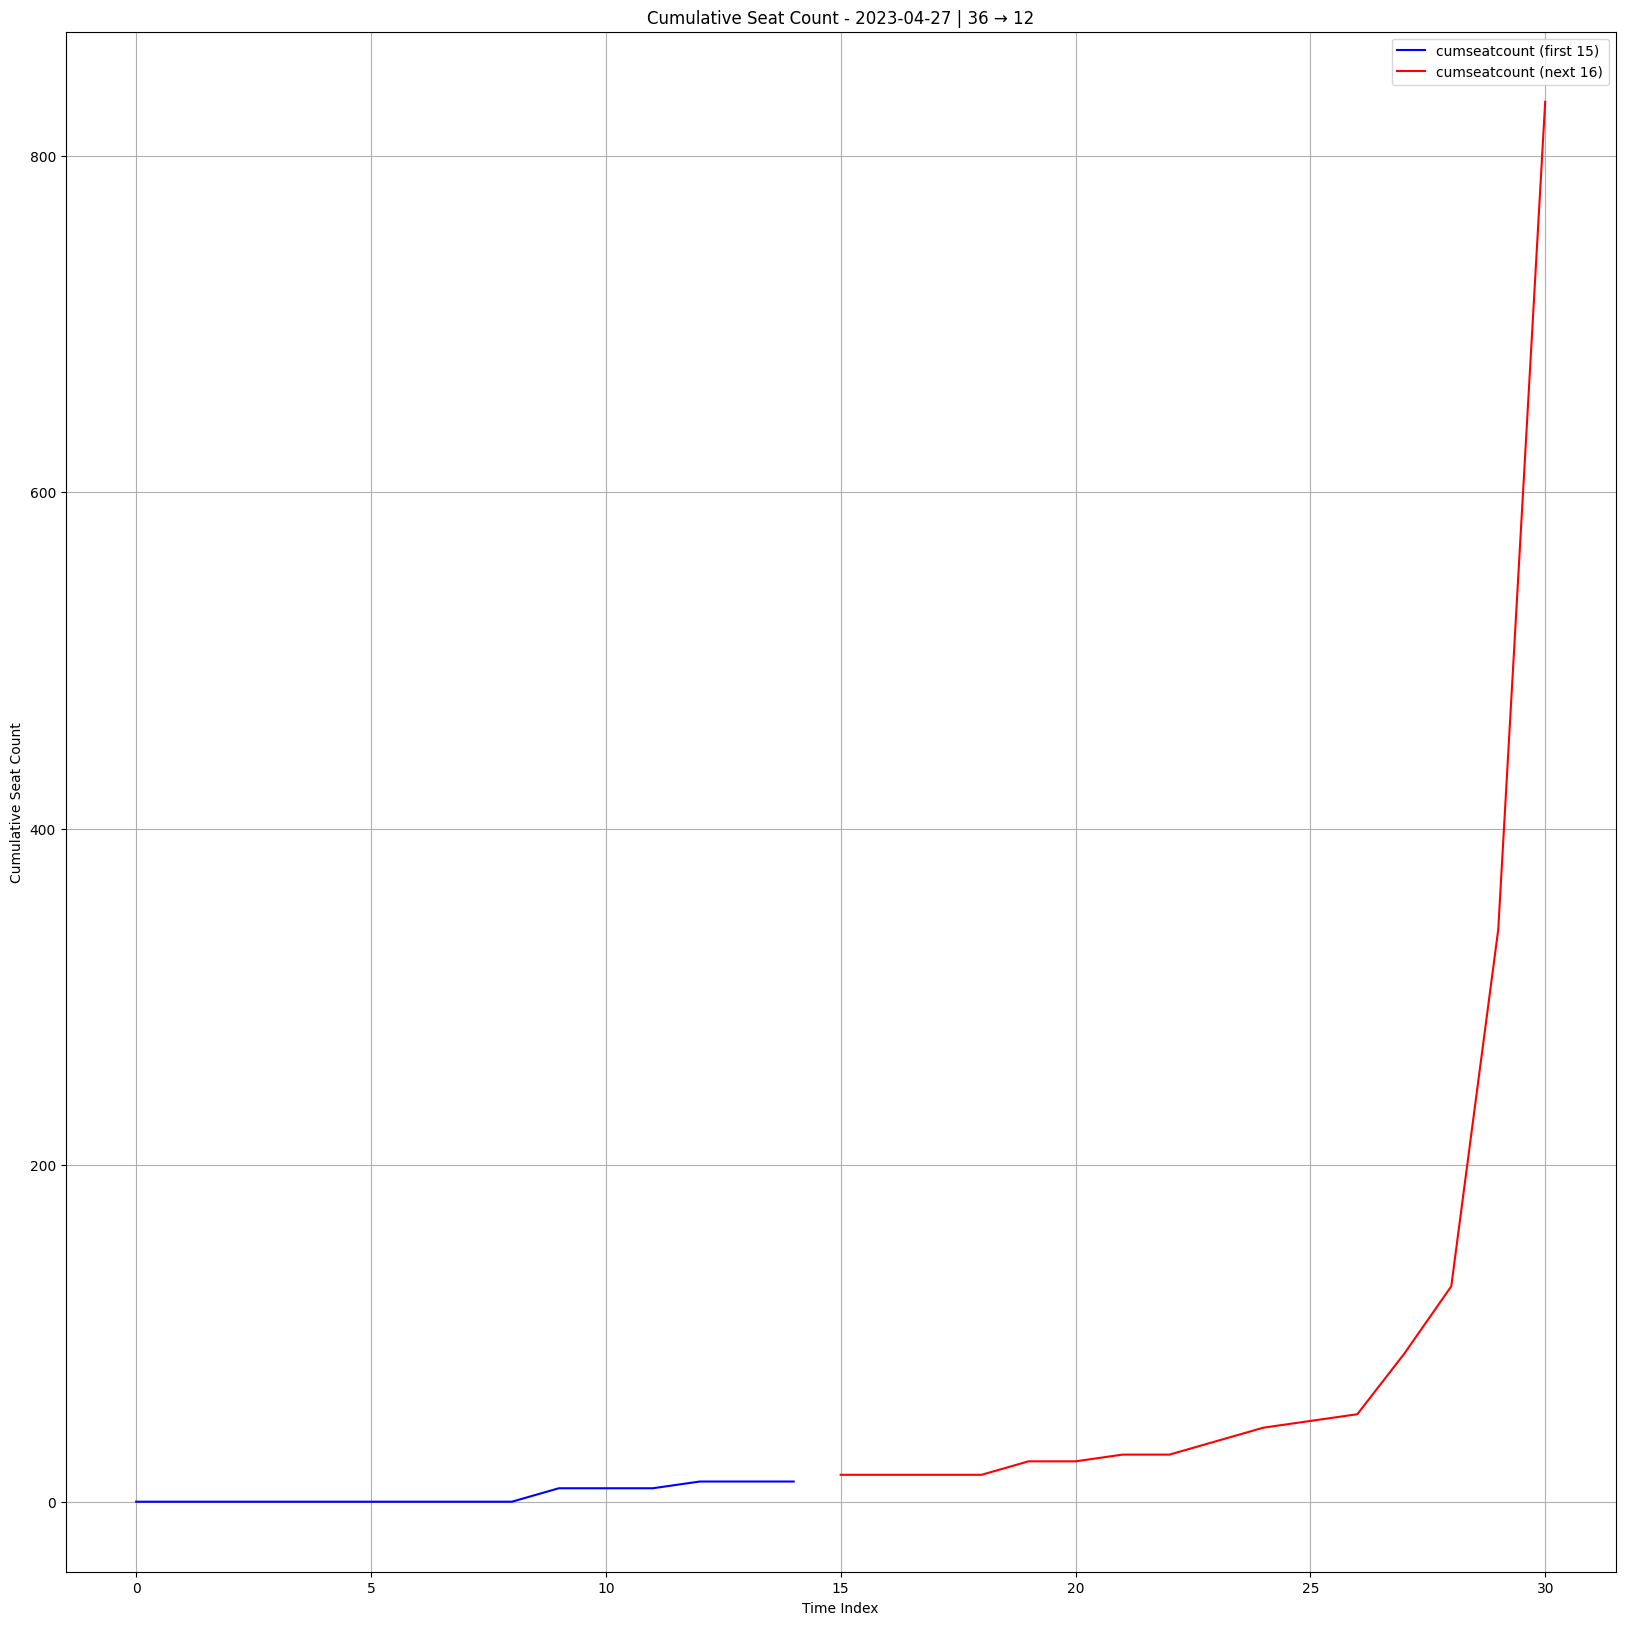

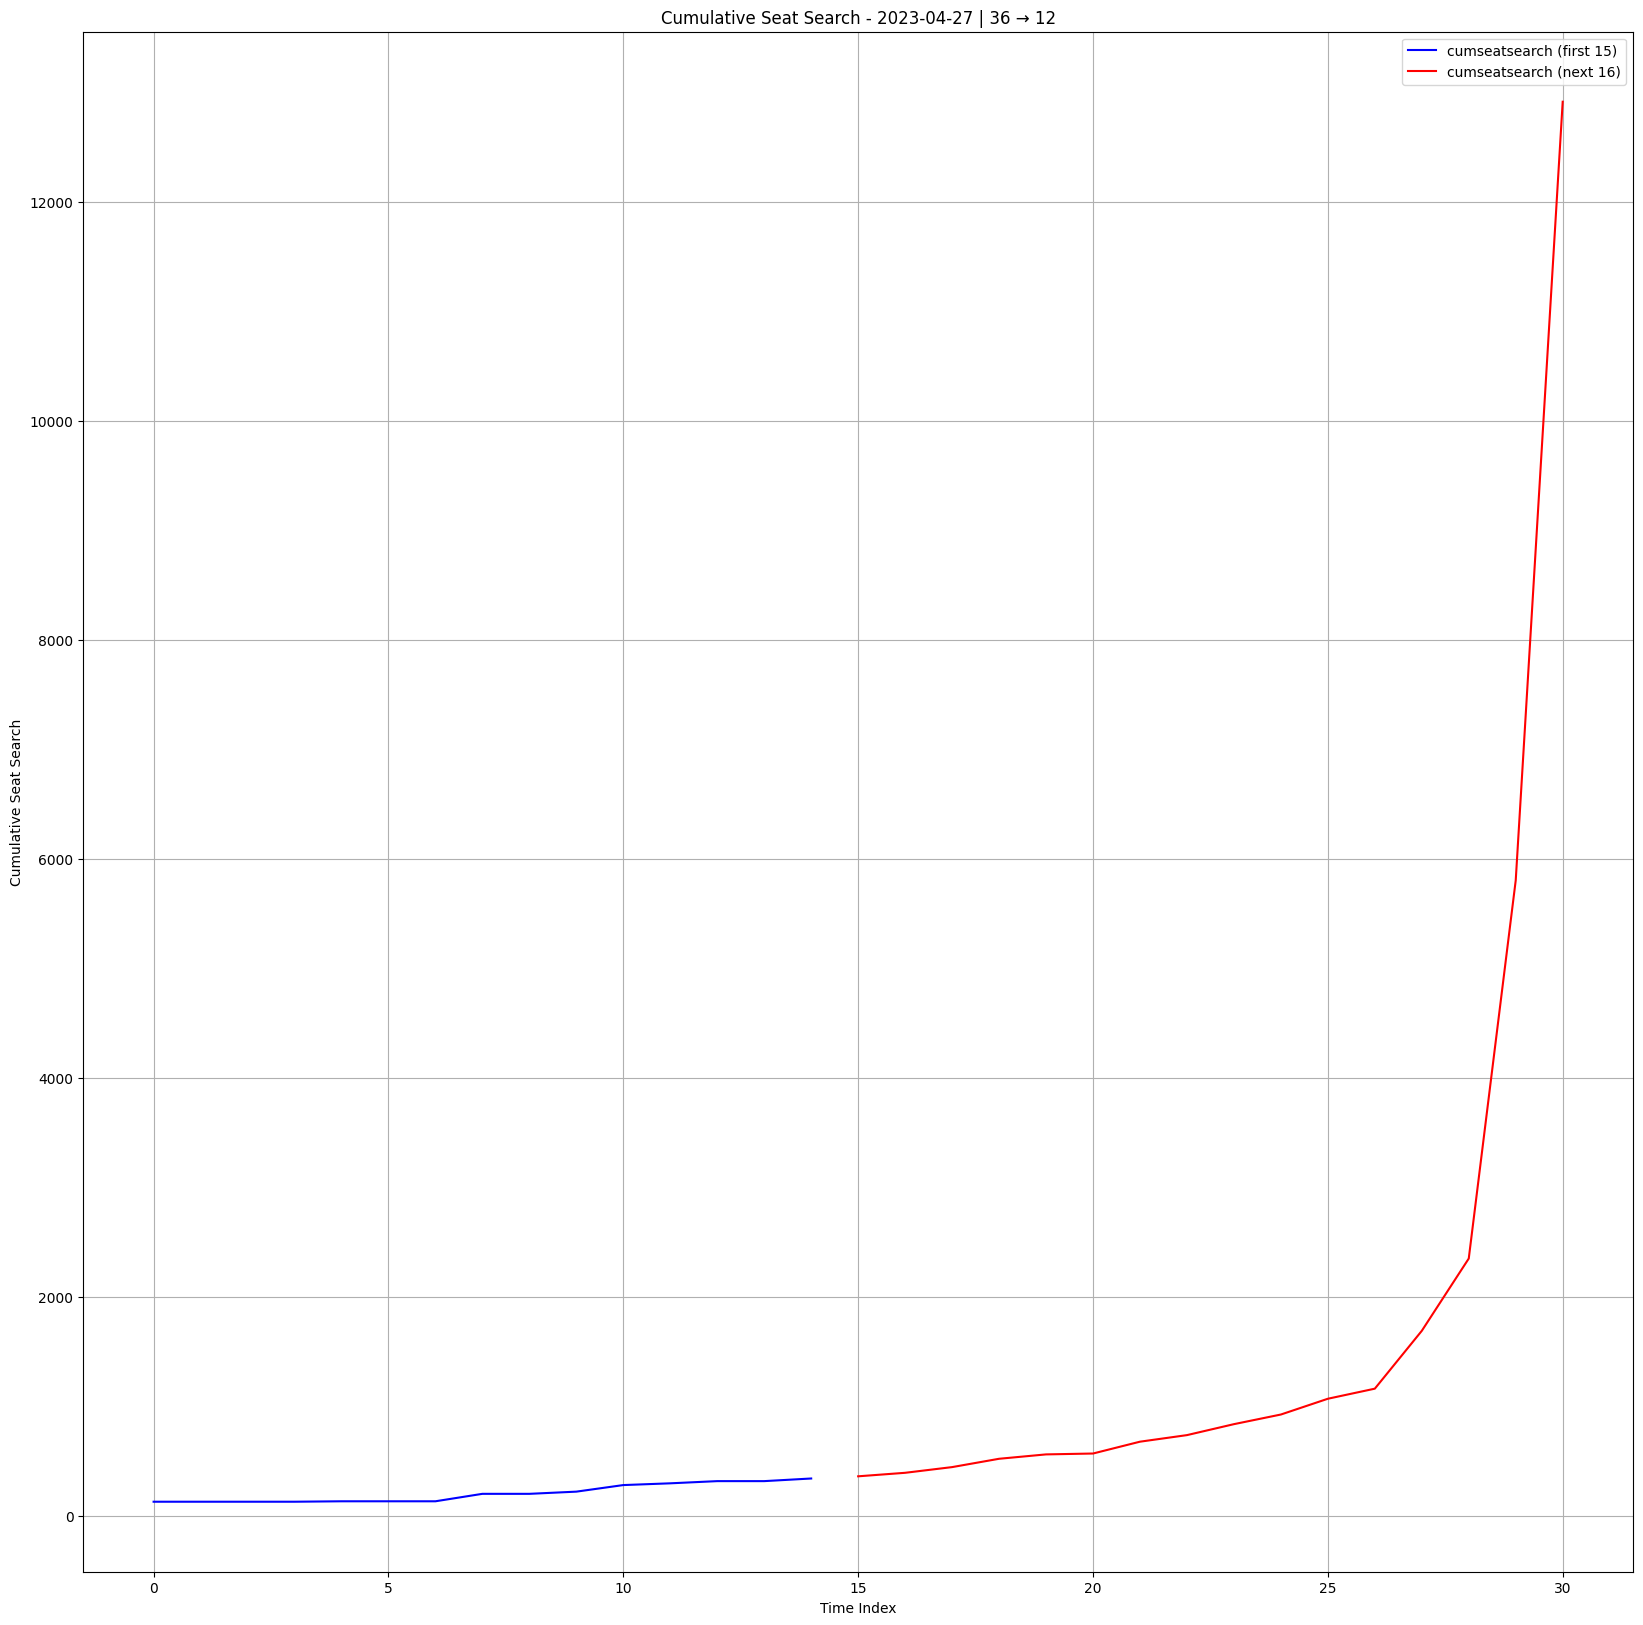

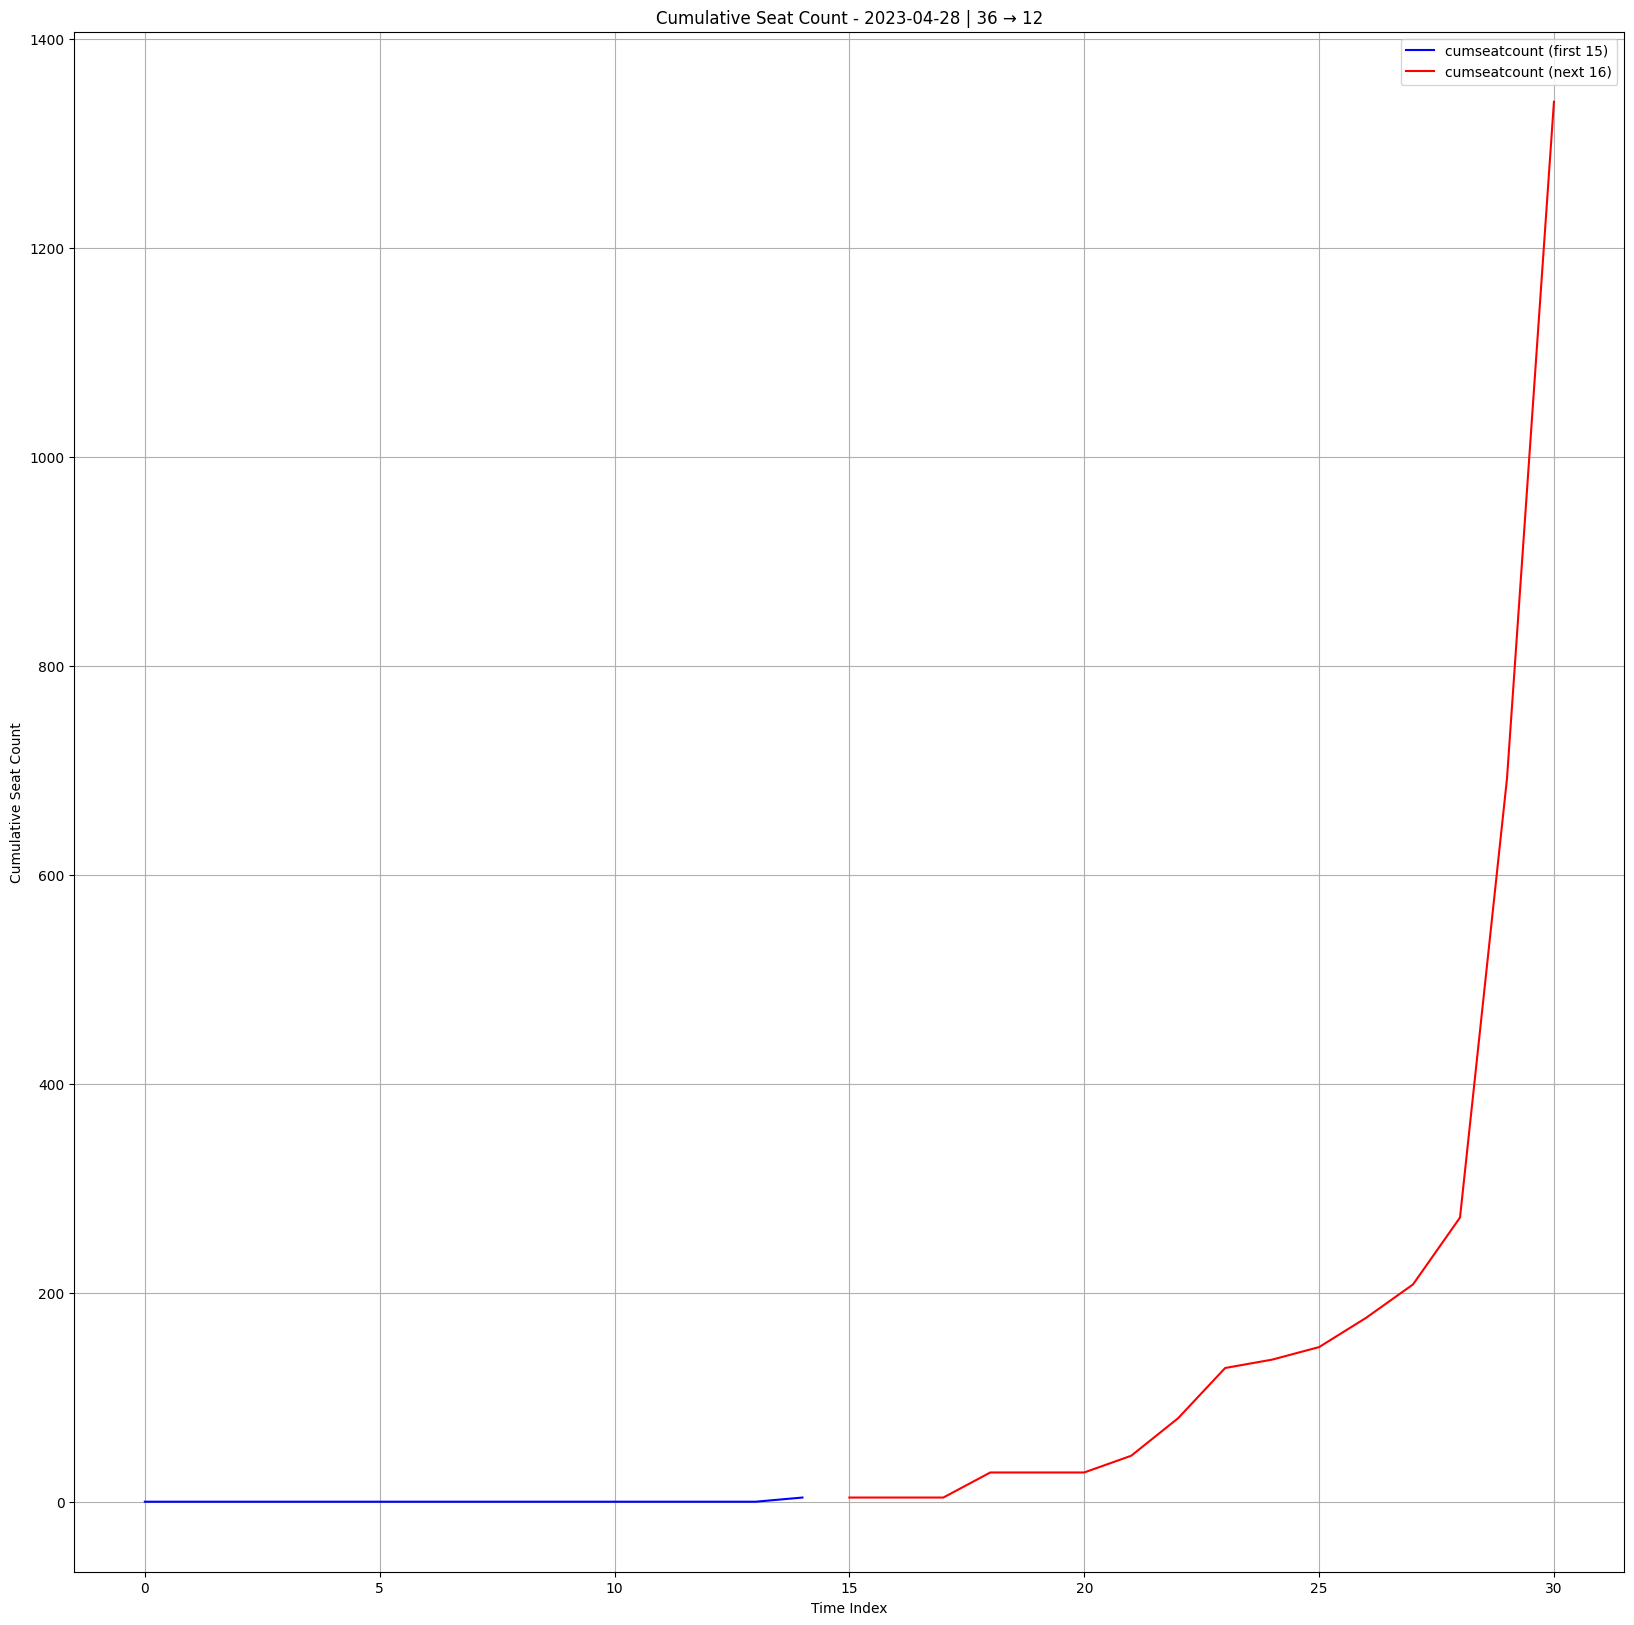

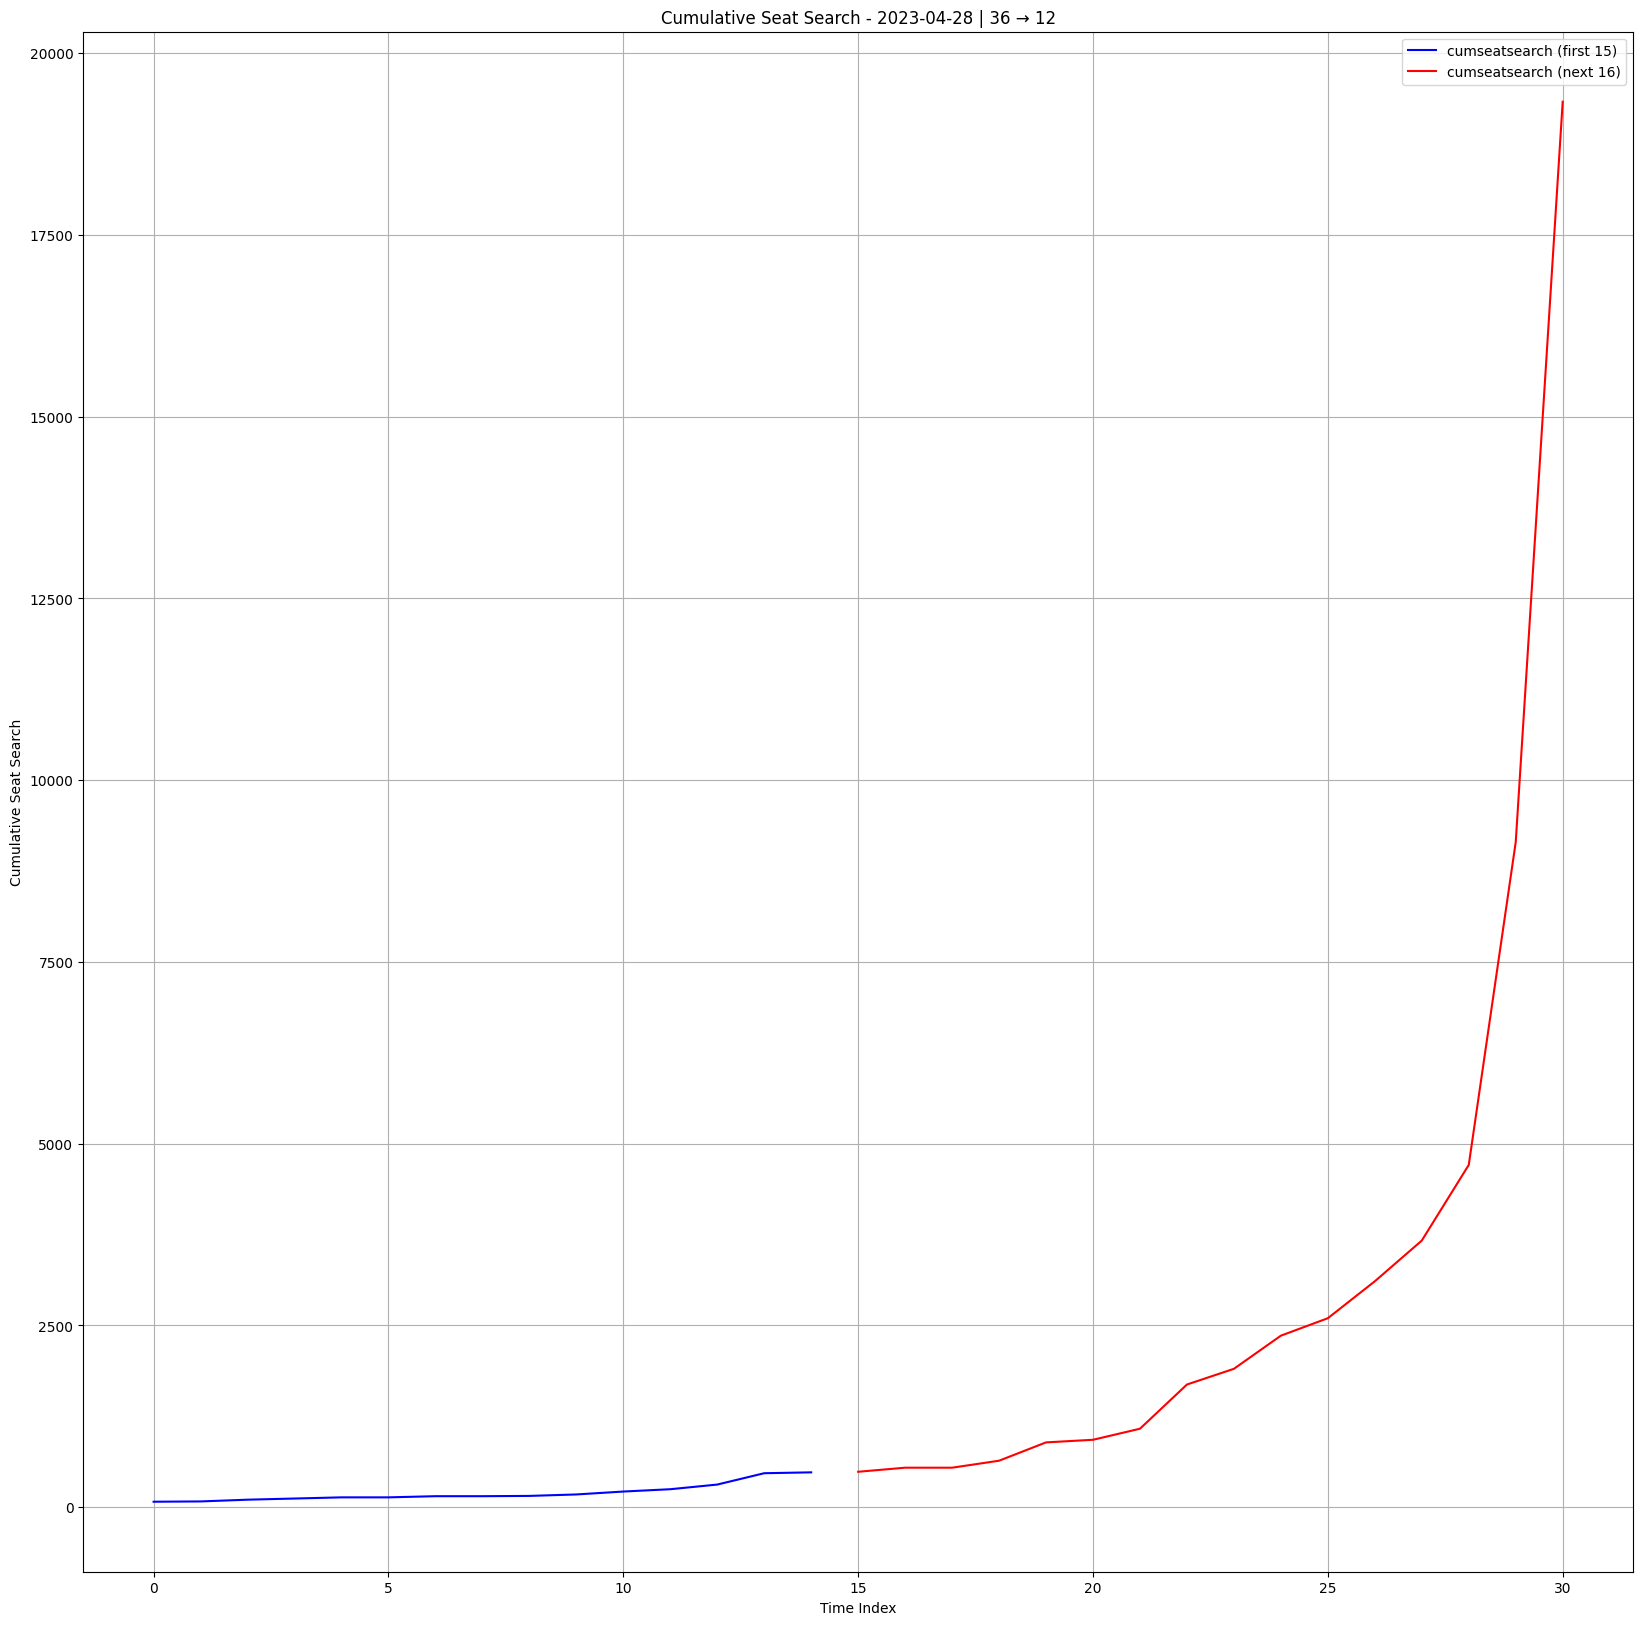

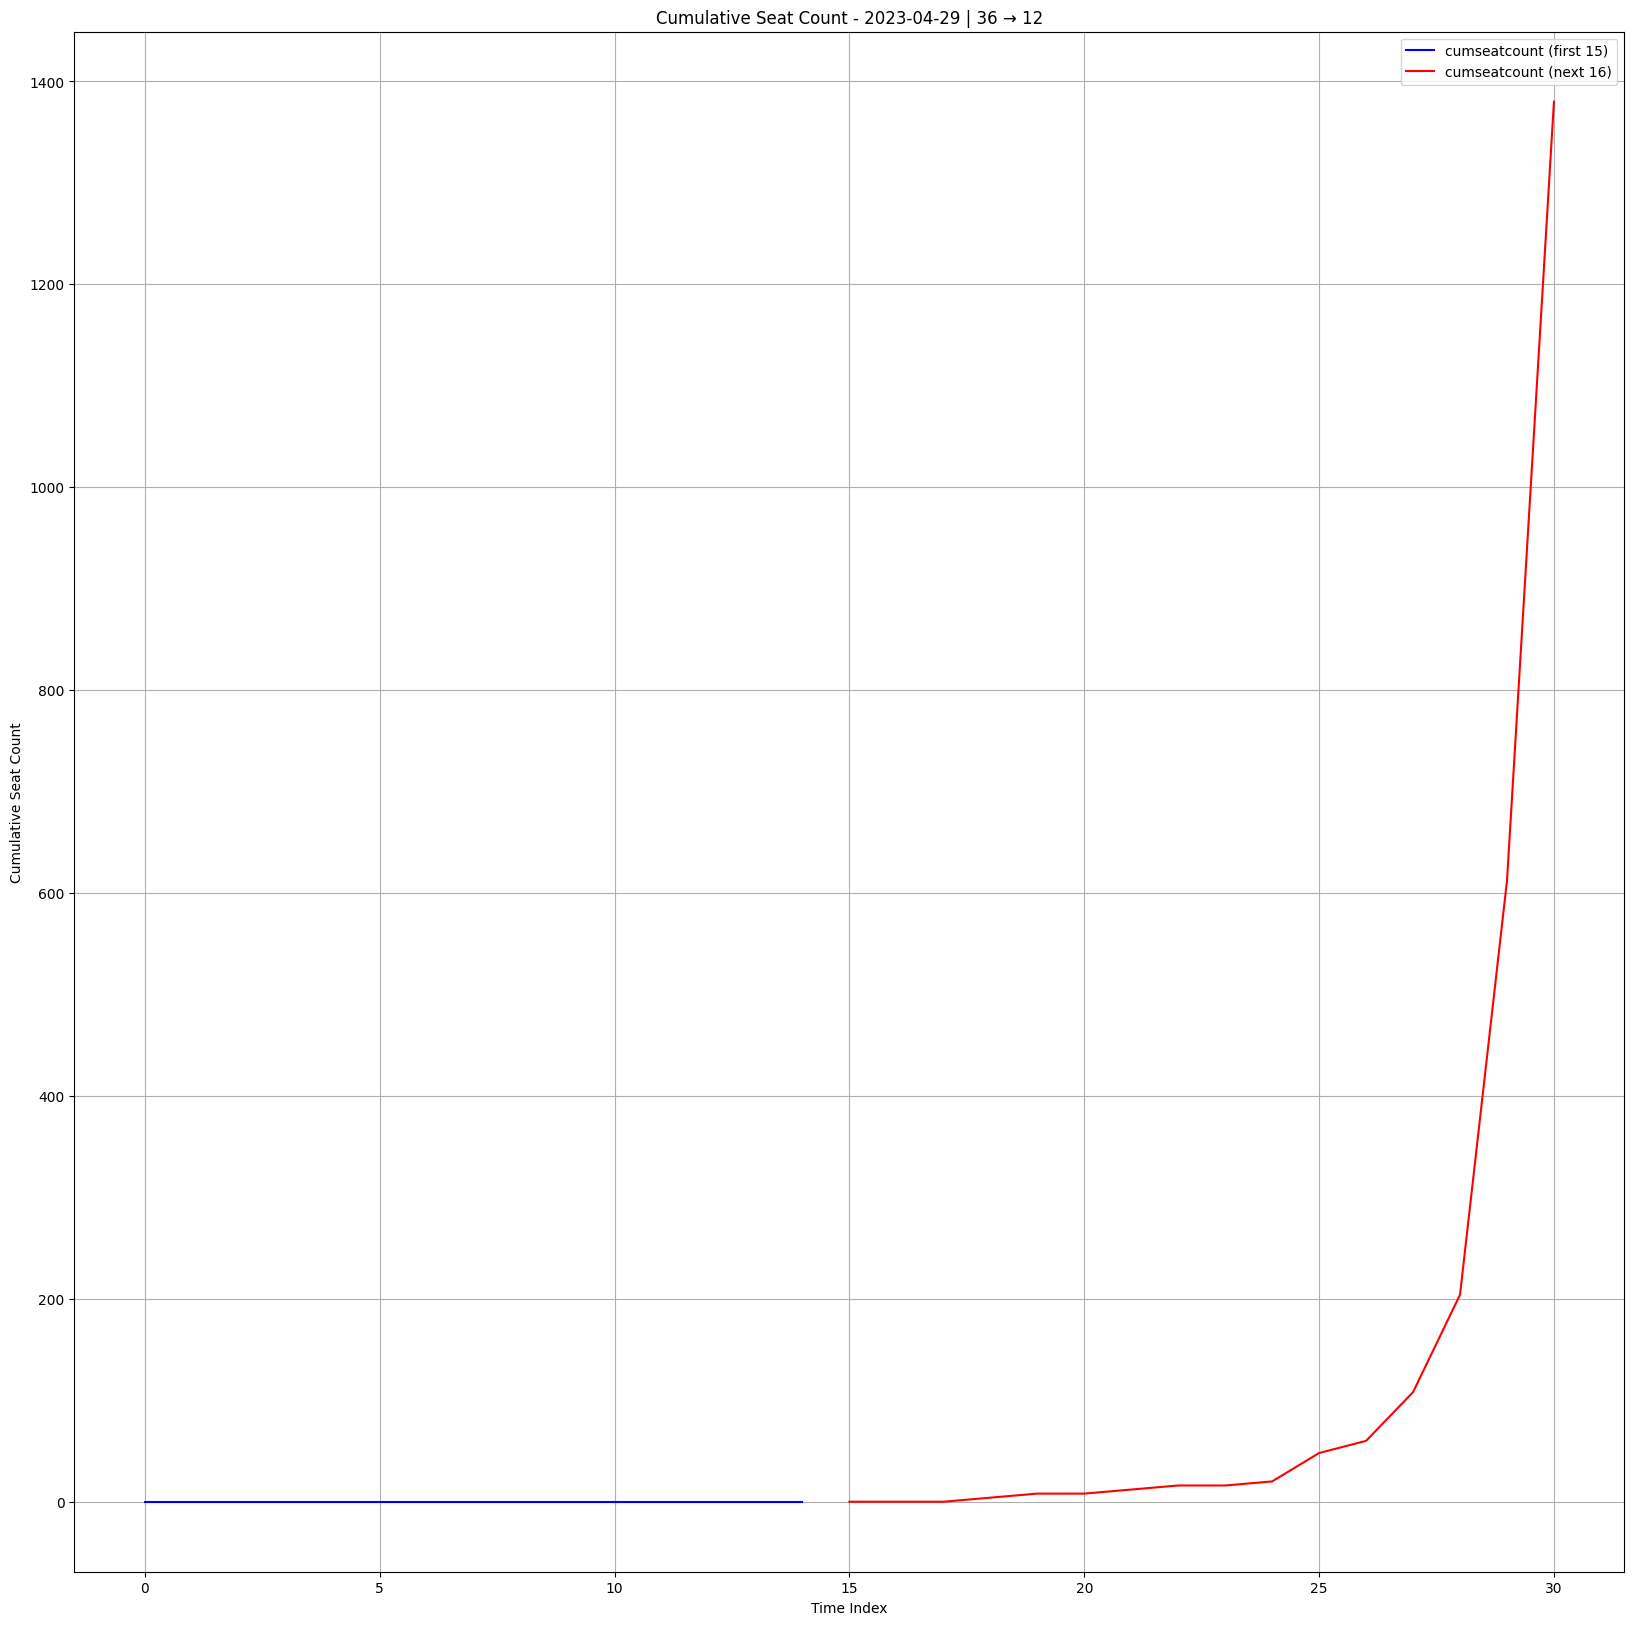

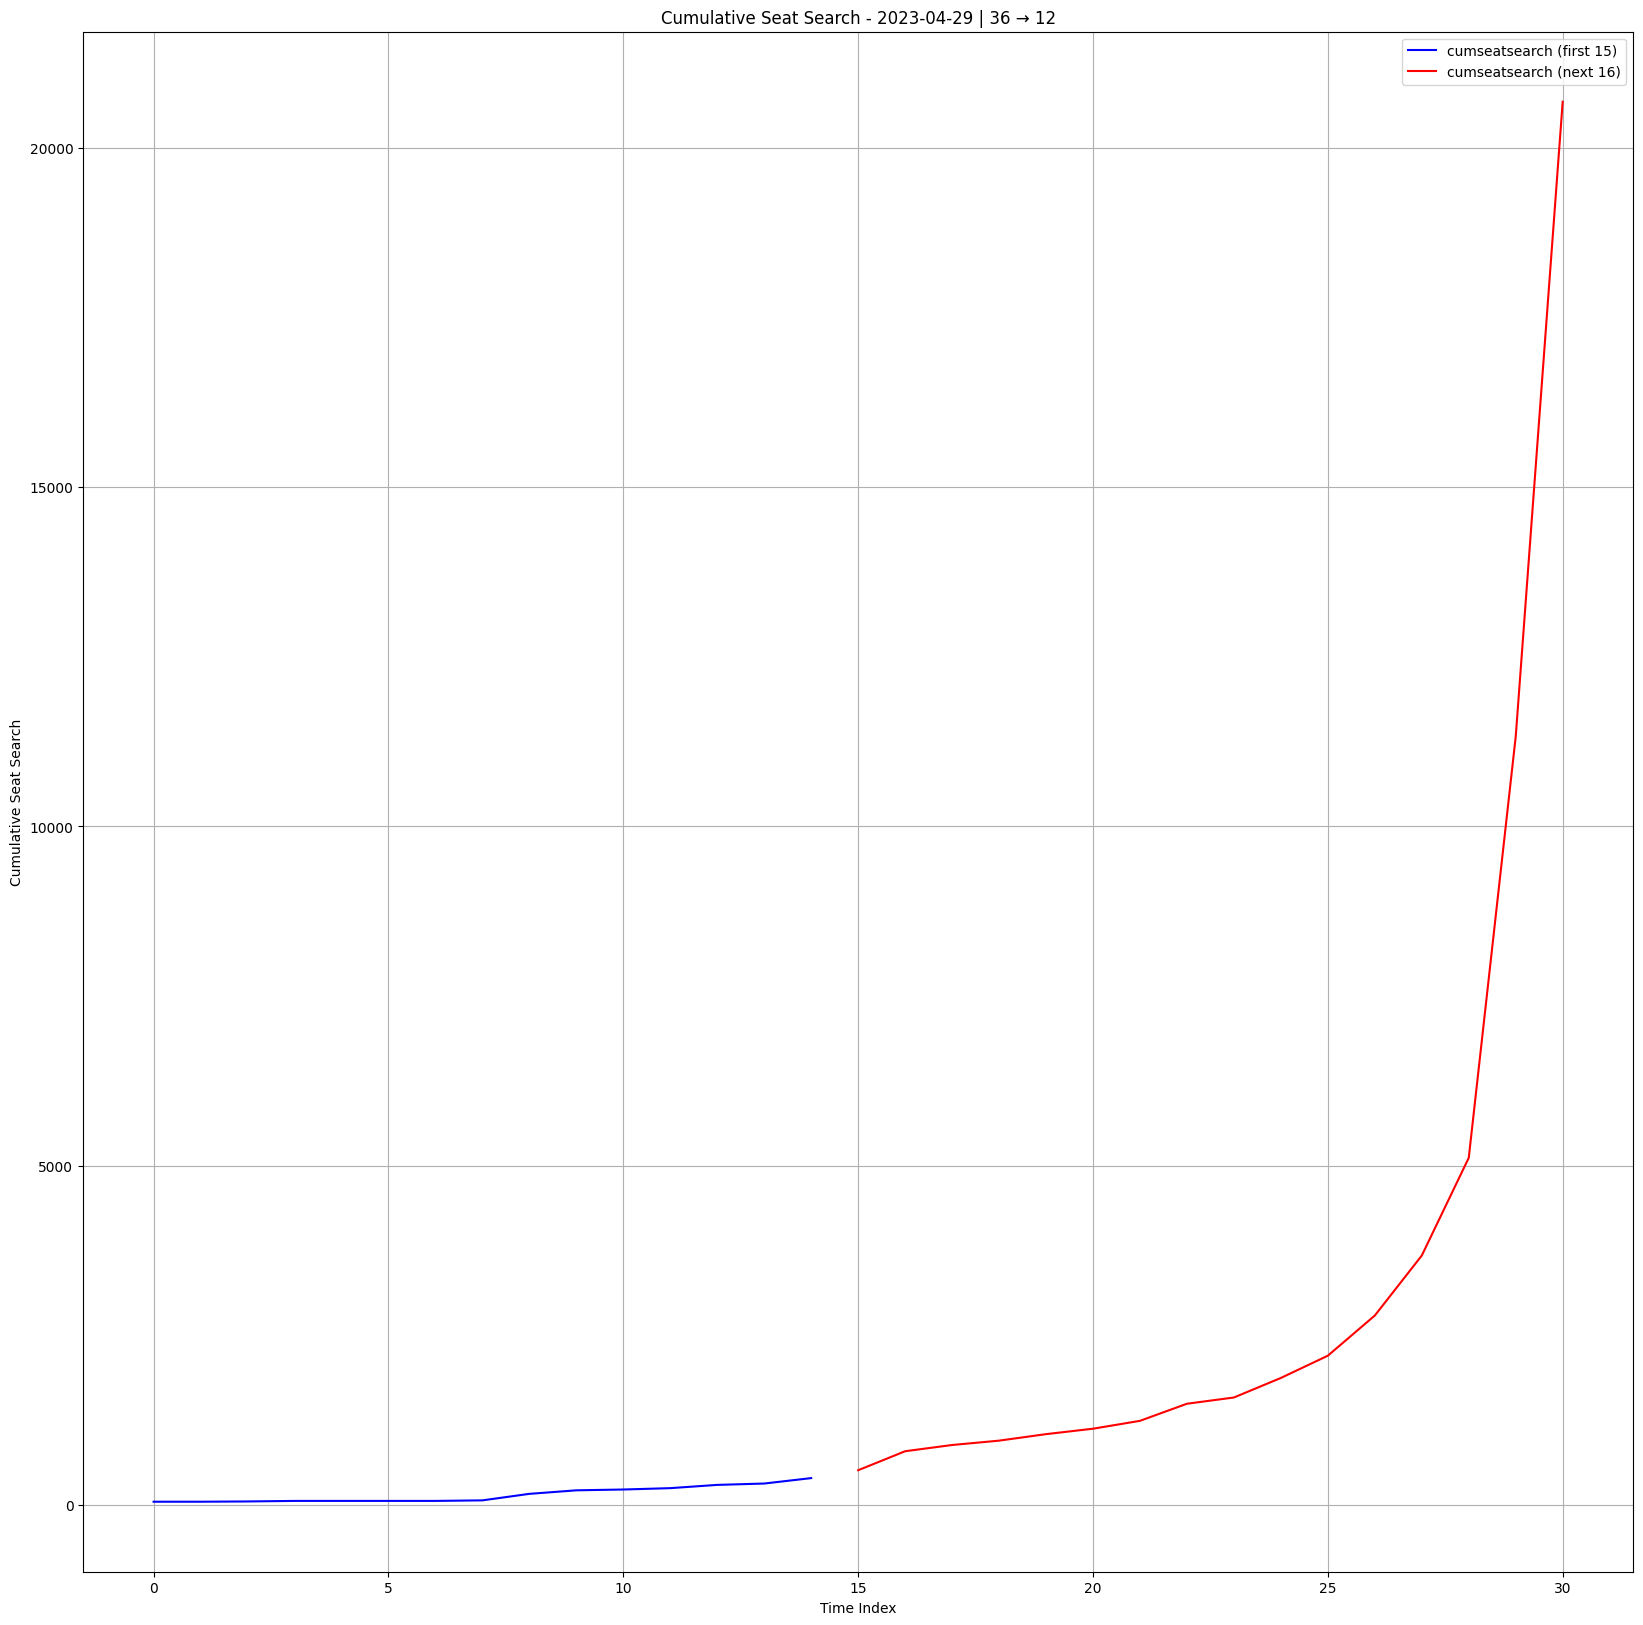

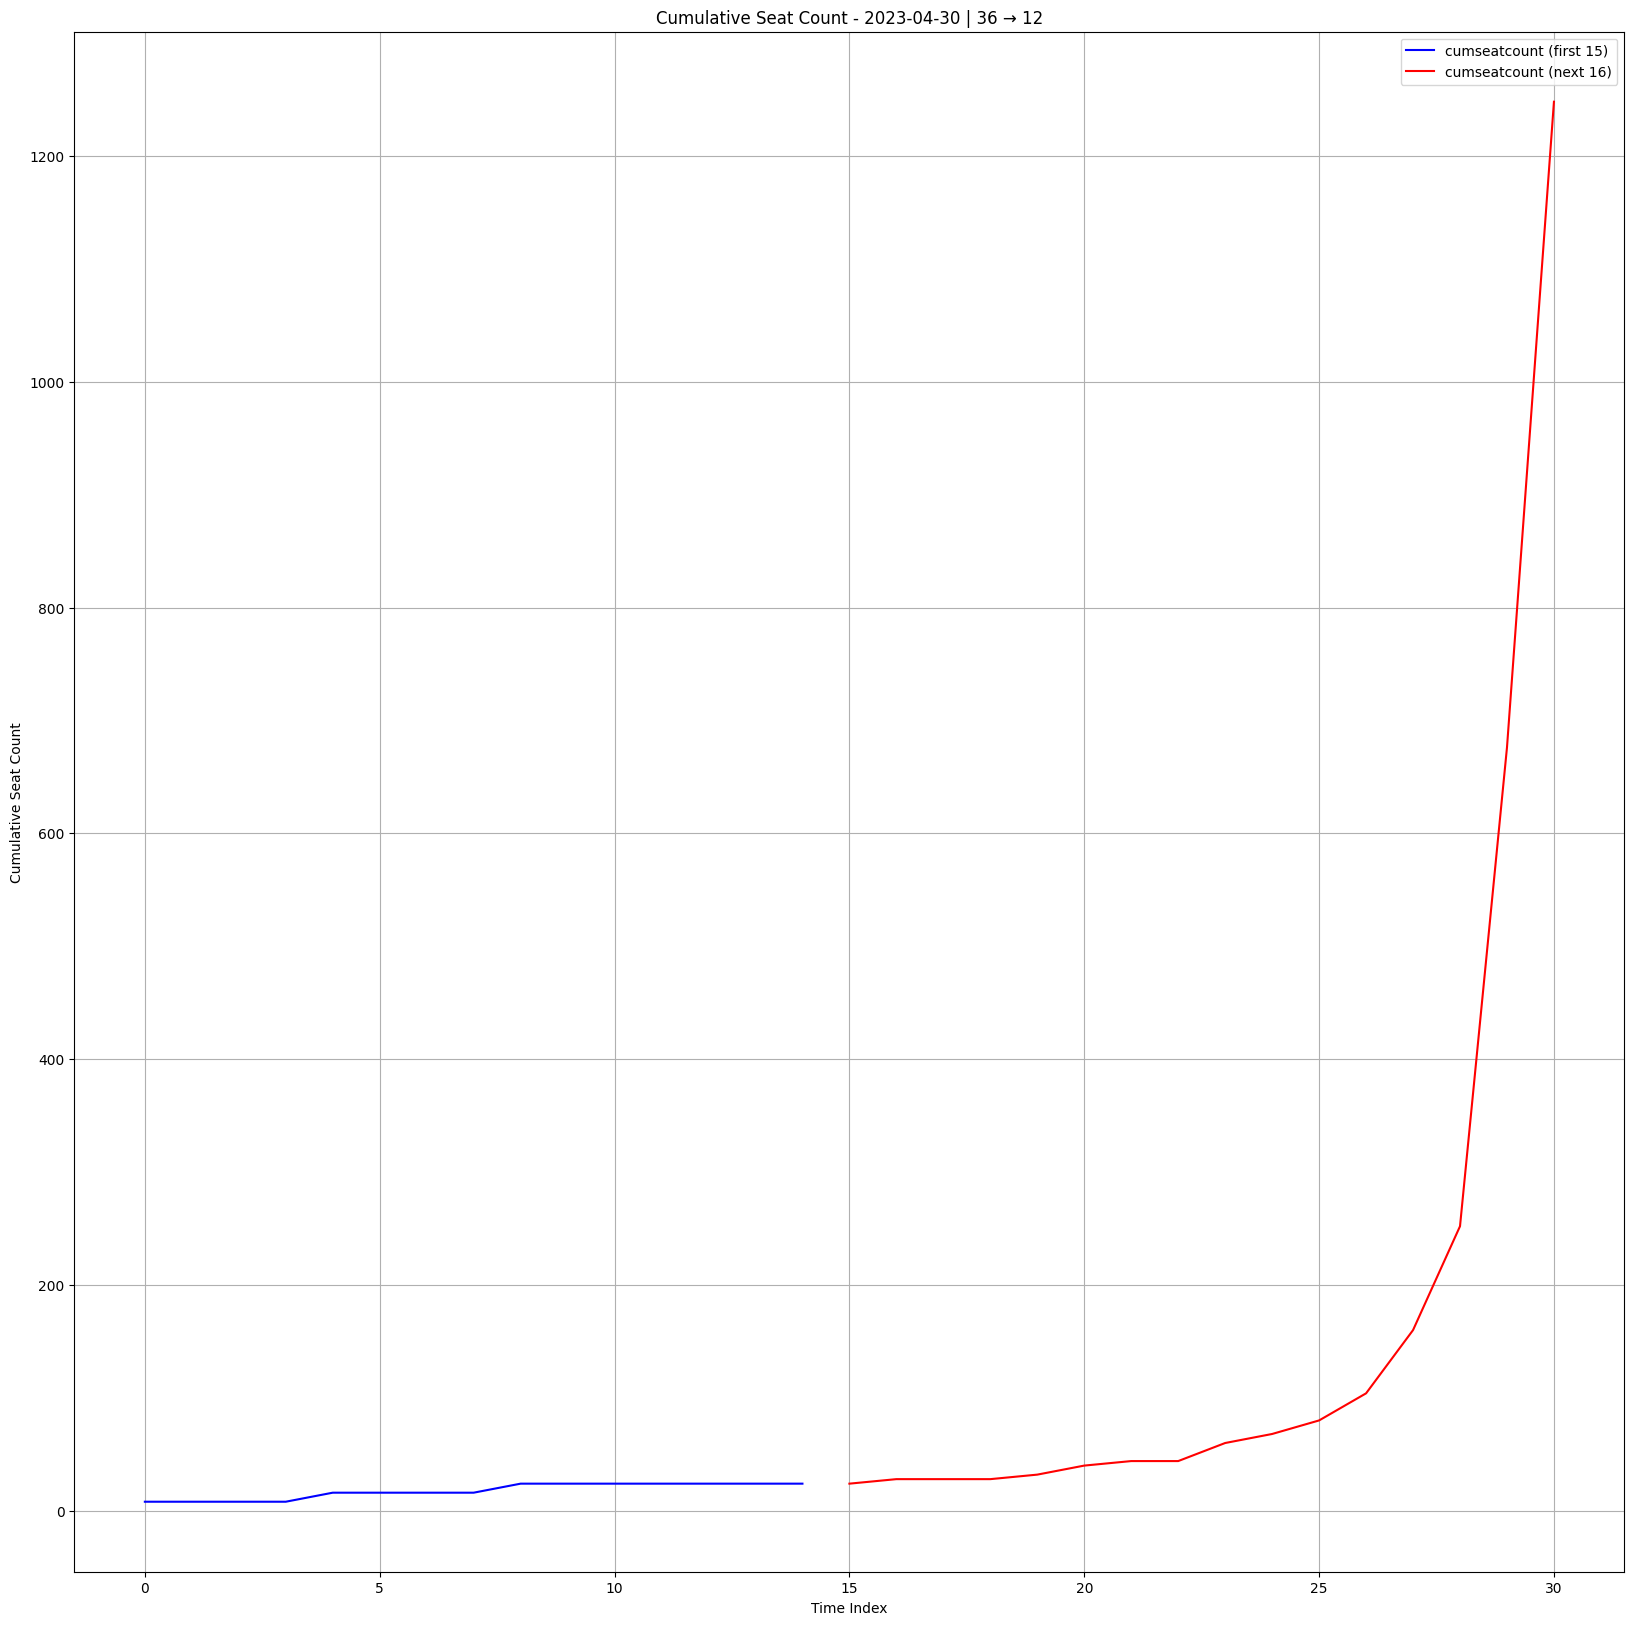

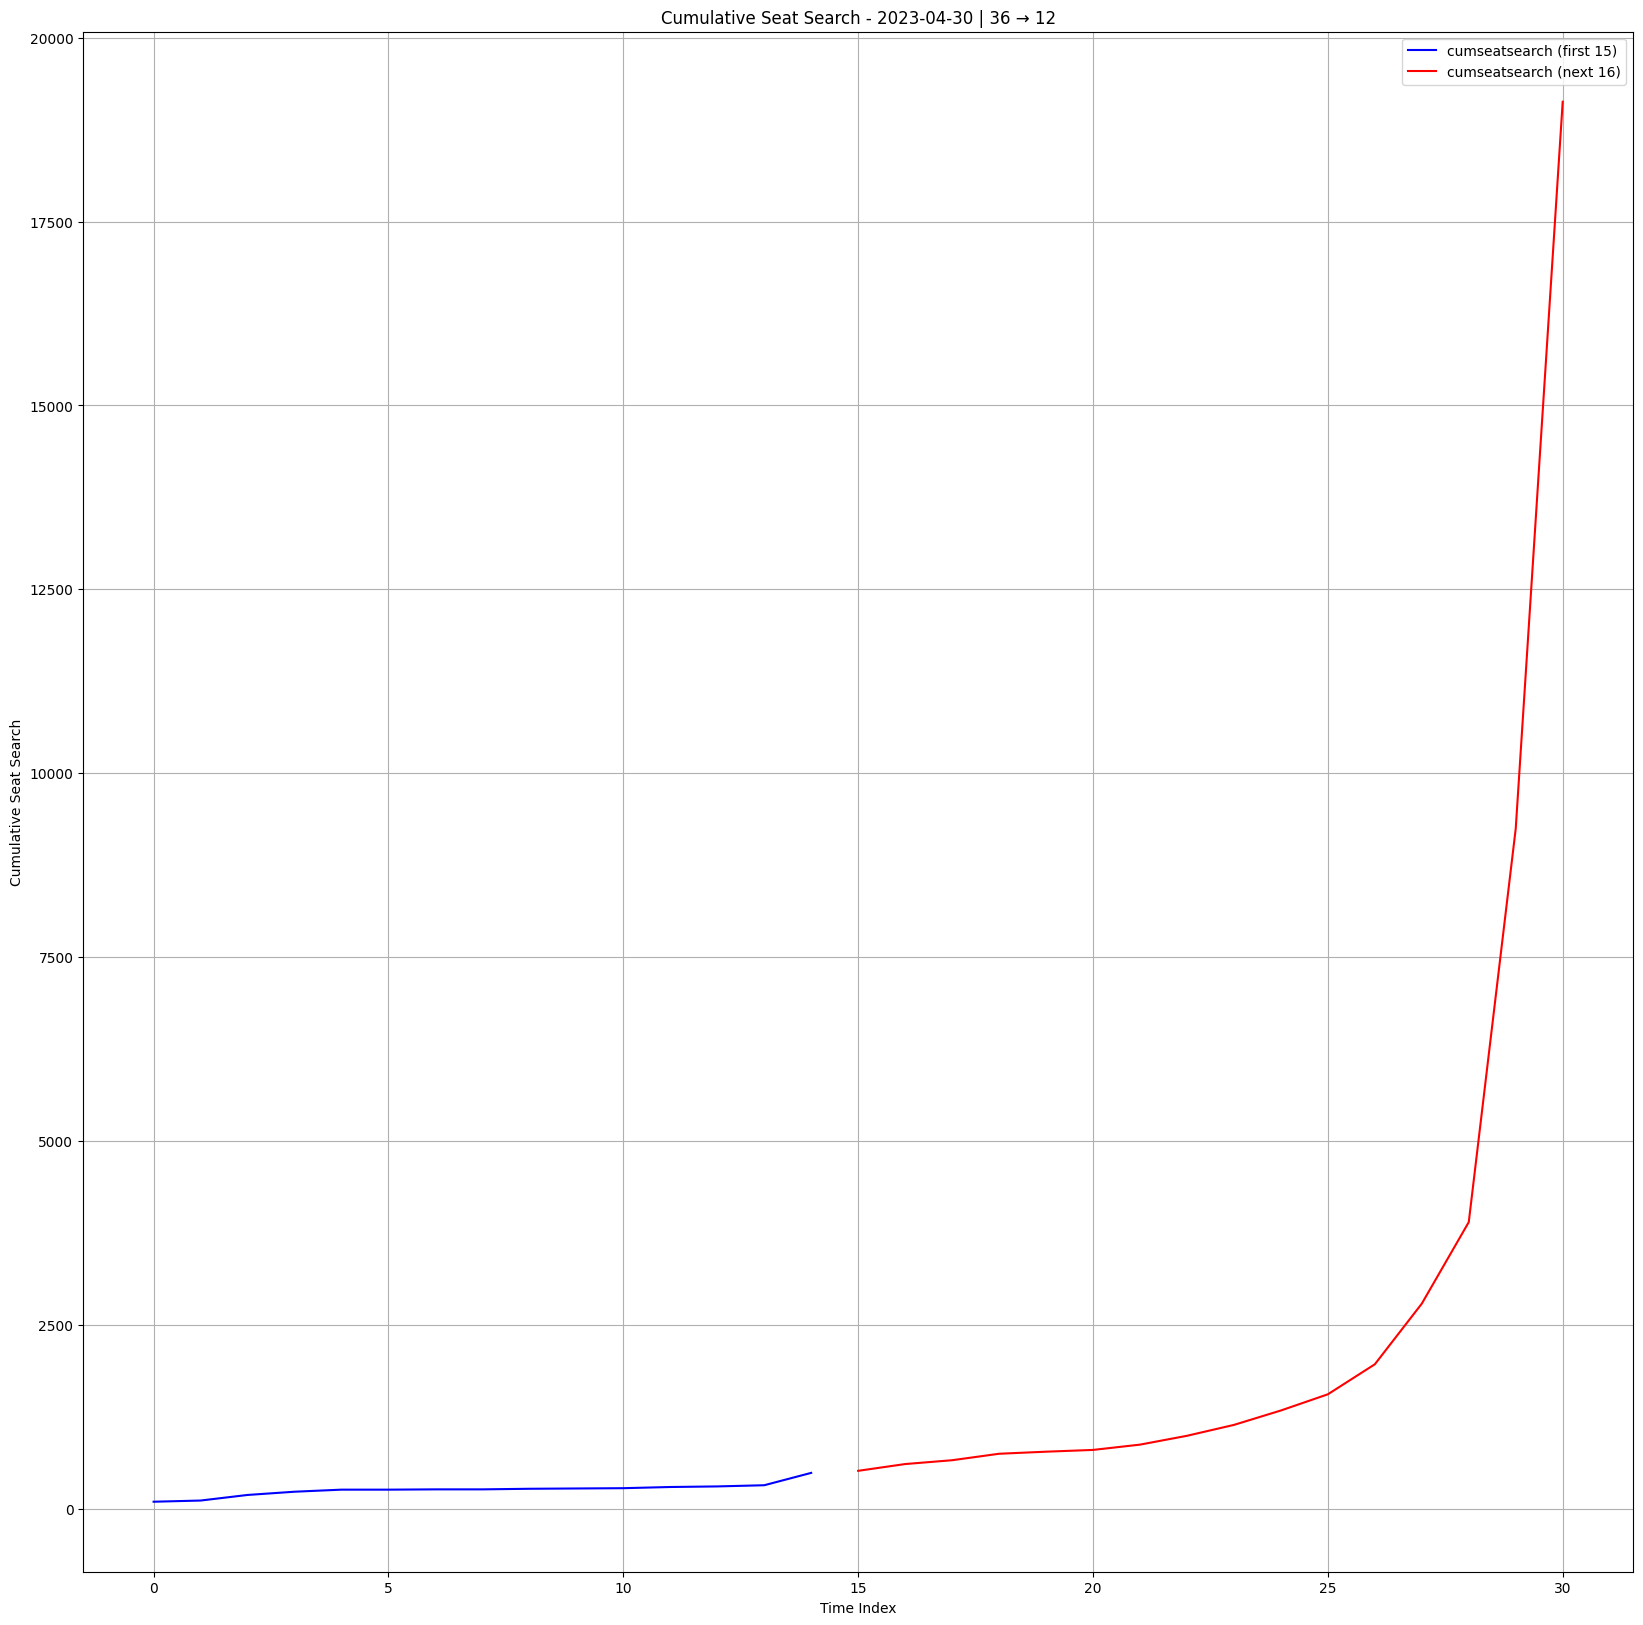

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Sample filtering setup ---
# Specify the route and month you're interested in
target_month ='April'  # e.g., February
target_year = 2023
target_srcid = '36'
target_destid = '12'

# Ensure 'doj' is datetime type
df2['doj'] = pd.to_datetime(df2['doj'])
# print(df2['doj'].dt.year)
# Filter rows for the given route and month
route_df2 = df2[
    (df2['srcid'] == target_srcid) &
    (df2['destid'] == target_destid) &
    (df2['doj'].dt.month_name() == target_month) &
    (df2['doj'].dt.year == target_year)
]
# print(route_df2)
# --- Now group by each unique (doj, srcid, destid) ---
grouped = route_df2.groupby(['doj', 'srcid', 'destid'])

# Plot each route's 31-point time series
for (doj, srcid, destid), group in grouped:
    group = group.sort_values(by='doi')  # Add or use actual time index if present
    x = list(range(len(group)))  # Assuming time points 0 to 30
    y1 = group['cumsum_seatcount'].values
    y2 = group['cumsum_searchcount'].values

    # Plot seat count
    plt.figure(figsize=(20, 20))
    plt.plot(x[:15], y1[:15], color='blue', label='cumseatcount (first 15)')
    plt.plot(x[15:], y1[15:], color='red', label='cumseatcount (next 16)')
    plt.title(f'Cumulative Seat Count - {doj.date()} | {srcid} → {destid}')
    plt.xlabel('Time Index')
    plt.ylabel('Cumulative Seat Count')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot seat search
    plt.figure(figsize=(20, 20))
    plt.plot(x[:15], y2[:15], color='blue', label='cumseatsearch (first 15)')
    plt.plot(x[15:], y2[15:], color='red', label='cumseatsearch (next 16)')
    plt.title(f'Cumulative Seat Search - {doj.date()} | {srcid} → {destid}')
    plt.xlabel('Time Index')
    plt.ylabel('Cumulative Seat Search')
    plt.legend()
    plt.grid(True)
    plt.show()


In [4]:
print(df1['srcid'].nunique(),df2['srcid'].nunique(),df3['srcid'].nunique())
print(df1['destid'].nunique(),df2['destid'].nunique(),df3['destid'].nunique())

45 45 45
45 45 45


In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266100 entries, 0 to 2266099
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   doj                 object 
 1   doi                 object 
 2   srcid               int64  
 3   destid              int64  
 4   srcid_region        object 
 5   destid_region       object 
 6   srcid_tier          object 
 7   destid_tier         object 
 8   cumsum_seatcount    float64
 9   cumsum_searchcount  float64
 10  dbd                 int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 190.2+ MB


In [6]:
grouped_counts = df2.groupby(['doj', 'srcid', 'destid']).size().reset_index(name='count')
print(grouped_counts)

              doj  srcid  destid  count
0      2023-03-01      1       2     31
1      2023-03-01      2       1     31
2      2023-03-01      2      14     31
3      2023-03-01      2      16     31
4      2023-03-01      2      19     31
...           ...    ...     ...    ...
73095  2025-02-28     47      43     31
73096  2025-02-28     47      45     31
73097  2025-02-28     47      46     31
73098  2025-02-28     48      45     31
73099  2025-02-28     48      46     31

[73100 rows x 4 columns]


In [7]:
mask = df3[['doj', 'srcid', 'destid']].apply(tuple, axis=1).isin(
    df2[['doj', 'srcid', 'destid']].apply(tuple, axis=1)
)

common_count = mask.sum()
print(f"Number of common rows out of total test rows: {common_count}/{len(df3)}")

Number of common rows out of total test rows: 5900/5900


In [8]:
keys = ['doj', 'srcid', 'destid']
df_test_transactions = df2[df2[keys].apply(tuple, axis=1).isin(
    df3[keys].apply(tuple, axis=1)
)]

df_train_transactions = df2[df2[keys].apply(tuple, axis=1).isin(
    df3[keys].apply(tuple, axis=1)
)]

df_test_transactions

doj         doi  srcid  destid         srcid_region  \
2083200  2025-01-01  2024-12-02     45      46            Karnataka   
2083201  2025-01-01  2024-12-02     46      45           Tamil Nadu   
2083202  2025-01-01  2024-12-02     45      47            Karnataka   
2083203  2025-01-01  2024-12-02     47      45       Andhra Pradesh   
2083204  2025-01-01  2024-12-02     46       9           Tamil Nadu   
...             ...         ...    ...     ...                  ...   
2266095  2025-02-28  2025-02-28      2      24  Maharashtra and Goa   
2266096  2025-02-28  2025-02-28     44      45           Tamil Nadu   
2266097  2025-02-28  2025-02-28     47      10       Andhra Pradesh   
2266098  2025-02-28  2025-02-28     38      36        Rest of North   
2266099  2025-02-28  2025-02-28     19      30       Madhya Pradesh   

               destid_region srcid_tier destid_tier  cumsum_seatcount  \
2083200           Tamil Nadu     Tier 1      Tier 1               6.0   
2083201            Karnataka     Tier 1      Tier 1              22.0   
2083202       Andhra Pradesh     Tier 1      Tier 1              22.0   
2083203            Karnataka     Tier 1      Tier 1              70.0   
2083204           Tamil Nadu     Tier 1       Tier2               9.0   
...                      ...        ...         ...               ...   
2266095  Maharashtra and Goa     Tier 1       Tier2               0.0   
2266096            Karnataka      Tier2      Tier 1               0.0   
2266097       Andhra Pradesh     Tier 1      Tier 3               0.0   
2266098                Delhi     Tier 1       Tier2               0.0   
2266099  Maharashtra and Goa     Tier 1      Tier 1               0.0   

         cumsum_searchcount  dbd  
2083200               626.0   30  
2083201               620.0   30  
2083202              1136.0   30  
2083203              2140.0   30  
2083204               768.0   30  
...                     ...  ...  
2266095                 0.0    0  
2266096                 0.0    0  
2266097                 0.0    0  
2266098                 0.0    0  
2266099                 0.0    0  

[182900 rows x 11 columns]

In [9]:
on_the_dod = df_test_transactions[df_test_transactions['dbd'] == 14]

In [10]:
on_the_dod['cumsum_seatcount'].unique()

array([0.])

In [11]:
on_the_dod['cumsum_searchcount'].unique()

array([0.])

In [12]:
df2['doj'] = pd.to_datetime(df2['doj'])
date_counts = df2['doj'].value_counts().sort_index()
print(len(date_counts),date_counts)

731 doj
2023-03-01    3100
2023-03-02    3100
2023-03-03    3100
2023-03-04    3100
2023-03-05    3100
              ... 
2025-02-24    3100
2025-02-25    3100
2025-02-26    3100
2025-02-27    3100
2025-02-28    3100
Name: count, Length: 731, dtype: int64


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

#daily ka 100 routes hain

df3['doj'] = pd.to_datetime(df3['doj'])

date_counts = df3['doj'].value_counts().sort_index()
print(len(date_counts),date_counts)

59 doj
2025-01-01    100
2025-01-02    100
2025-01-03    100
2025-01-04    100
2025-01-05    100
2025-01-06    100
2025-01-07    100
2025-01-08    100
2025-01-09    100
2025-01-10    100
2025-01-11    100
2025-01-12    100
2025-01-13    100
2025-01-14    100
2025-01-15    100
2025-01-16    100
2025-01-17    100
2025-01-18    100
2025-01-19    100
2025-01-20    100
2025-01-21    100
2025-01-22    100
2025-01-23    100
2025-01-24    100
2025-01-25    100
2025-01-26    100
2025-01-27    100
2025-01-28    100
2025-01-29    100
2025-01-30    100
2025-01-31    100
2025-02-01    100
2025-02-02    100
2025-02-03    100
2025-02-04    100
2025-02-05    100
2025-02-06    100
2025-02-07    100
2025-02-08    100
2025-02-09    100
2025-02-10    100
2025-02-11    100
2025-02-12    100
2025-02-13    100
2025-02-14    100
2025-02-15    100
2025-02-16    100
2025-02-17    100
2025-02-18    100
2025-02-19    100
2025-02-20    100
2025-02-21    100
2025-02-22    100
2025-02-23    100
2025-02-24    100
202